<a href="https://colab.research.google.com/github/sznajder/FwdMuonTrigger/blob/master/FwdMuonGNNSegmentClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network for SEGMENT classification

### Based on:

https://github.com/jmduarte/gnn-fpga/blob/master/README.md

https://github.com/jmduarte/heptrkx-gnn-tracking/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/MPNN_HitClassifier.ipynb



In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import os
import sys
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import math
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, find
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile = data_dir+'/graphs.npz'
events_start=0
events_end=100


# Local imports
#from estimator import Estimator
#from acts import process_hits_files, select_barrel_hits

#%matplotlib notebook
#%matplotlib ipympl
%matplotlib inline

# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

# Graph is a namedtuple of (X, Ri, Ro, y) for convenience
feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z','isMuon']
feature_scale = np.array([1000., 180. / 6., 1000., 1])
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

# Sparse graph uses the indices for the Ri, Ro matrices
SparseGraph = namedtuple('SparseGraph',['X', 'Ri_rows', 'Ri_cols', 'Ro_rows', 'Ro_cols', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
_about.txt	   graphs		  ntuple_qqH_ZZ4mu.root
bolsas_astro.txt   jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
bolsas_fisica.txt  model_best.pt	  ntuple_SingleNeutrino_PU200_63.root
events.root	   ntuple_bkg_ZZ4mu.root  VBFHZZ_background.csv
GOOG.csv	   ntuple_ggH_ZZ4mu.root  VBFHZZ_signal.csv


## PYTORCH module implementing a Message Passing GNN

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/model.py

In [0]:
"""
This module implements the PyTorch modules that define the
message-passing graph neural networks for hit or segment classification.

"""
##############################################################

class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

##############################################################

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.bmm(Rwi, bo)
        mo = torch.bmm(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

##############################################################

class NodeClassifier(nn.Module):
    """
    A message-passing graph neural network model which performs
    binary classification of nodes.
    """
    def __init__(self, input_dim=4, hidden_dim=8, n_iters=1, hidden_activation=nn.Tanh):
        super(NodeClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the output network
        self.output_network = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final output network
        return self.output_network(H).squeeze(-1)

##############################################################

class SegmentClassifier(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## PYTORCH module implementing the Estimator

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/estimator.py

In [0]:
"""
This module contains the Estimator class implementation which provides
code for doing the training of a PyTorch model.
"""

from __future__ import print_function

from datetime import datetime
from timeit import default_timer as timer

import numpy as np

import shutil 
import os

import torch

def logger(s):
    """Simple logger function which prints date/time"""
    print(datetime.now(), s)

class Estimator():
    """Estimator class"""

    def __init__(self, model, loss_func, opt='Adam',
                 train_losses=None, valid_losses=None,
                 cuda=False, l1=0.):

        self.model = model
        if cuda:
            self.model.cuda()
        self.loss_func = loss_func
        if opt == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif opt == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters())

        self.train_losses = train_losses if train_losses is not None else []
        self.valid_losses = valid_losses if valid_losses is not None else []
        self.l1 = l1

        logger('Model: \n%s' % model)
        logger('Parameters: %i' %
               sum(param.numel() for param in model.parameters()))

    def l1_penalty(self, arr):
        return torch.abs(arr).sum()
        
    def training_step(self, inputs, targets):
        """Applies single optimization step on batch"""
        self.model.zero_grad()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        node_weights = [layer.weight for layer in self.model.node_network.network if hasattr(layer, 'weight')]
        edge_weights = [layer.weight for layer in self.model.edge_network.network if hasattr(layer, 'weight')]
        l1_regularization = self.l1 * sum([self.l1_penalty(arr) for arr in node_weights]) + self.l1 * sum([self.l1_penalty(arr) for arr in edge_weights])
        loss = self.loss_func(outputs, targets) + l1_regularization 
        loss.backward()
        self.optimizer.step()
        return loss

    def save_checkpoint(self, state, is_best, filename='checkpoint.pt'):
#        directory = os.path.dirname(filename)
        directory = data_dir
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        torch.save(state, filename)
        if is_best:
            bestfilename = directory+'/model_best.pt'
            shutil.copyfile(filename, bestfilename)
            
    def load_checkpoint(self, filename='checkpoint.pt'):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.valid_losses = checkpoint['valid_losses']
        self.train_losses = checkpoint['train_losses']
    
    def fit_gen(self, train_generator, n_batches=1, n_epochs=1,
                valid_generator=None, n_valid_batches=1, verbose=0, 
                filename='checkpoint.pt'):
        """Runs batch training for a number of specified epochs."""
        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        if len(self.valid_losses) > 0:
            best_valid_loss = self.valid_losses[-1]
        else:
            best_valid_loss = 99999999
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            # Train the model
            self.model.train()
            
            for j in range(n_batches):
                batch_input, batch_target = next(train_generator)
                batch_loss = (self.training_step(batch_input, batch_target)
                              .cpu().data.item())
                sum_loss += batch_loss
                if verbose > 0:
                    logger('  Batch %i loss %f' % (j, batch_loss))
            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            with torch.no_grad():
                # Evaluate the model on the validation set
                if (valid_generator is not None) and (n_valid_batches > 0):
                    self.model.eval()
                    valid_loss = 0
                    for j in range(n_valid_batches):
                        valid_input, valid_target = next(valid_generator)
                        valid_loss += (self.loss_func(self.model(valid_input), valid_target)
                                       .cpu().data.item())
                    valid_loss = valid_loss / n_valid_batches
                    self.valid_losses.append(valid_loss)
                    logger('  validate loss %.3g' % valid_loss)
                
                    #Save model checkpoint - modified
                    logger(' save checkpoint') 
                    is_best = valid_loss < best_valid_loss
                    best_valid_loss = min(valid_loss, best_valid_loss)
                    self.save_checkpoint({
                        'epoch': i + 1,
                        'state_dict': self.model.state_dict(),
                        'best_valid_loss': best_valid_loss,
                        'valid_losses': self.valid_losses,
                        'train_losses': self.train_losses,
                        'optimizer' : self.optimizer.state_dict(),
                    }, is_best, filename=filename)

    def predict(self, generator, n_batches, concat=True):
        with torch.no_grad():  
            self.model.eval()
            outputs = []
            for j in range(n_batches):
                test_input, test_target = next(generator)
                outputs.append(self.model(test_input))
            if concat:
                outputs = torch.cat(outputs)
            return outputs

    # DEPRECATED; MOVE TO BATCH GENERATOR VERSION
    def fit(self, train_input, train_target, batch_size=32, n_epochs=1,
            valid_input=None, valid_target=None):
        """Runs batch training for a number of specified epochs."""
        if type(train_input) == list:
            n_samples = train_input[0].size(0)
        else:
            n_samples = train_input.size(0)
        n_batches = (n_samples + batch_size - 1) // batch_size
        logger('Training samples: %i' % n_samples)
        logger('Batches per epoch: %i' % n_batches)
        if valid_input is not None:
            n_valid = (valid_input[0].size(0) if type(valid_input) == list
                       else valid_input.size(0))
            logger('Validation samples: %i' % n_valid)

        batch_idxs = np.arange(0, n_samples, batch_size)

        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            self.model.train()
            for j in batch_idxs:
                # TODO: add support for more customized batching
                if type(train_input) is list:
                    batch_input = [ti[j:j+batch_size] for ti in train_input]
                else:
                    batch_input = train_input[j:j+batch_size]
                batch_target = train_target[j:j+batch_size]
                loss = self.training_step(batch_input, batch_target)
                sum_loss += loss.cpu().data.item()

            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            # Evaluate the model on the validation set
            self.model.eval()
            if (valid_input is not None) and (valid_target is not None):
                valid_loss = (self.loss_func(self.model(valid_input), valid_target)
                              .cpu().data.item())
                self.valid_losses.append(valid_loss)
                logger('  validate loss %.3g' % valid_loss)



## Batch Generator

In [0]:
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
#            batch_X  = np_to_torch(  X[j:j+batch_size], volatile=volatile )
#            batch_Ri = np_to_torch( Ri[j:j+batch_size], volatile=volatile )
#            batch_Ro = np_to_torch( Ro[j:j+batch_size], volatile=volatile )
#            batch_y  = np_to_torch(  y[j:j+batch_size], volatile=volatile )
 
          with torch.set_grad_enabled(train):
            batch_X  = np_to_torch(  X[j:j+batch_size] )
            batch_Ri = np_to_torch( Ri[j:j+batch_size] )
            batch_Ro = np_to_torch( Ro[j:j+batch_size] )
            batch_y  = np_to_torch(  y[j:j+batch_size] )
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

## Network  Model and Training Configuration

In [0]:
# Model config
hidden_dim = 64
n_iters = 7

# Training config
batch_size = 10
n_epochs = 20
valid_frac = 0.2
test_frac = 0.2


## Load and prepare the graphs DATASET

In [6]:
# Load GRAPHS from inputfile
#sparse = np.load(infile, allow_pickle=True)
#gfile = np.load(infile)
#garray = gfile.f.arr_0 # convert file to 2D np.ndarrays
import glob
filenames =  glob.glob(data_dir+'/graphs/*.npz')

# Load the graphs into a list 
graphs = []
for f in filenames:
  gfile = np.load(f)
#  graph = SparseGraph(**dict(gfile.items()))
  graph = Graph(**dict(gfile.items()))
  graphs.append(graph)

# Get the matrix sizes in this batch
n_graphs = len(graphs)
n_features = graphs[0].X.shape[1] 
n_nodes    = np.array([g.X.shape[0] for g in graphs])
n_edges    = np.array([g.y.shape[0] for g in graphs])
max_nodes = n_nodes.max()
max_edges = n_edges.max()


print("n_graphs",n_graphs)
print("n_features",n_features)
print("n_nodes",n_nodes)
print("n_edges",n_edges)
print("max_nodes",max_nodes)
print("max_edges",max_edges)

# Define GRAPH tensors for the full dataset
n_samples = n_graphs
X  = np.zeros((n_samples, max_nodes, n_features), dtype=np.float32) # node features 
Ri = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  # adjacency matrix
Ro = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  #
y  = np.zeros((n_samples, max_edges), dtype=np.float32)             # target label

# Loop over graphs and fill the tensors ( with event # indexed  by i )
for i, g in enumerate(graphs):
  X[i, :n_nodes[i]] = g.X 
  Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
  Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
  y[i,  :n_edges[i]] = g.y                 


n_graphs 881
n_features 4
n_nodes [ 3  2  6  3 14  5  2 11 11  2  7  5  7  2  9  2 11  2  9  7  6  3  5  3
  2 10  5 11  5  5  3  3  5  4  4  3  2  3  3  5  2  5  2  9  6 10 10  5
  6  5 17  2 11  9  2  6  2  5 14  3  5  6  5  2  3  3  5  3  5  4  3  6
  6  8  5  3  7  5  5  8  7  5  7  3  4  4  9  5  2 22  4  7  3  2  2  5
  6  4  5 10  7  2  5  2  3  7  2 10  2  5 12  2 10  5  4  3  8  9  4  3
  7  7  2 11  5  4  6  2  7  3  8  8  2  6  4  3  2  3  6  3  5  3  5  7
  3  3  9  3  2  7  4  4  3  7  2  2  2  4  2 11  8  6  7  3  3 13  5  4
  5  6  7  5  3  2  2  3  6  3  2  5  3  6  5  5  7  2  3  6  3  4  4  3
  5  7 13 11  4 20  9  7  6  6  3  7  5  2  4  7  2  6  3  2  4  4  7  7
  3  3  9  6  5  2  3  7  2  2  7  3  5  4  7  2  7  4 13  2  2  2  4 19
  5  5  2  2  5 17  5  3  4  2  7  2  2  3  2  4  4  9 15  7  2  4  2  5
  7  7  7  2  3 14  3  2  3  8  3  4  5  7  6  5  3  7  3  4  3  5  4  6
  2  6 10  6  3  2  2  9  2  9  3  5  4  2  2  4  2  3  3  2  4  6  2  6
  6  6  2 10 12  

## Partition dataset into TRAIN , TEST and VALIDATION

In [7]:
%%time
# We round by batch_size to avoid partial batches
n_test  = int(n_samples * test_frac)     // batch_size * batch_size
n_valid = int(n_samples * valid_frac)    // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches  = n_test  // batch_size

# Partition the dataset into TEST, VALIDATION and TRAIN excliding isMuon from features ( X[:,3])
(train_X, test_X,  train_Ri, test_Ri,  train_Ro, test_Ro,  train_y, test_y)  = train_test_split(X[:,:,0:n_features-1], Ri, Ro, y, test_size=n_test)
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = train_test_split(X[:,:,0:n_features-1], Ri, Ro, y, test_size=n_valid)

# Prepare the batch samples
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y, train=True , n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False, n_samples=n_valid, batch_size=batch_size)
test_batcher  = batch_generator(test_X ,  test_Ri,  test_Ro, test_y , train=False, n_samples=n_test , batch_size=batch_size)

print('Graphs shapes:', X.shape , Ri.shape , Ro.shape , y.shape)
print('Graphs node features:', feature_names)
print("n_train, n_valid, n_test  = " , n_train, " , " , n_valid, " , " , n_test )
print('Train shapes:', train_X.shape , train_Ri.shape , train_Ro.shape , train_y.shape)
print('Valid shapes:', valid_X.shape , valid_Ri.shape , valid_Ro.shape , valid_y.shape)
print('Test shapes: ', test_X.shape  , test_Ri.shape  , test_Ro.shape  , test_y.shape)



Graphs shapes: (881, 22, 4) (881, 22, 49) (881, 22, 49) (881, 49)
Graphs node features: ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z', 'isMuon']
n_train, n_valid, n_test  =  540  ,  170  ,  170
Train shapes: (711, 22, 3) (711, 22, 49) (711, 22, 49) (711, 49)
Valid shapes: (170, 22, 3) (170, 22, 49) (170, 22, 49) (170, 49)
Test shapes:  (170, 22, 3) (170, 22, 49) (170, 22, 49) (170, 49)
CPU times: user 7.55 ms, sys: 9.13 ms, total: 16.7 ms
Wall time: 20.3 ms


## Construct the GNN model

In [8]:
# Construct the model
#model = EdgeClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
model = SegmentClassifier(input_dim=n_features-1, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2020-05-11 19:30:47.642729 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
)
2020-05-11 19:30:47.642885 Parameters: 26049


## Train the GNN

In [9]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,valid_generator=valid_batcher, n_valid_batches=n_valid_batches)

2020-05-11 19:30:47.651059 Epoch 0
2020-05-11 19:30:48.895038   training loss 0.595 time 1.24307s
2020-05-11 19:30:49.024704   validate loss 0.512
2020-05-11 19:30:49.024897  save checkpoint
2020-05-11 19:30:49.033017 Epoch 1
2020-05-11 19:30:50.284398   training loss 0.389 time 1.25115s
2020-05-11 19:30:50.413700   validate loss 0.286
2020-05-11 19:30:50.413880  save checkpoint
2020-05-11 19:30:50.421982 Epoch 2
2020-05-11 19:30:51.625374   training loss 0.201 time 1.2027s
2020-05-11 19:30:51.760695   validate loss 0.144
2020-05-11 19:30:51.760863  save checkpoint
2020-05-11 19:30:51.768514 Epoch 3
2020-05-11 19:30:52.982237   training loss 0.106 time 1.21315s
2020-05-11 19:30:53.114822   validate loss 0.0881
2020-05-11 19:30:53.115033  save checkpoint
2020-05-11 19:30:53.122679 Epoch 4
2020-05-11 19:30:54.302026   training loss 0.0696 time 1.17913s
2020-05-11 19:30:54.429022   validate loss 0.0637
2020-05-11 19:30:54.429197  save checkpoint
2020-05-11 19:30:54.436686 Epoch 5
2020-05-

## Evaluate Training


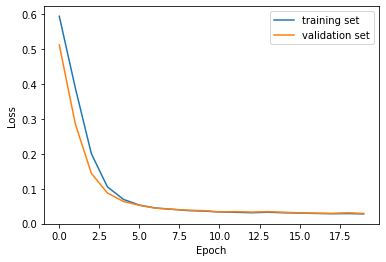

In [10]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate Performance


Test set results with threshold of 0.5
Accuracy:  0.9899
Precision: 0.6774
Recall:    0.3962


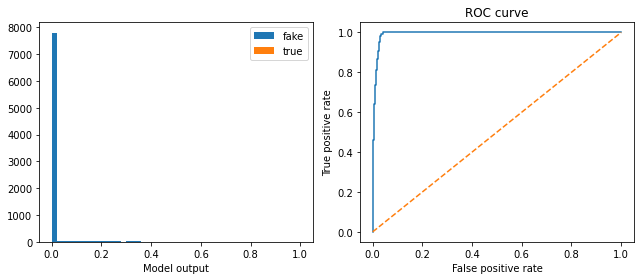

In [11]:
# Evaluate on TEST data
test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [7.2320225e-04 9.1638265e-04 6.2951166e-04 4.1245666e-04 1.4949232e-04
 9.4379779e-05 7.7778190e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


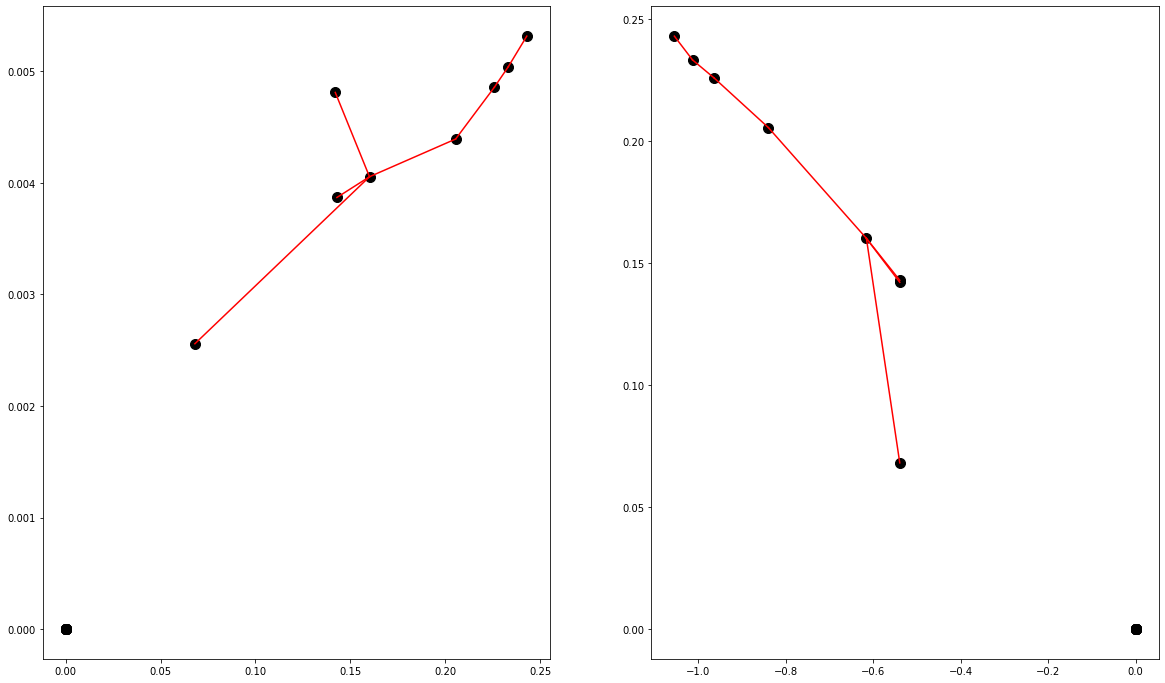

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00060293 0.00077621 0.00020312 0.00018171 0.0001408  0.00014145
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


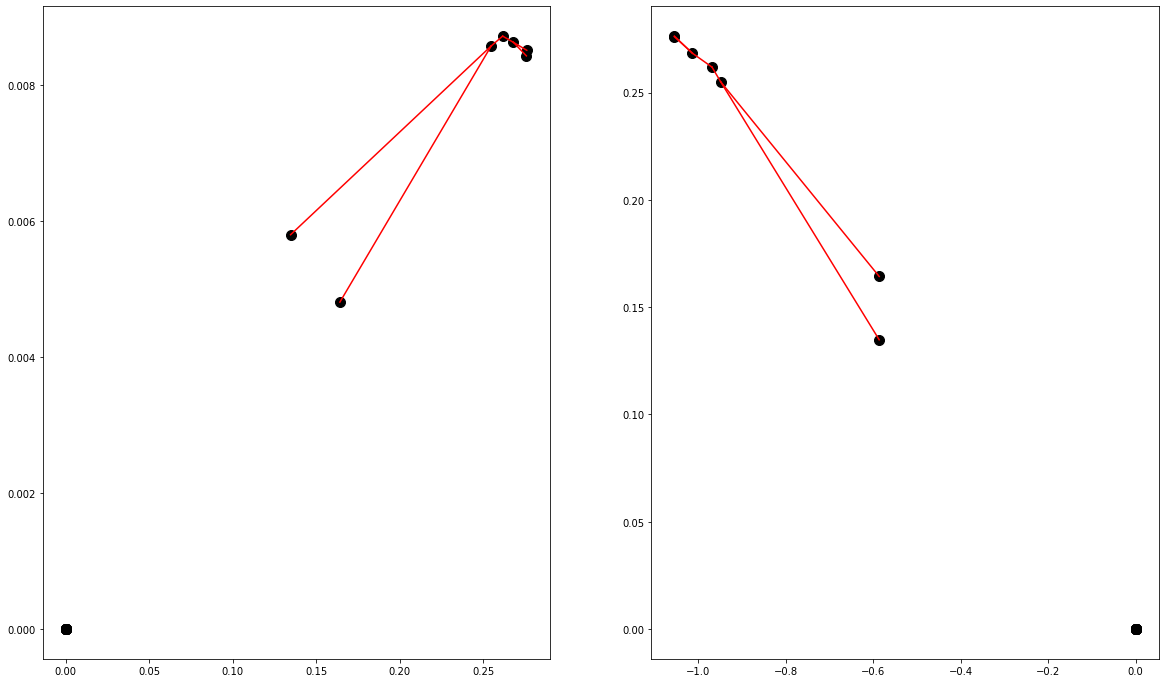

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20650843 0.20584975 0.30788708 0.3060851  0.46693933 0.3710886
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


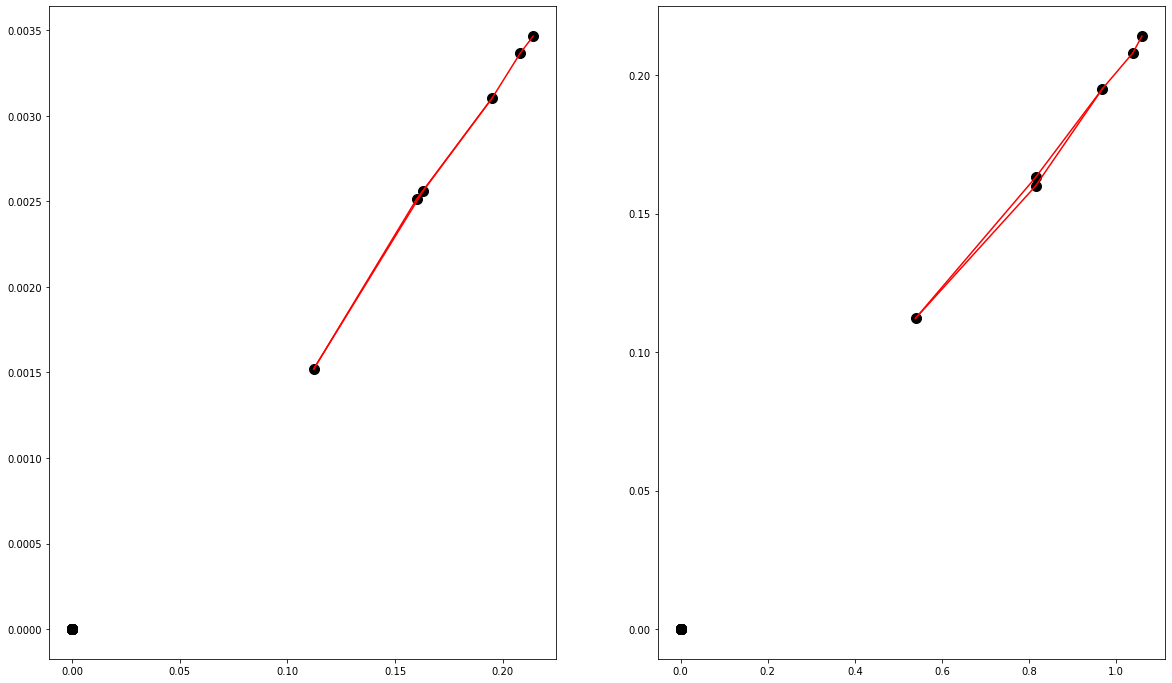

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00017244 0.00050821 0.00083293 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


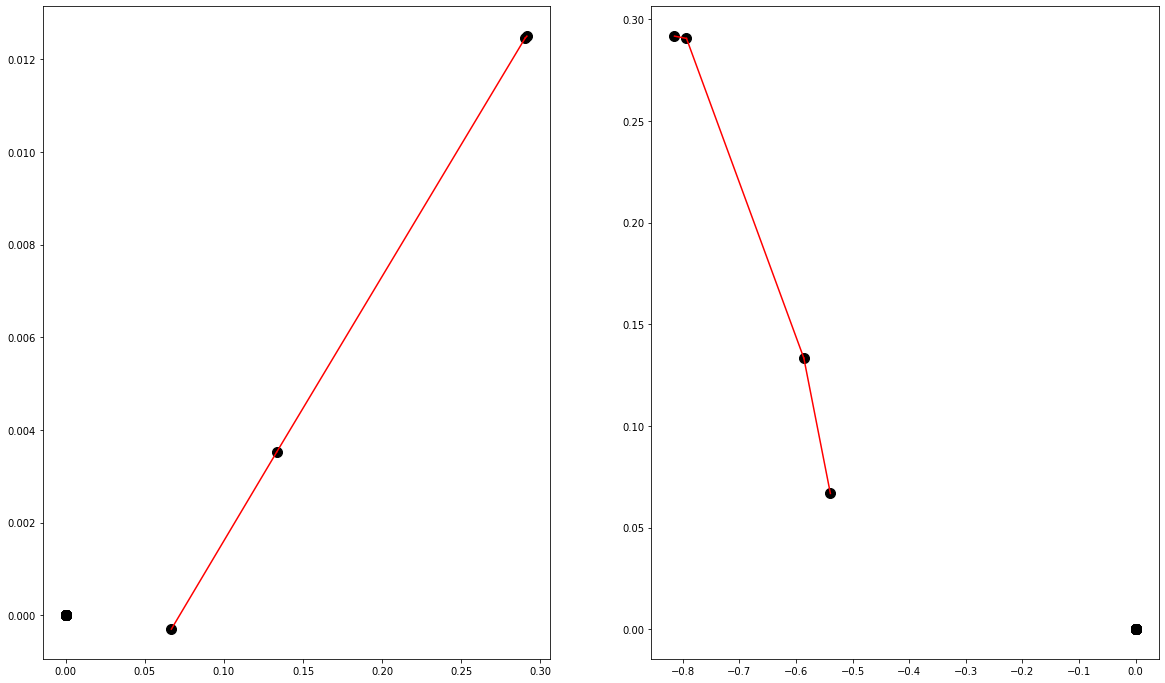

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00073919 0.00078906 0.00067564 0.0007212  0.00089085 0.00074484
 0.00041247 0.00026856 0.00024721 0.00018835 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


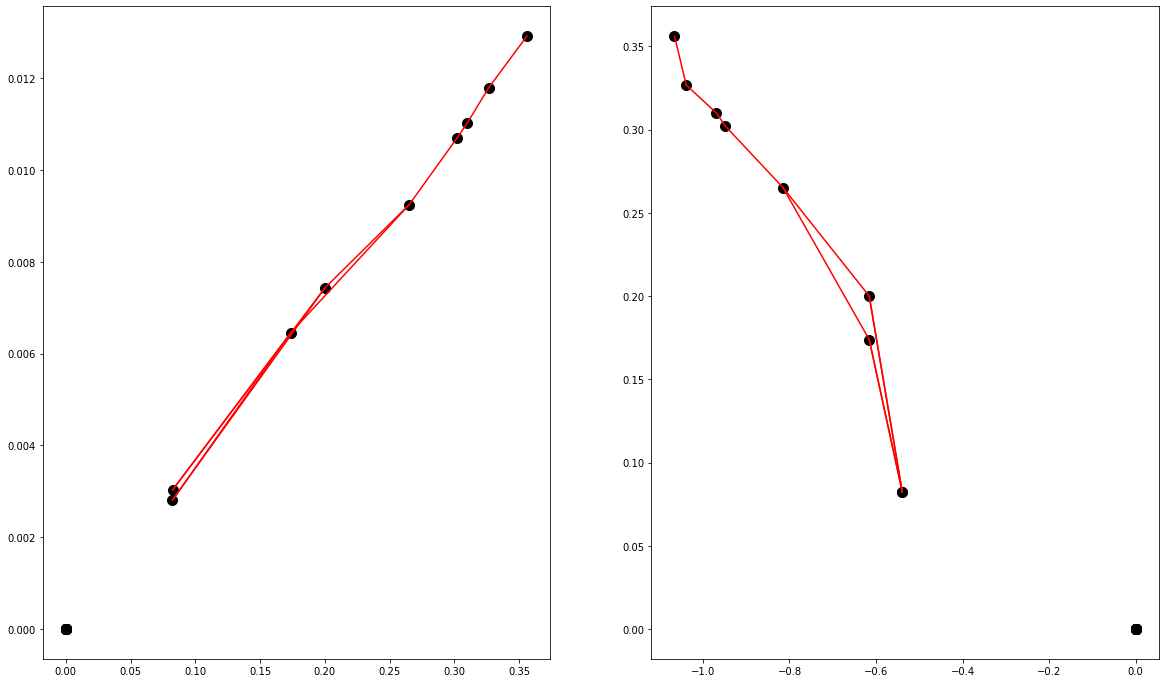

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00062725 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


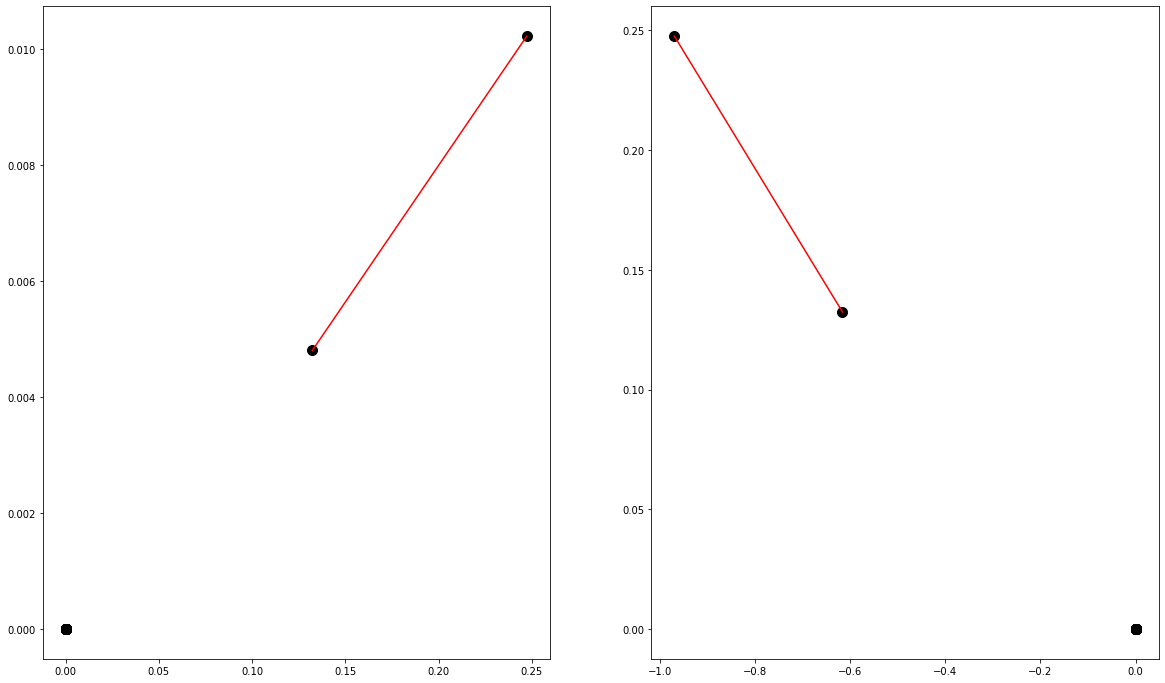

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00051171 0.00051671 0.00040503 0.00040876 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


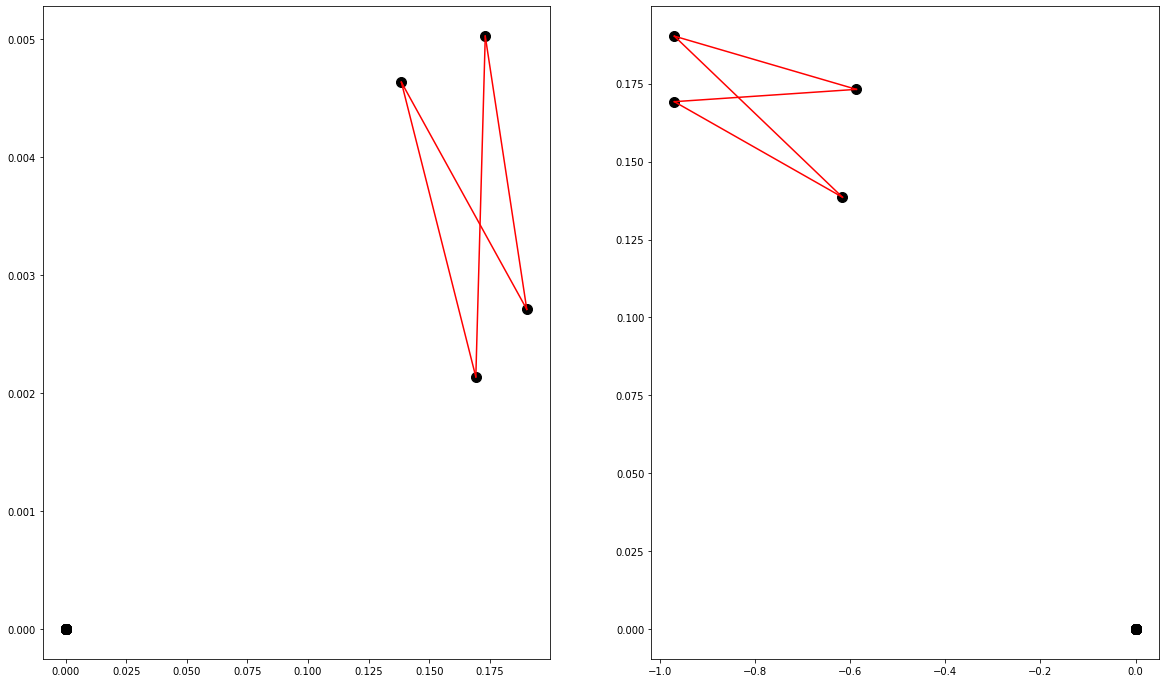

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00053784 0.0006981  0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


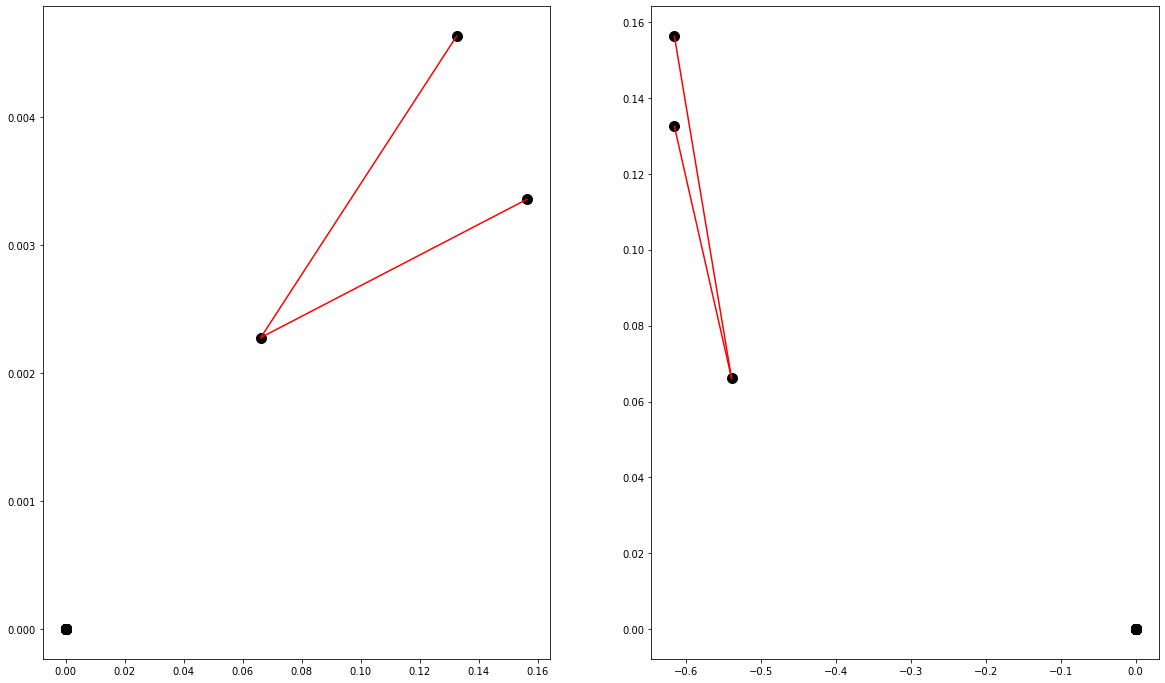

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00117051 0.00042509 0.00021145 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


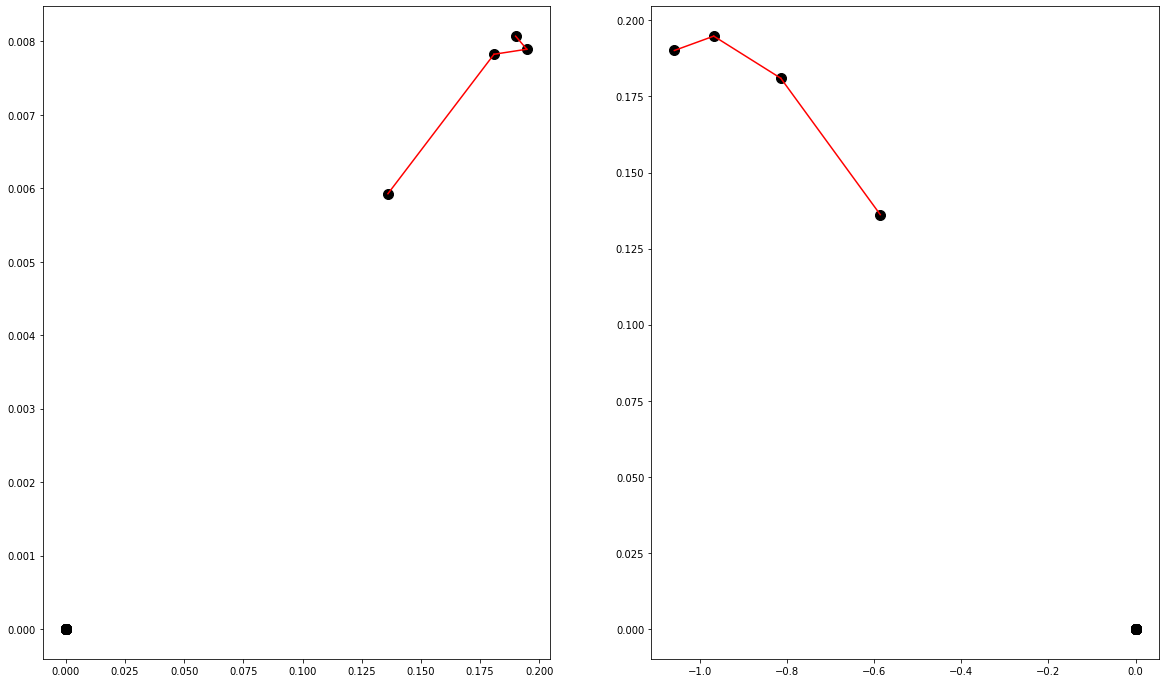

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.19339545 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


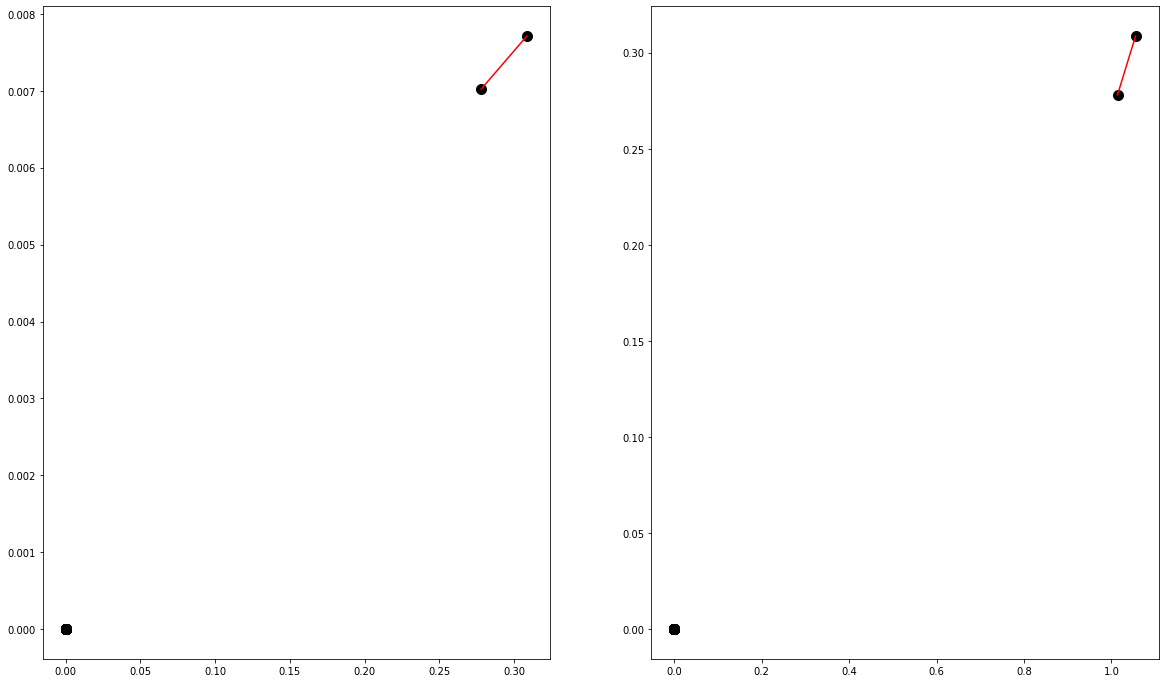

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00078688 0.00035114 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


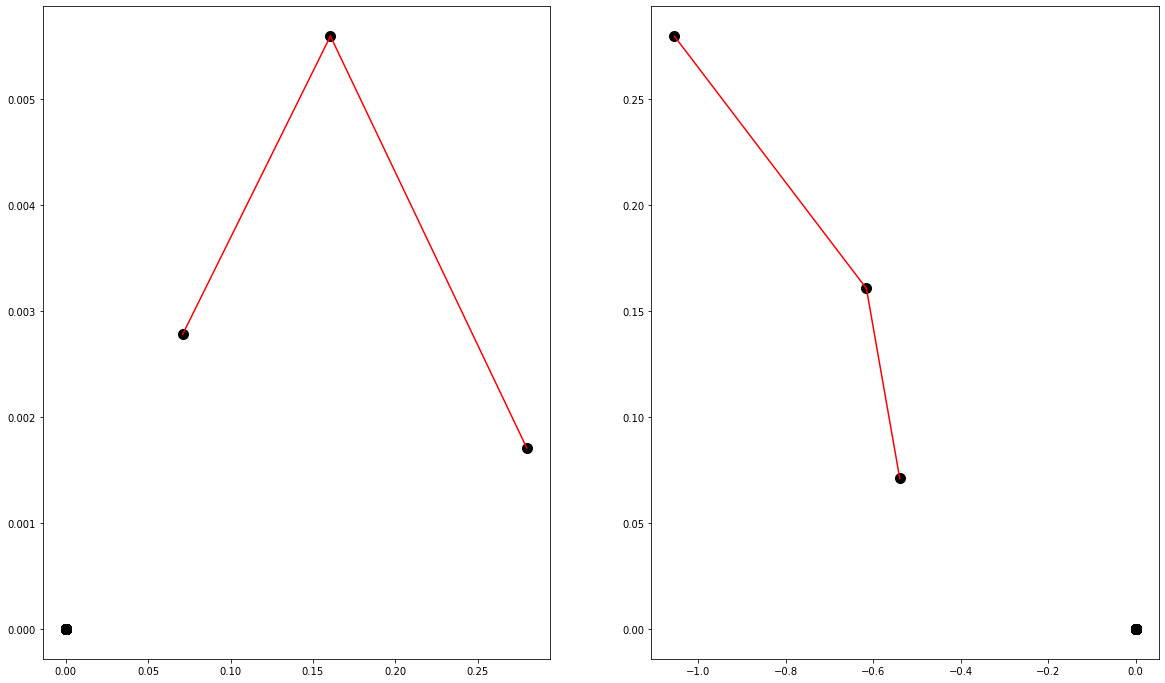

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.10291093 0.13805282 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


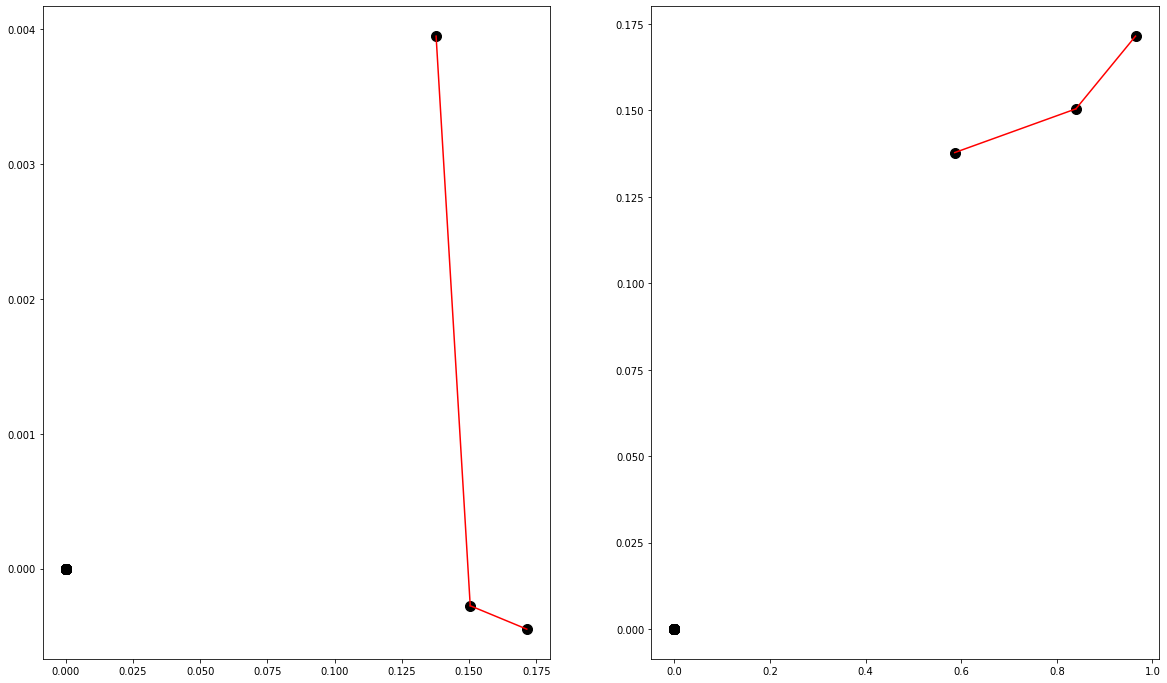

Y = [1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.2618143  0.2129024  0.38038325 0.3910681  0.68534017 0.72159034
 0.70239985 0.5983907  0.44476333 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.939, precision 1.000, recall 0.571


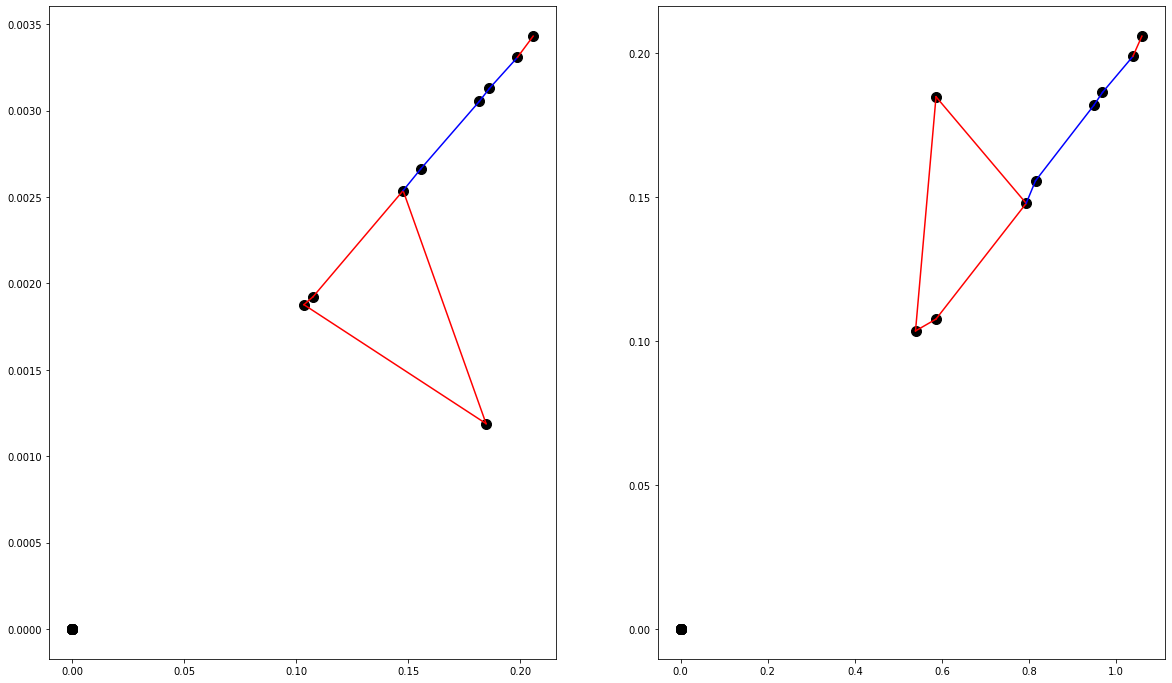

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00062455 0.00053599 0.00053222 0.00060417 0.00051851 0.00051486
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


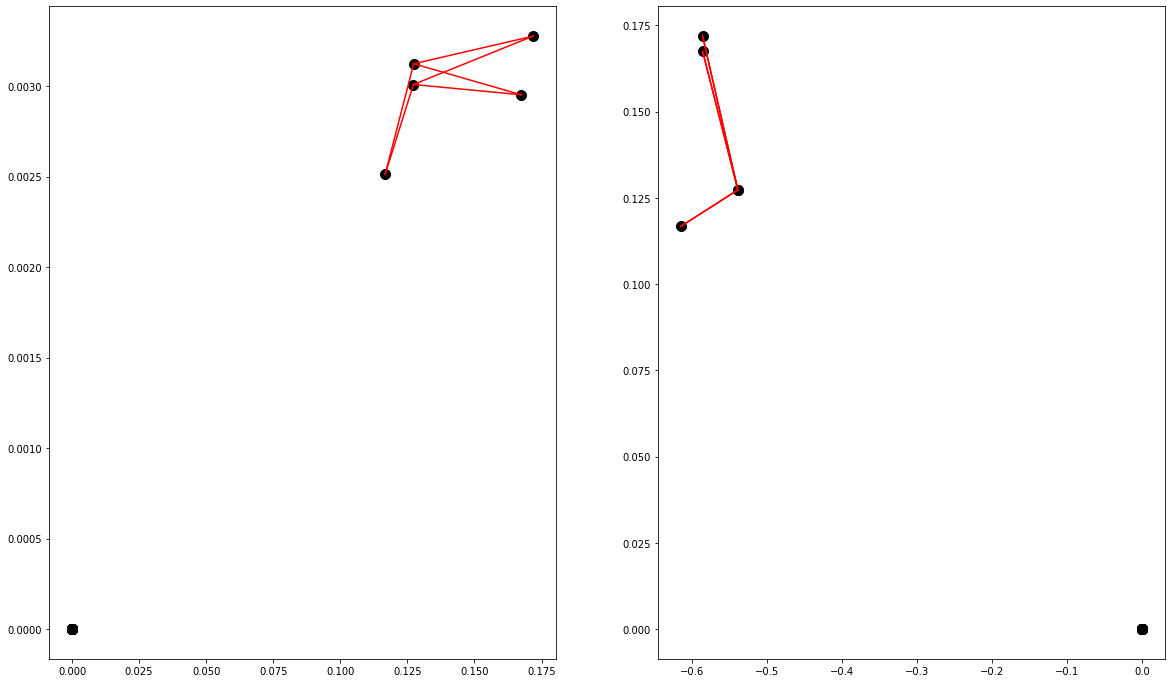

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00018671 0.00021768 0.00019879 0.00029404 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


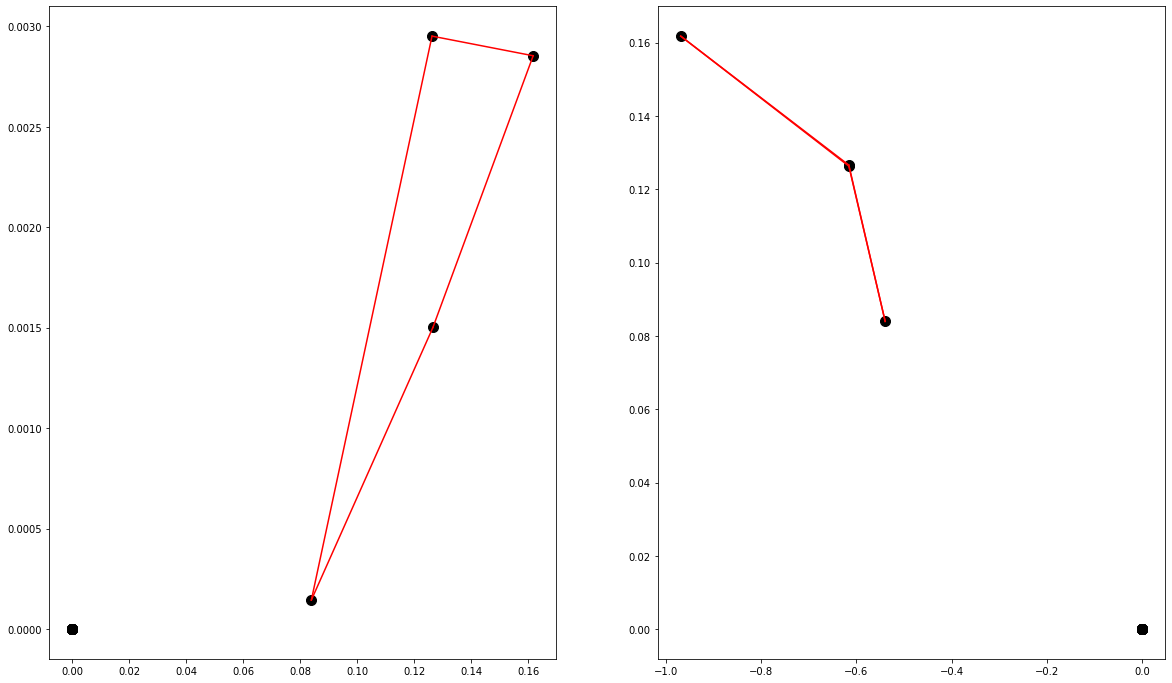

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.3019454  0.41473982 0.3419171  0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


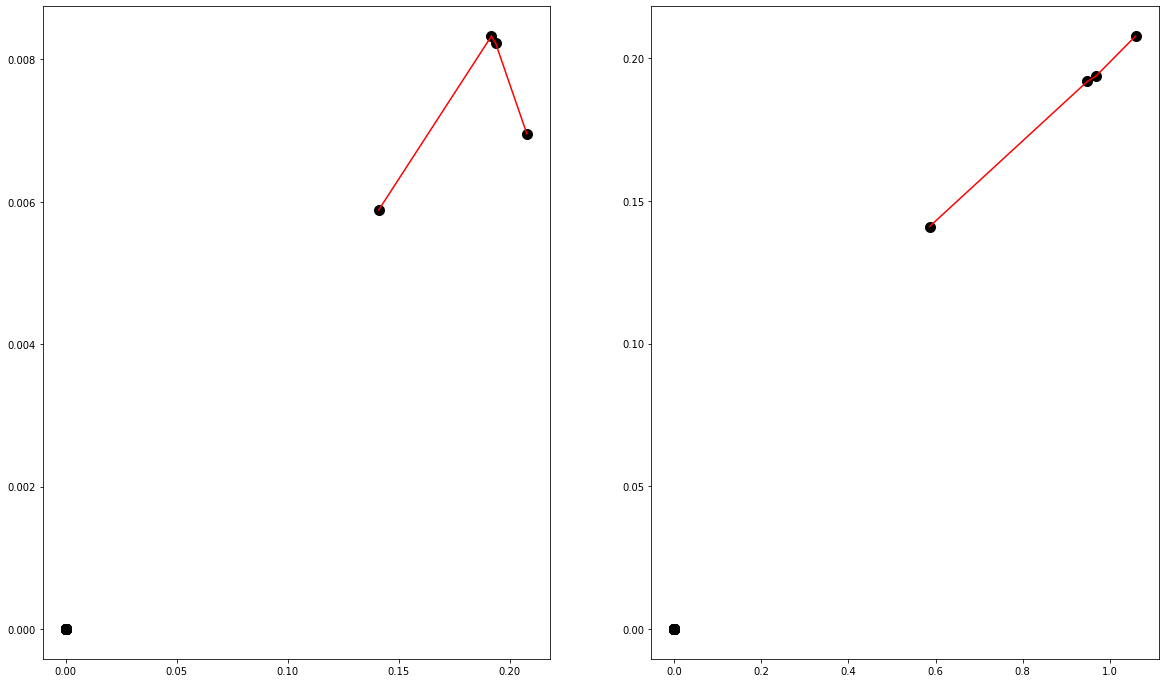

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [2.2292694e-04 2.2877133e-04 1.1964351e-04 1.3615975e-04 4.7440040e-05
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


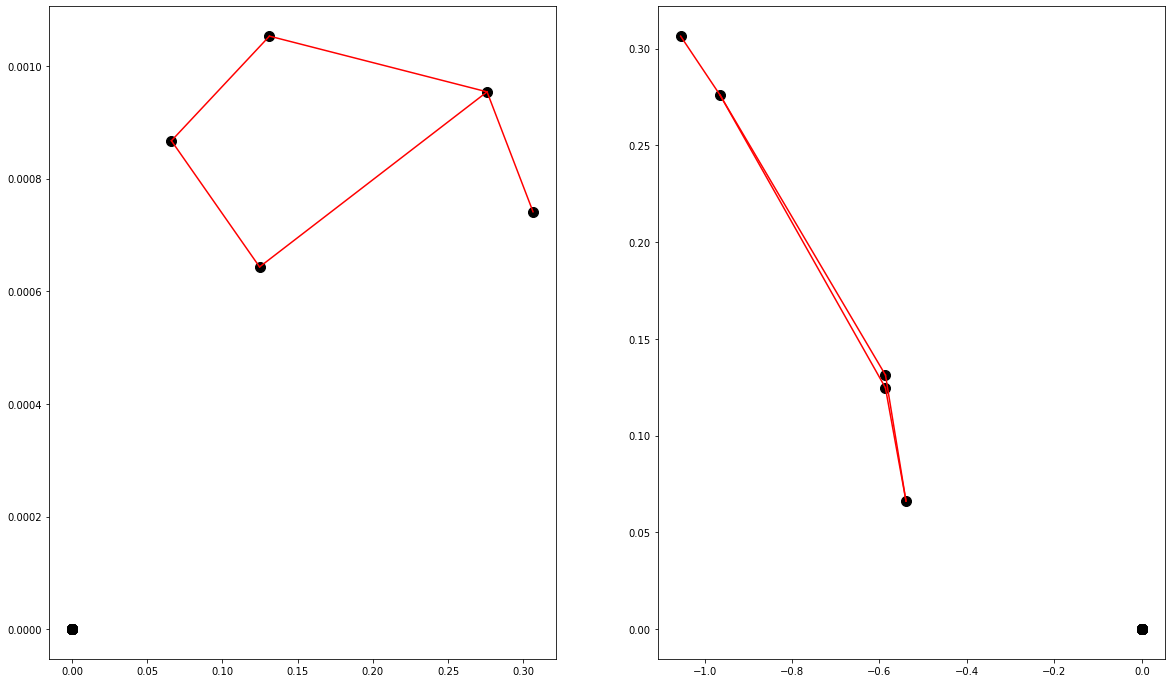

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00016479 0.00014475 0.00021087 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


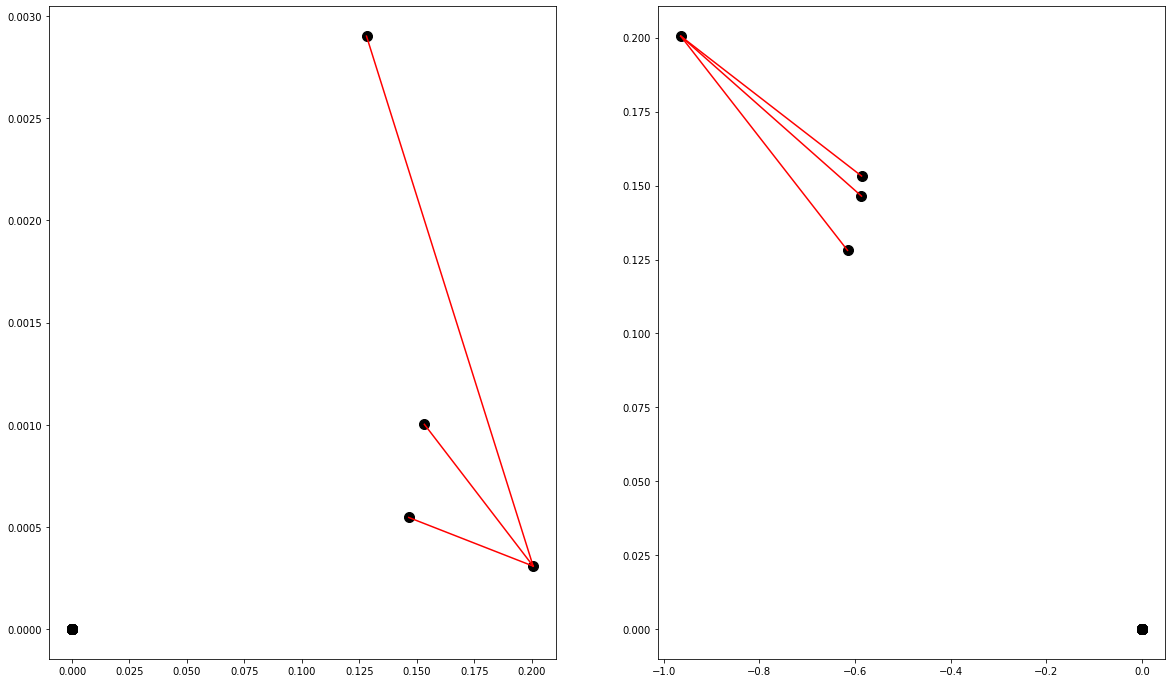

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [1.0222340e-04 5.9020826e-05 1.0220898e-04 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


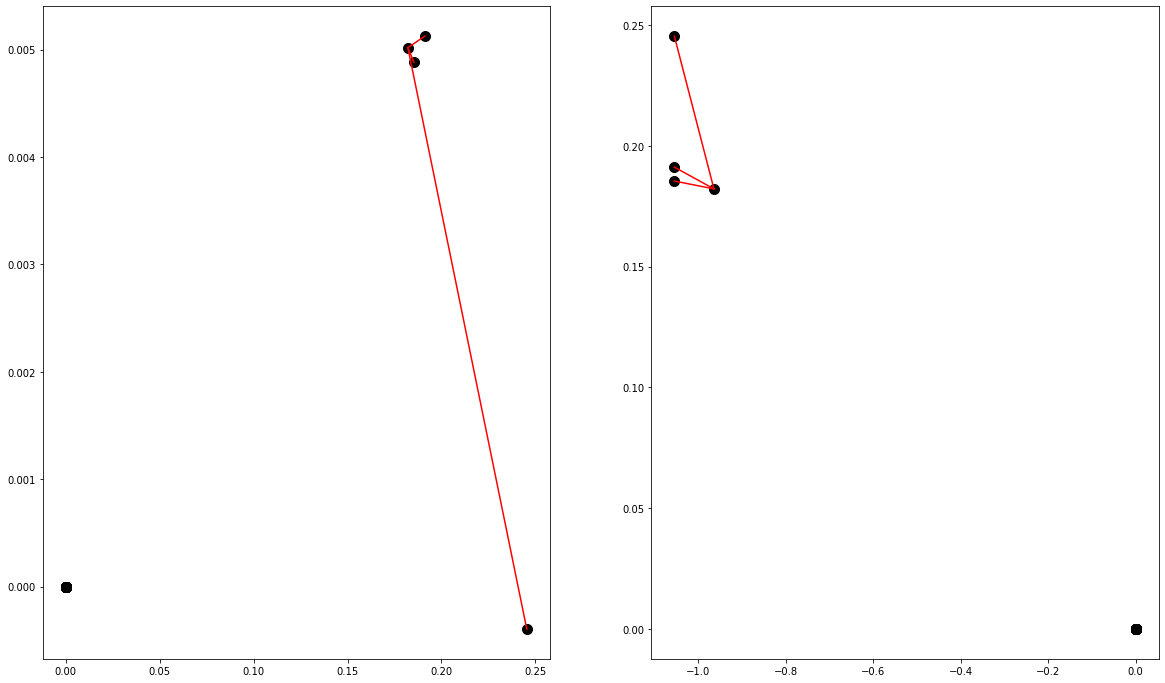

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00063309 0.00036232 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


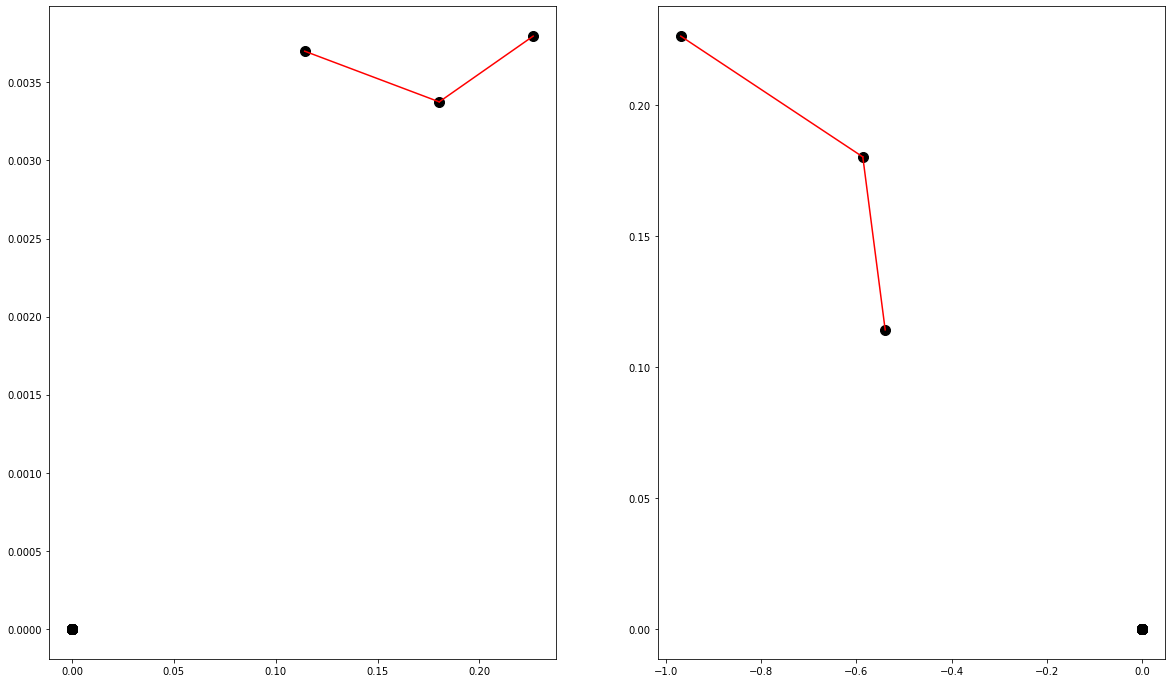

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00046215 0.00046643 0.00049887 0.00050479 0.00027504 0.00046293
 0.00029408 0.00049505 0.0002219  0.00037366 0.00023576 0.00039709
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


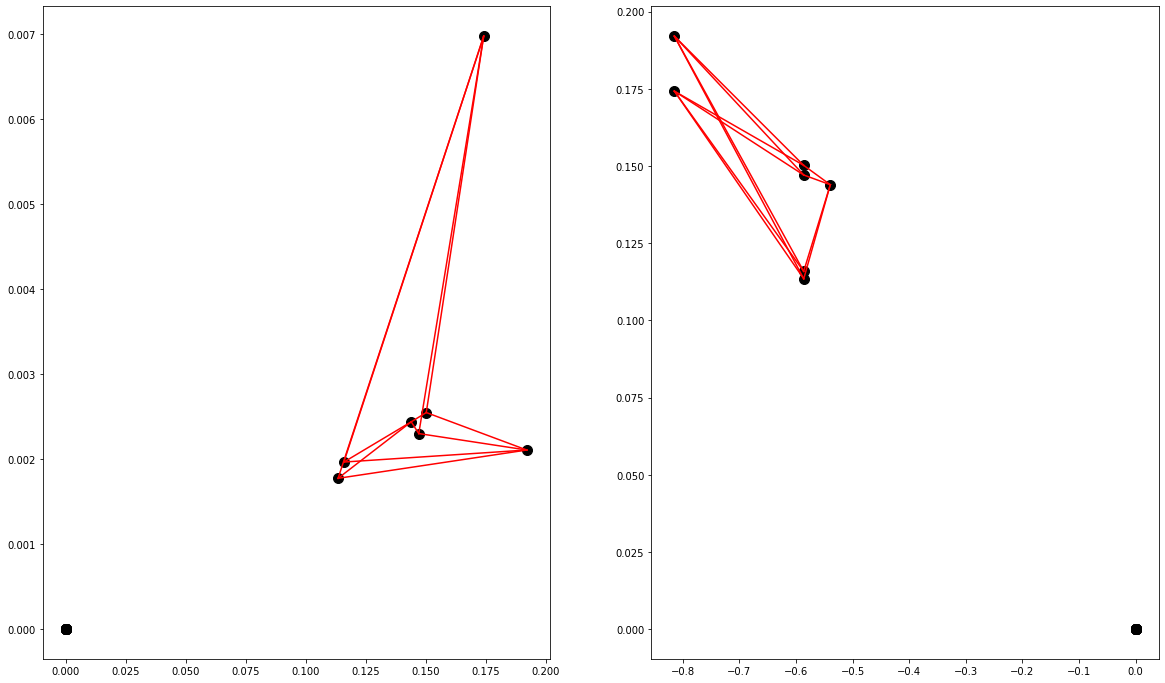

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.4366416  0.42073753 0.1487489  0.14310946 0.09181094 0.15300447
 0.14423692 0.1599071  0.15081911 0.22079428 0.20909844 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


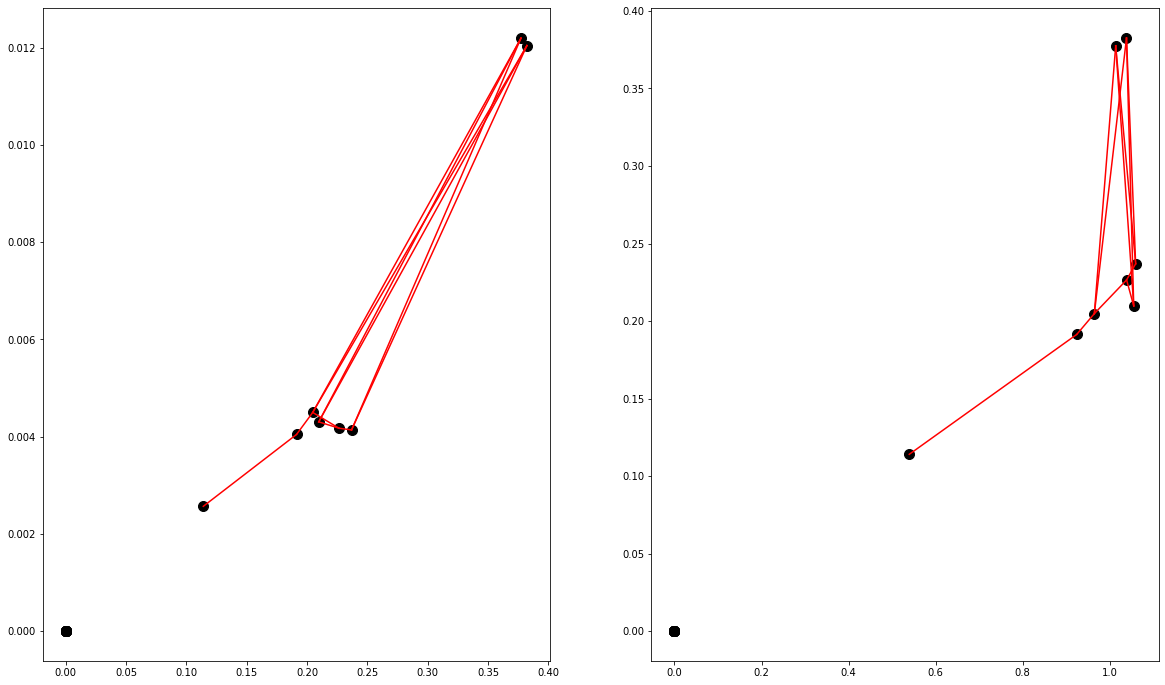

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04988896 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


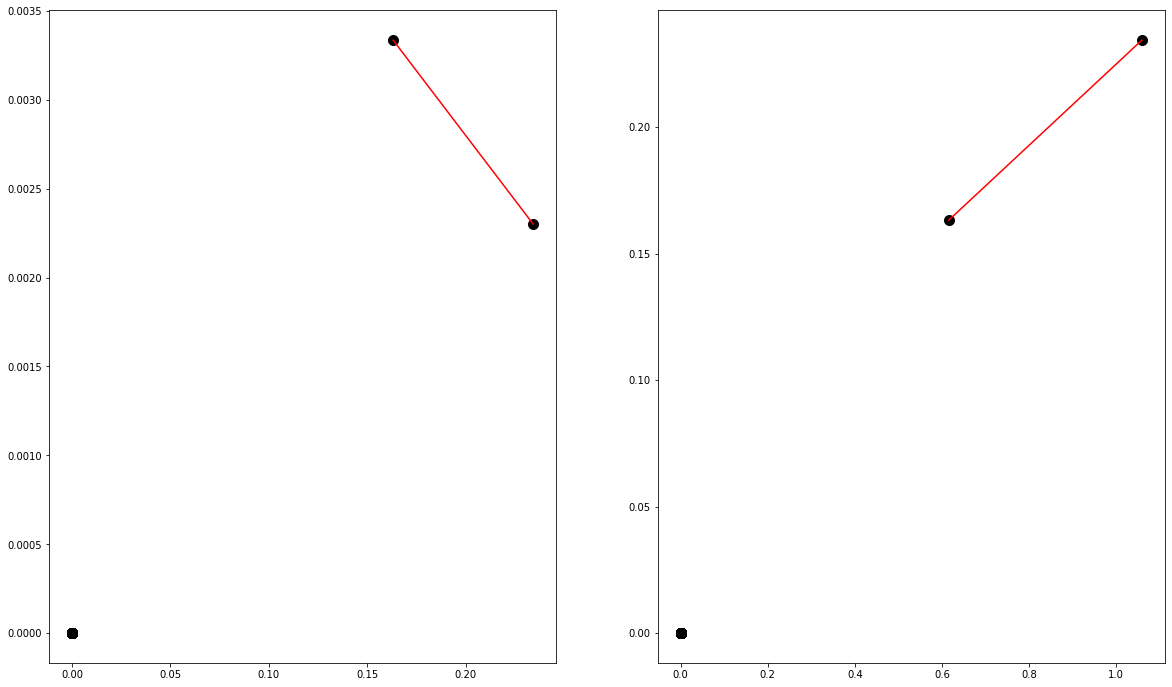

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [1.9028682e-04 1.6975420e-04 1.6931191e-04 1.5200578e-04 7.3587551e-05
 5.4336913e-05 4.7583533e-05 3.9234004e-05 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


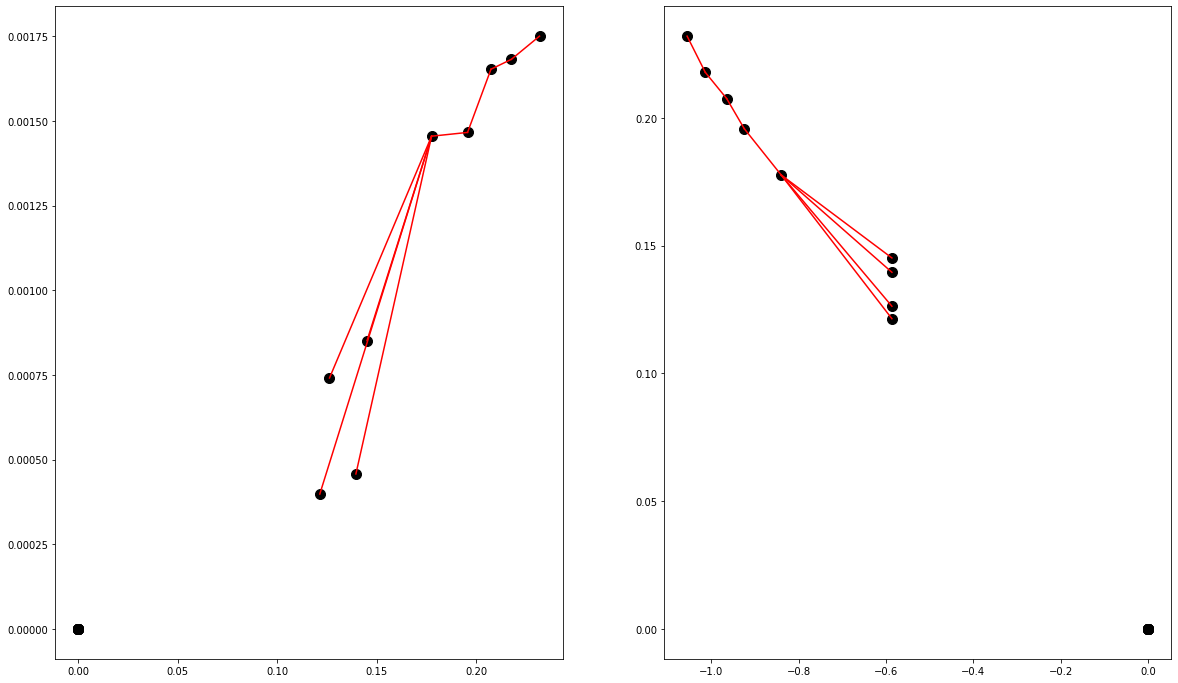

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.09326854 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


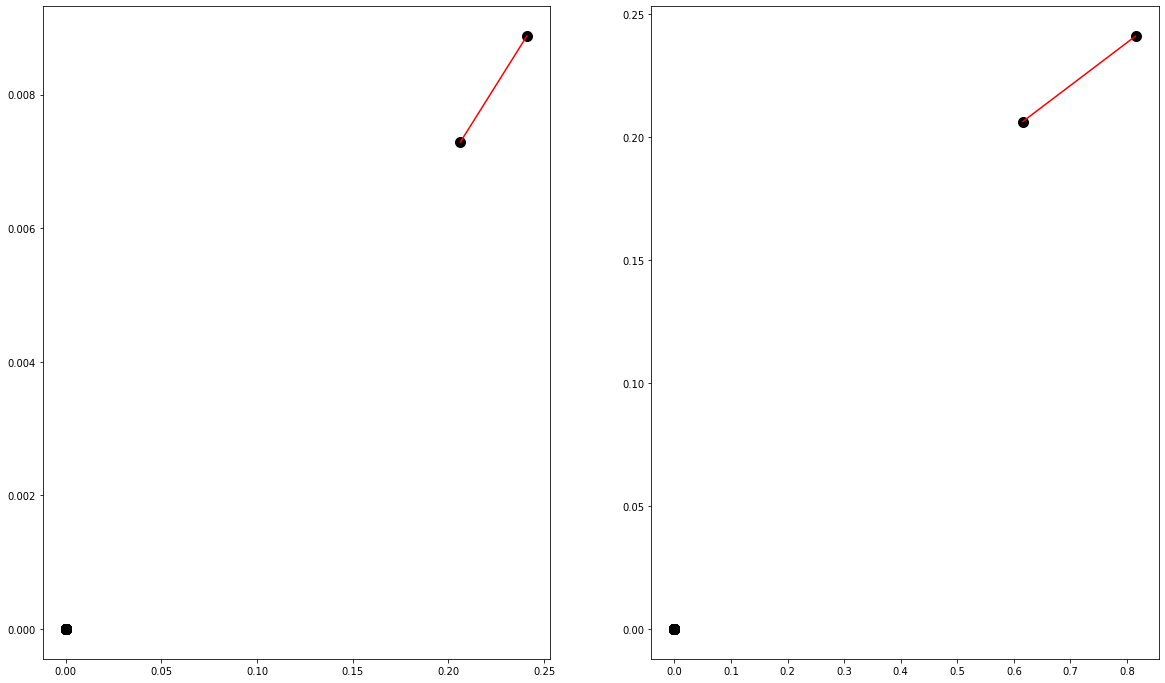

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00038554 0.00044702 0.00030653 0.00063424 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


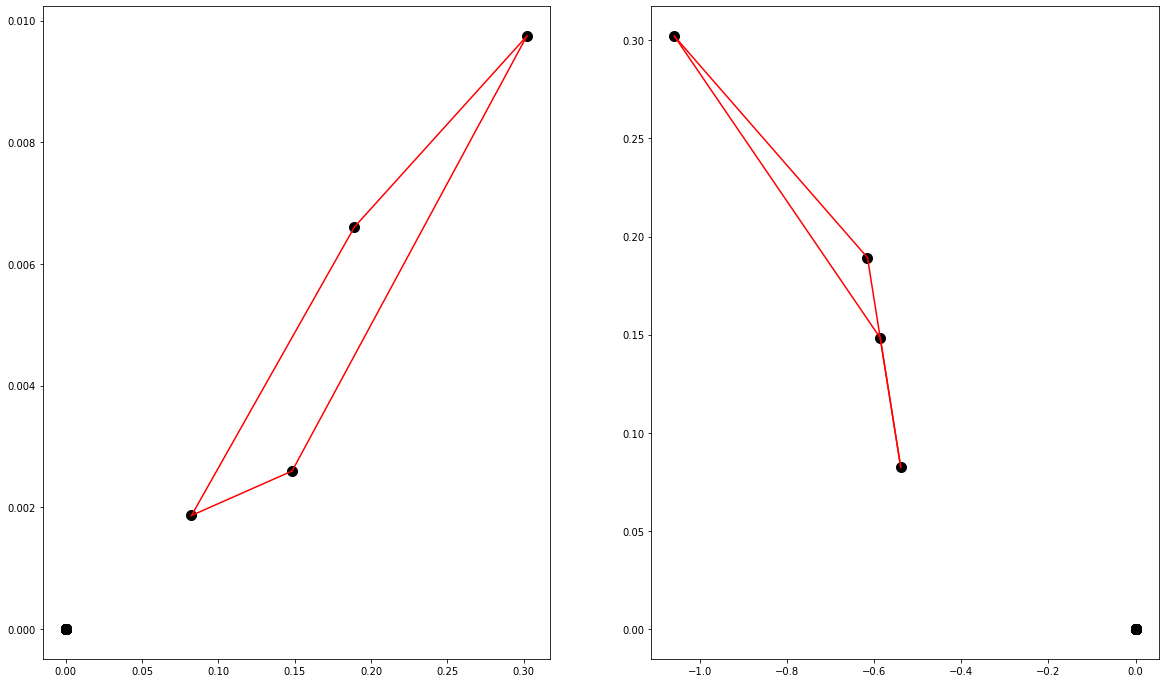

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [2.1925673e-04 8.1983329e-05 8.3905499e-05 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


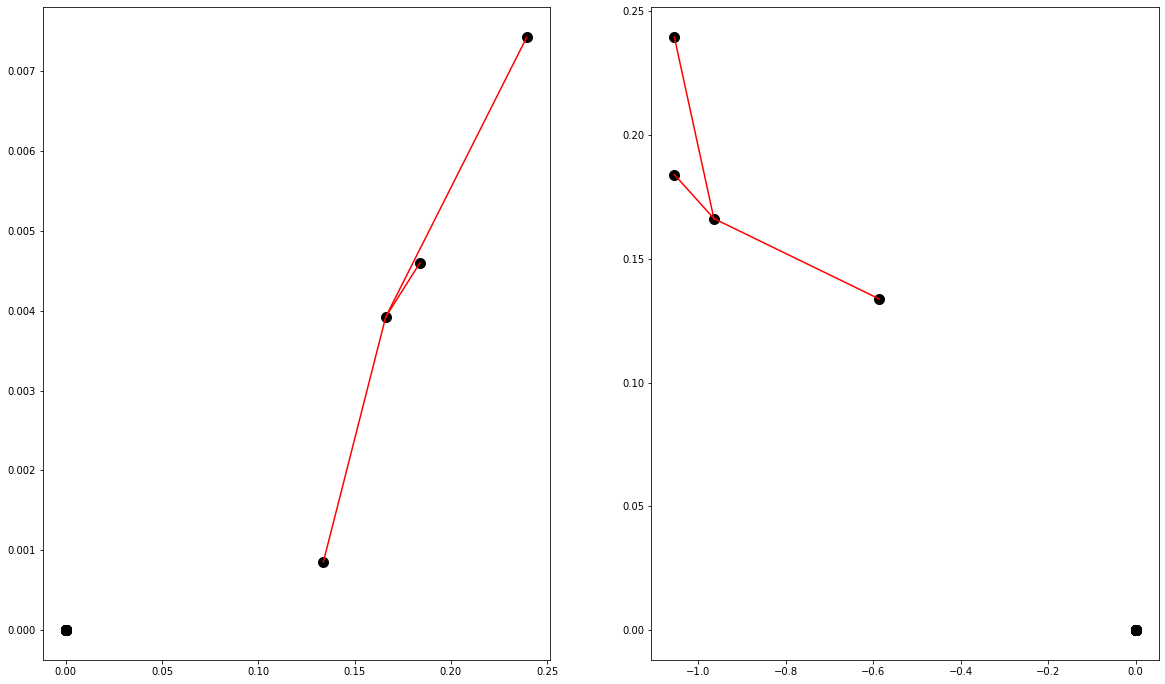

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00038007 0.00016087 0.00012893 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


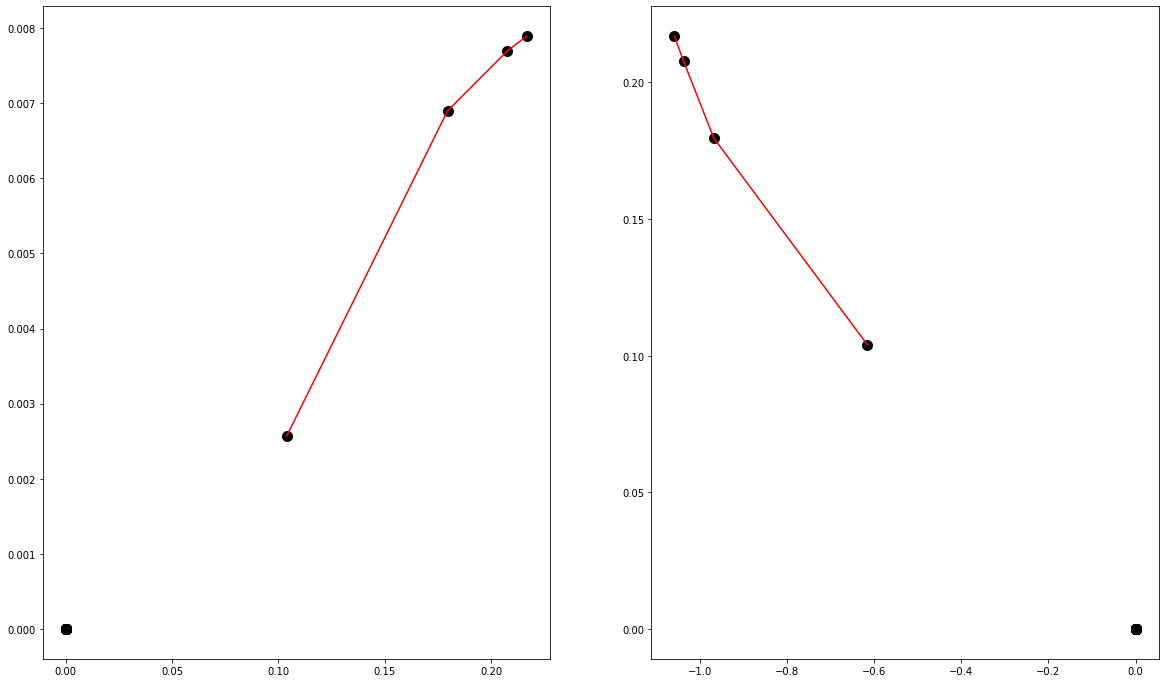

Y = [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.29952243 0.3167922  0.61530393 0.71908957 0.737655   0.70607436
 0.6025054  0.4579933  0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.939, precision 1.000, recall 0.625


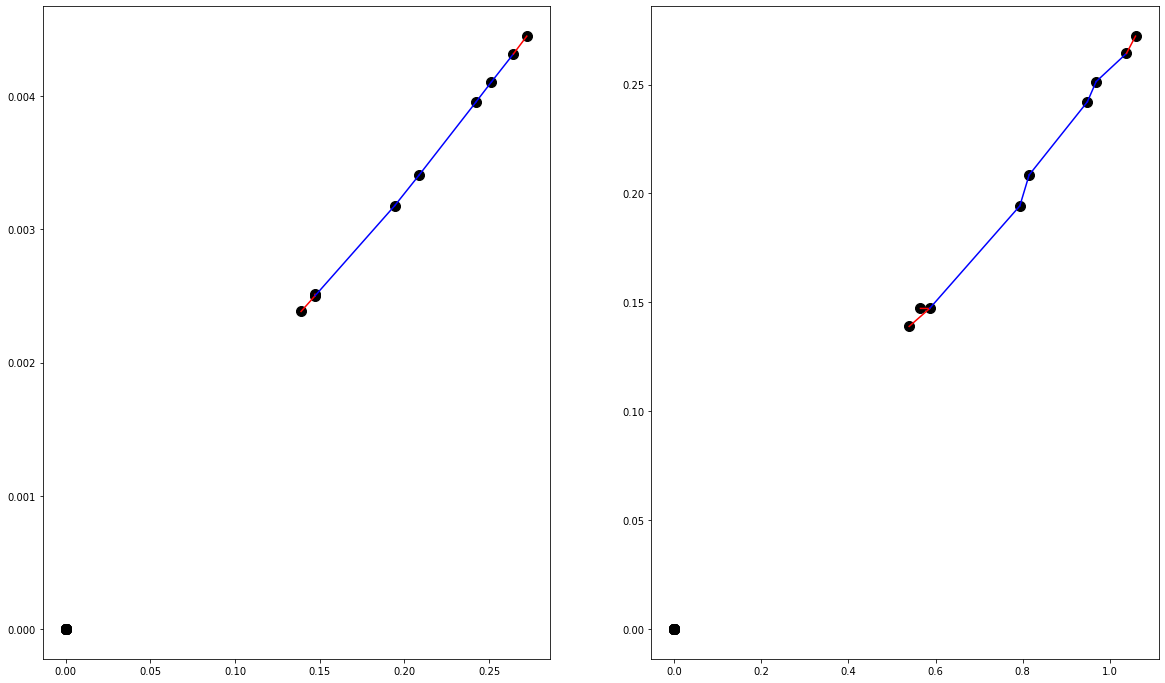

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.3147589  0.300201   0.27947837 0.47650653 0.45342886 0.33754784
 0.38619745 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


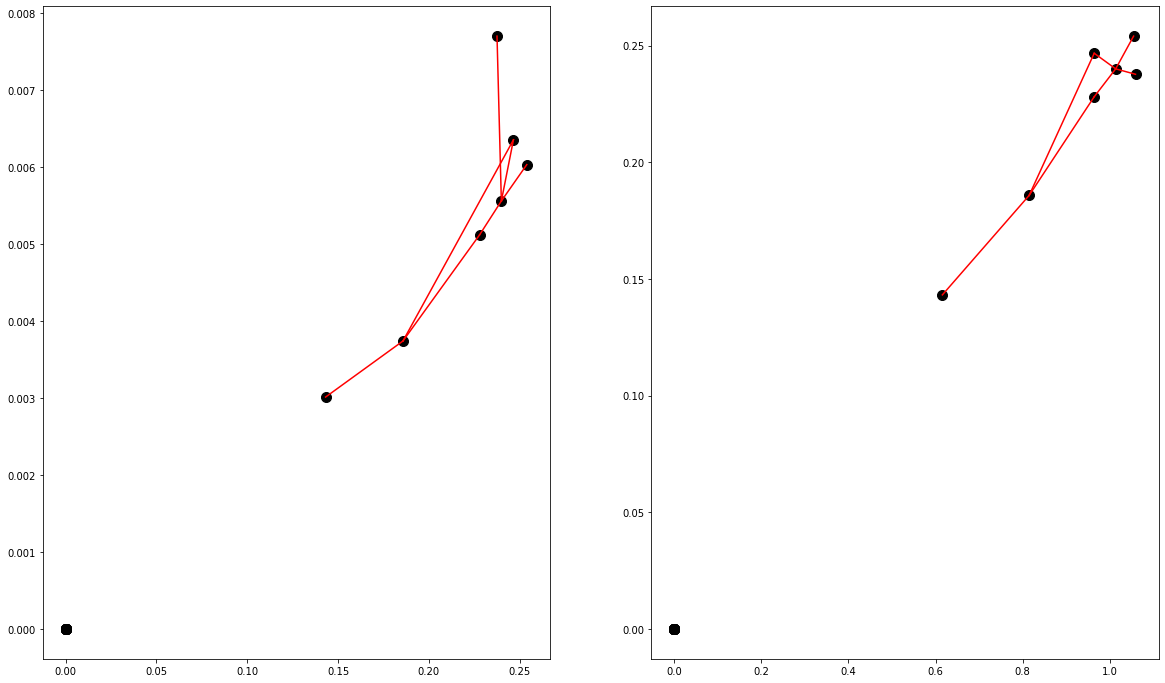

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00106823 0.00108616 0.00049009 0.00051699 0.00012759 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


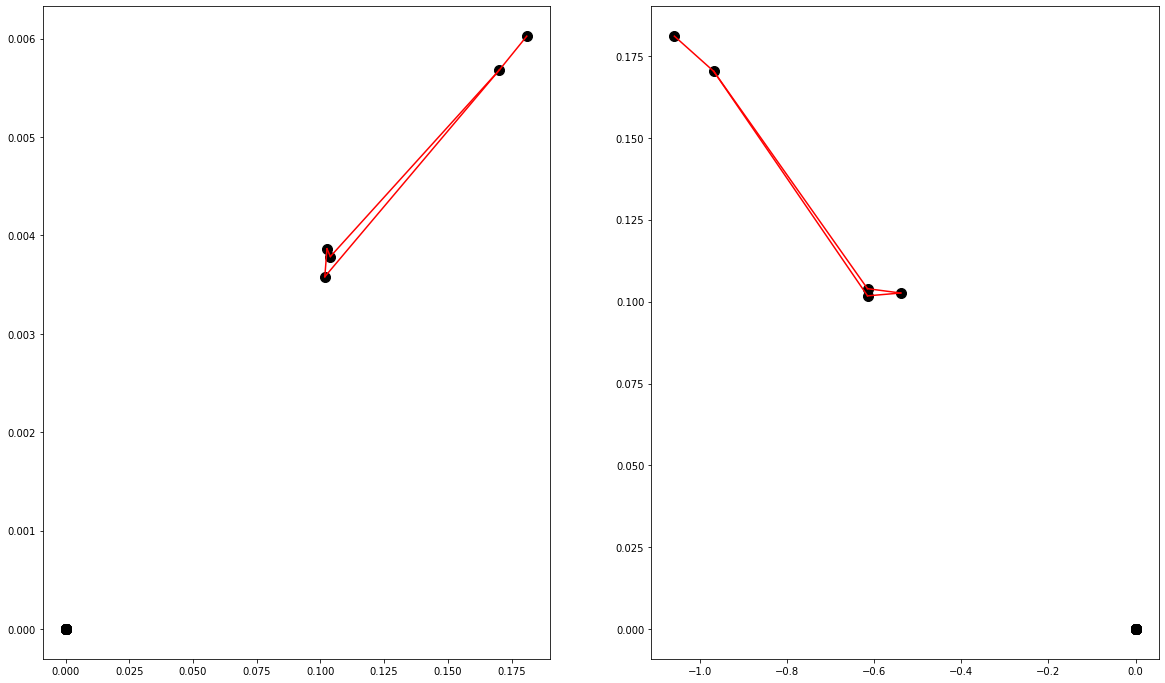

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [2.4810160e-04 2.2086859e-04 2.2006560e-04 1.9601101e-04 9.2620779e-05
 4.9935767e-05 4.5295896e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


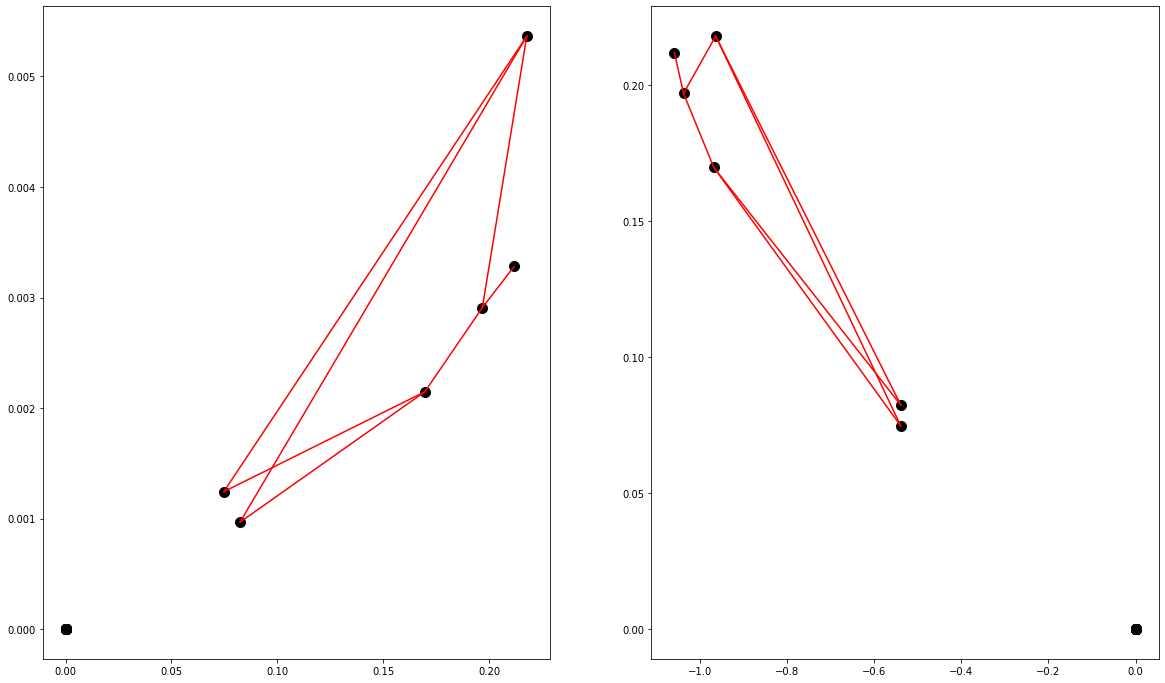

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.07979591 0.05651046 0.06549954 0.05626225 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


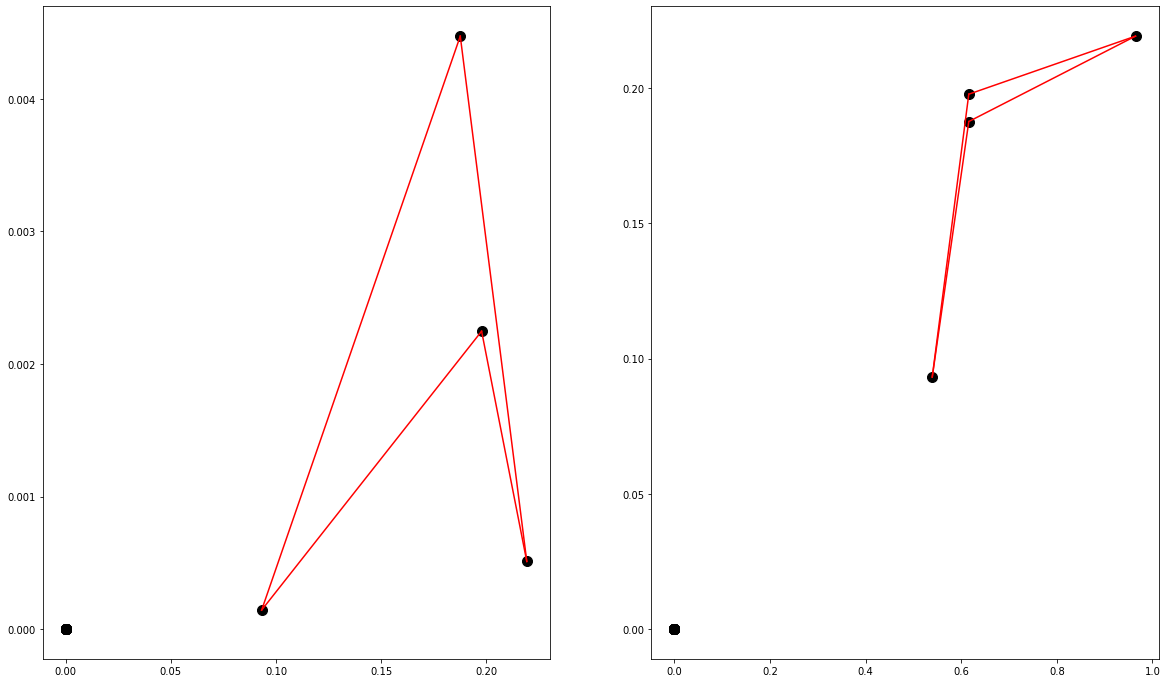

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.03066195 0.03009219 0.04704905 0.03260602 0.03199989 0.04996856
 0.04390907 0.04713305 0.04152741 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


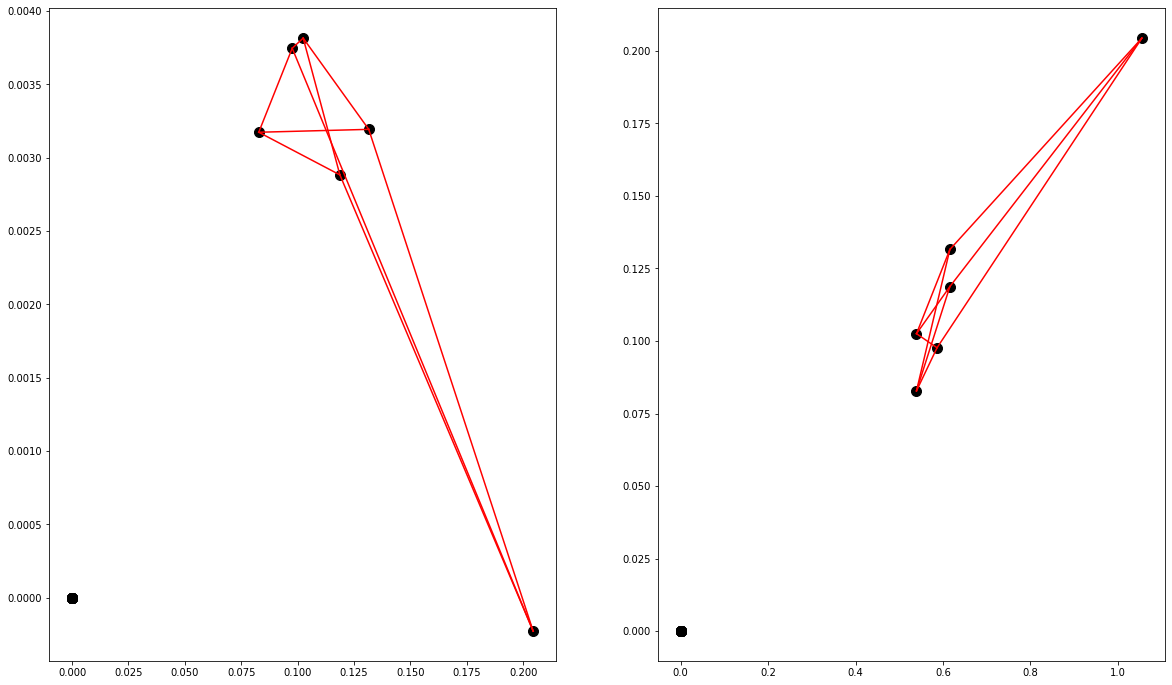

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [2.5204828e-04 2.4671672e-04 3.3185424e-04 3.2476080e-04 1.3903553e-04
 1.2762038e-04 9.5697847e-05 8.2388666e-05 7.1186201e-05 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


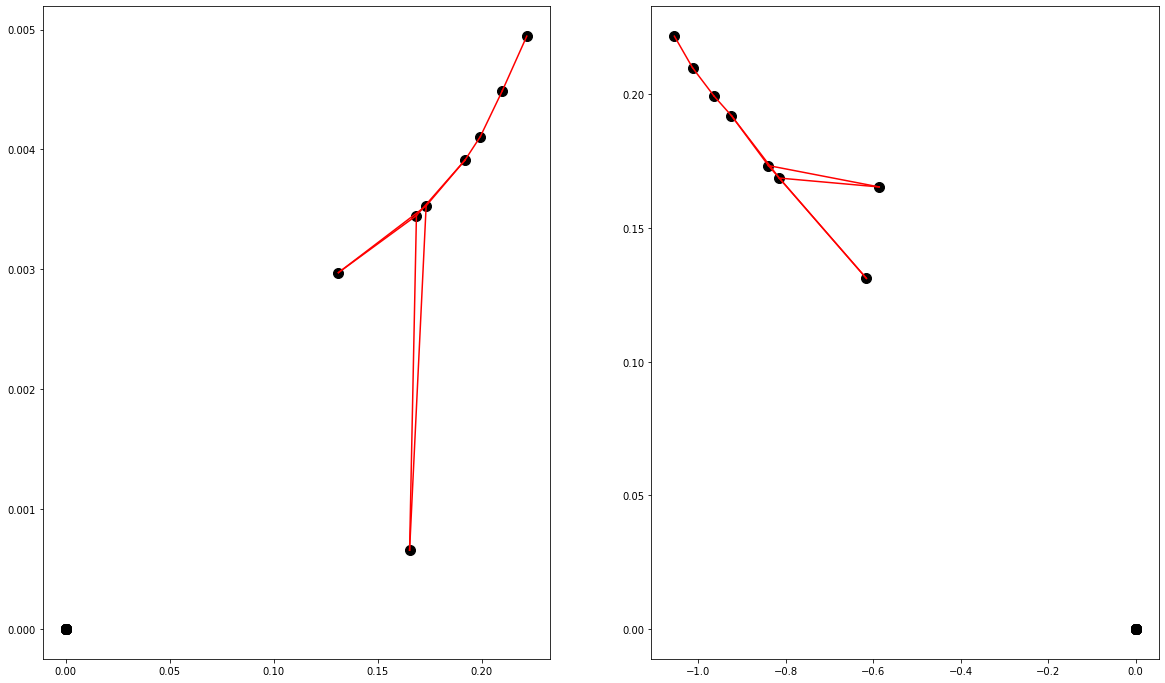

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.10408919 0.10274082 0.09171884 0.0904596  0.2833394  0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


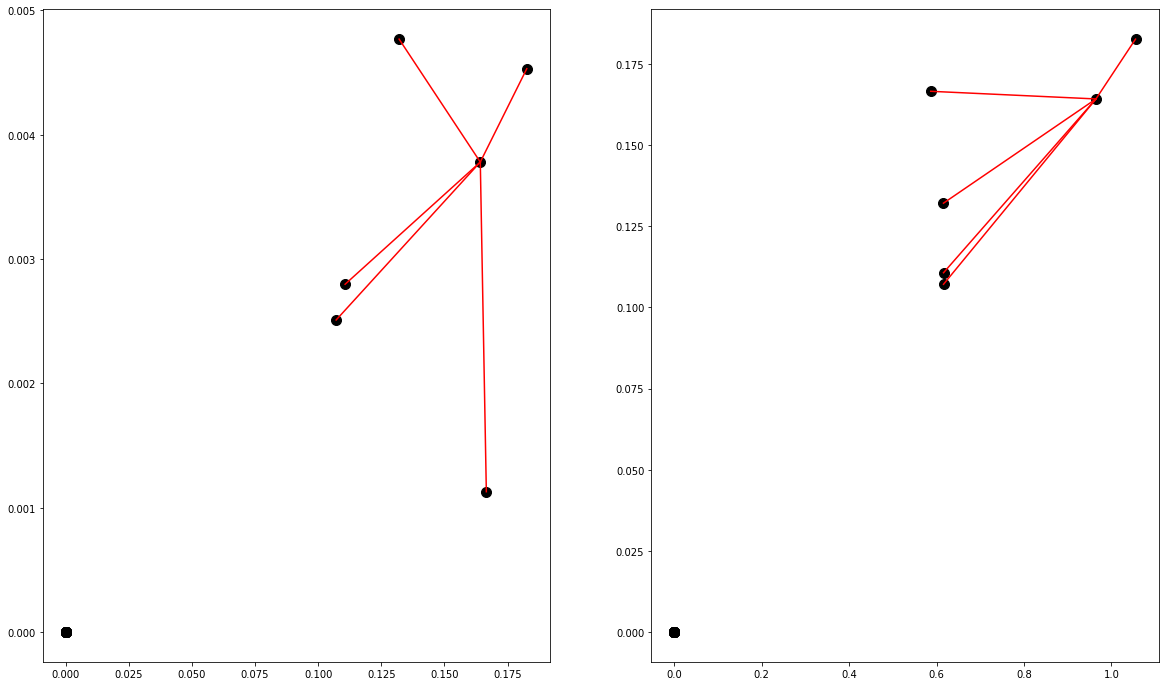

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.02177655 0.05092437 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


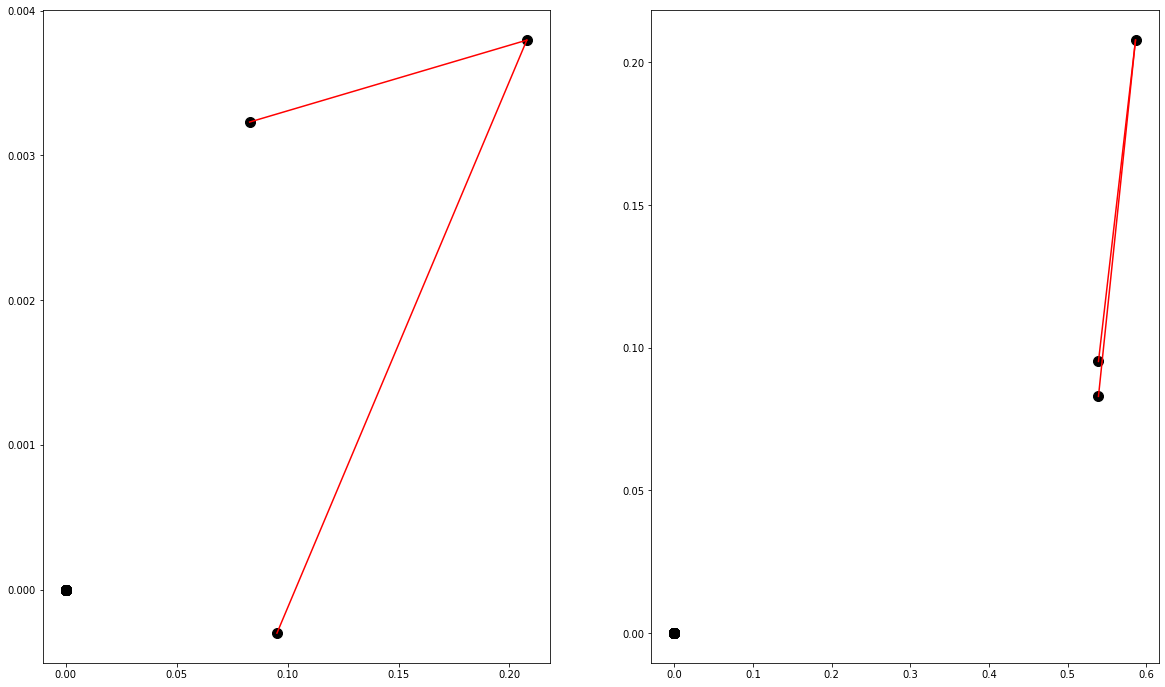

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [3.1408534e-04 3.8295926e-04 8.2560437e-04 1.0050088e-03 1.3274845e-04
 1.2651992e-04 1.5395459e-04 1.4690259e-04 8.1961989e-05 8.4412699e-05
 8.2175480e-05 1.9960481e-04 2.0563295e-04 1.9892046e-04 7.7939454e-05
 7.7320292e-05 8.2596969e-05 8.1935104e-05 1.8259211e-04 1.8090438e-04
 1.6054780e-04 1.6542360e-04 1.5529050e-04 1.6005624e-04 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


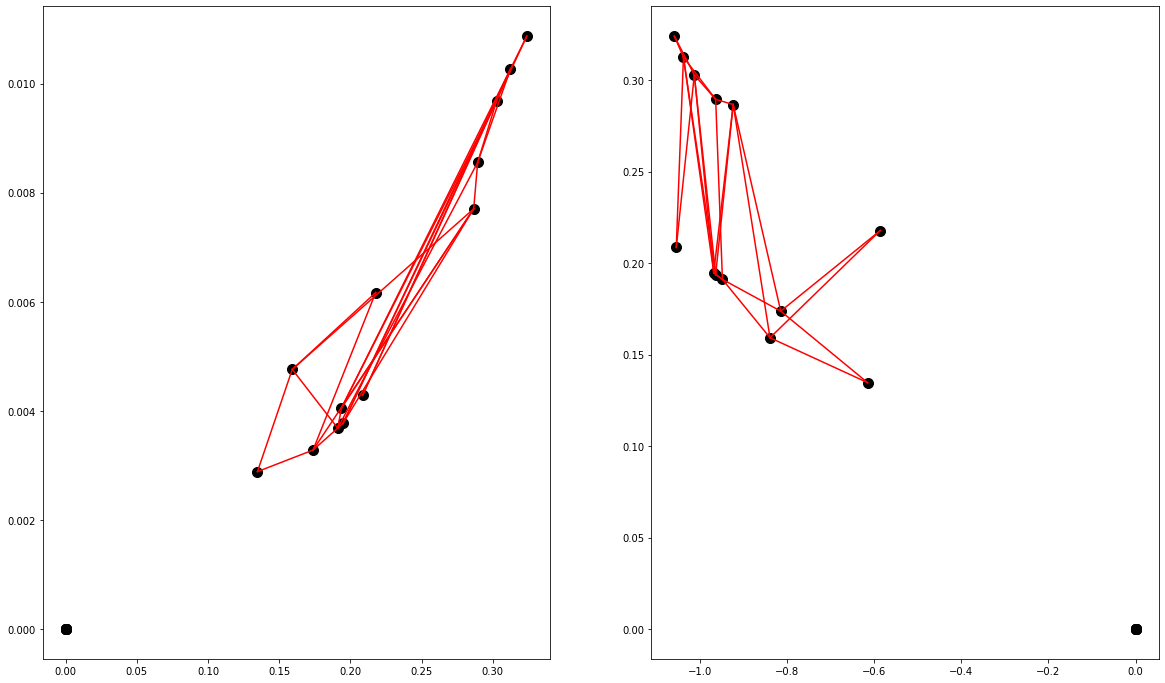

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1350562  0.13273896 0.13986728 0.13742591 0.09187648 0.09106538
 0.17043972 0.10446476 0.20270562 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


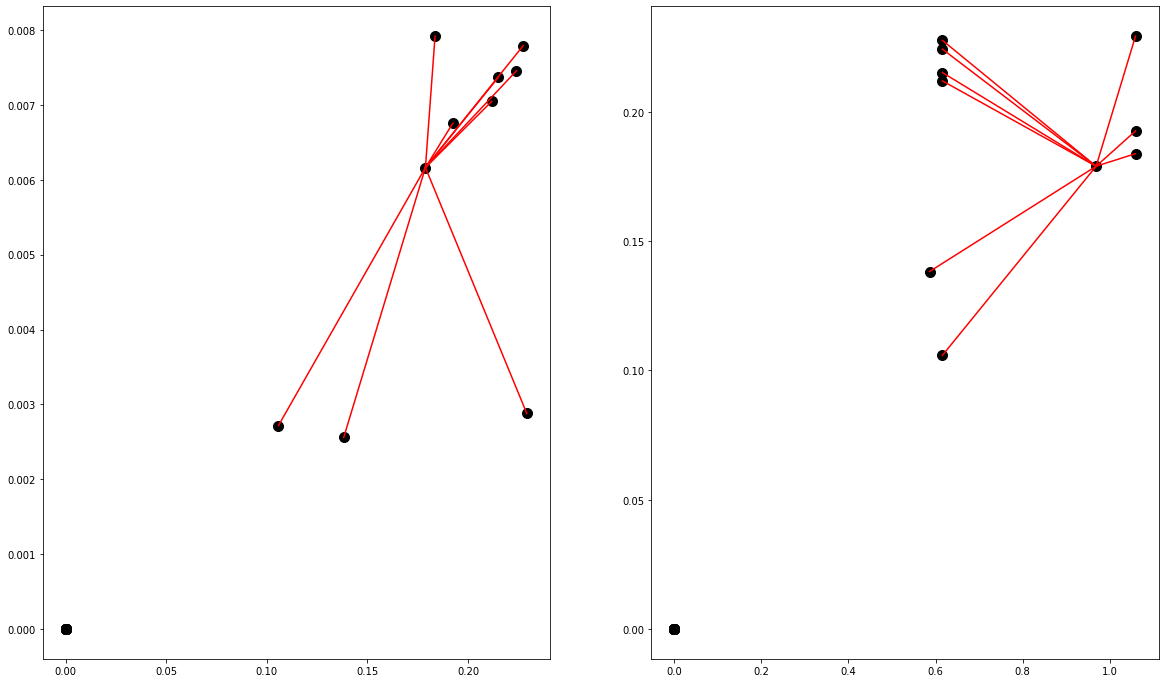

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0010089  0.00032727 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


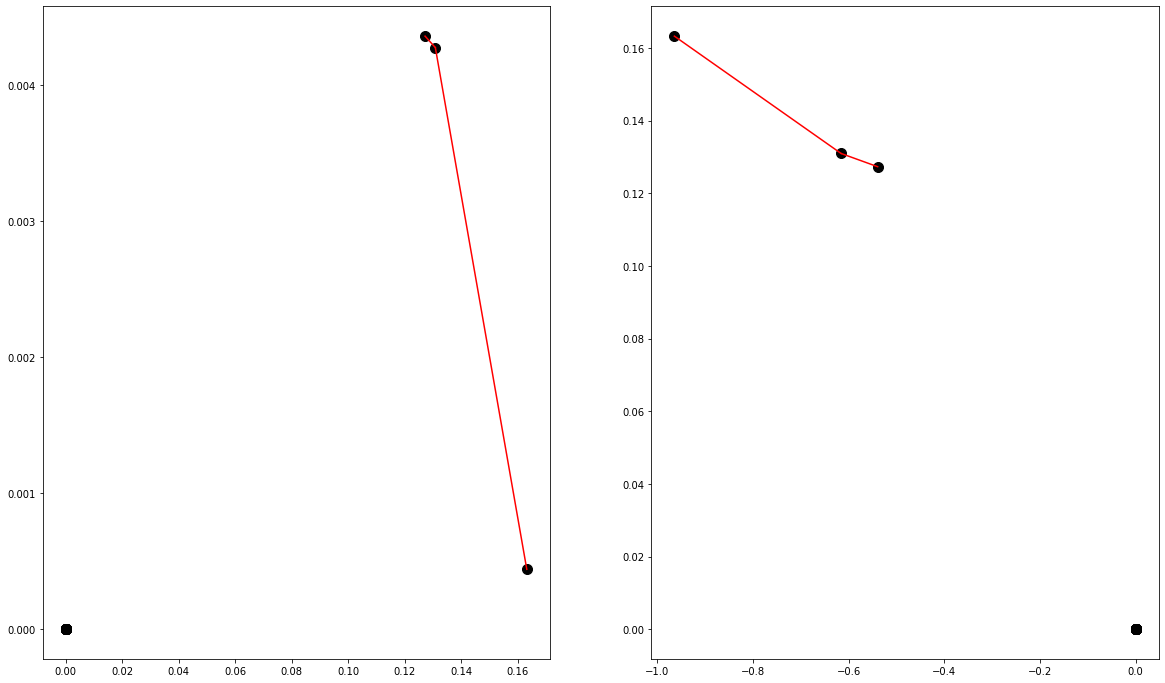

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.22627652 0.2440535  0.25170904 0.30918908 0.41506928 0.21394473
 0.2765021  0.2784195  0.19464225 0.41770774 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


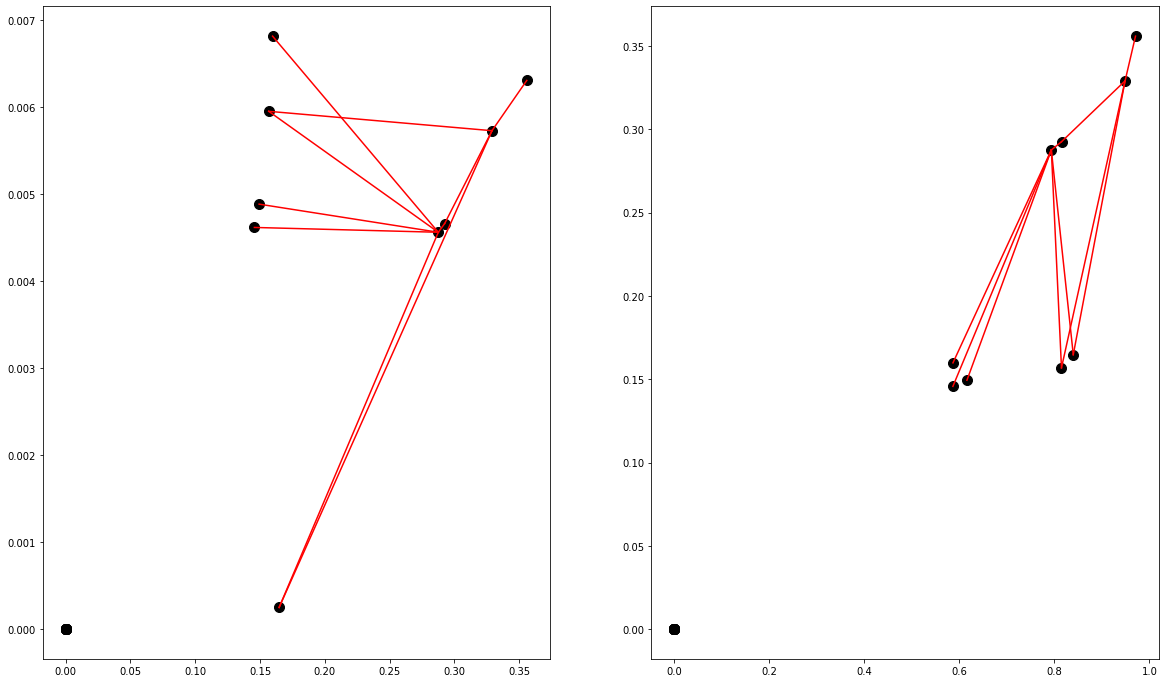

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.01797813 0.02904648 0.02861167 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


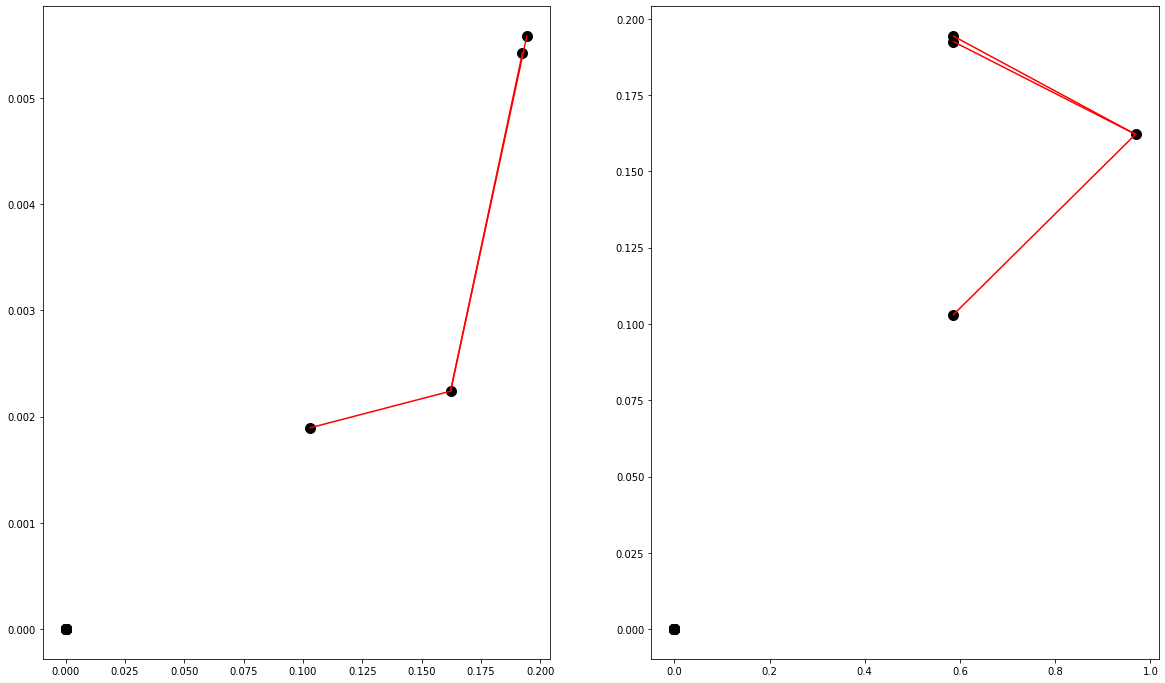

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.09326854 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


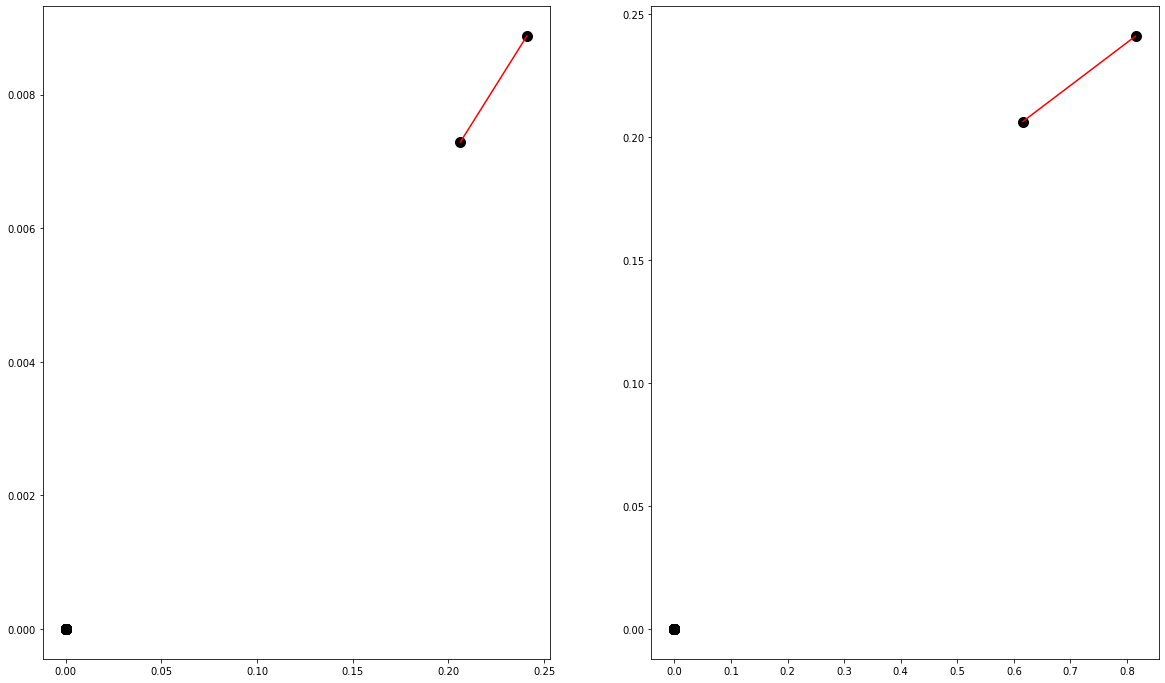

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00015879 0.00015759 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


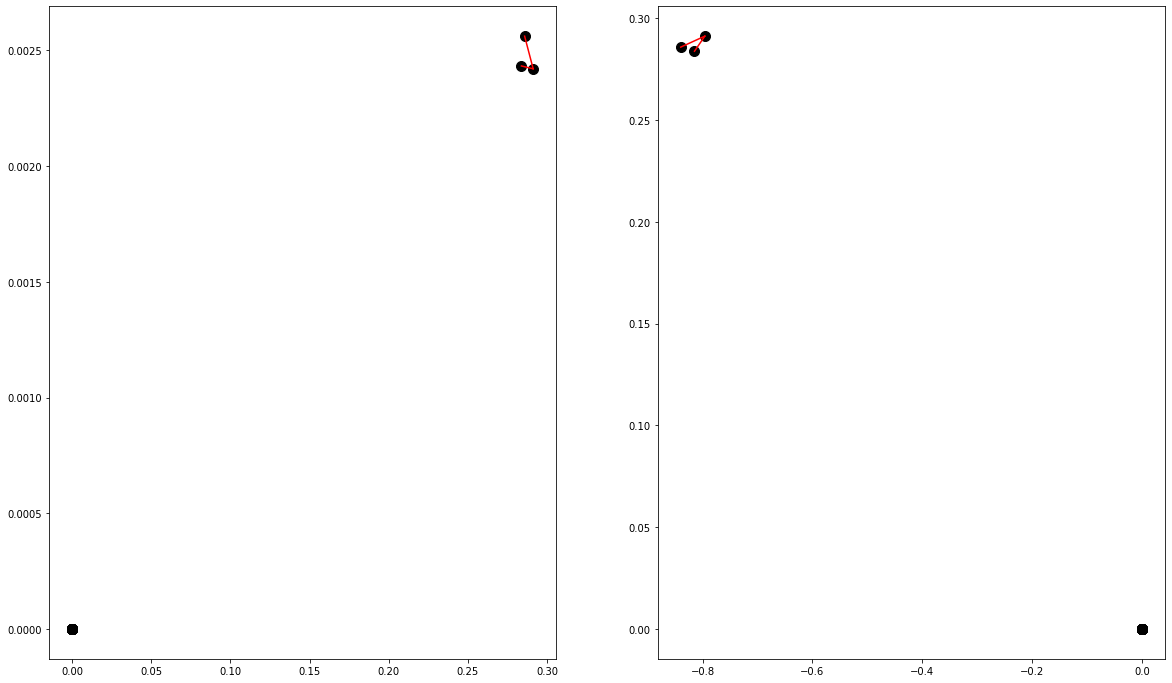

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.19339545 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


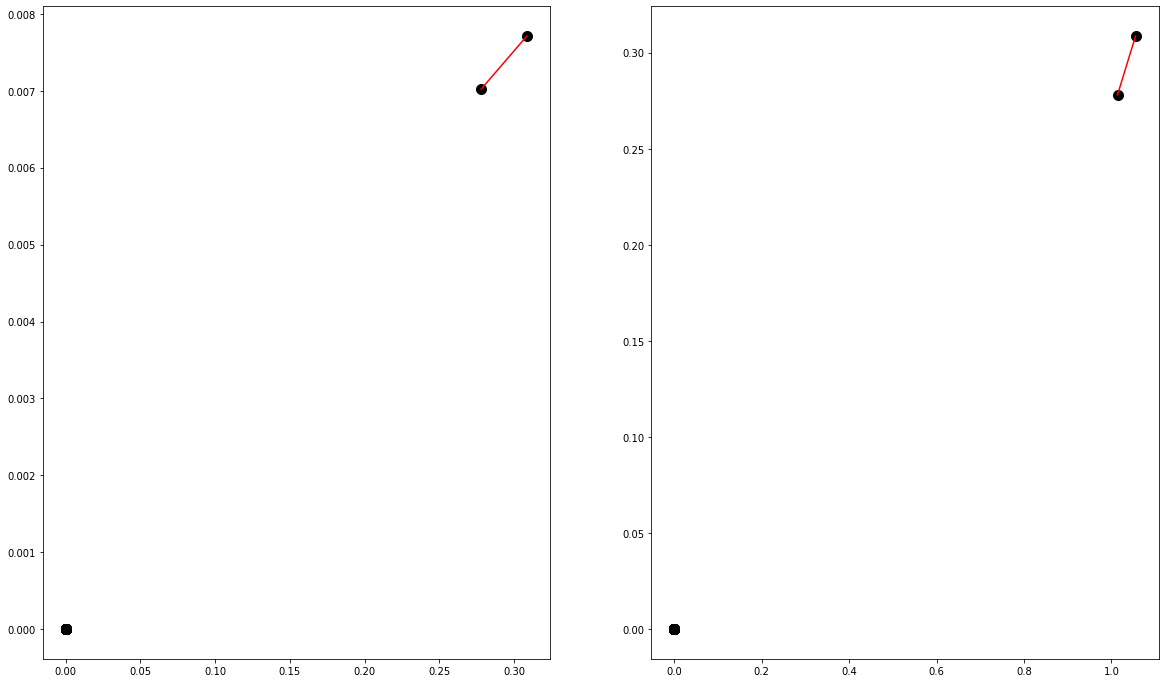

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.24769741 0.23485303 0.34890795 0.32932127 0.48513478 0.3890933
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


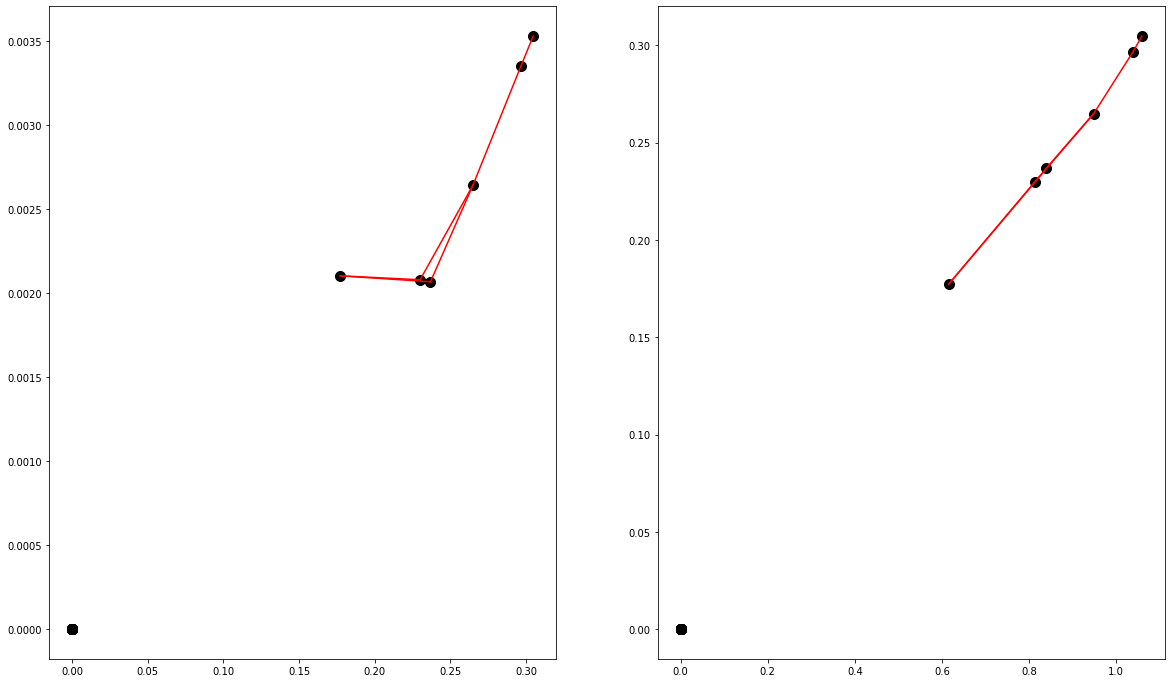

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00066167 0.00069367 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


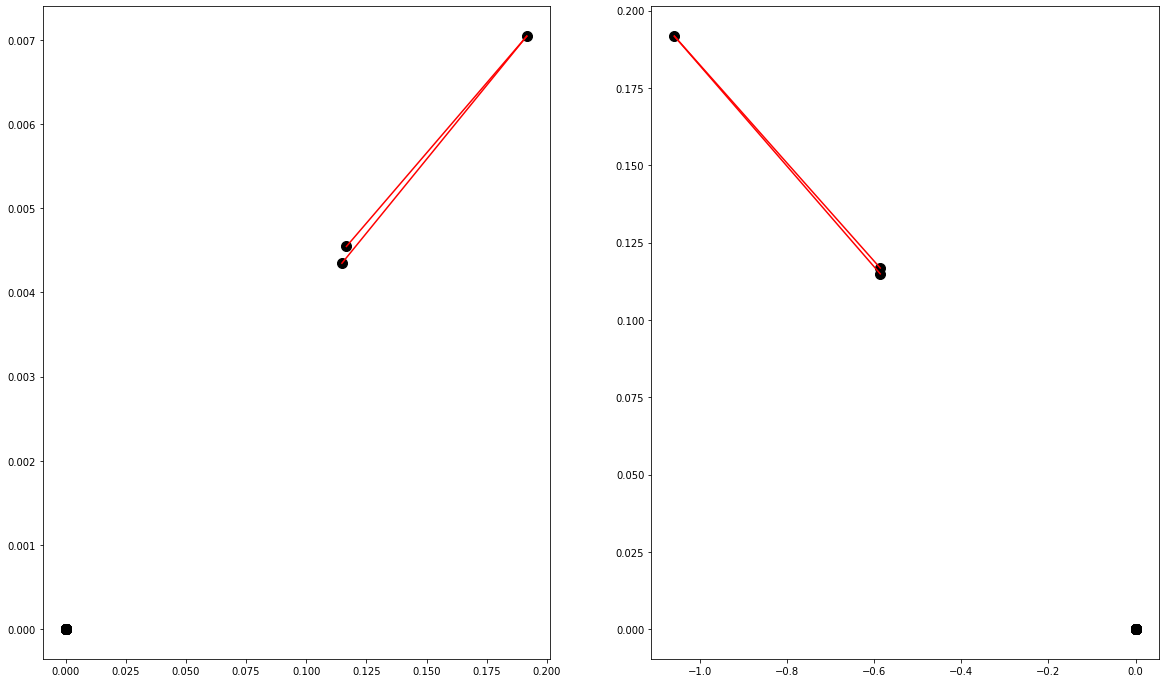

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0402184  0.04989299 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


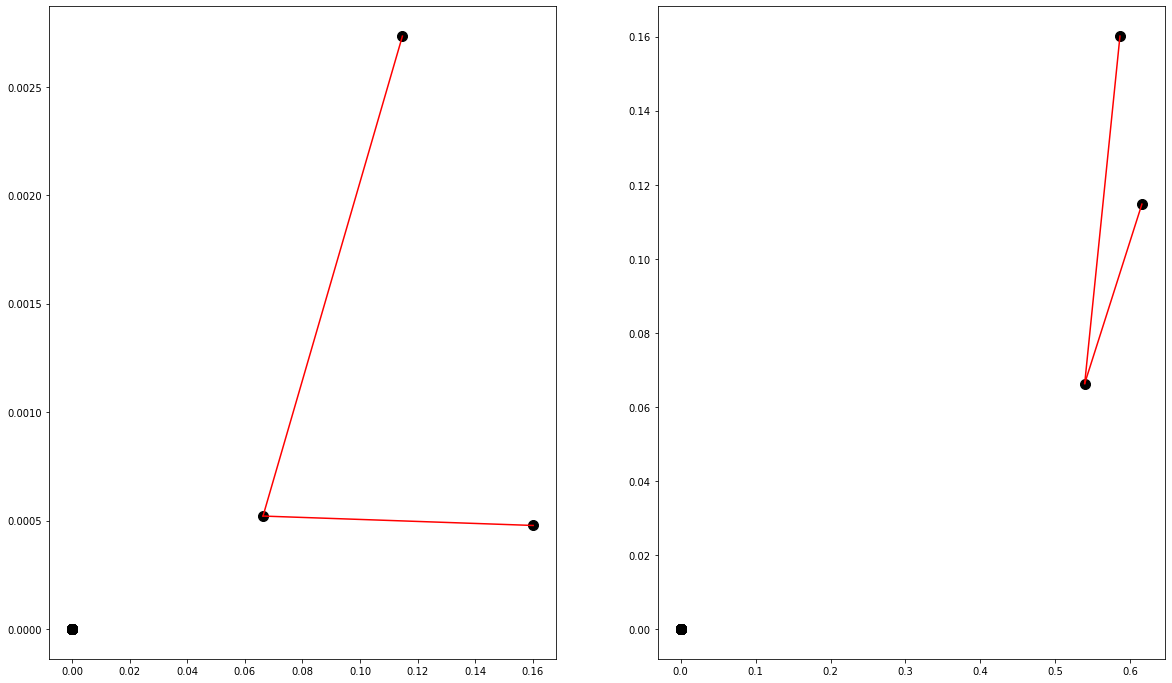

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00073289 0.00105236 0.00044553 0.0008895  0.00024547 0.00021321
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


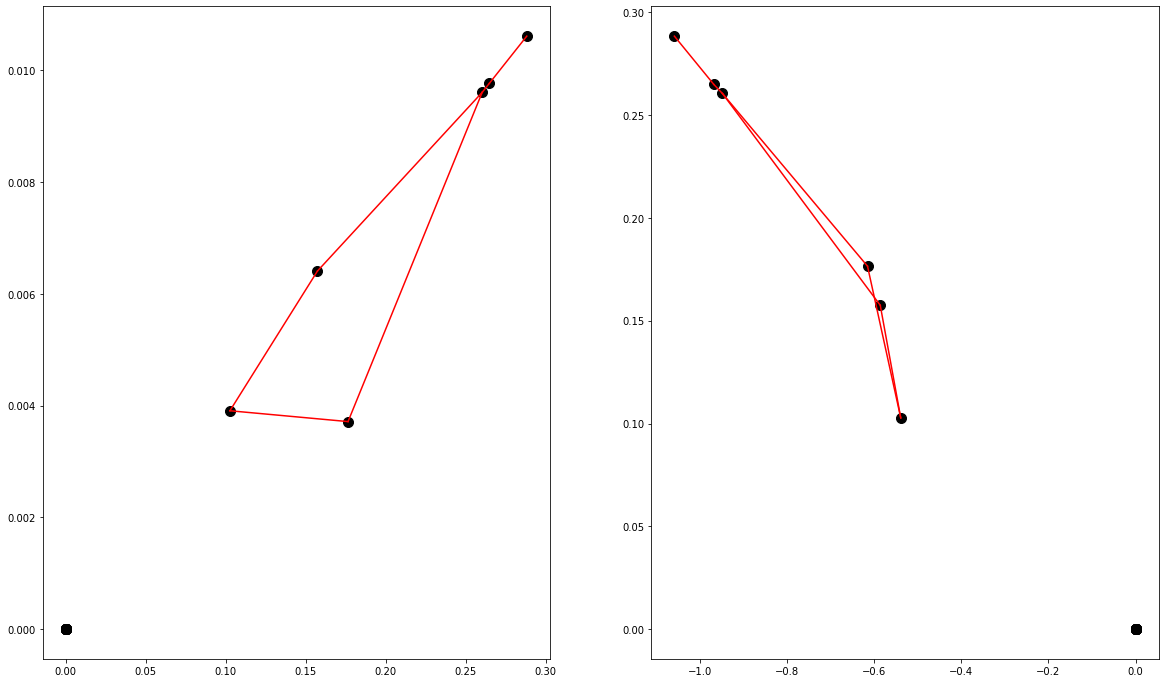

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00039203 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


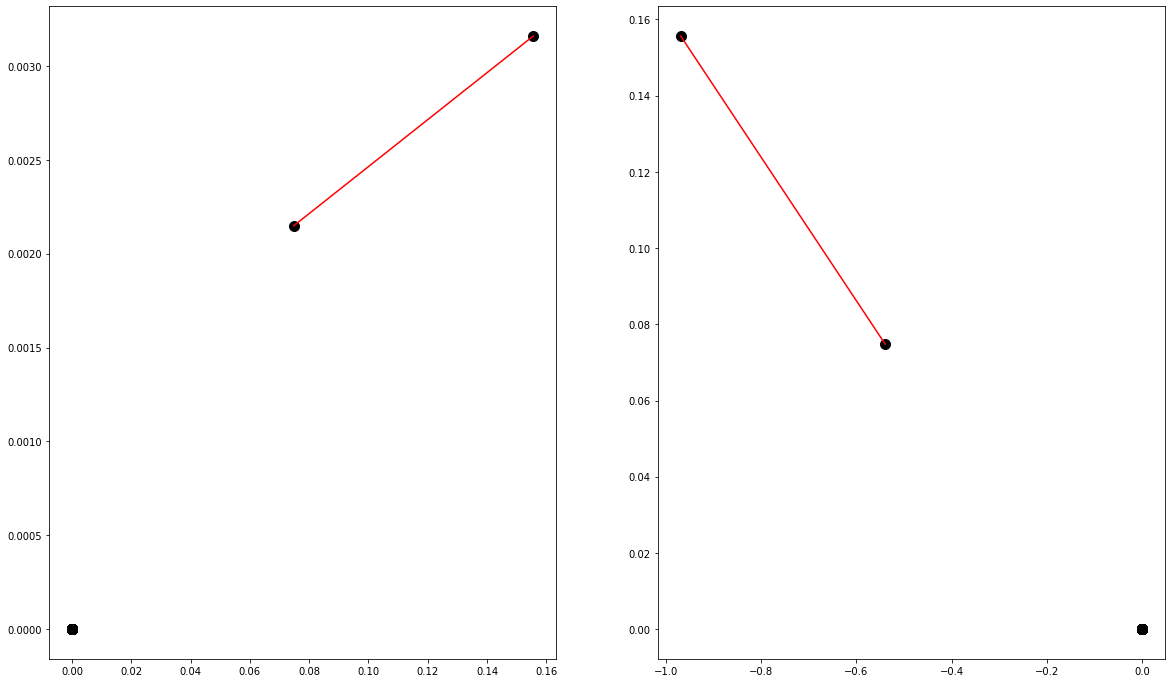

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00023831 0.00047096 0.00033905 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


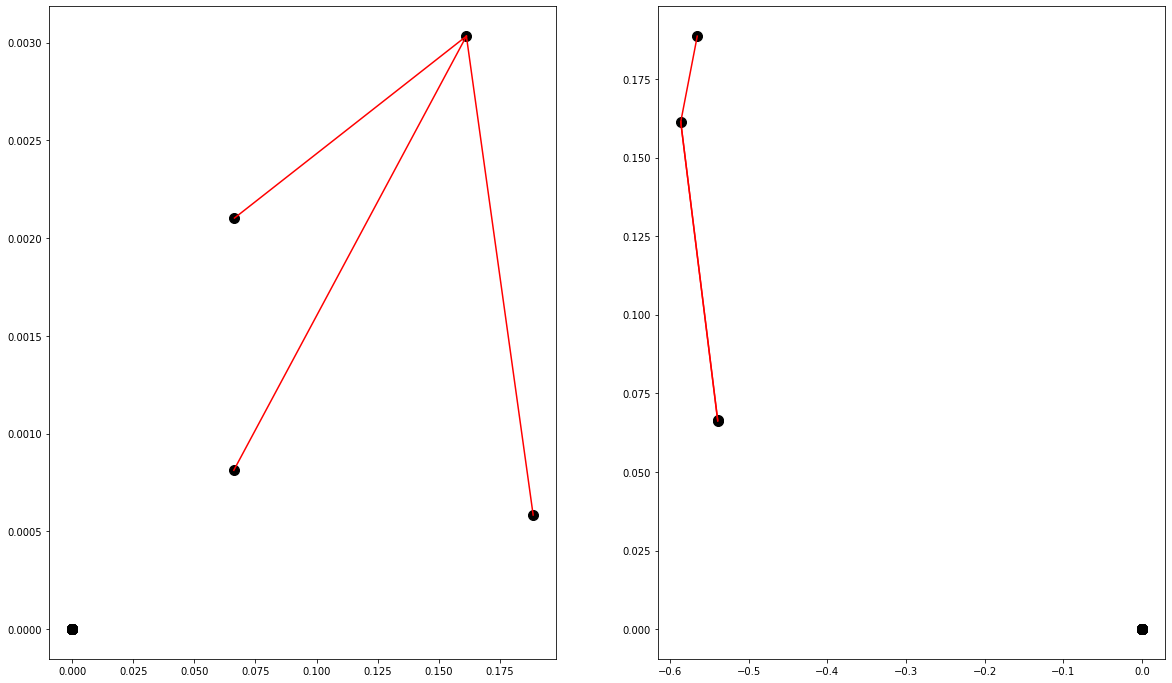

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0006078  0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


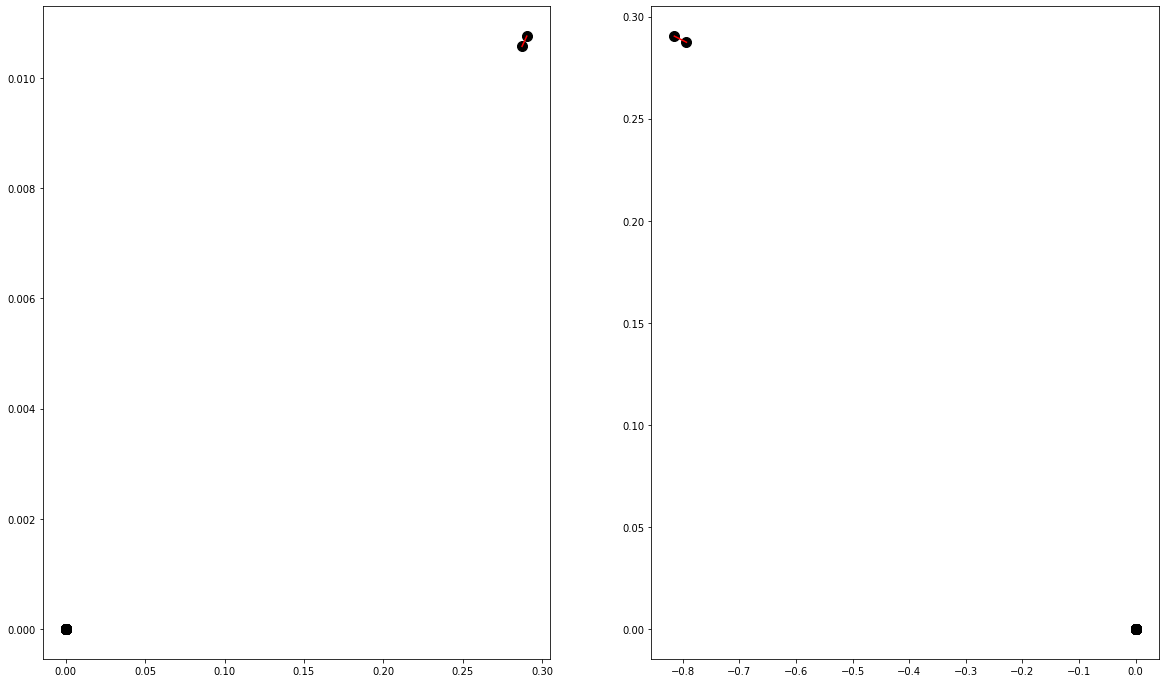

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [1.1332413e-03 5.9204968e-04 7.1211200e-04 8.2374748e-04 4.3094289e-04
 1.8065840e-04 3.2068603e-04 2.1575719e-04 7.1917166e-05 5.7222016e-05
 5.3245312e-05 4.6690115e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


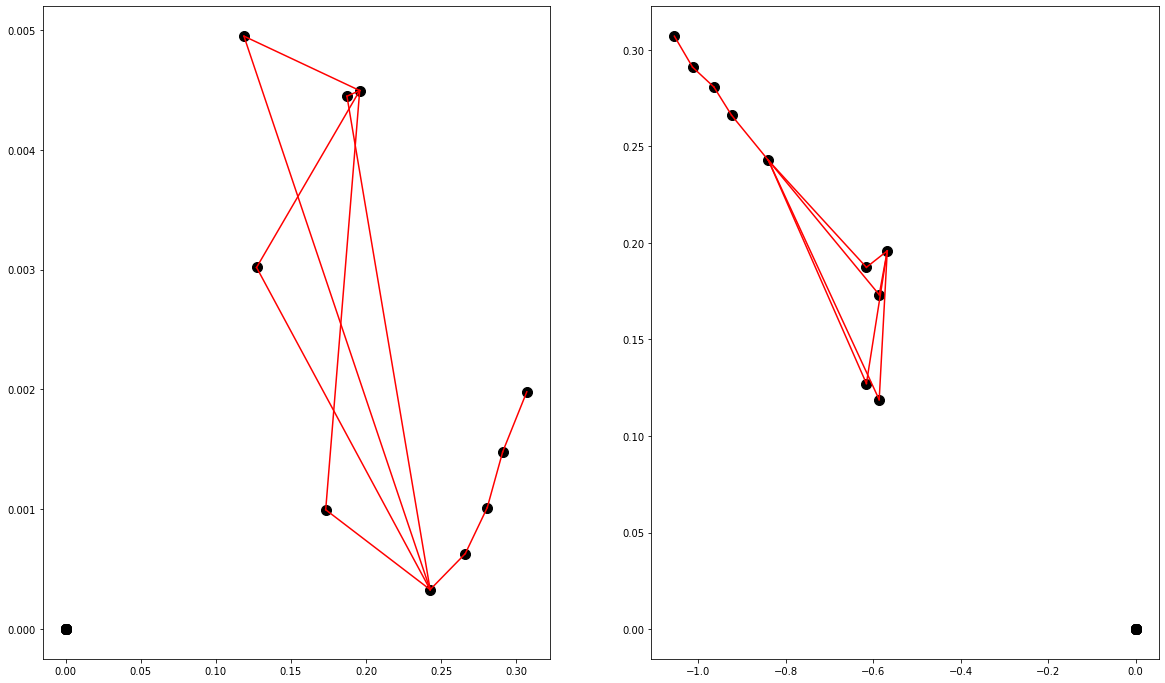

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04783389 0.04874035 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


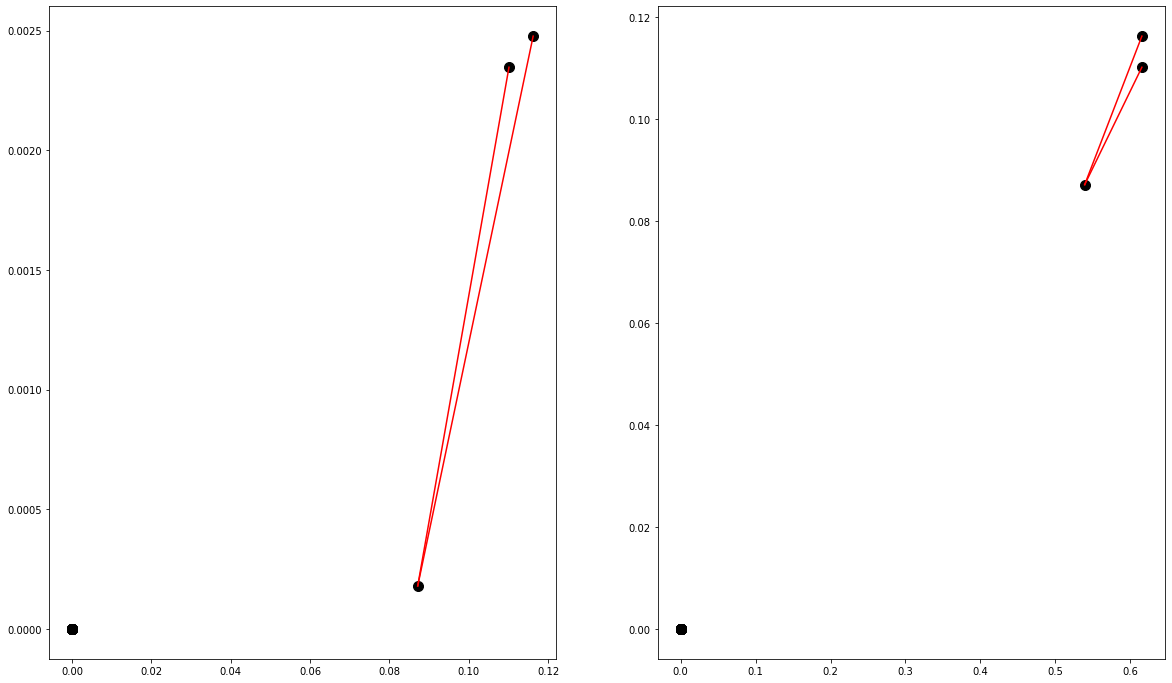

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00019518 0.00023276 0.00043022 0.00046737 0.00041837 0.00022788
 0.00011987 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


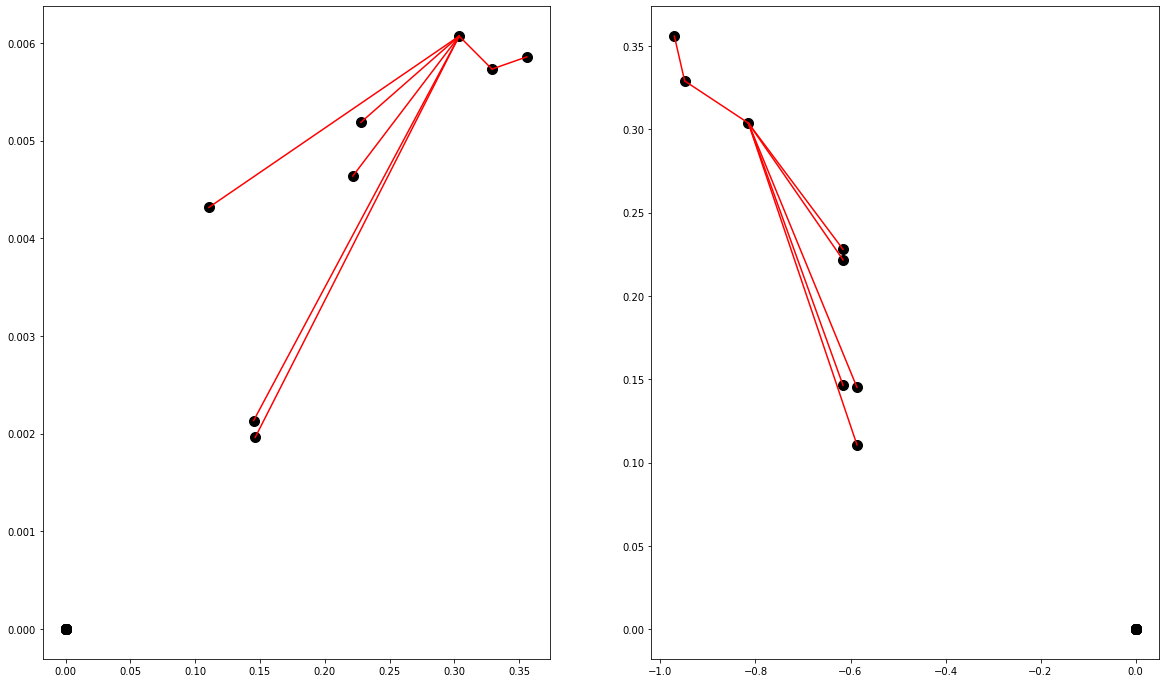

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04931383 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


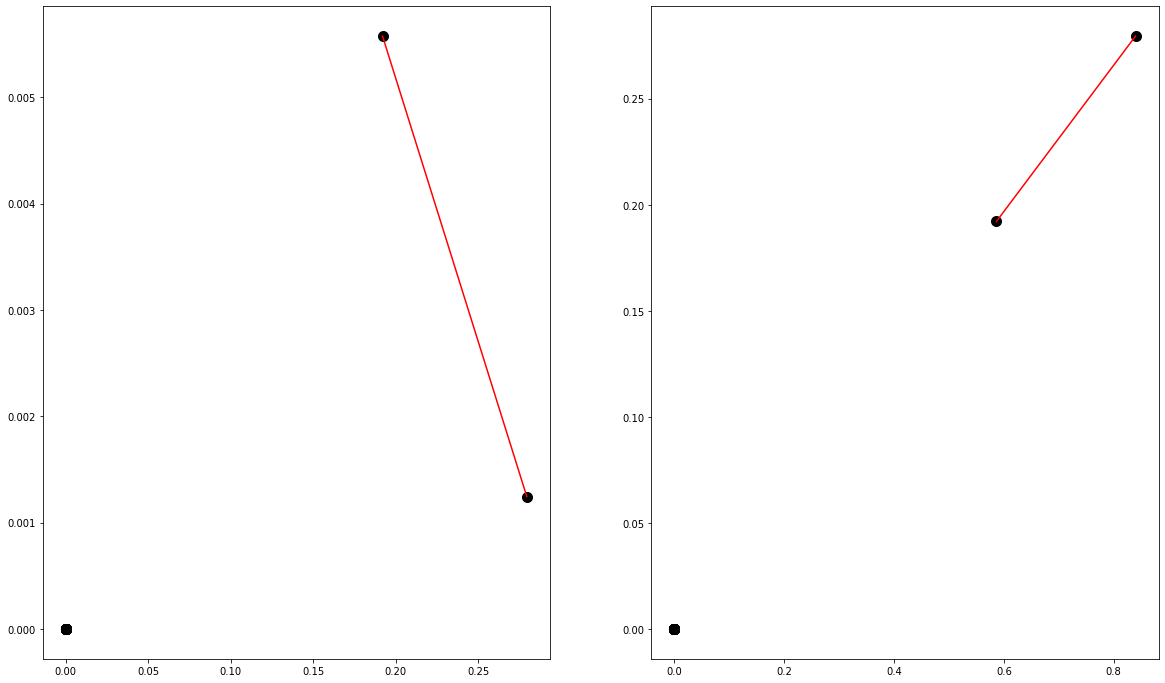

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20589271 0.21078621 0.10837261 0.28619856 0.20259348 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


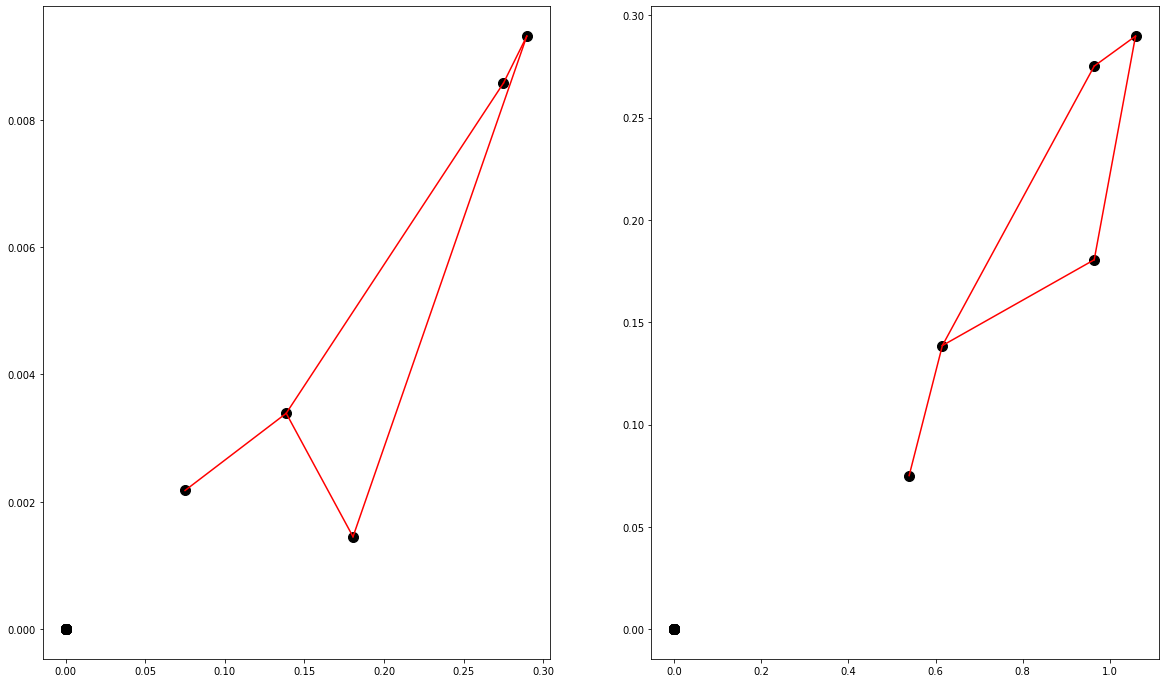

Y = [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.30504915 0.45924965 0.5877605  0.6204934  0.7164022  0.65452933
 0.46912464 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.980, precision 1.000, recall 0.800


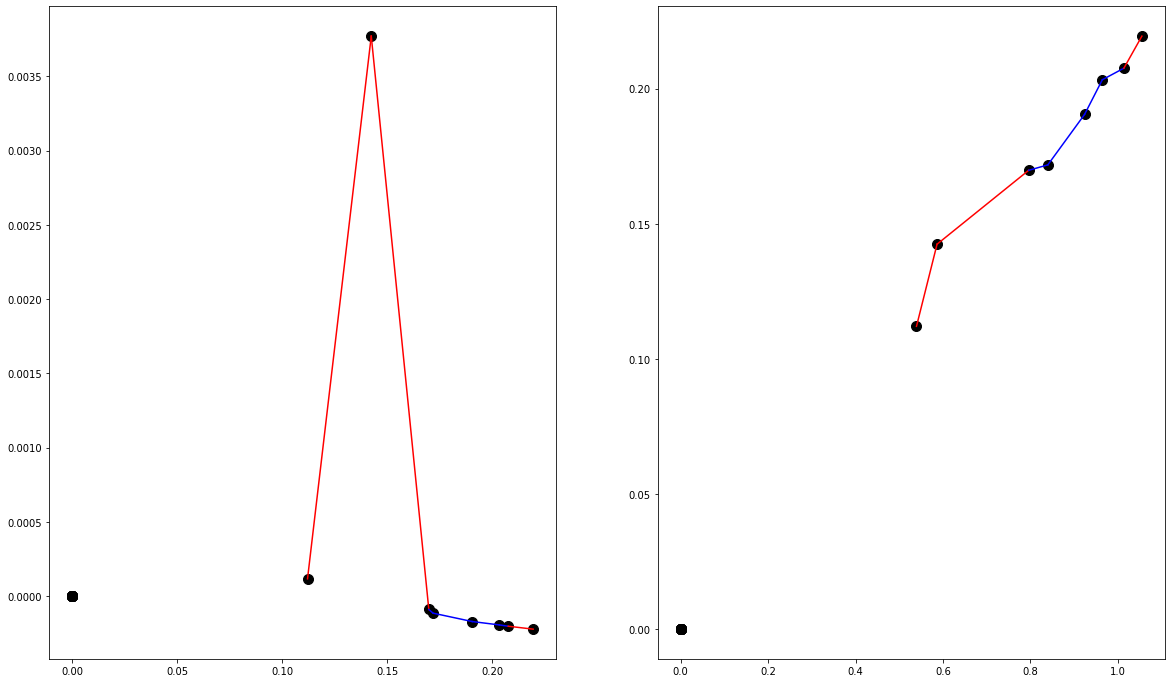

Y = [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.2214337  0.24015218 0.3063552  0.33035707 0.56522346 0.49777287
 0.39106613 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.918, precision 1.000, recall 0.200


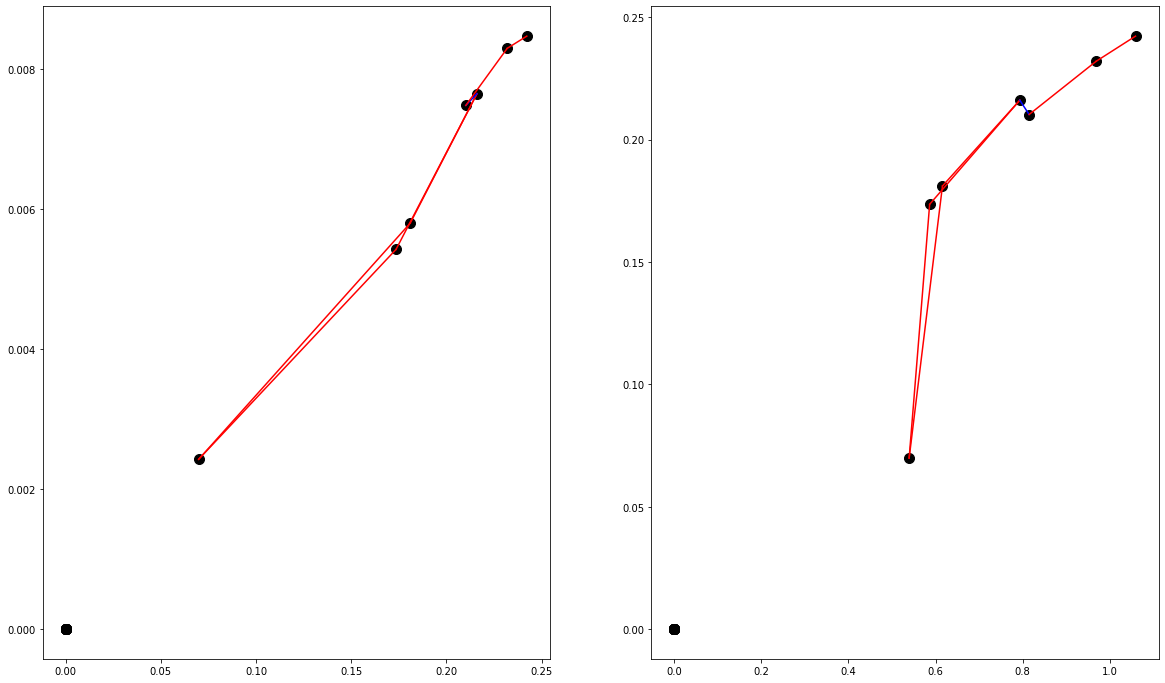

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00017244 0.00050821 0.00083293 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


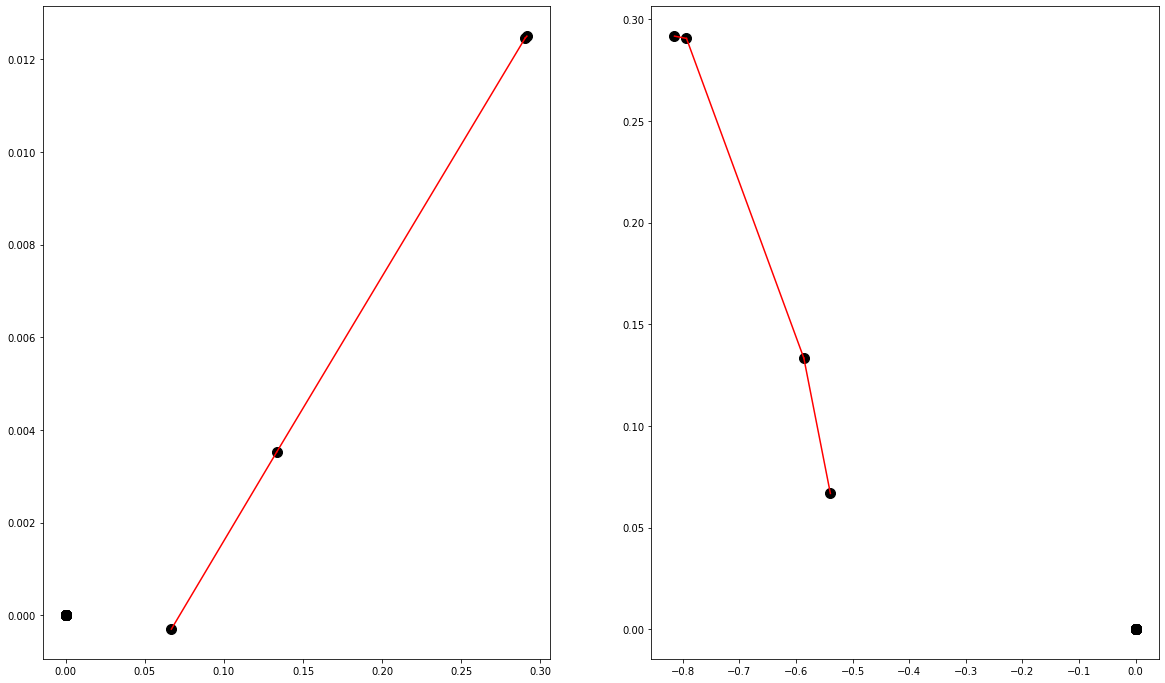

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00058184 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


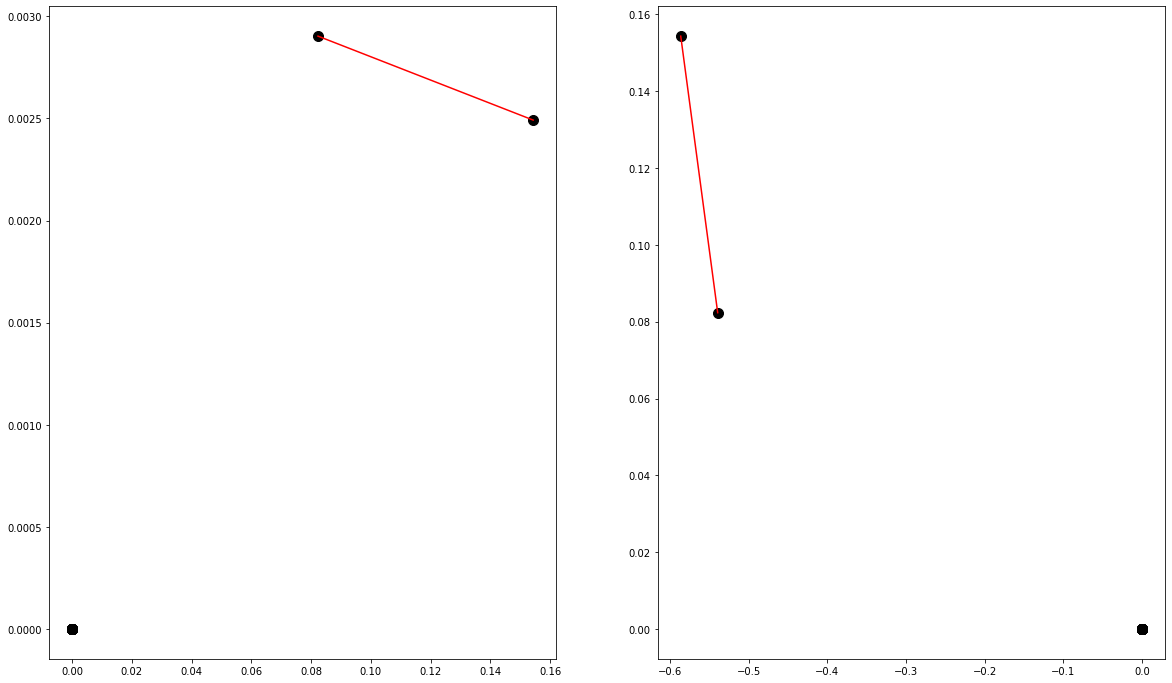

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04456097 0.06387945 0.03571316 0.03939644 0.05687658 0.03151126
 0.0360905  0.05184379 0.02890407 0.08078588 0.10986206 0.06979064
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


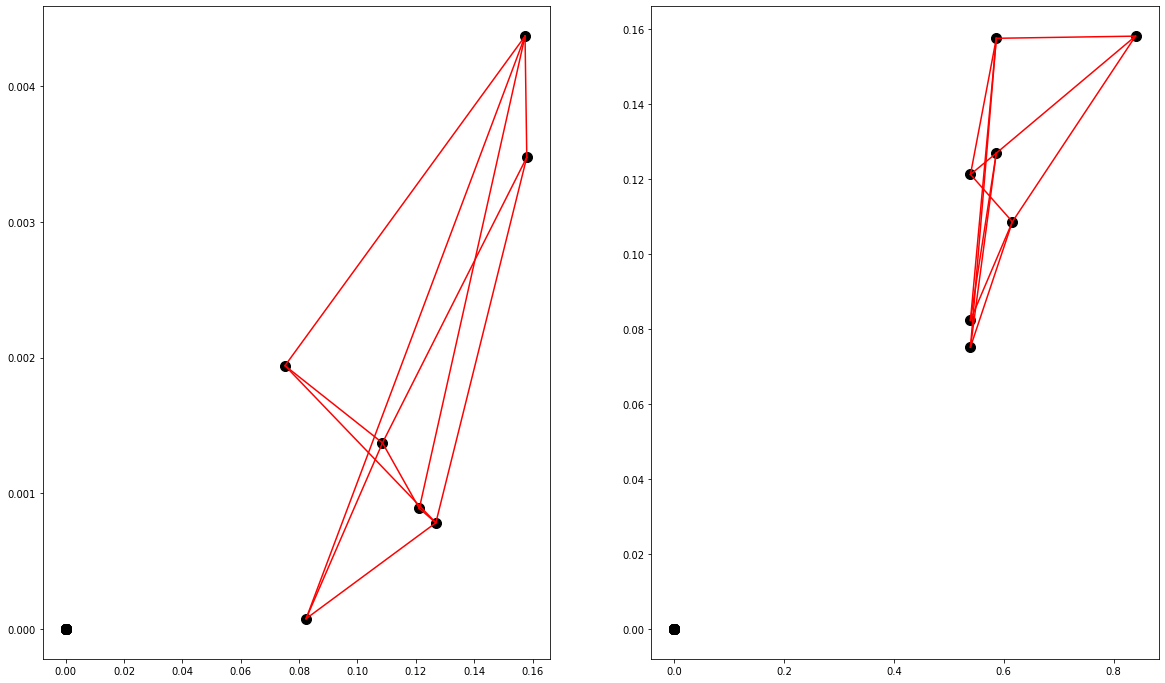

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00030713 0.00036237 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


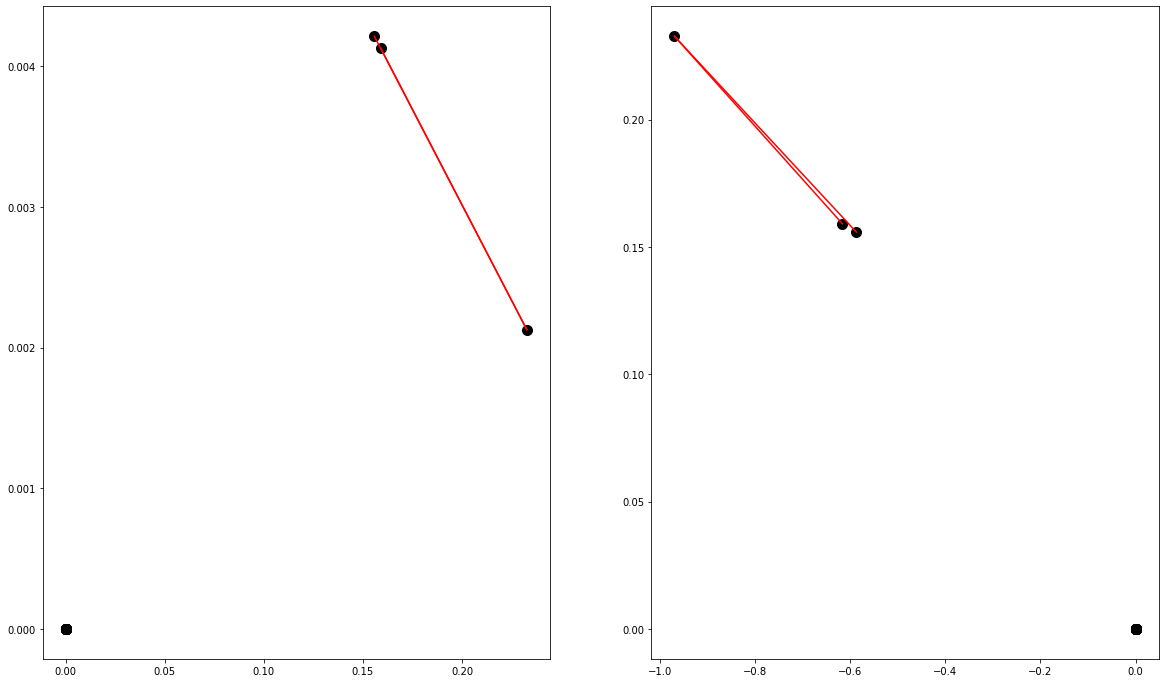

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [5.3489296e-04 5.6995243e-05 3.8021437e-05 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


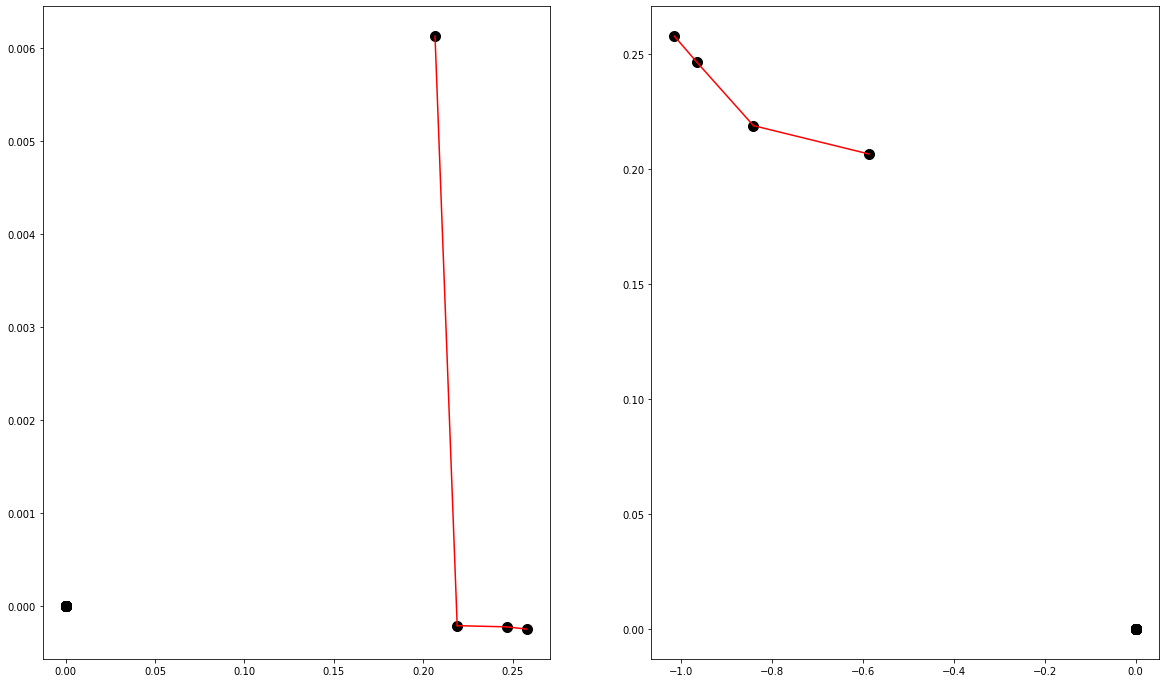

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.23836339 0.2639645  0.3785191  0.23714894 0.3148482  0.04029394
 0.03982303 0.05959545 0.03934141 0.03887433 0.0585124  0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


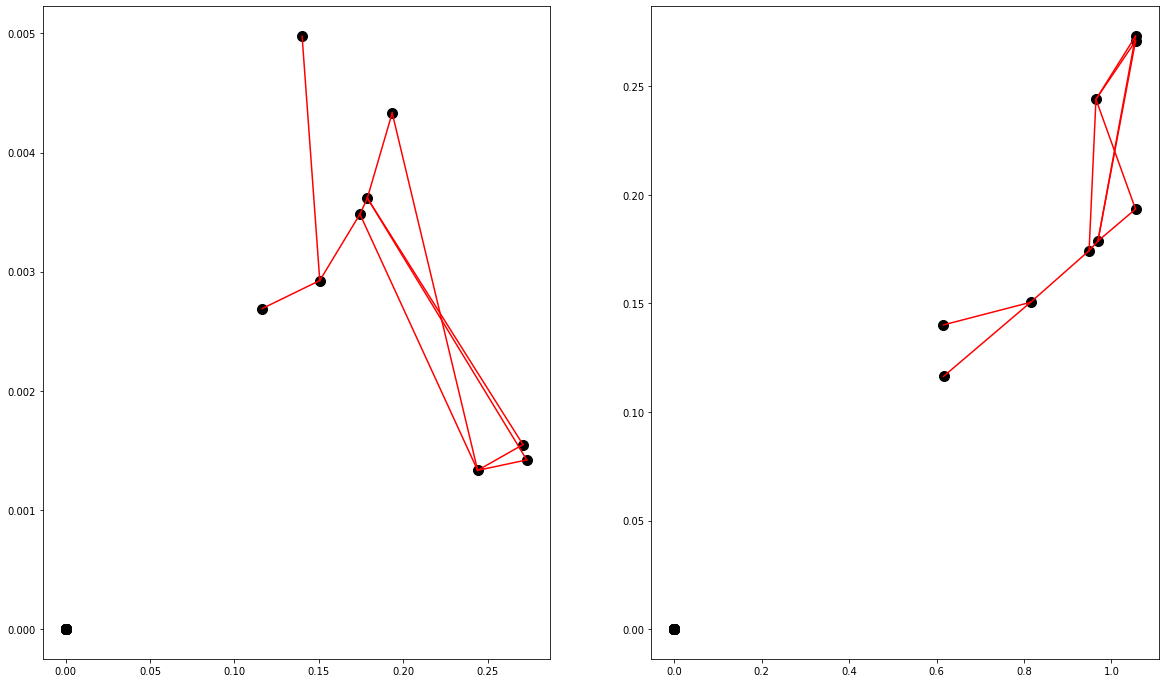

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.14345866 0.16160174 0.1842522  0.20581926 0.3593747  0.35658652
 0.51333904 0.36918908 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.980, precision 0.000, recall 0.000


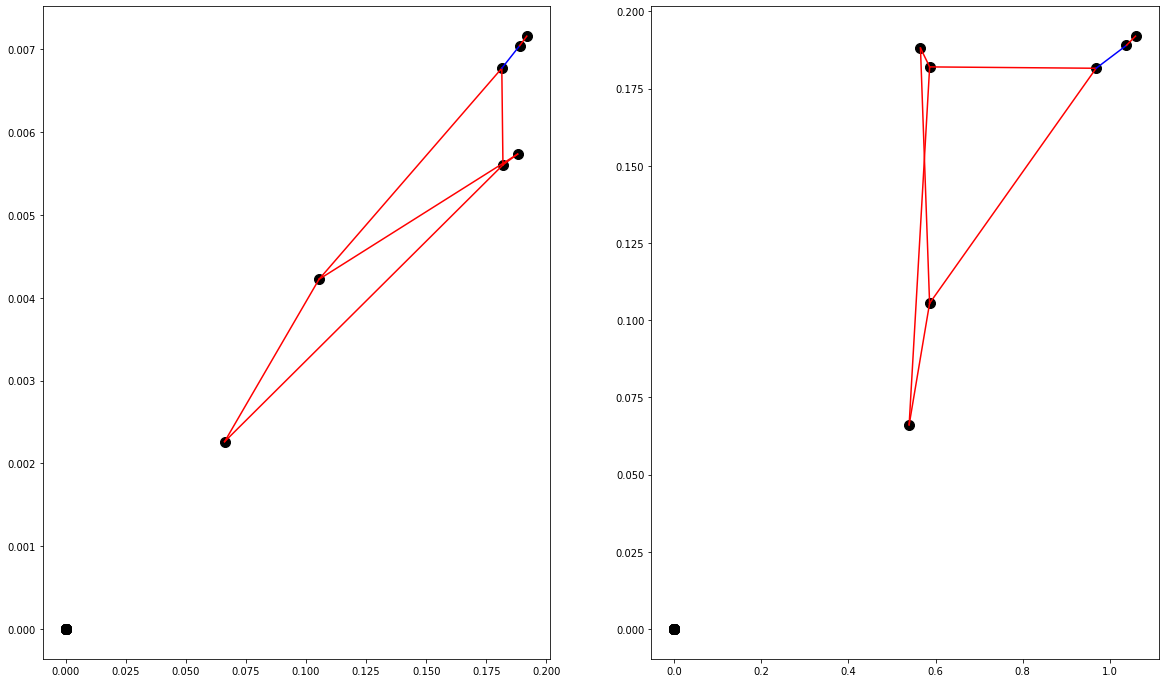

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20472243 0.24285944 0.543589   0.51941323 0.12803812 0.1545821
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 0.000, recall 0.000


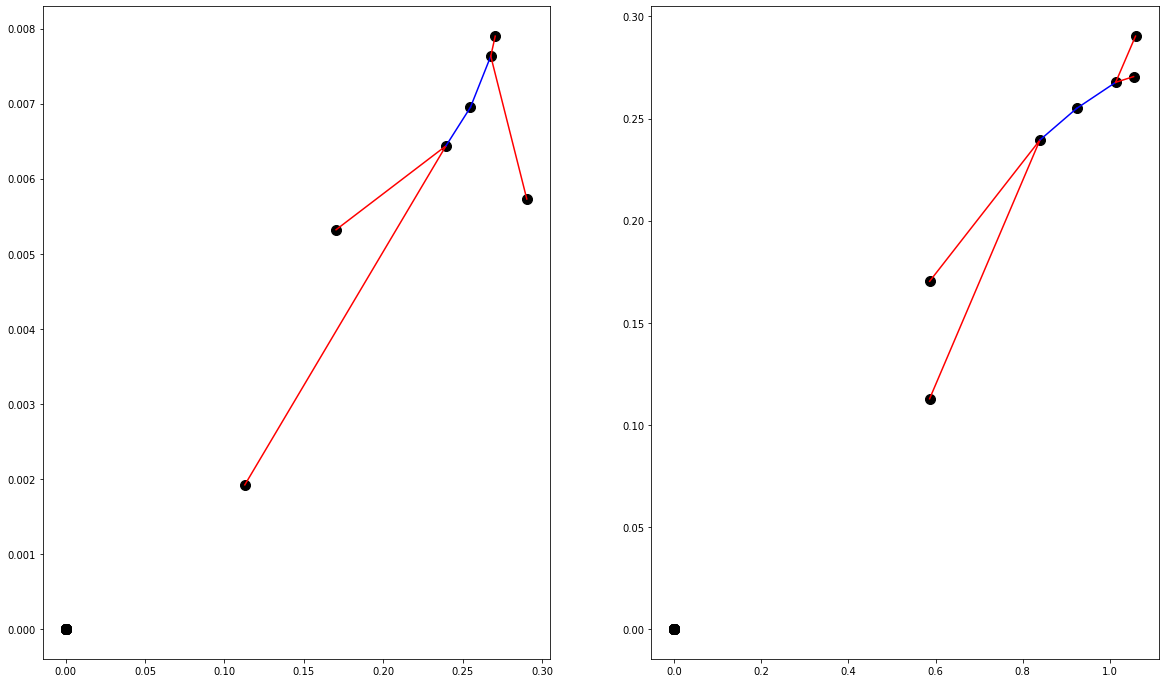

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00028946 0.00025799 0.00036374 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


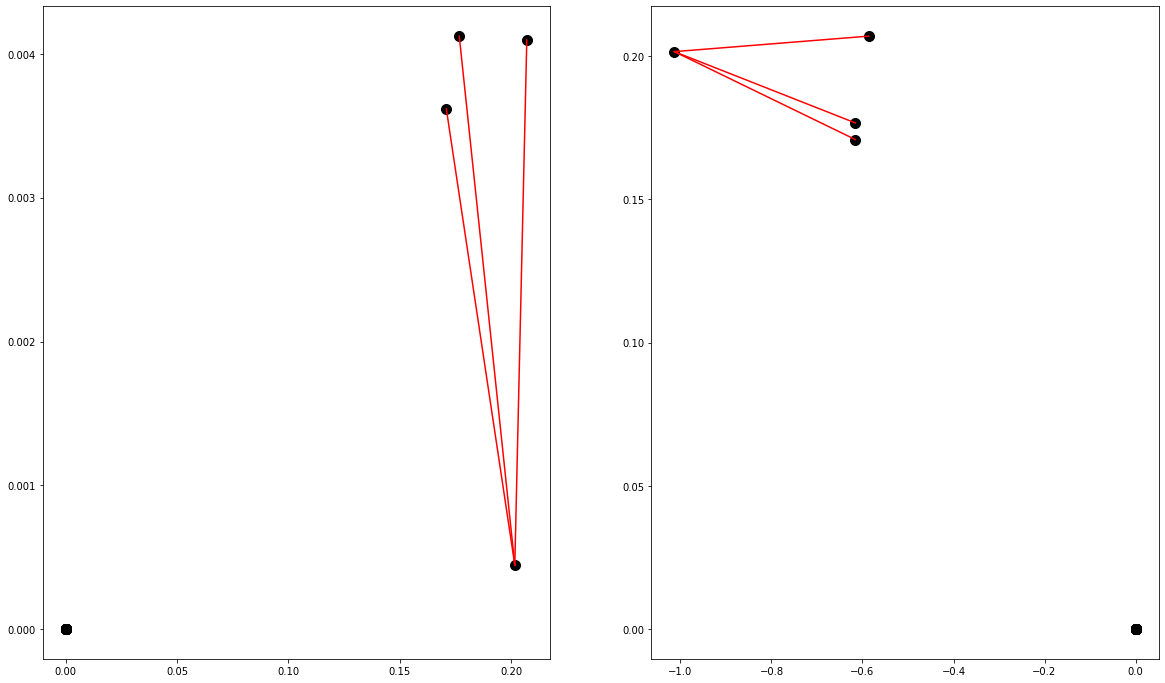

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04742439 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


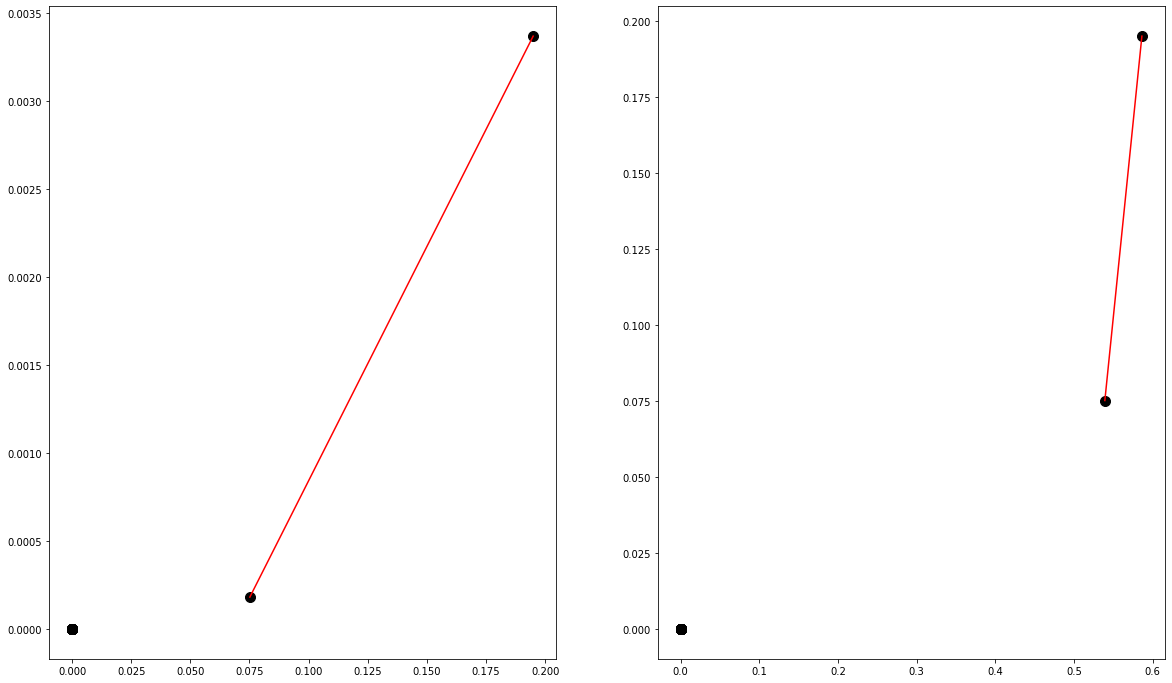

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [1.9475984e-04 1.7800192e-04 1.8699246e-04 7.0658803e-05 5.5622859e-05
 5.1299219e-05 4.4558739e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798942e-03 1.4798942e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


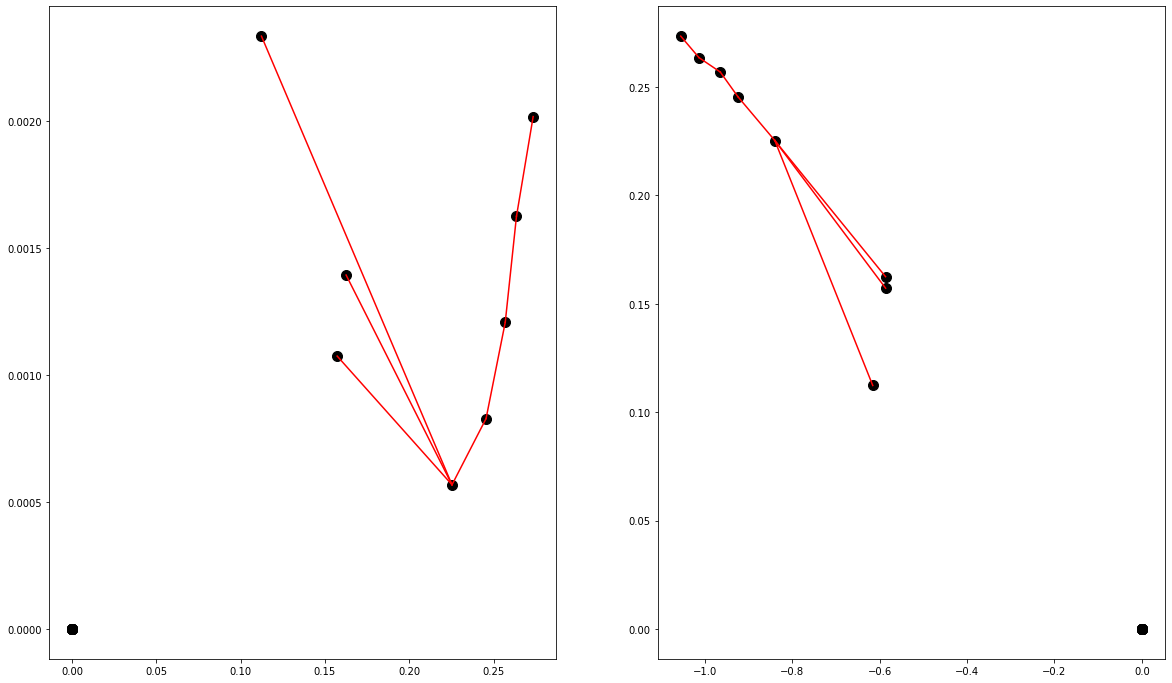

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.36933973 0.5471986  0.51359034 0.3965165  0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 1.000, recall 0.500


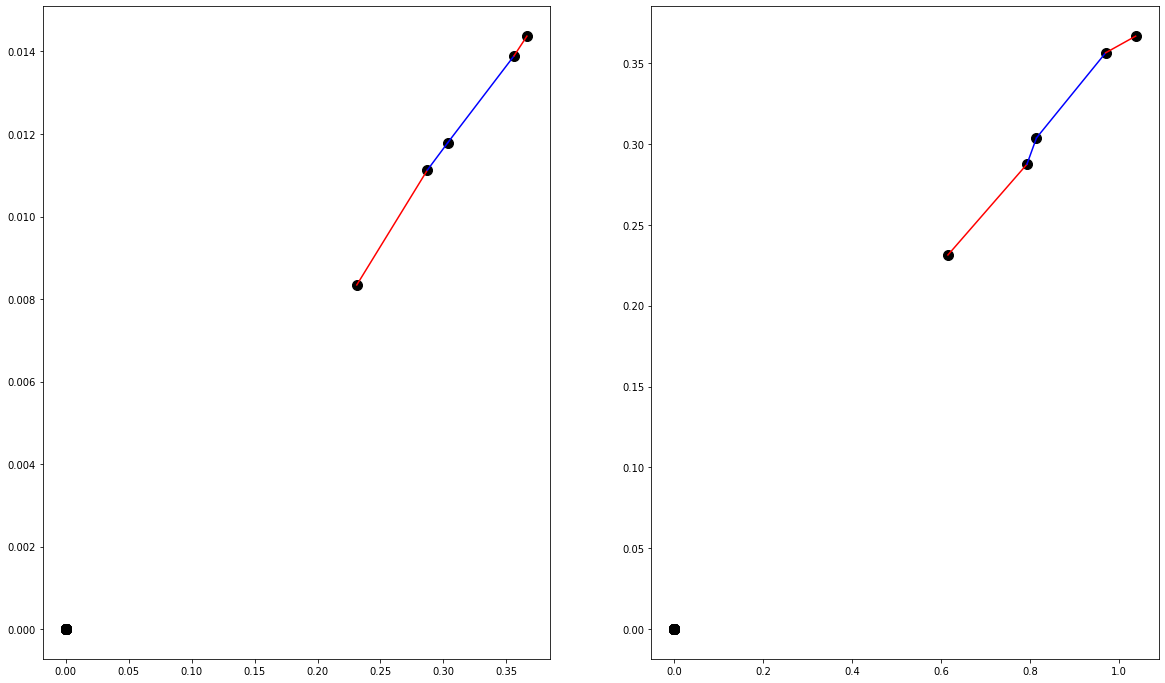

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00018062 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


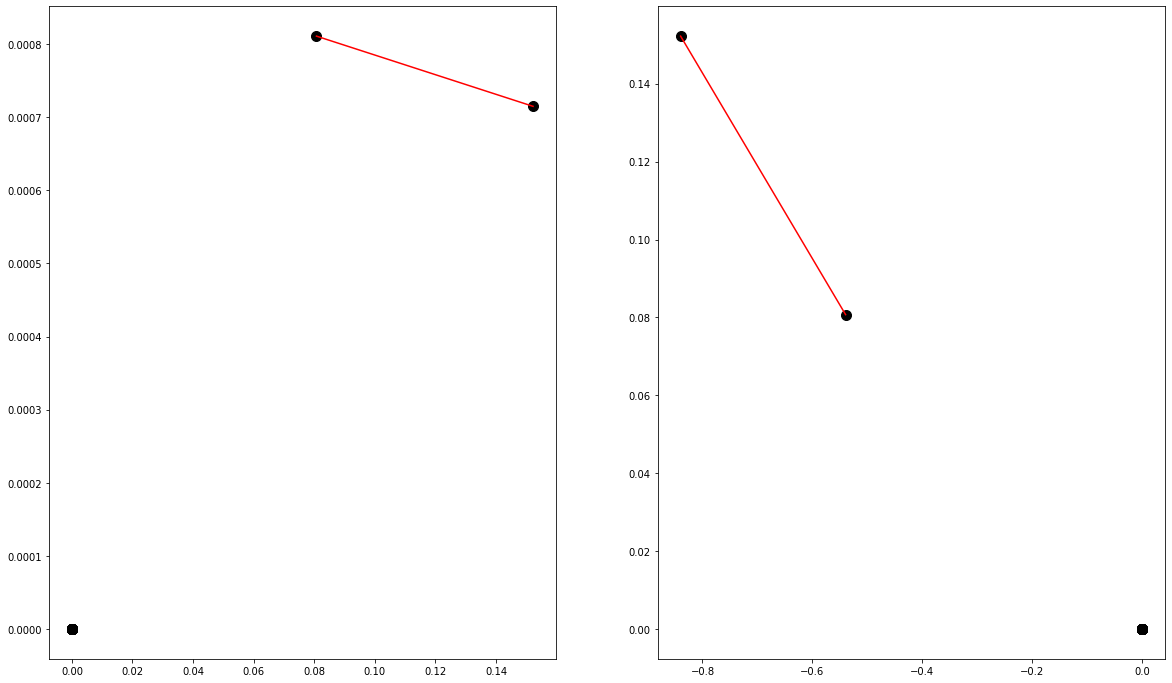

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.299619   0.32776132 0.32662585 0.3639175  0.3620093  0.5046788
 0.39655587 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.980, precision 0.000, recall 0.000


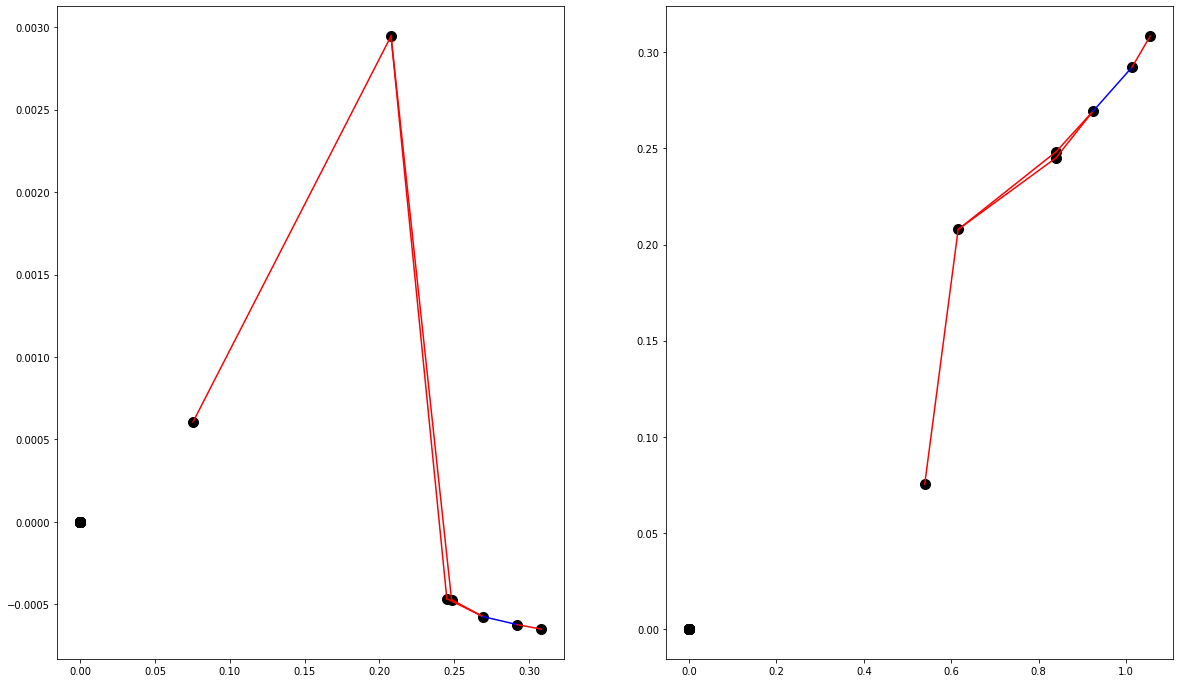

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00035536 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


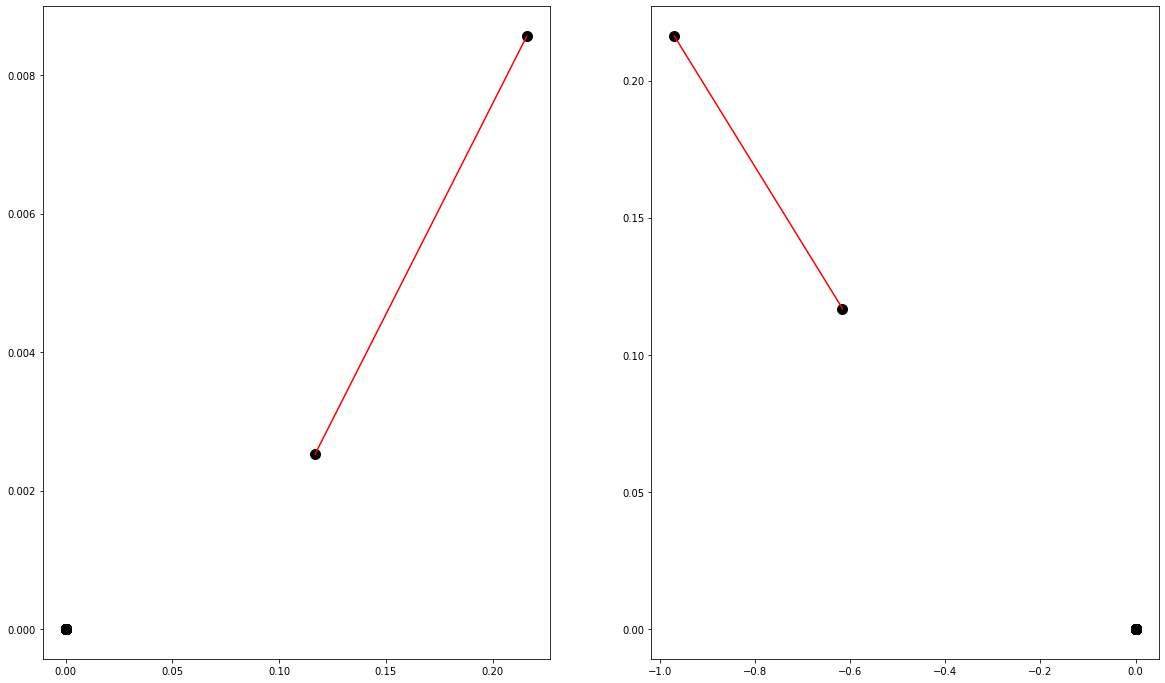

Y = [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.19325024 0.18332891 0.30776072 0.28688252 0.2539594  0.1511129
 0.24359891 0.14332995 0.37767884 0.2561594  0.34069103 0.22272761
 0.48543218 0.35053375 0.32311332 0.19544417 0.39722648 0.26702613
 0.22849712 0.2834911  0.16677946 0.13666189 0.40914118 0.23191826
 0.31799012 0.15355393 0.3200271  0.1523795  0.3944873  0.17580494
 0.22483307 0.35797107 0.13448009 0.17953072 0.25610876 0.12990063
 0.22087374 0.10764682 0.22993888 0.11194253 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.857, precision 0.000, recall 0.000


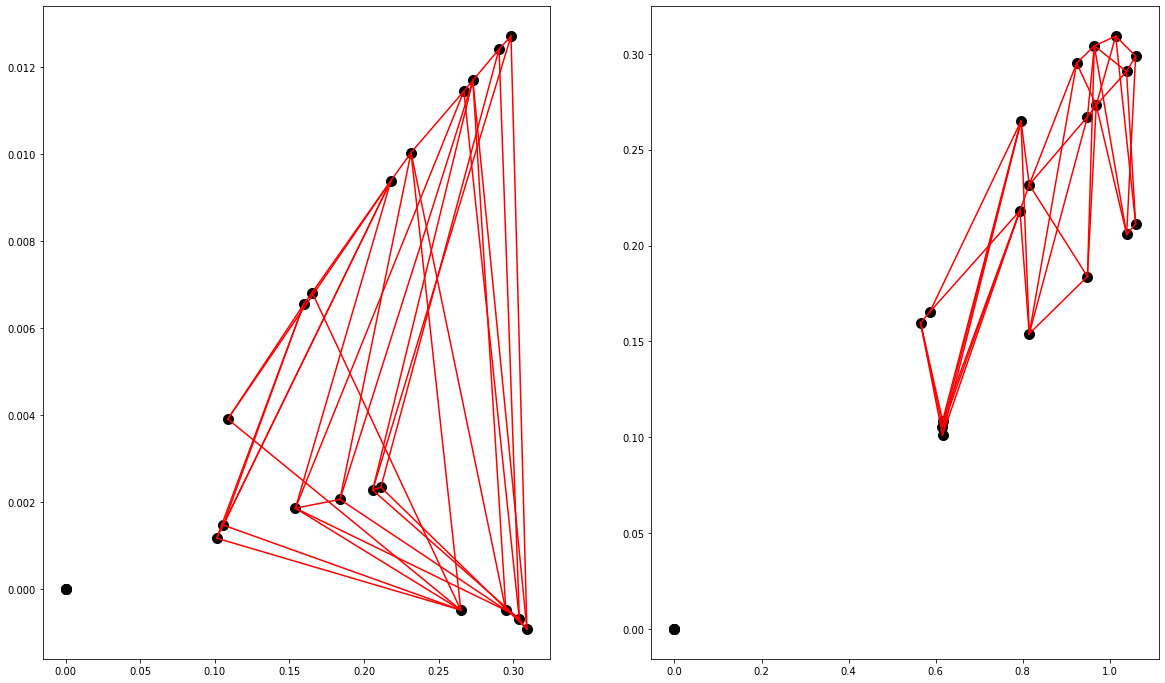

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.2371443e-04 5.0203467e-04 6.1338680e-05 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


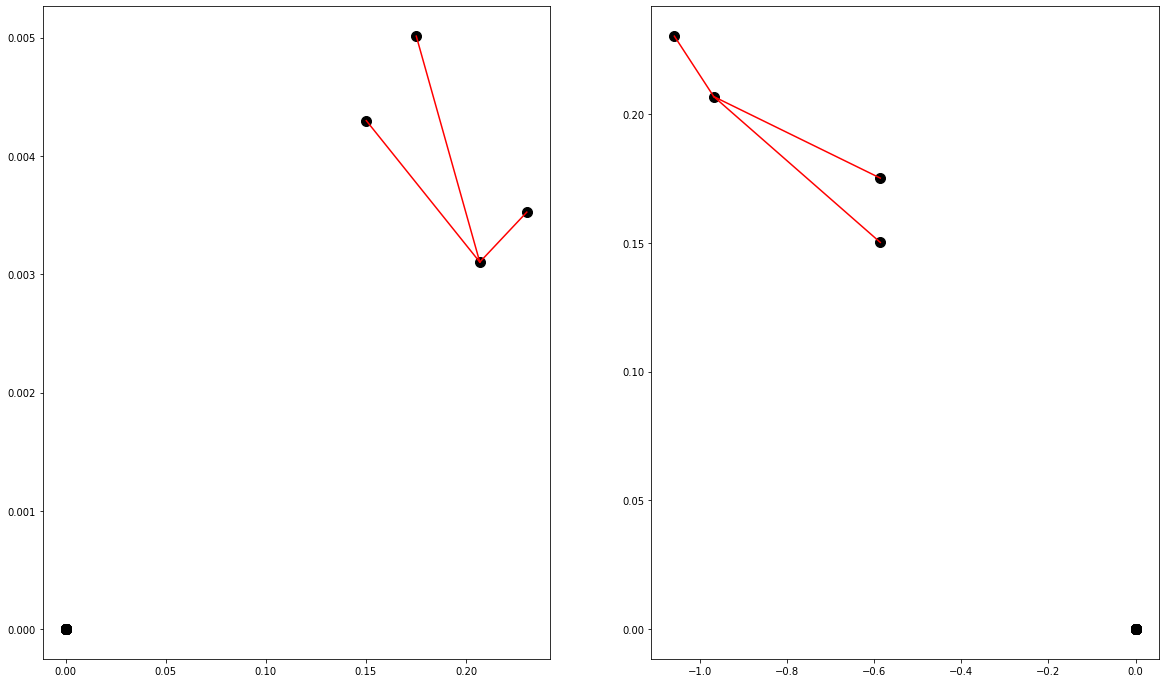

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.17360559 0.161954   0.4158488  0.35941705 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


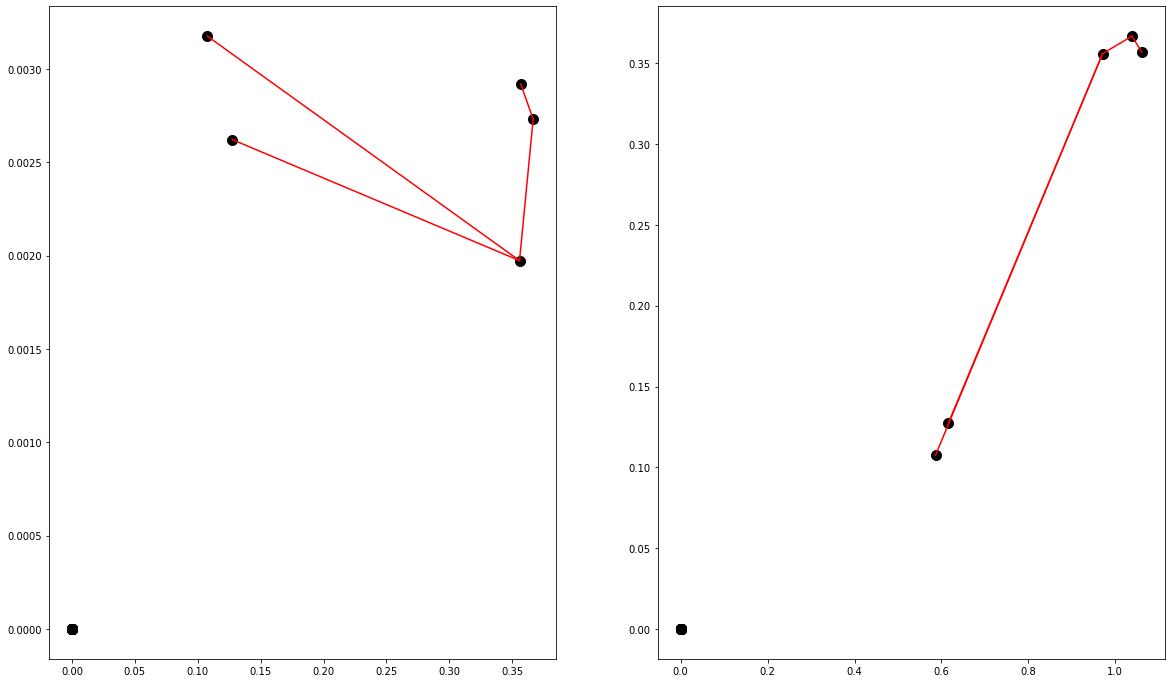

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [3.22879147e-04 2.24213407e-04 3.15341284e-04 2.19002482e-04
 1.93322441e-04 1.35083552e-04 1.16271265e-04 5.98931219e-05
 7.84589138e-05 6.83040271e-05 5.55452025e-05 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


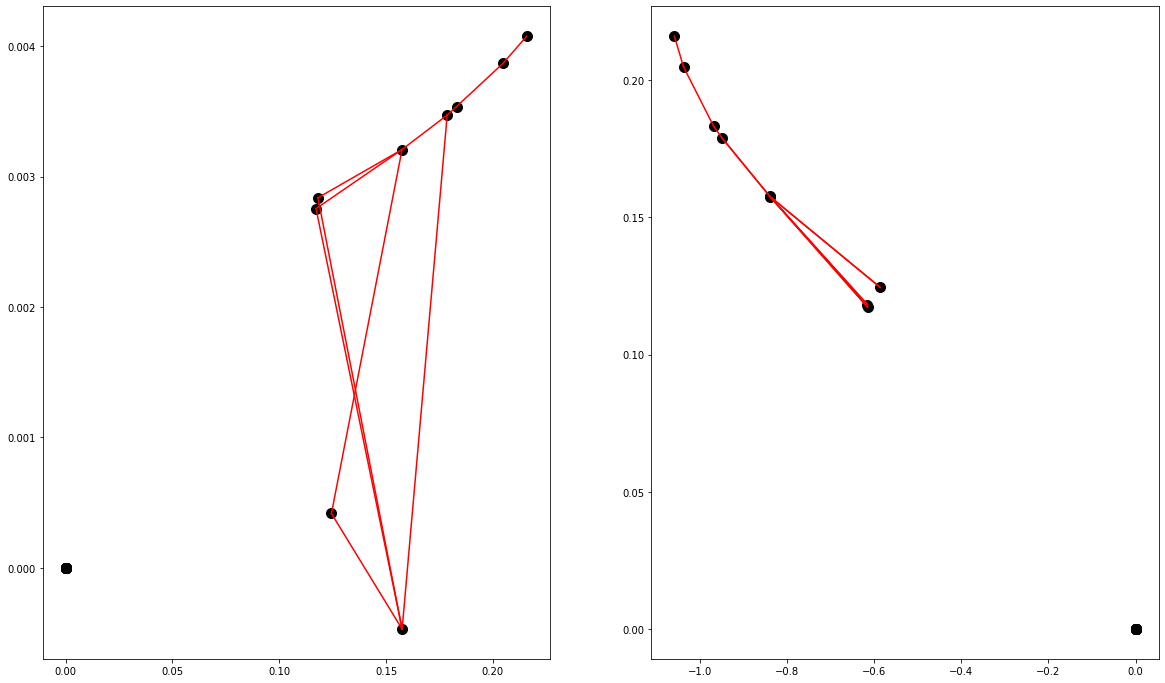

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0004295  0.00048863 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


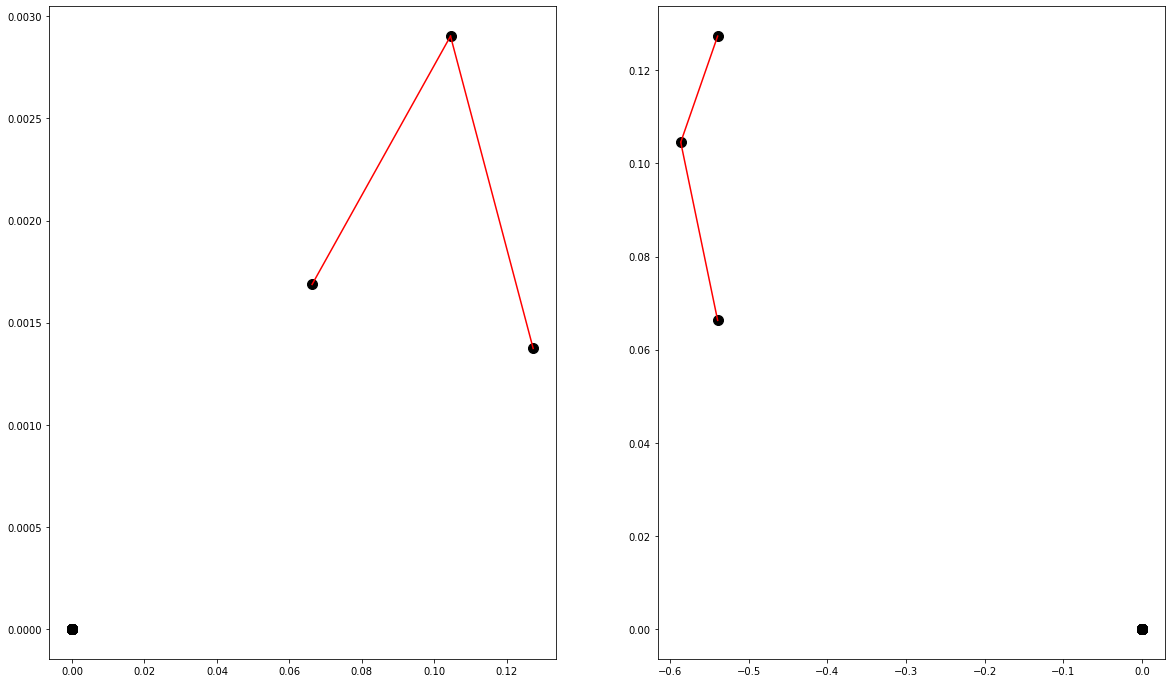

Y = [0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1950375  0.21167839 0.17763945 0.19307126 0.43079865 0.4613871
 0.40766093 0.45943737 0.4141465  0.4038993  0.60480976 0.41933563
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.898, precision 1.000, recall 0.167


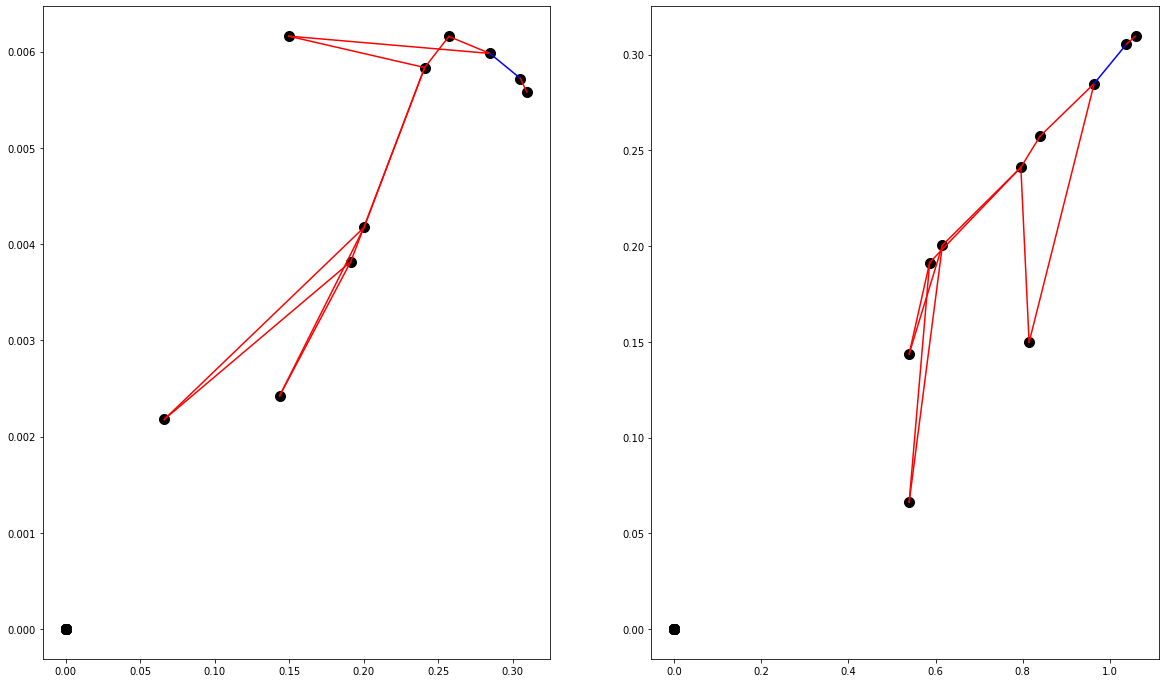

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [5.8320927e-04 6.4555142e-04 3.3030761e-04 3.2368943e-04 6.7404530e-04
 6.5997615e-04 1.3420665e-04 1.2414176e-04 9.4986157e-05 8.3837753e-05
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


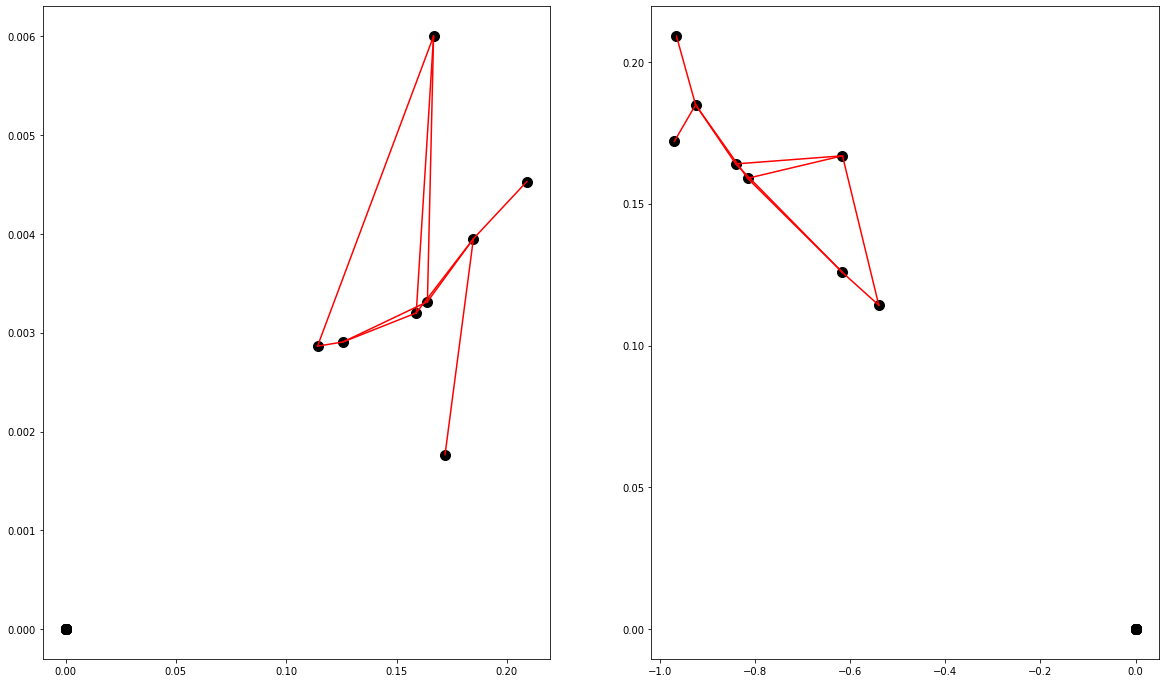

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [2.2226457e-04 8.7037217e-05 4.6543366e-05 5.6477842e-05 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


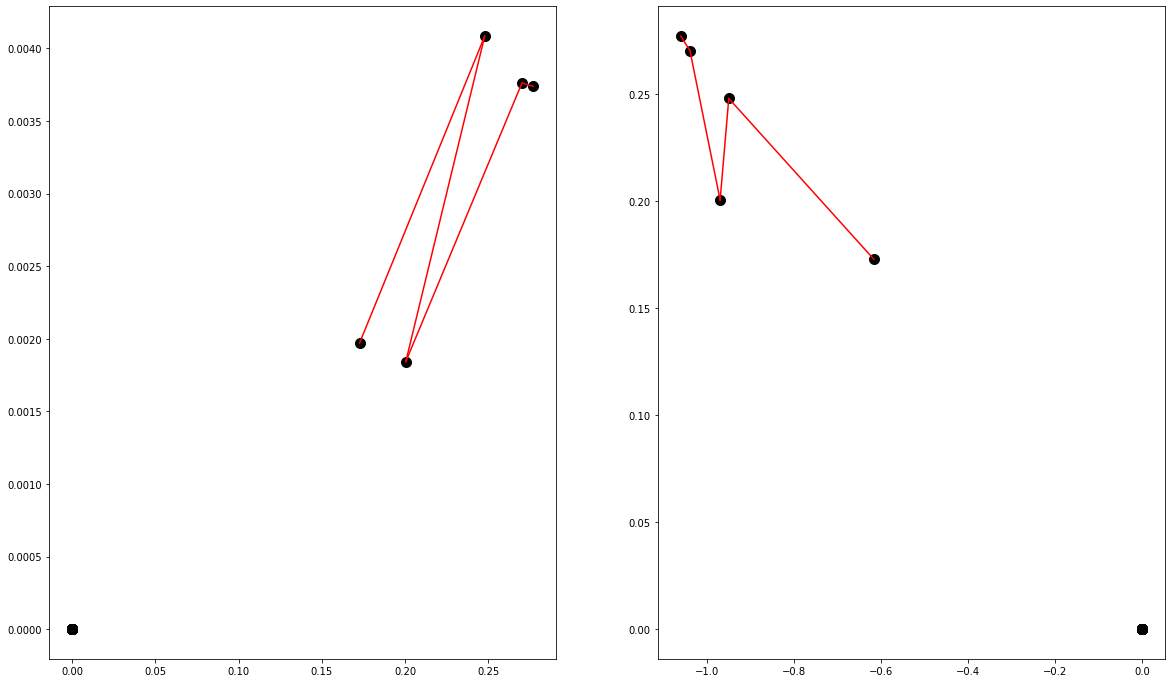

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.01797813 0.02904648 0.02861167 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


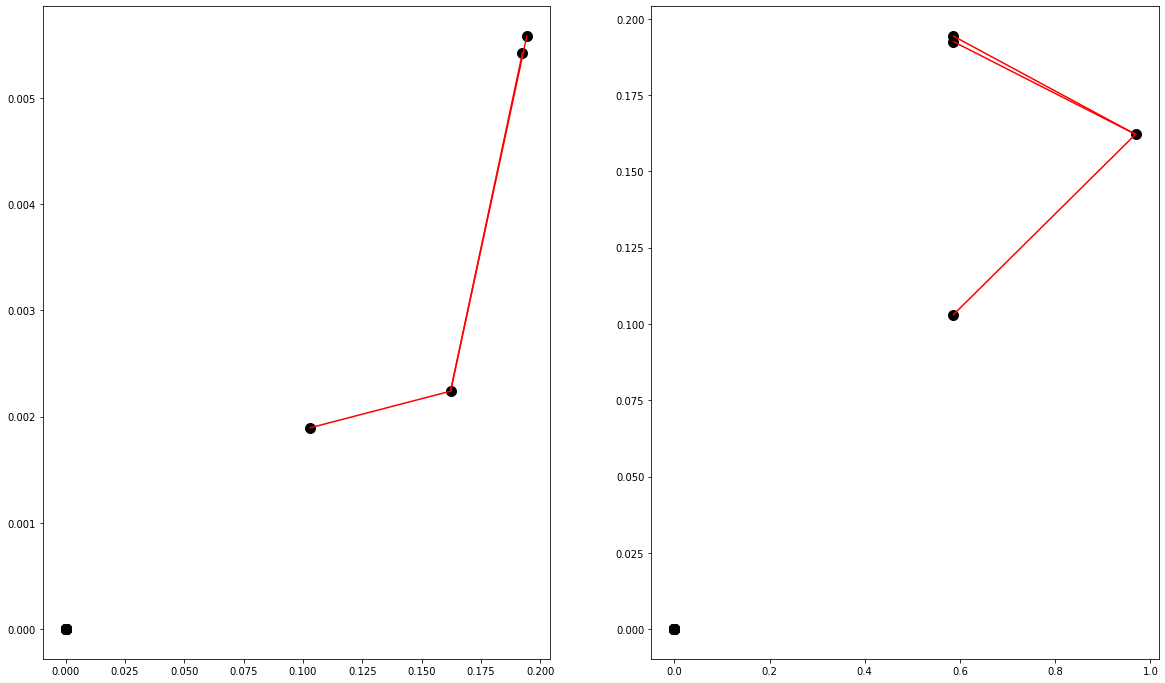

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [6.1096111e-04 2.8814538e-04 4.8880390e-04 2.3100901e-04 2.9124314e-04
 1.3852130e-04 1.3684323e-04 1.3317114e-04 5.8861529e-05 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


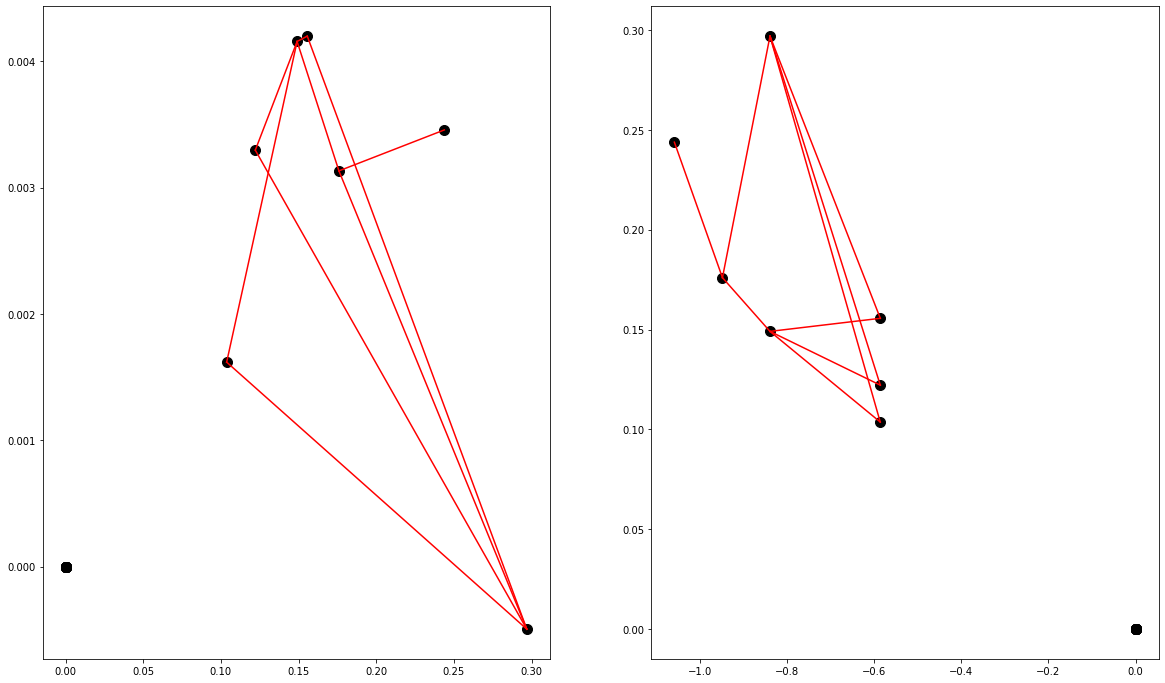

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00031302 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


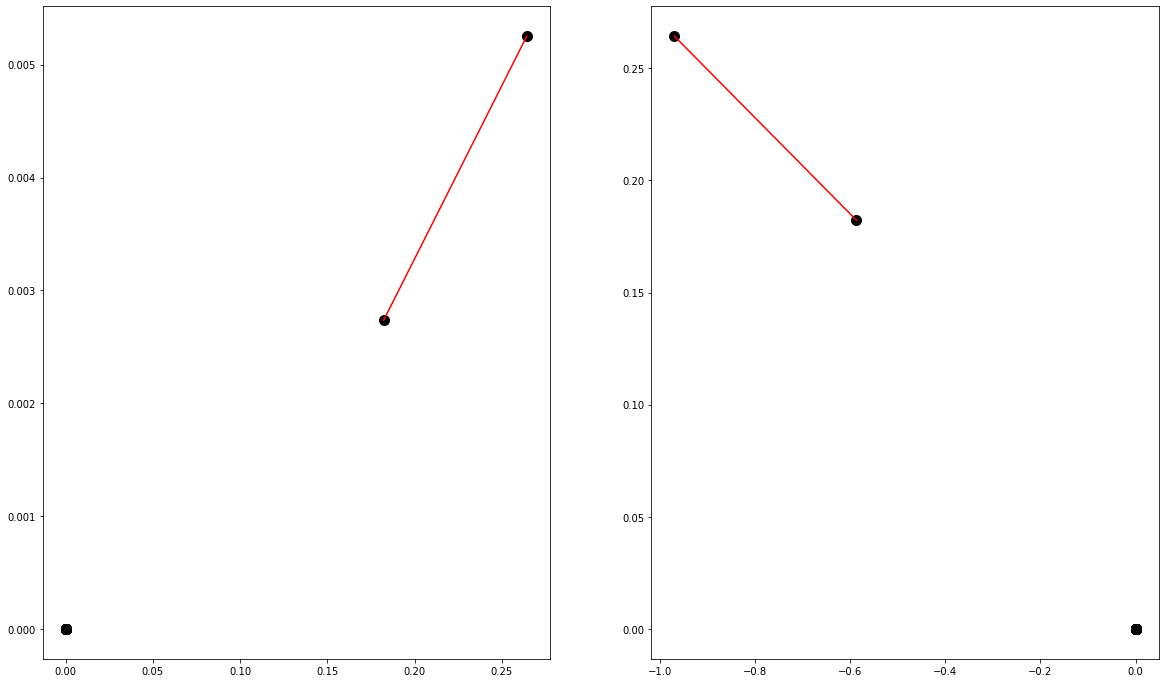

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.05250969 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


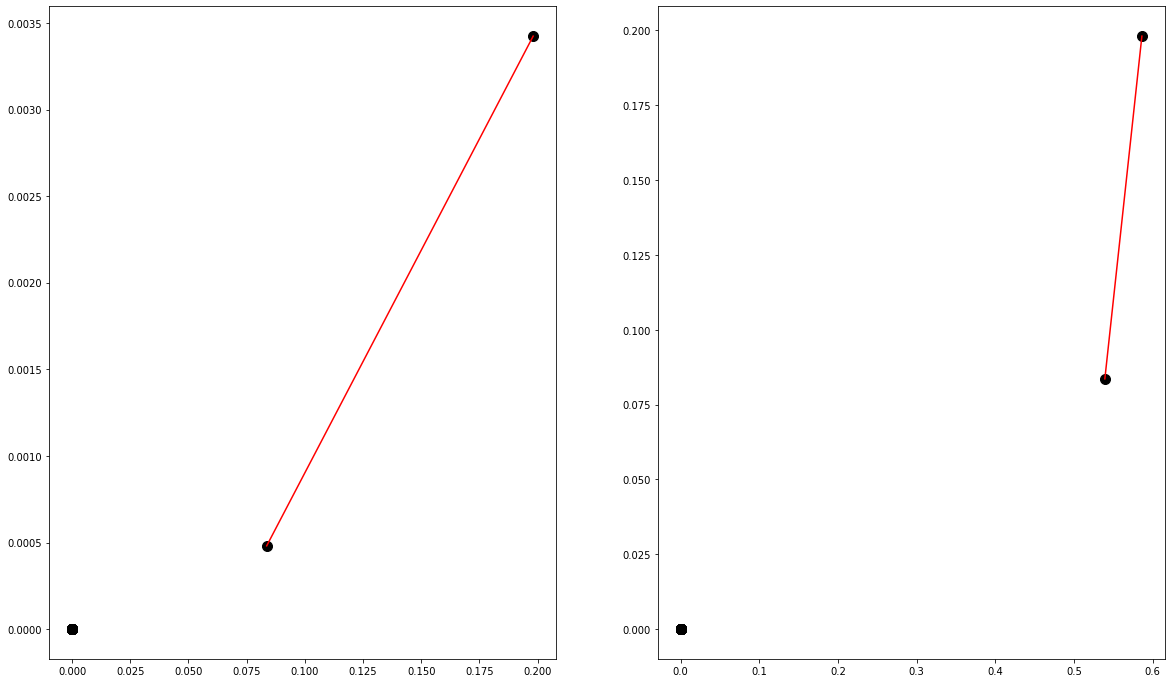

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.28038446e-04 4.27206047e-04 2.49735138e-04 2.47602991e-04
 1.87871017e-04 1.26467698e-04 1.29488995e-04 3.83553524e-05
 3.92331094e-05 1.17924705e-04 1.20836281e-04 9.75840157e-05
 9.45651773e-05 1.03160237e-04 9.99056356e-05 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03 1.47989497e-03 1.47989497e-03 1.47989497e-03
 1.47989497e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


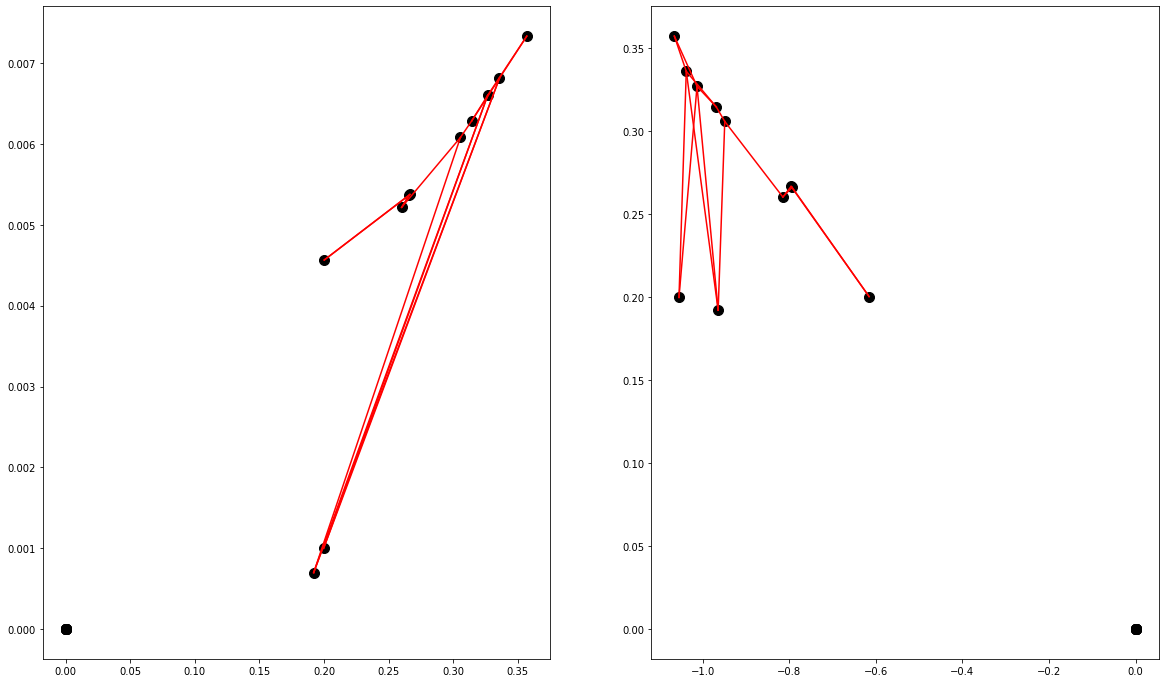

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00024362 0.00064011 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


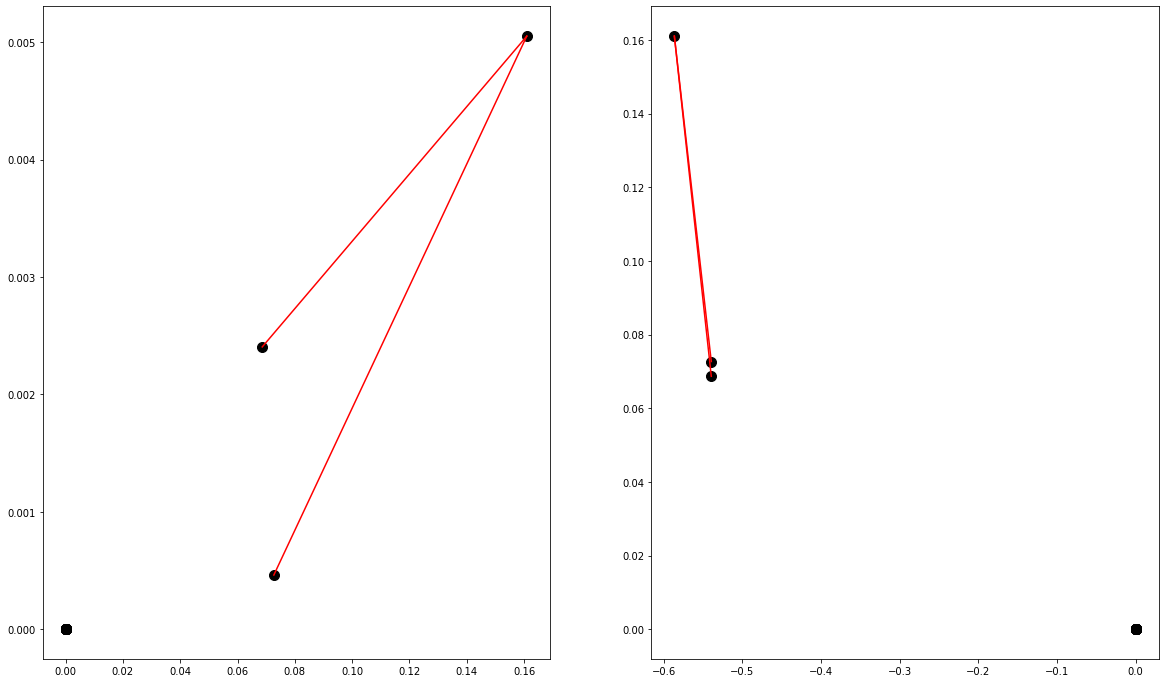

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.11768892 0.07774653 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


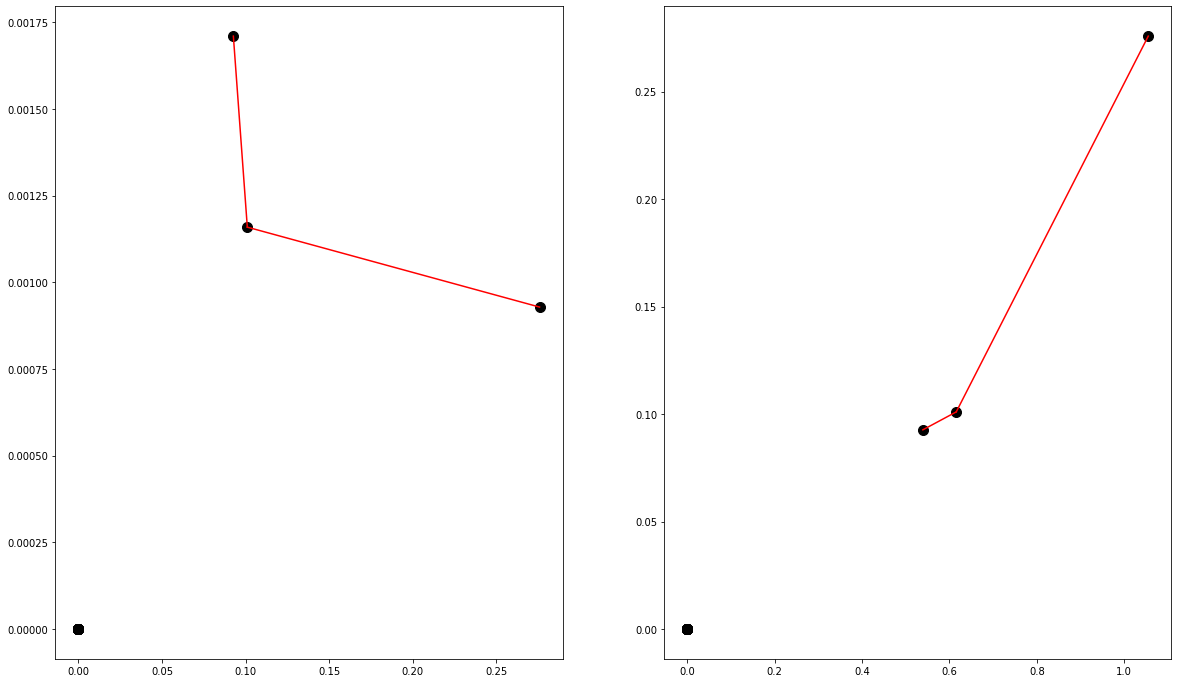

Y = [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.10692065 0.17180778 0.22858226 0.09923331 0.16029634 0.21435876
 0.23173998 0.26158687 0.32037875 0.7176495  0.63161695 0.27451953
 0.4334616  0.35637456 0.4647711  0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.918, precision 1.000, recall 0.333


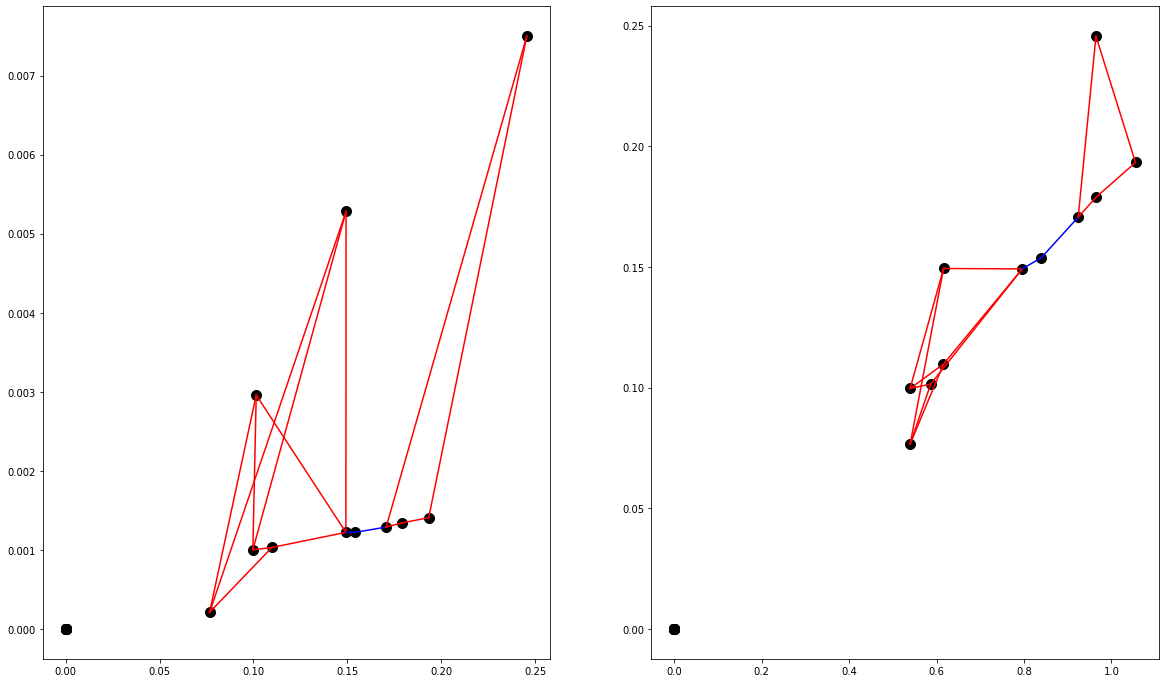

Y = [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.26456425 0.26092622 0.5103658  0.62233573 0.6284586  0.7409146
 0.6725546  0.47803652 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 0.800, recall 0.800


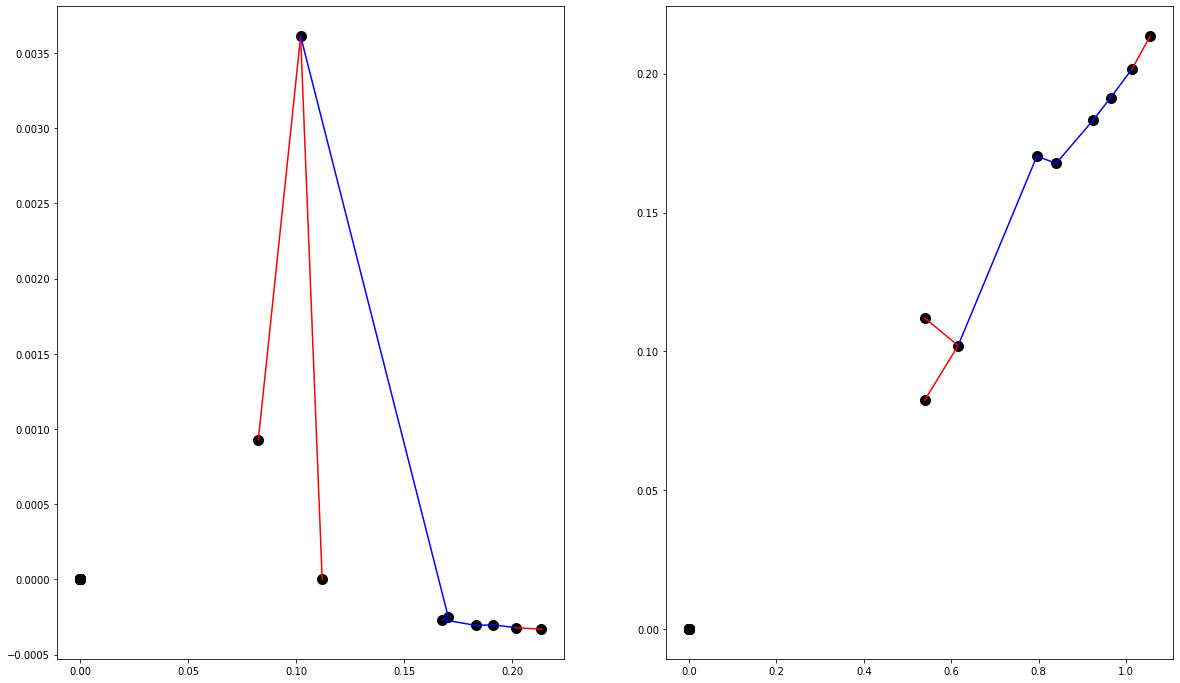

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [7.9775823e-04 7.7844720e-04 3.1418356e-04 3.0690833e-04 5.9044448e-04
 3.0678808e-04 5.6251069e-04 2.9245627e-04 2.8318973e-04 1.4881592e-04
 8.8761000e-05 4.7375390e-05 1.8146256e-04 9.5233481e-05 6.9658083e-05
 3.7082591e-05 1.6493000e-04 6.3340725e-05 1.2907368e-04 7.1390896e-05
 6.5801927e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


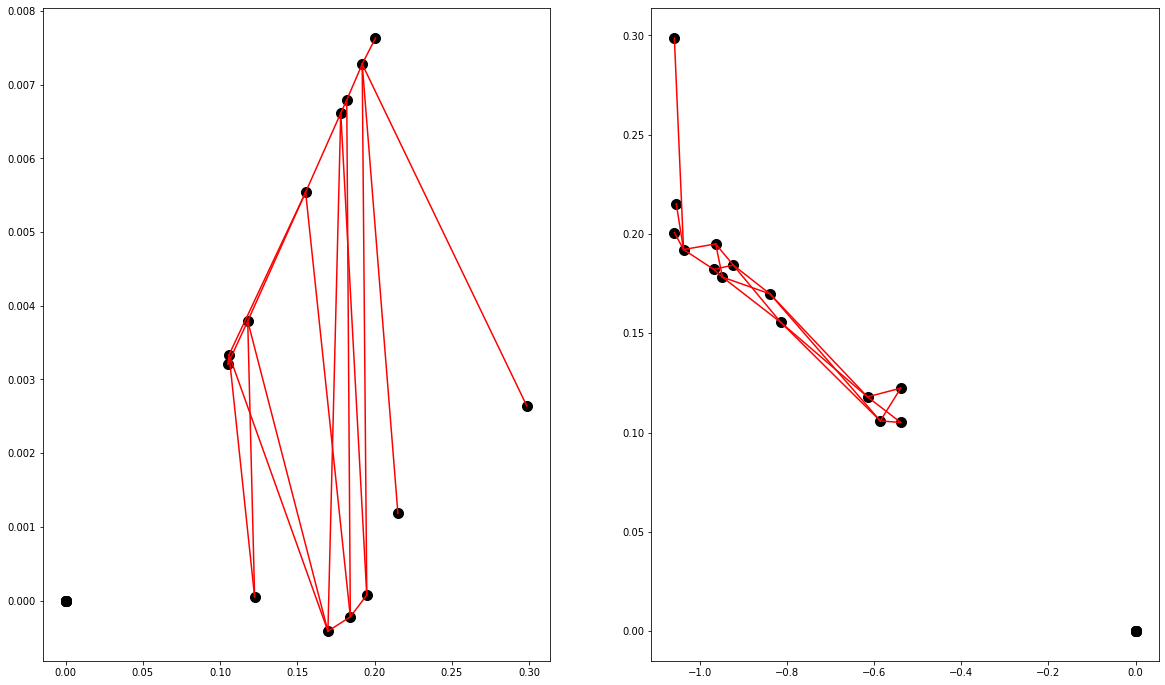

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1308657  0.11062846 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


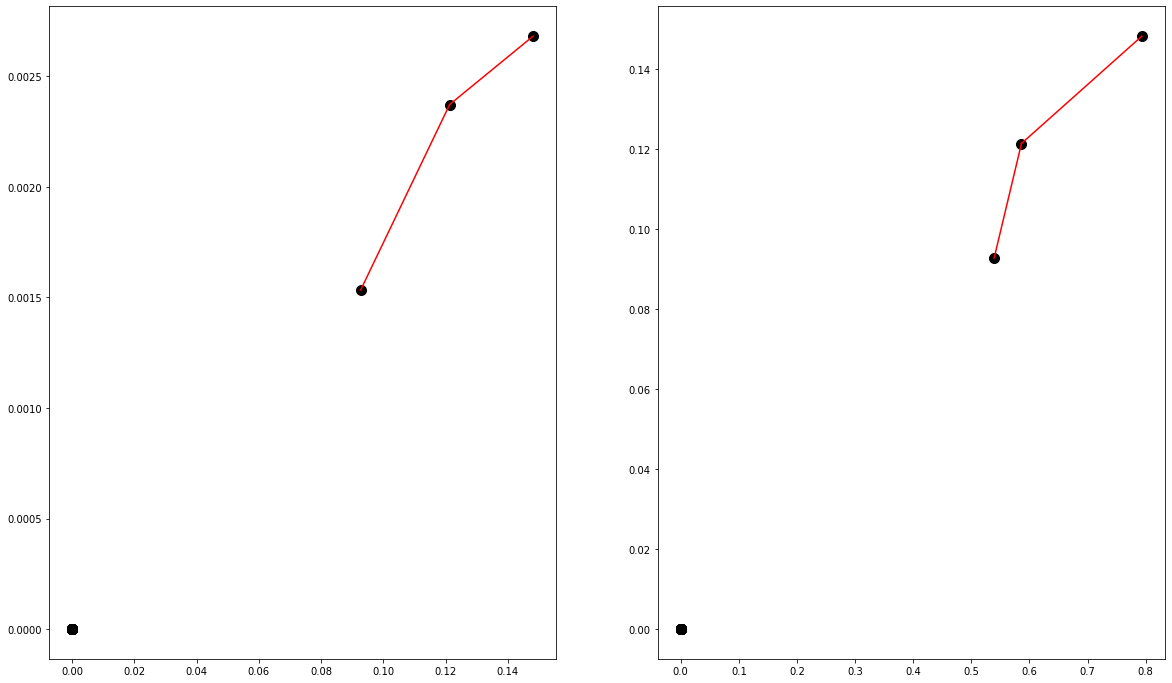

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20988958 0.25299758 0.41559264 0.34023333 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


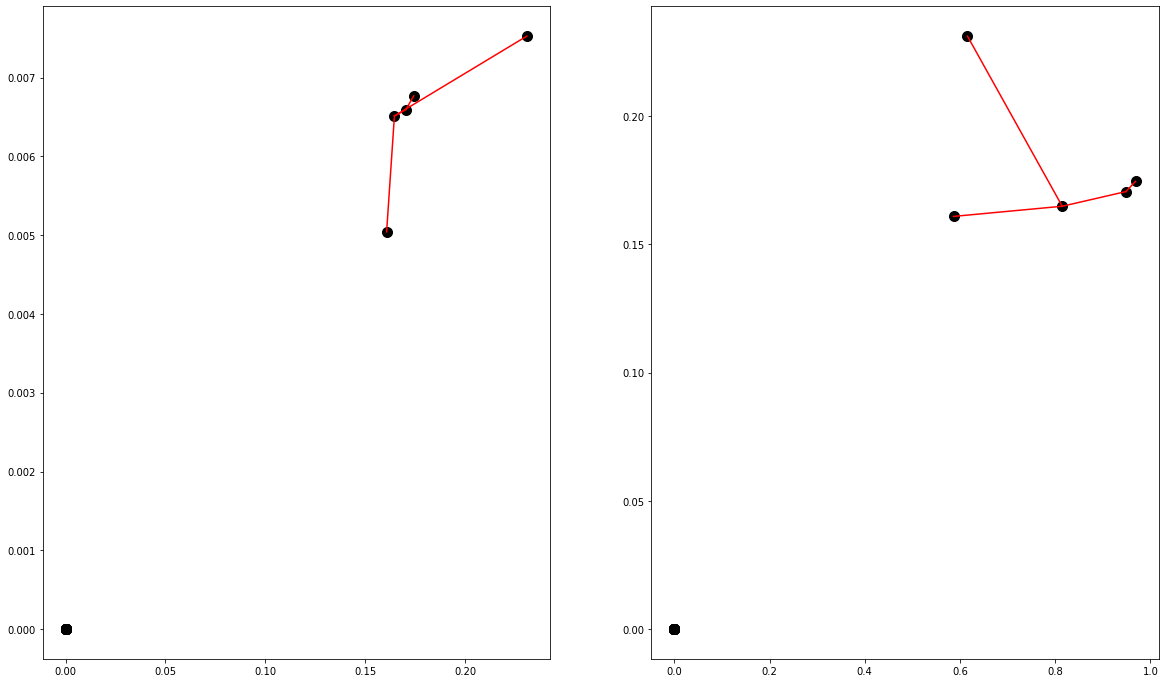

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00048861 0.00032227 0.00022323 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


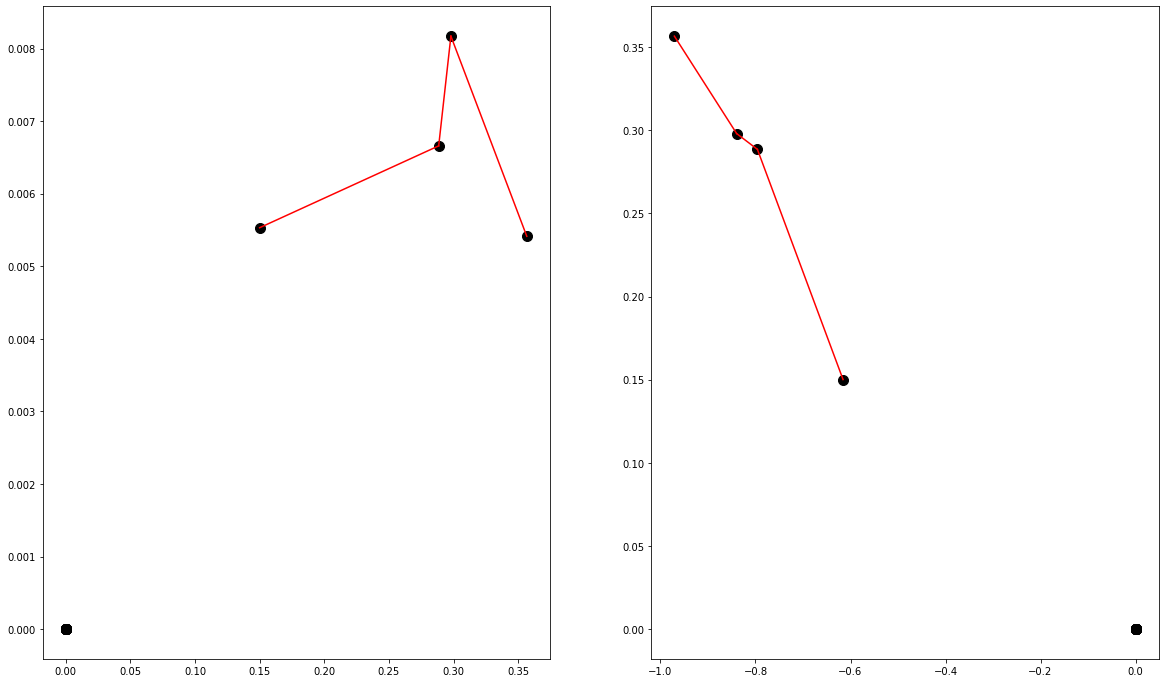

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00053644 0.00055563 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


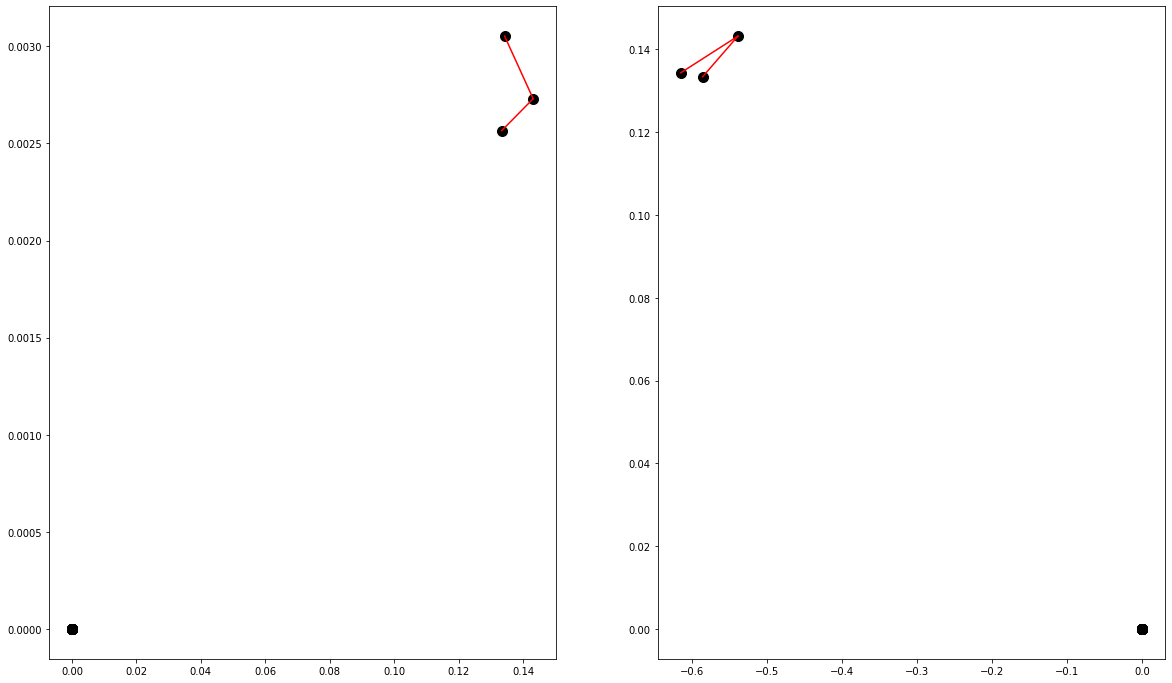

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00040896 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


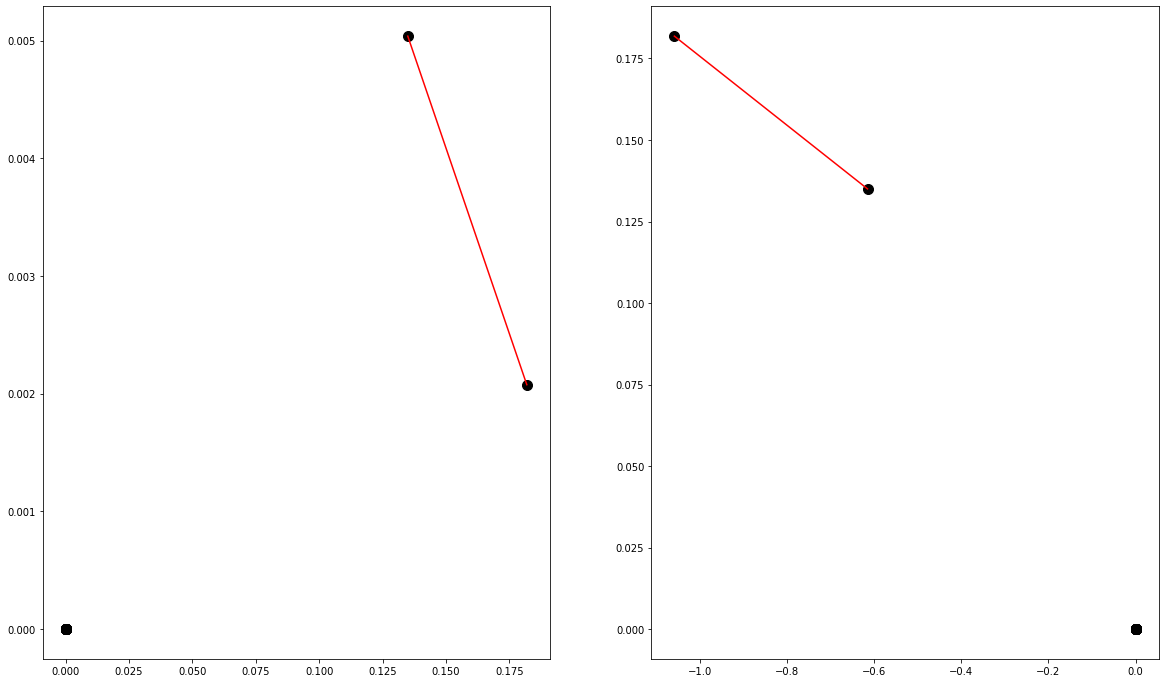

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.06148545 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


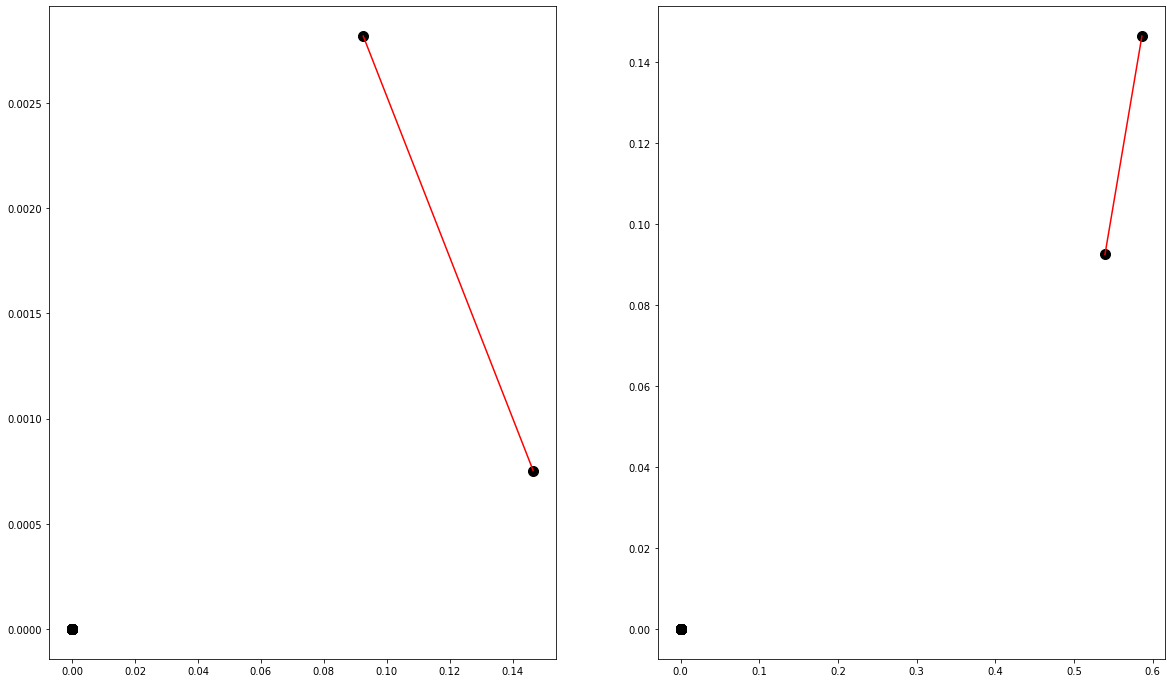

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00057396 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


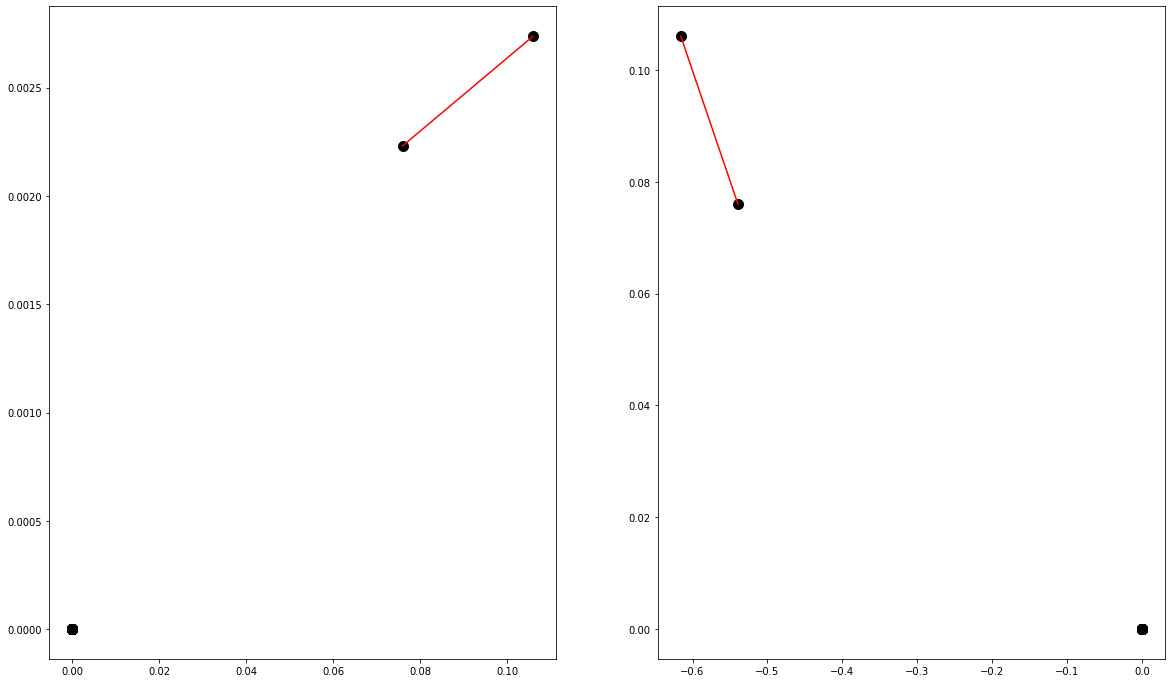

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0378533  0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


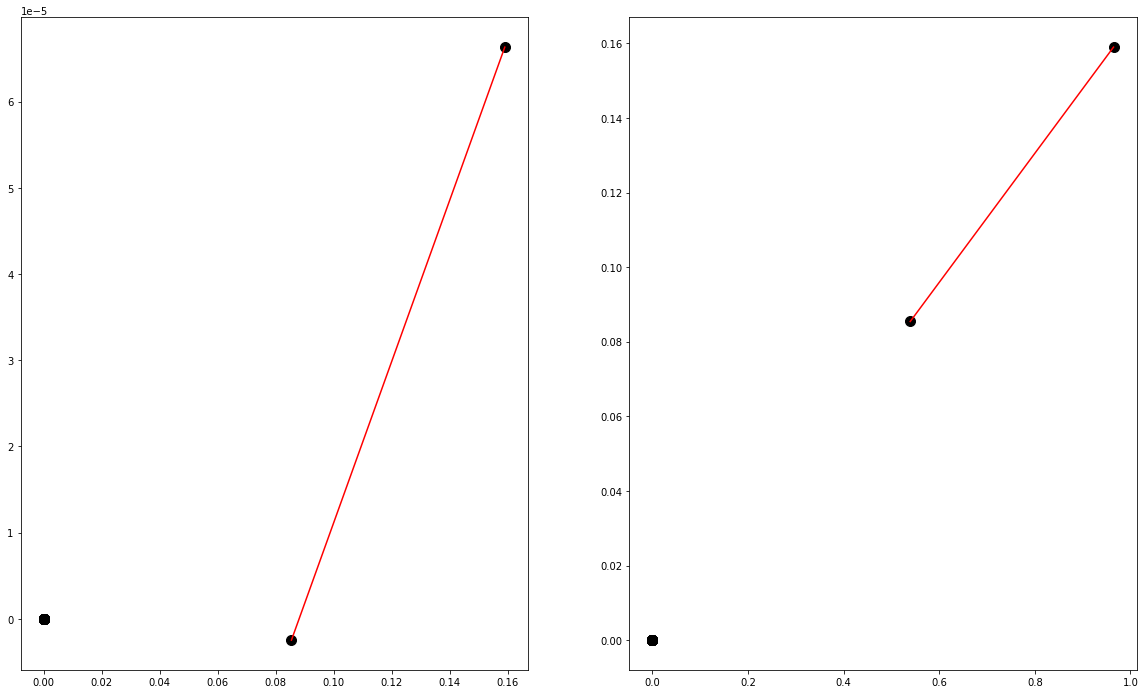

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.2556355  0.22452284 0.2301164  0.63925546 0.54797333 0.39682293
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 0.000, recall 0.000


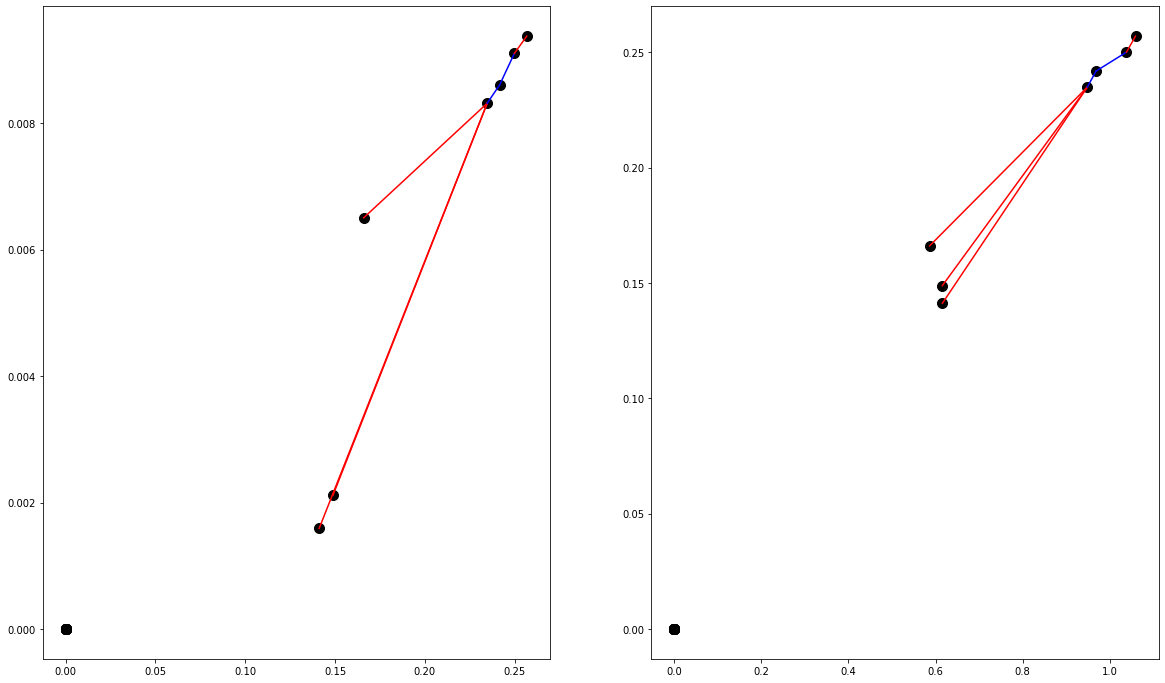

Y = [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1697488  0.15724987 0.18891715 0.15942433 0.14747952 0.17765088
 0.29805326 0.3045236  0.3320963  0.59475833 0.713157   0.44032997
 0.35603887 0.4289678  0.3621593  0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.918, precision 1.000, recall 0.333


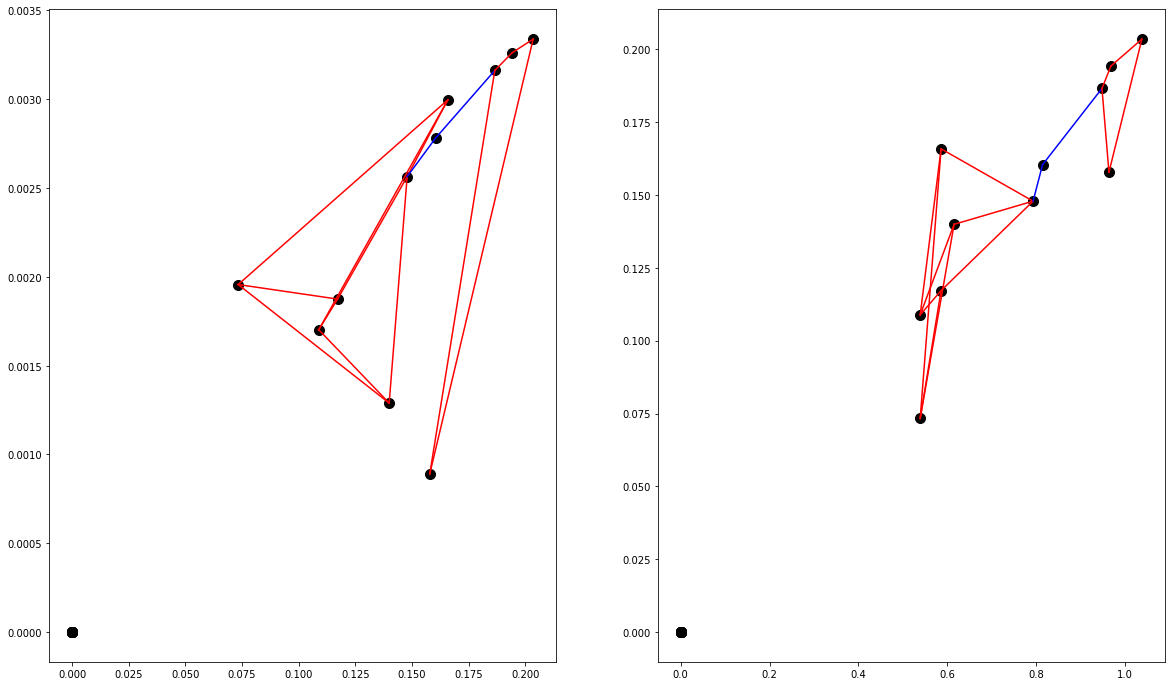

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00016156 0.00015452 0.00038018 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


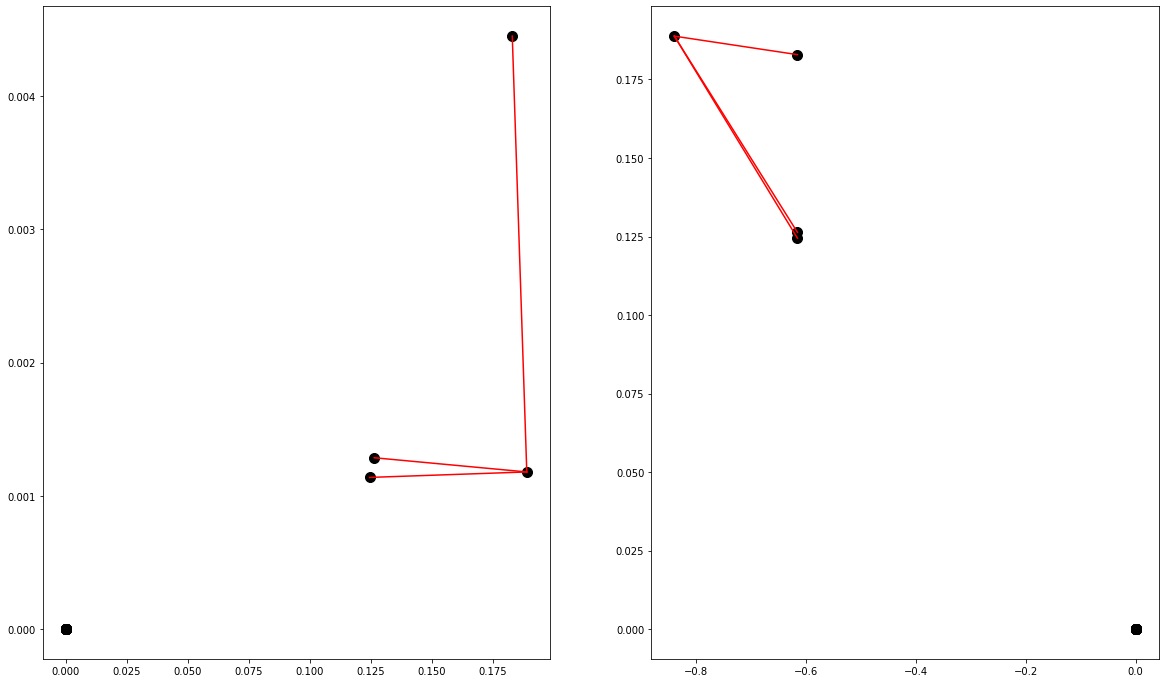

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.999446e-05 4.113579e-05 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


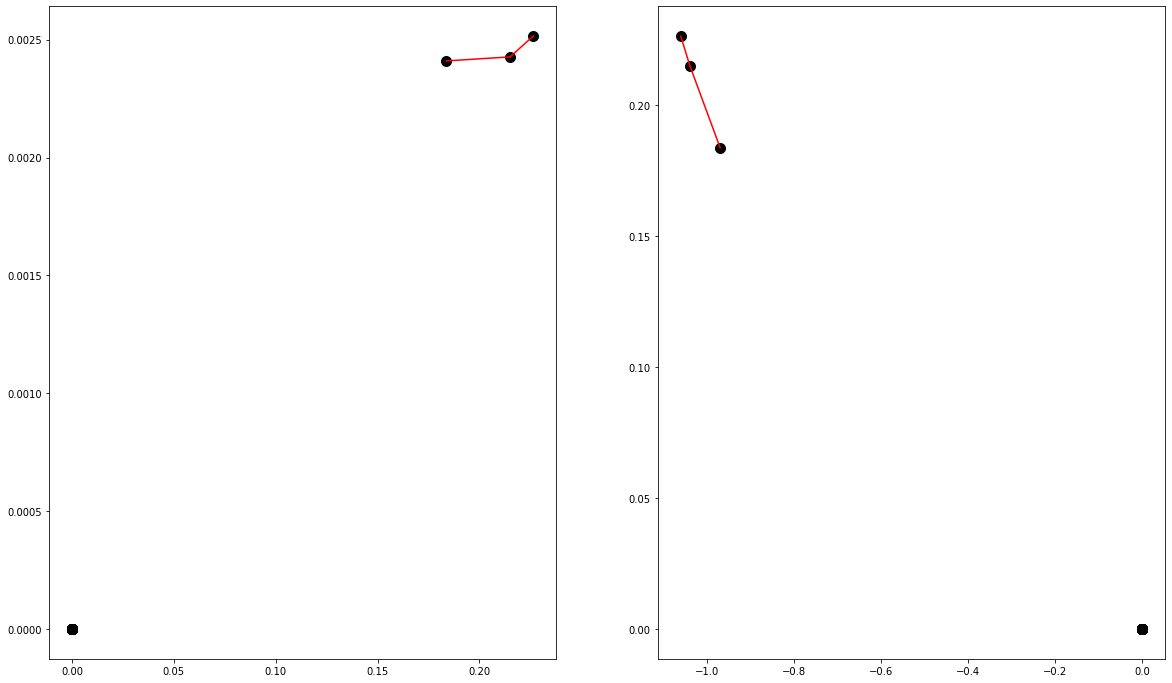

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.13477758 0.1594909  0.13890575 0.19531742 0.30298135 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


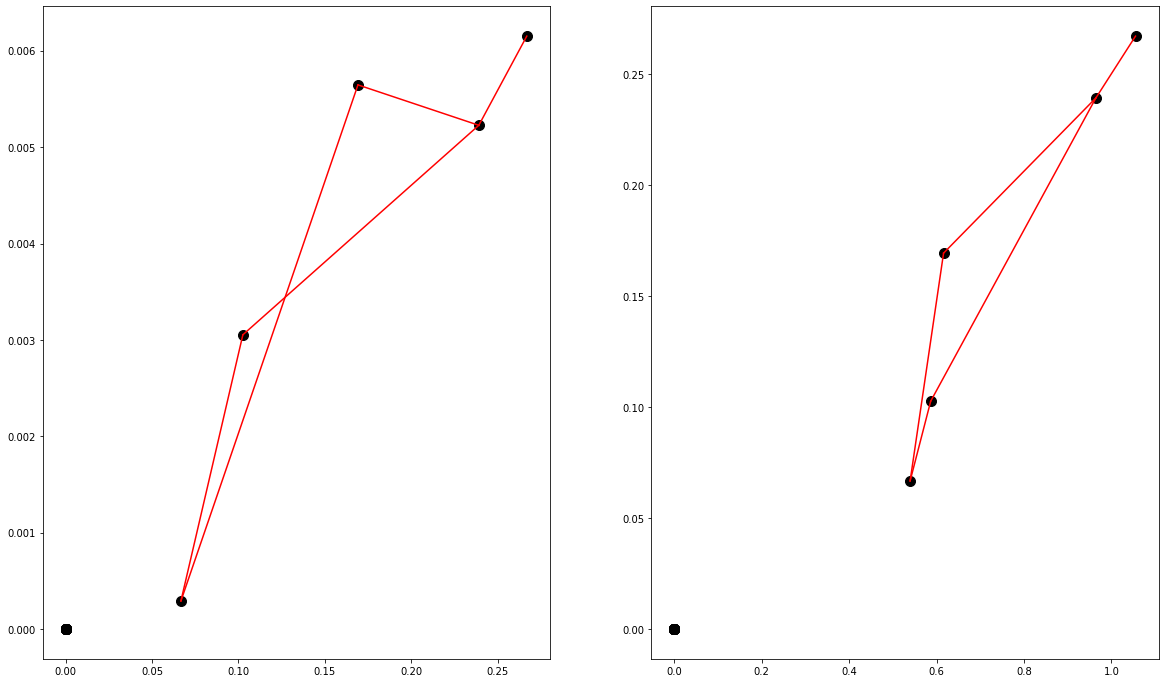

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.08491316 0.08676144 0.06855163 0.06219924 0.06360186 0.07959433
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


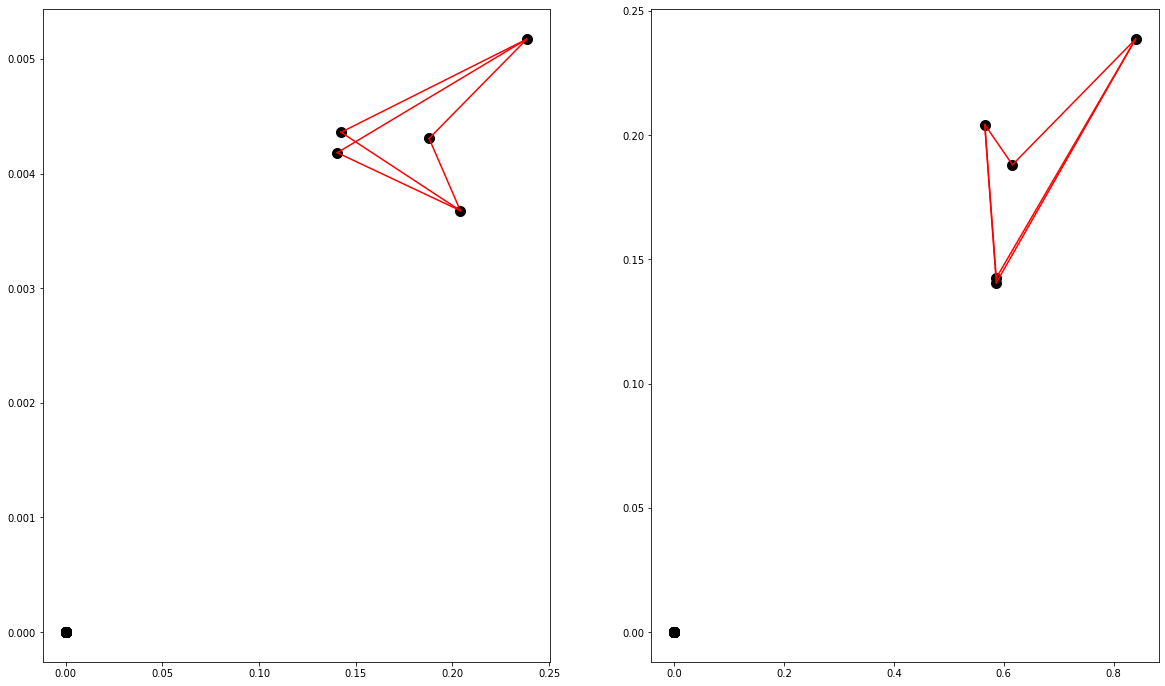

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.12918638 0.06170353 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


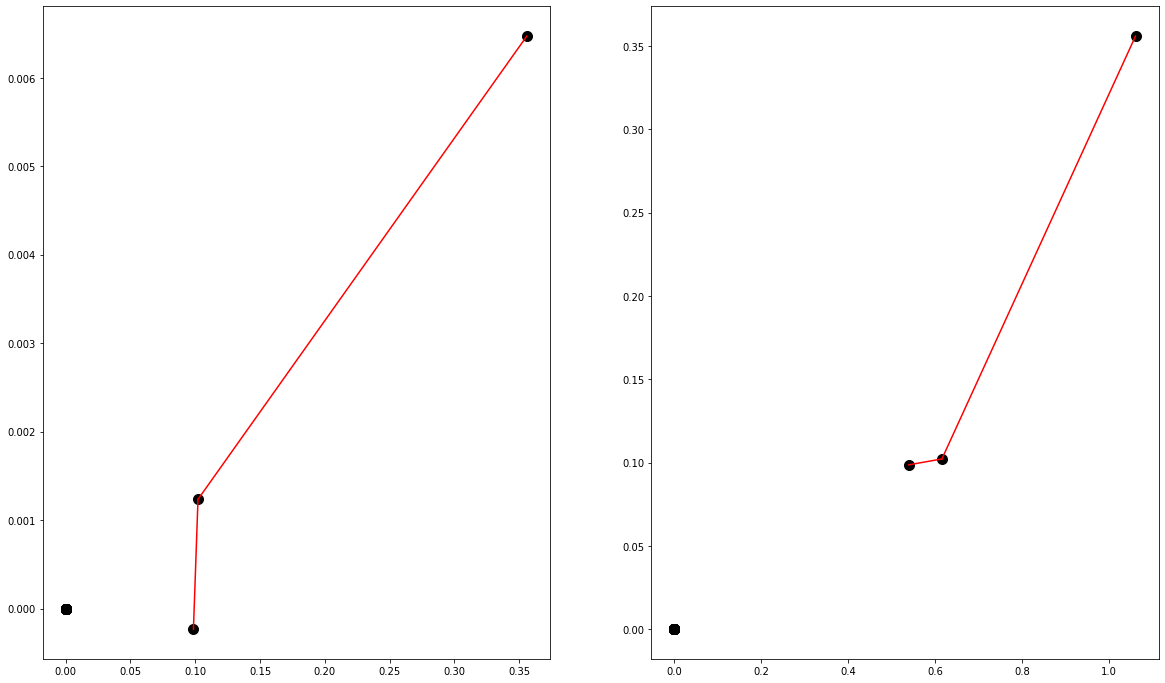

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.12012126 0.11275437 0.3021752  0.12256111 0.12166871 0.11228556
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


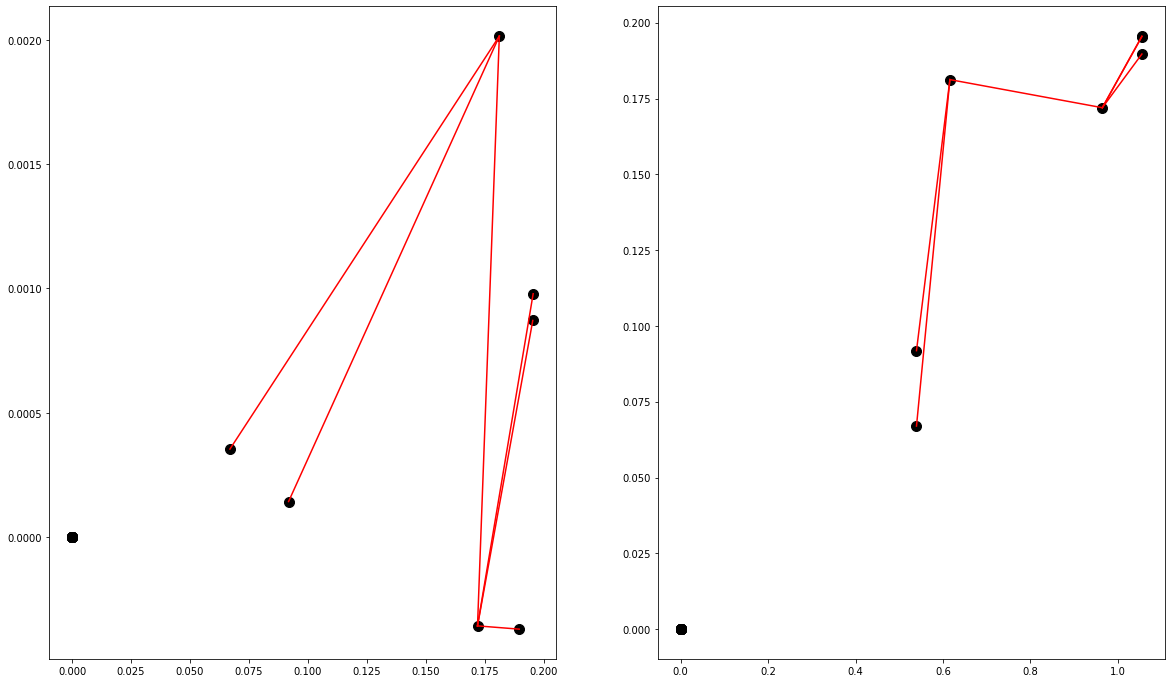

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.08322872 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


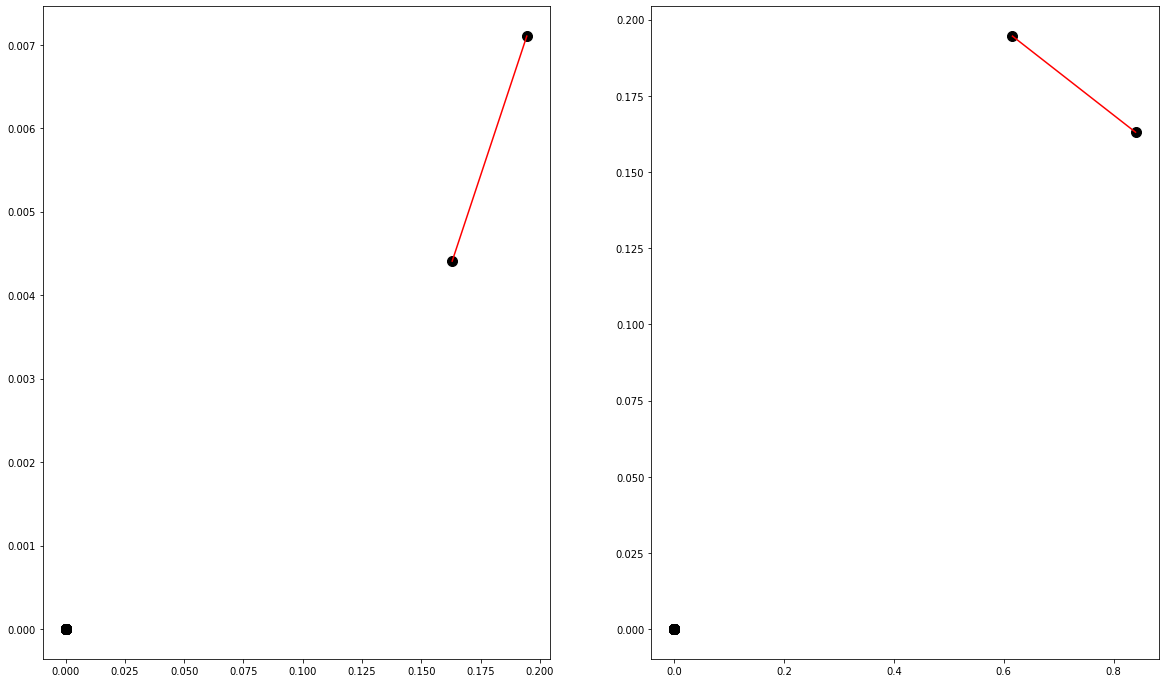

Y = [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.17833406 0.22069621 0.22542493 0.20010322 0.24581316 0.25068745
 0.32140705 0.33813387 0.3347957  0.6501343  0.61864316 0.64544994
 0.51114947 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 1.000, recall 0.667


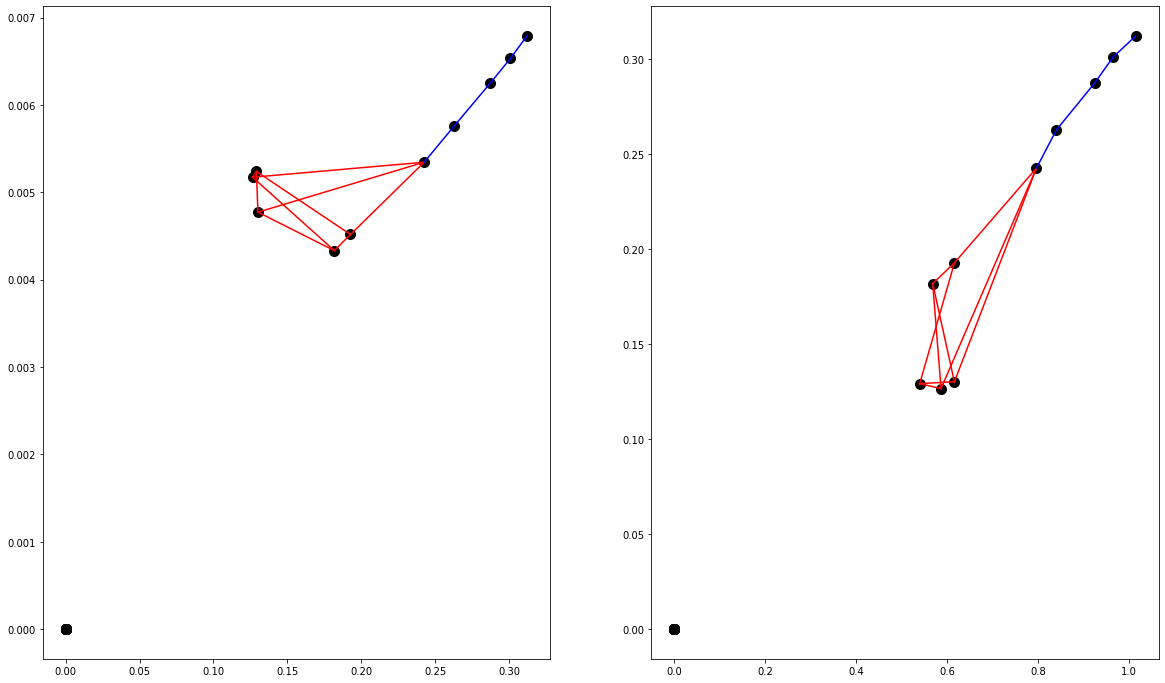

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00029008 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


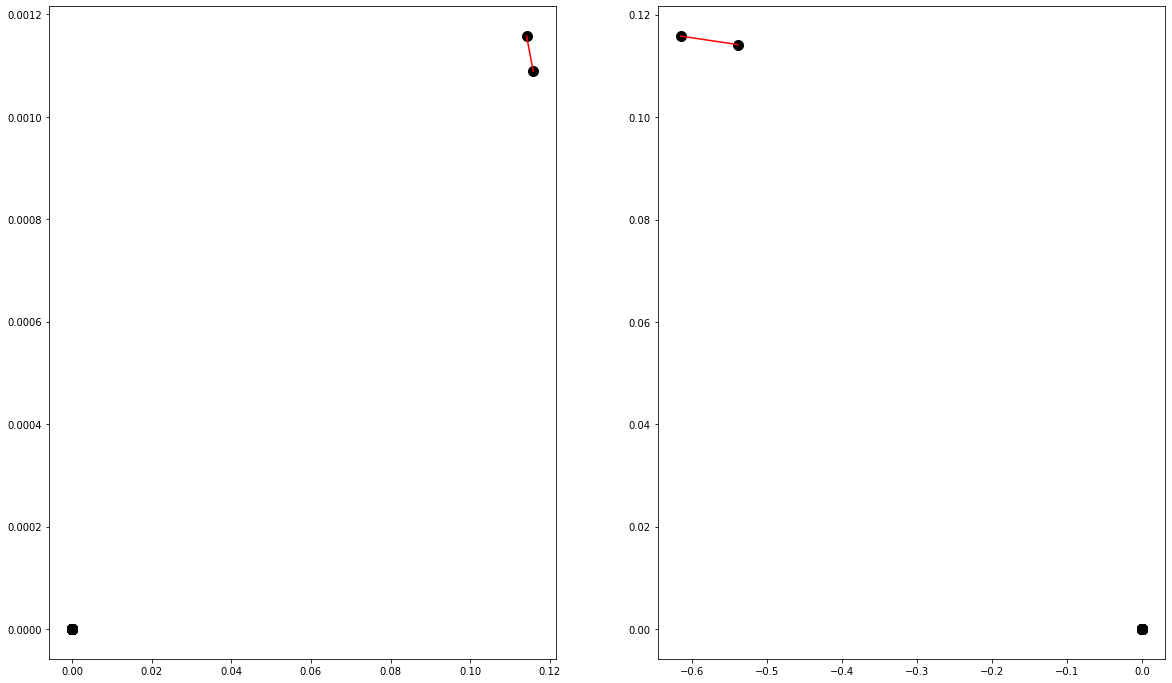

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0002404  0.00010658 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


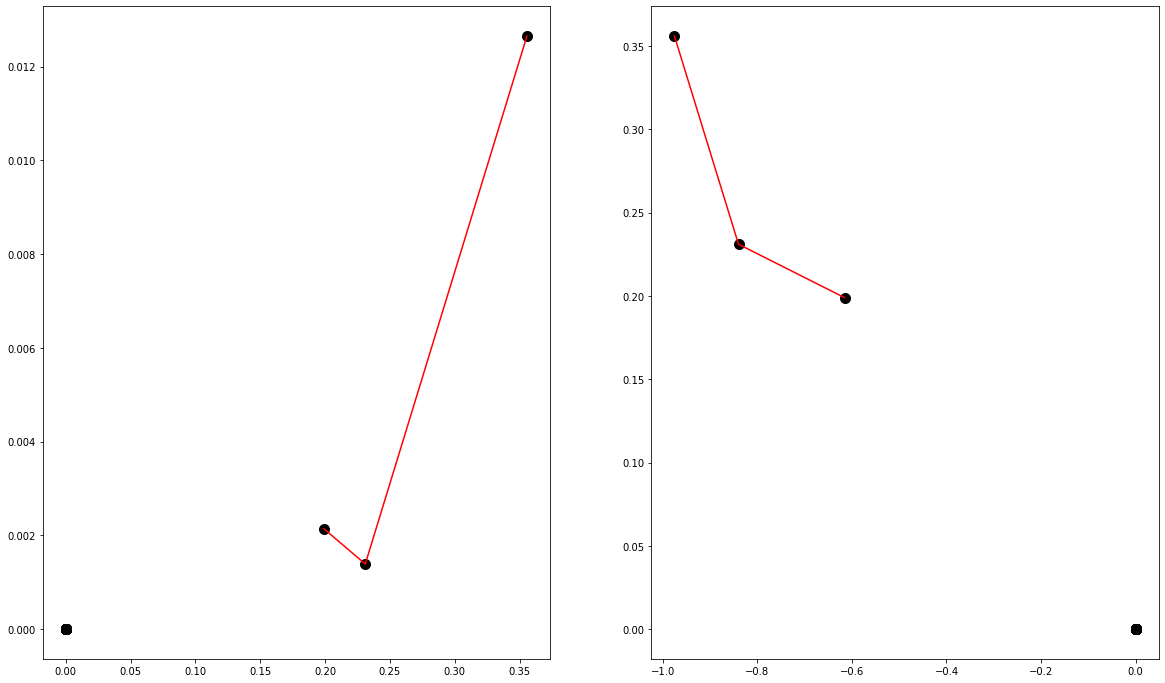

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0001494  0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


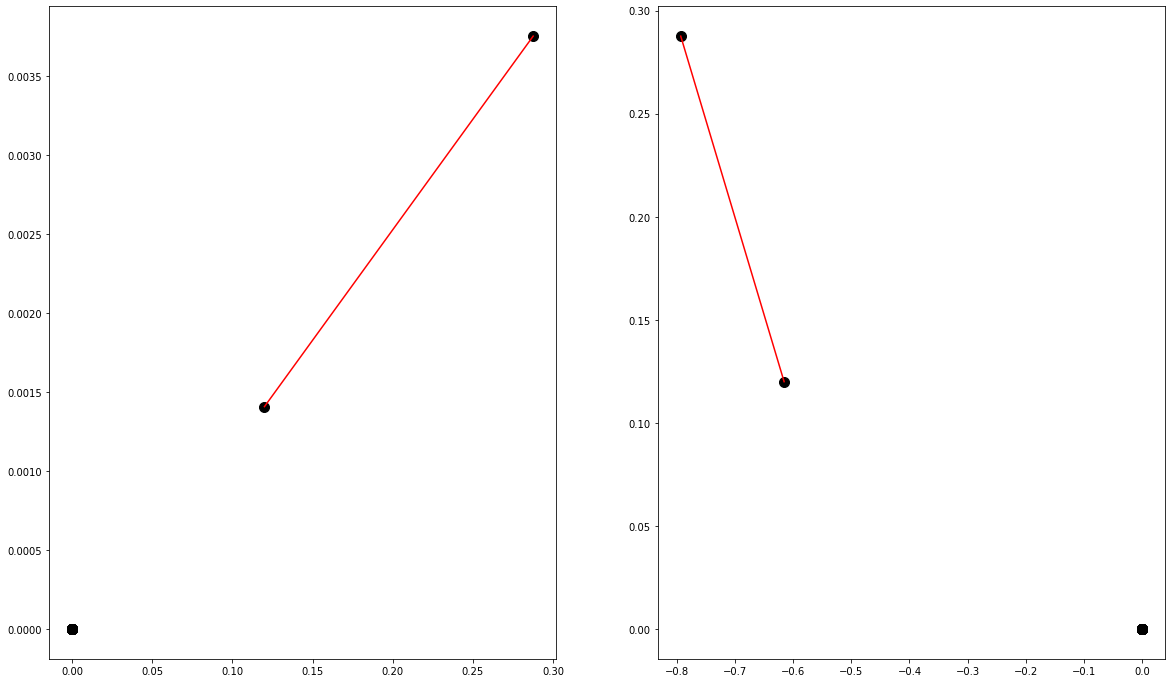

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.09272498 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


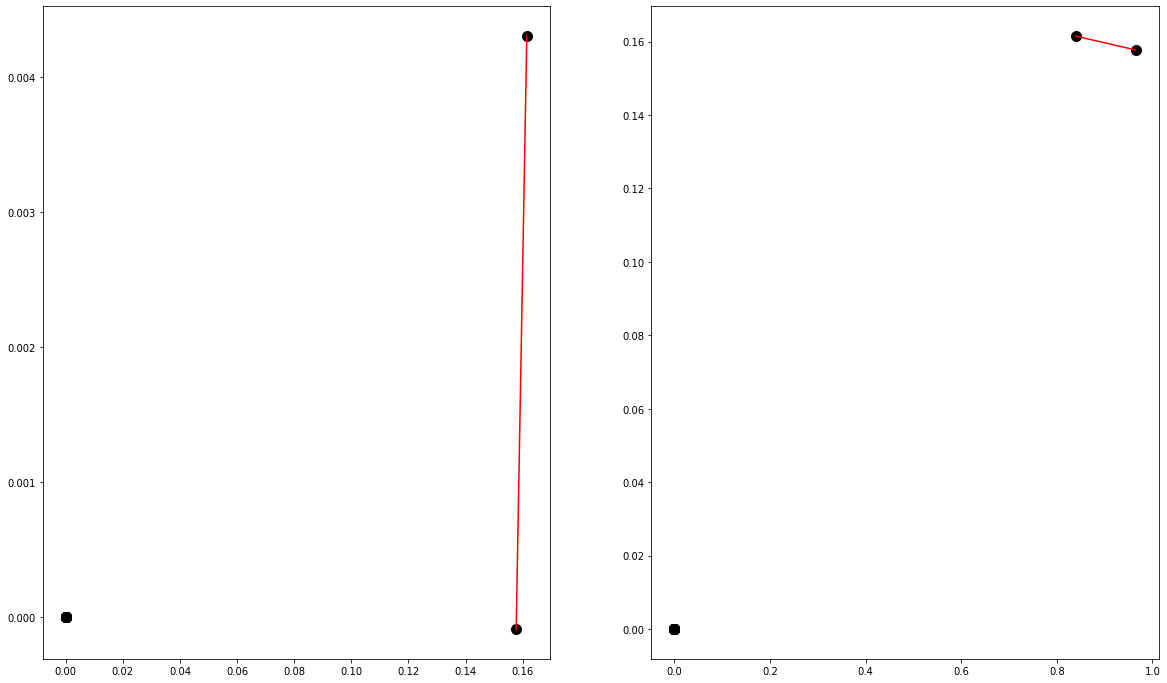

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1340717  0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


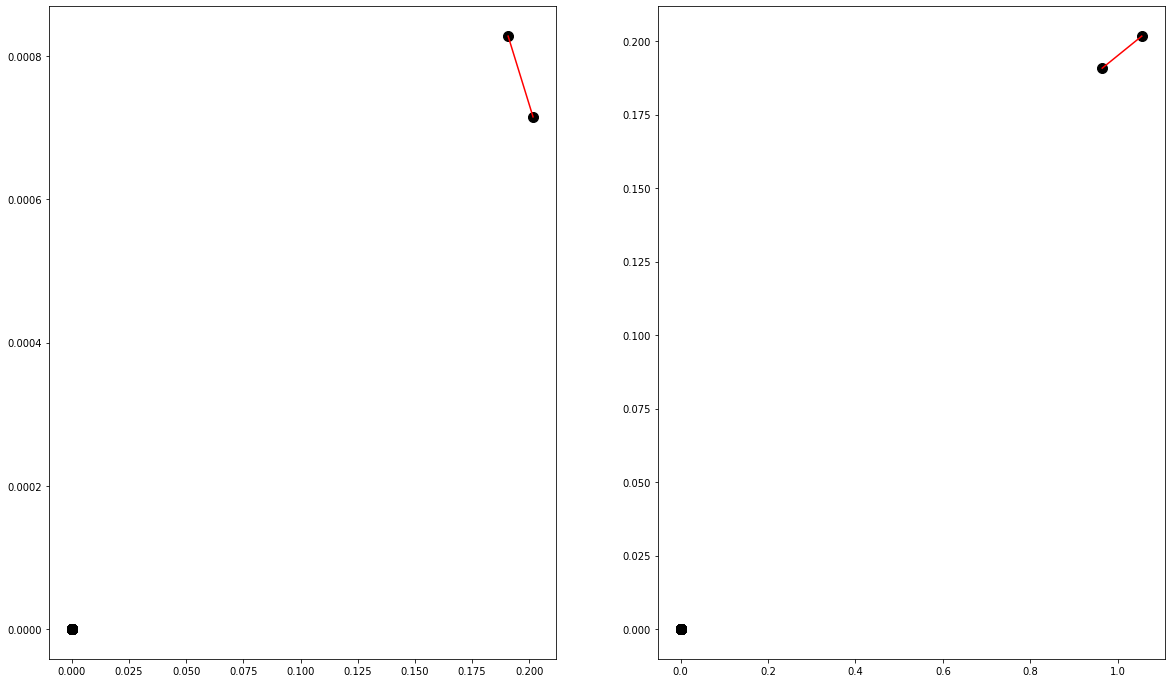

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00012988 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


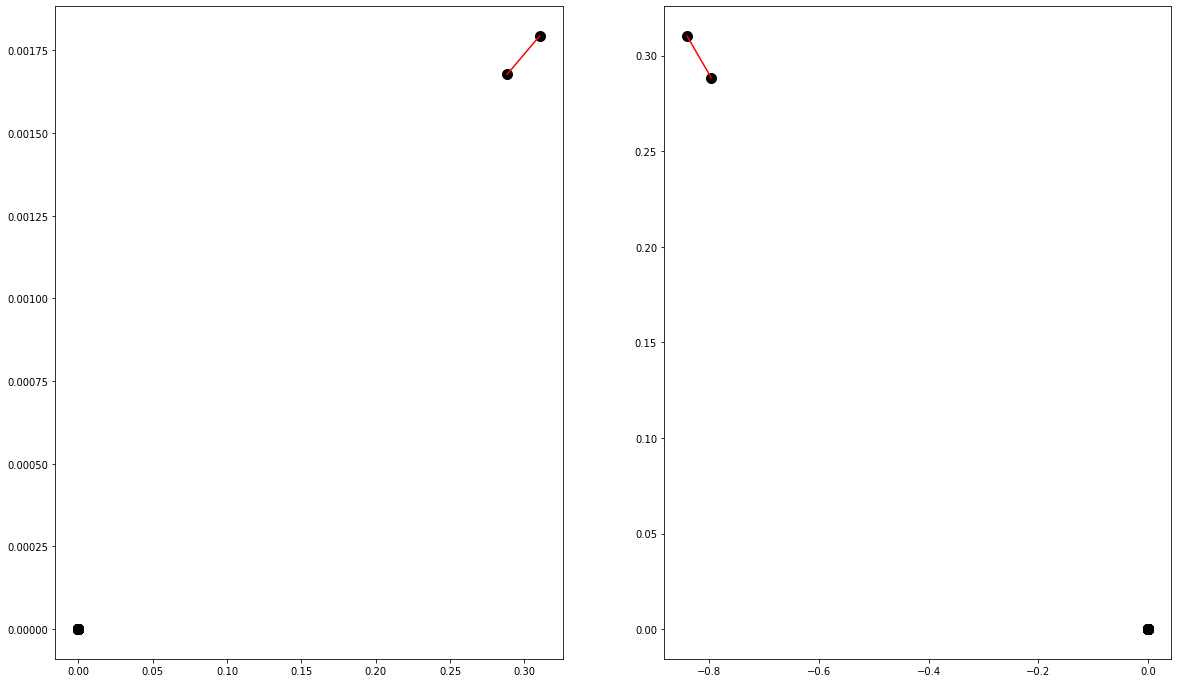

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00027114 0.00033321 0.00102297 0.00125937 0.00057794 0.0007327
 0.00073674 0.00093404 0.0002447  0.00031682 0.00024453 0.00031634
 0.00020369 0.00017983 0.00023791 0.00014925 0.00013174 0.00017372
 0.00019636 0.0001583  0.00012122 0.00015287 0.00013142 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


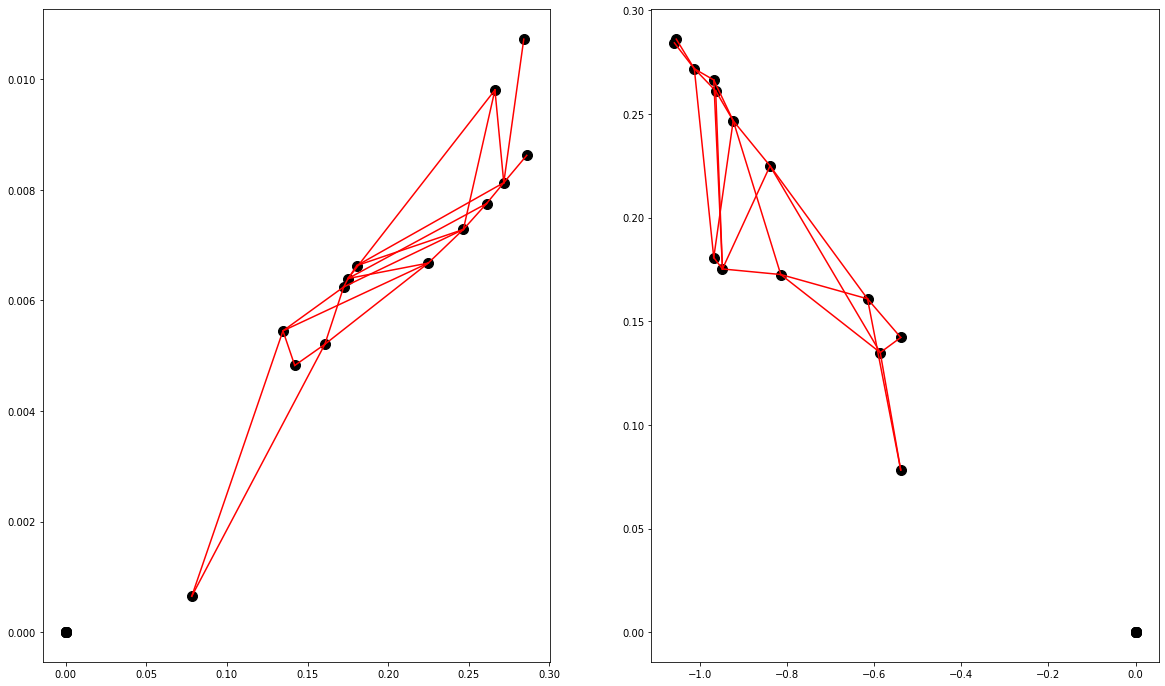

Y = [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.400185   0.5932496  0.65275985 0.54186803 0.41288167 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 1.000, recall 0.600


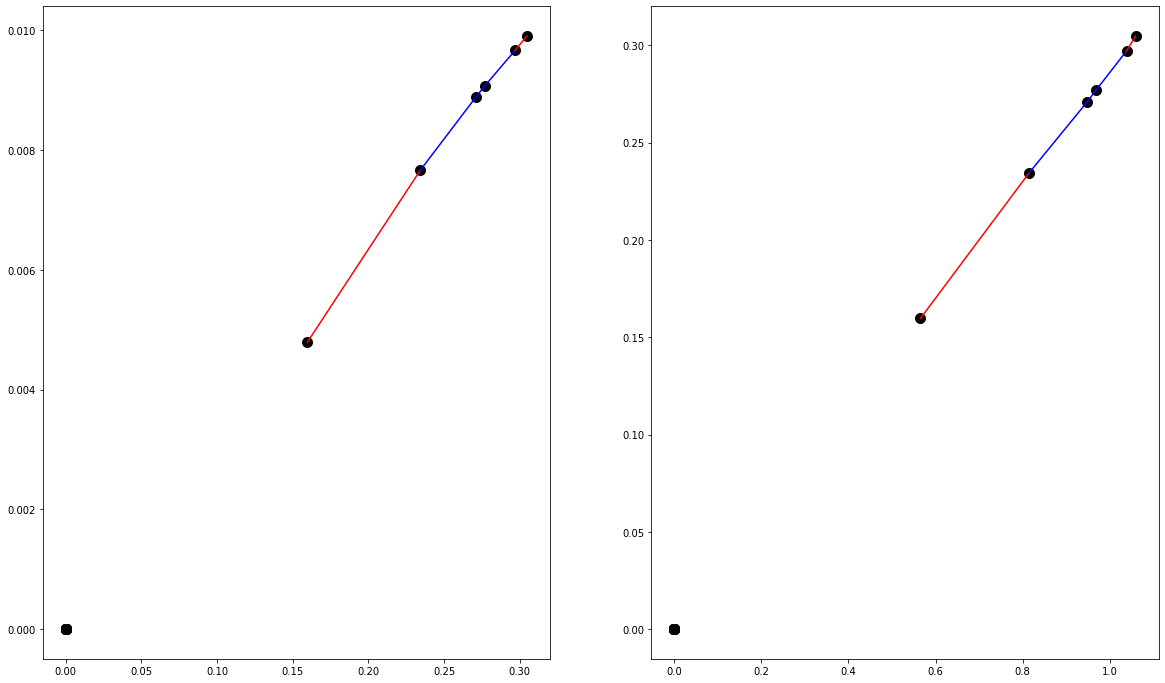

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00047688 0.0004401  0.00048077 0.00037088 0.00046888 0.00113798
 0.0010532  0.00115922 0.00088765 0.00113028 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


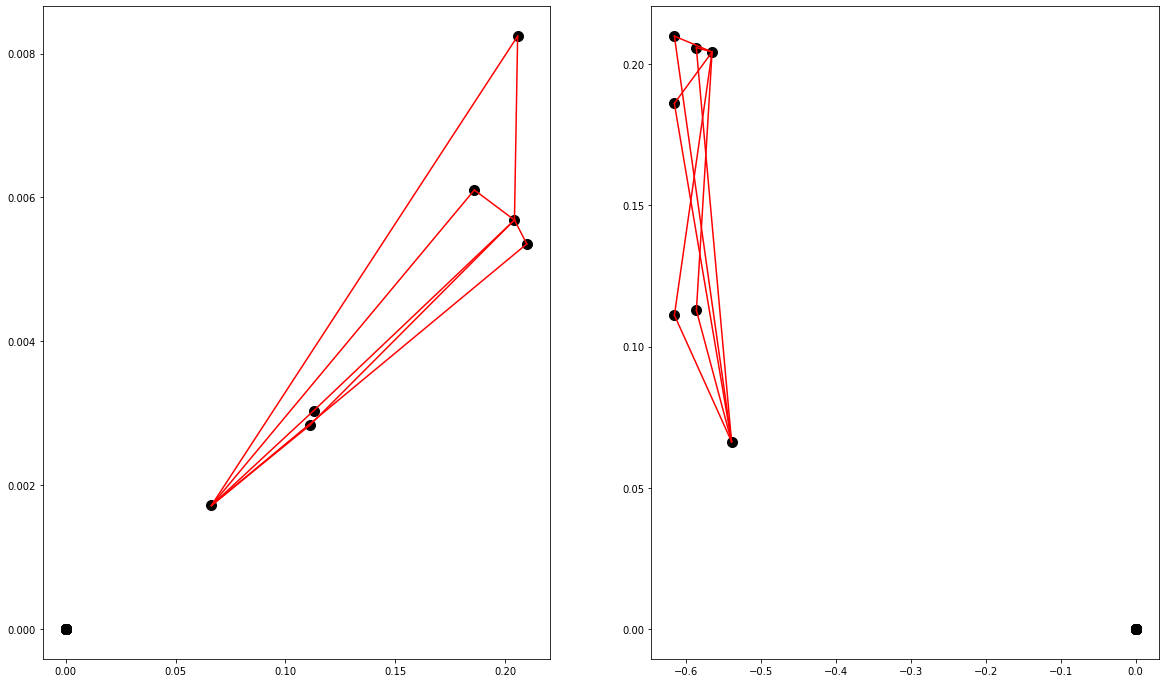

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.2371443e-04 5.0203467e-04 6.1338680e-05 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798942e-03 1.4798942e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


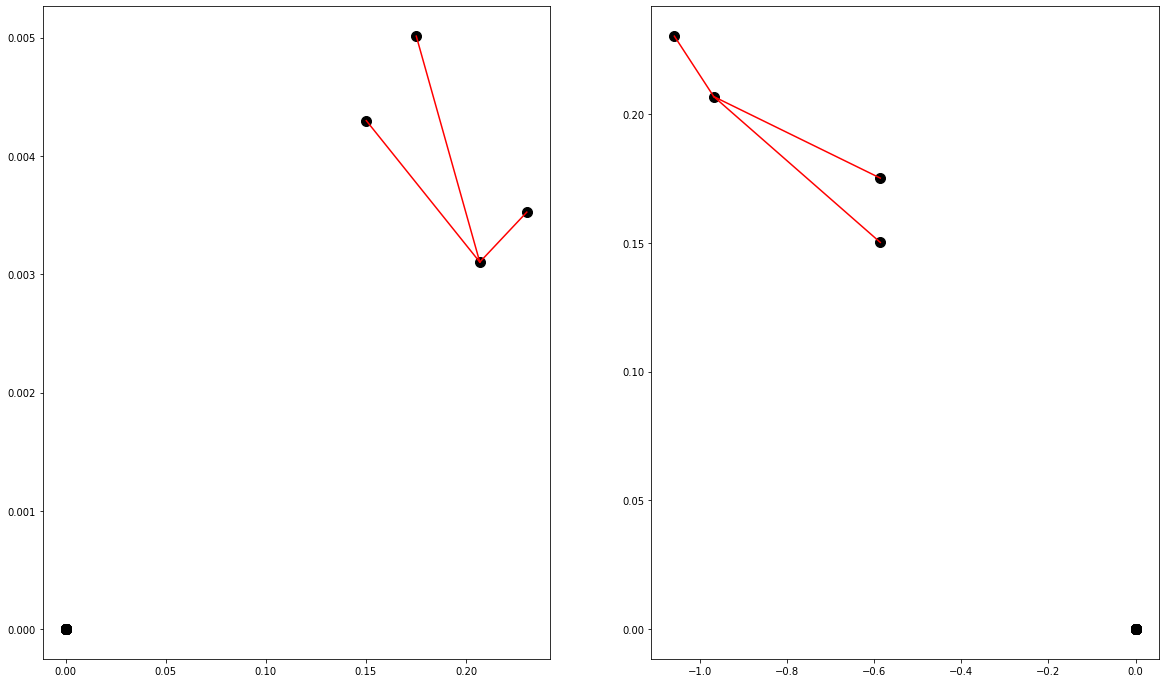

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1600348  0.16269565 0.15787071 0.12113844 0.42718574 0.35734206
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


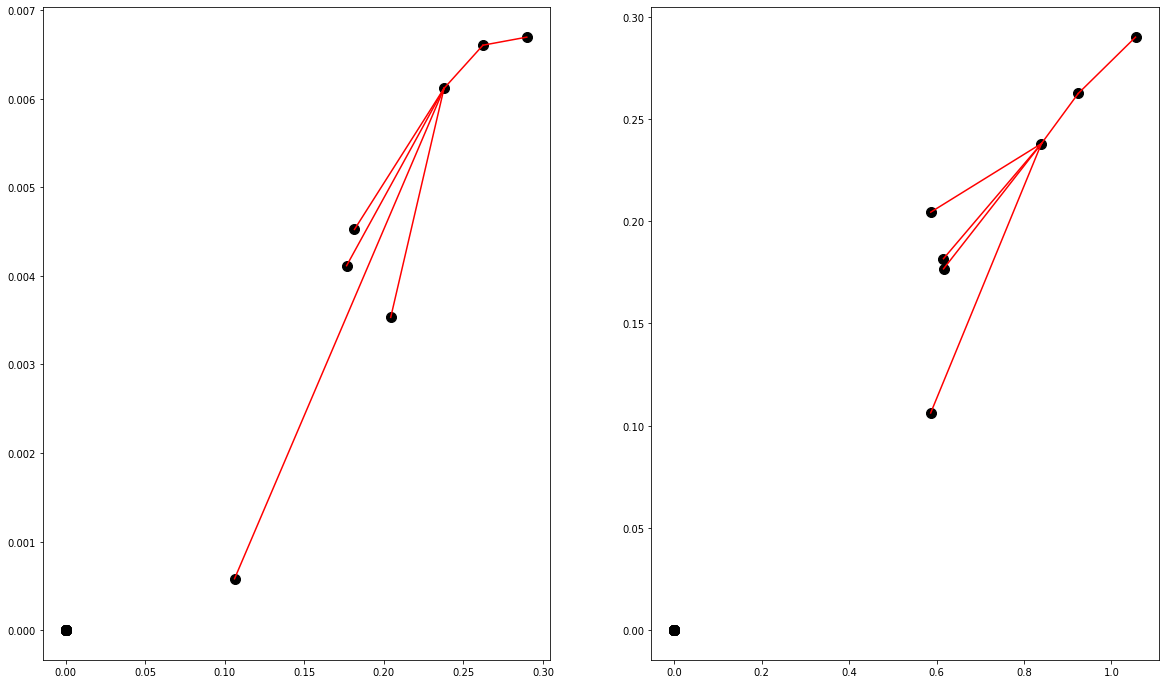

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00039889 0.0005925  0.00059808 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


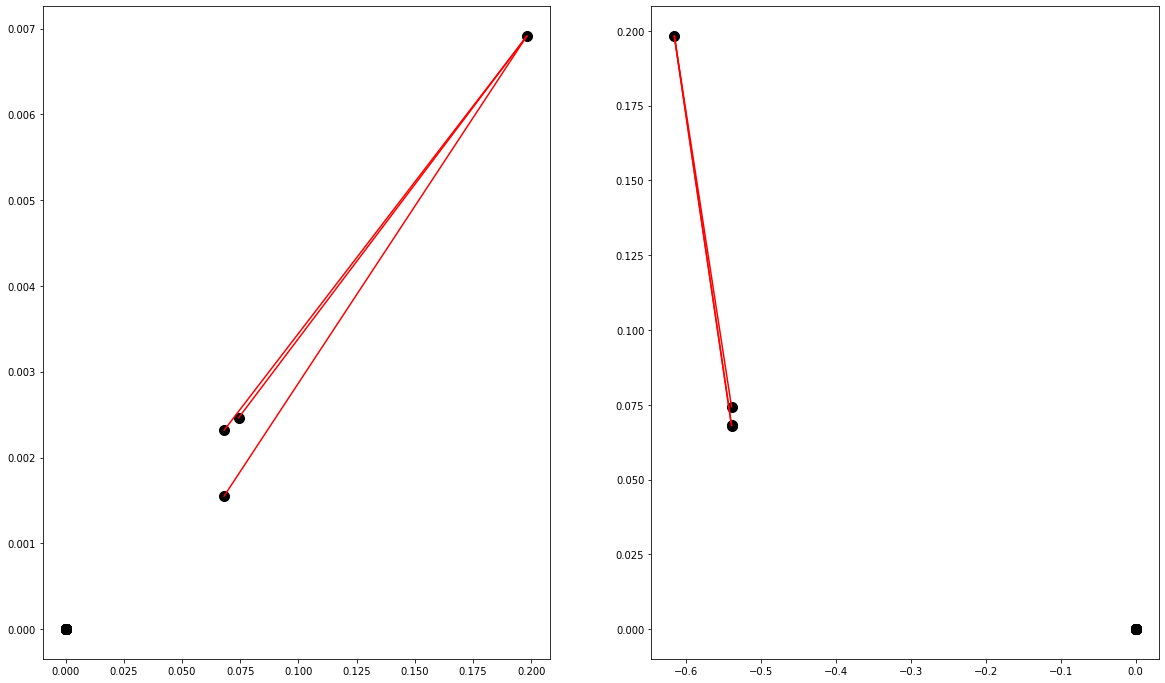

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0002979  0.0004299  0.00047187 0.00088395 0.00127089 0.00139768
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


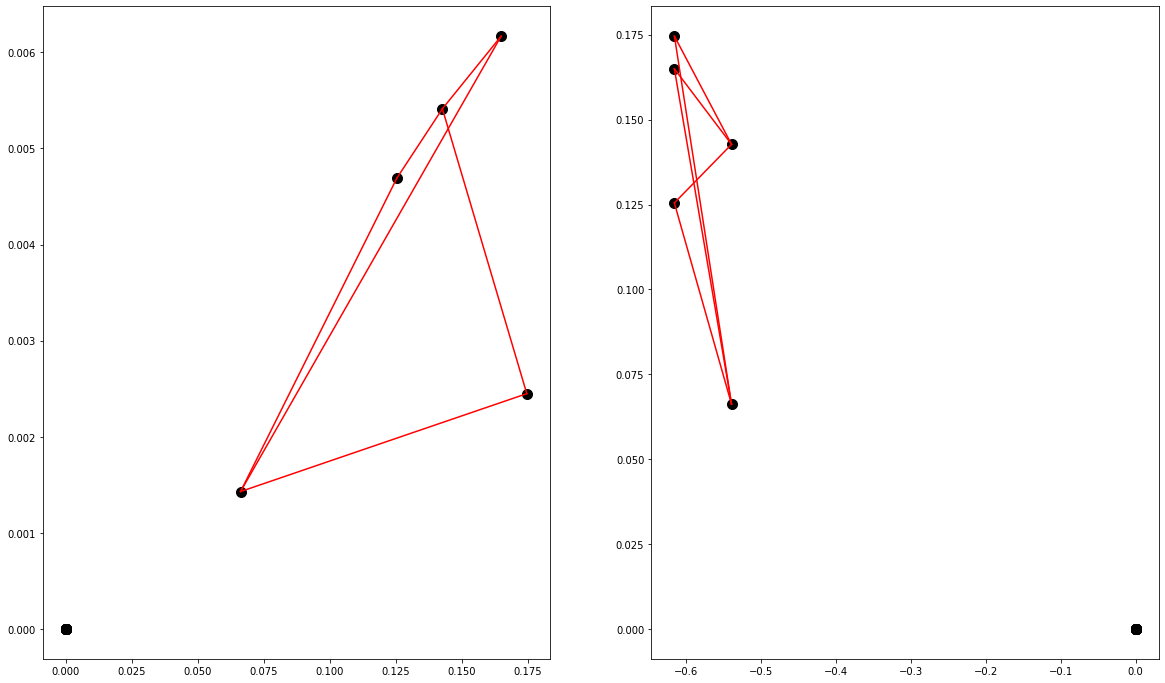

Y = [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20585626 0.17455761 0.24015783 0.20519435 0.5411553  0.5302802
 0.25351837 0.3422761  0.14057706 0.1867144  0.1846632  0.15239365
 0.20080458 0.19867341 0.31345996 0.40932706 0.3298802  0.42462492
 0.32825366 0.4230228  0.26441246 0.36259067 0.22367603 0.2929492
 0.39196128 0.25015143 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.878, precision 0.500, recall 0.167


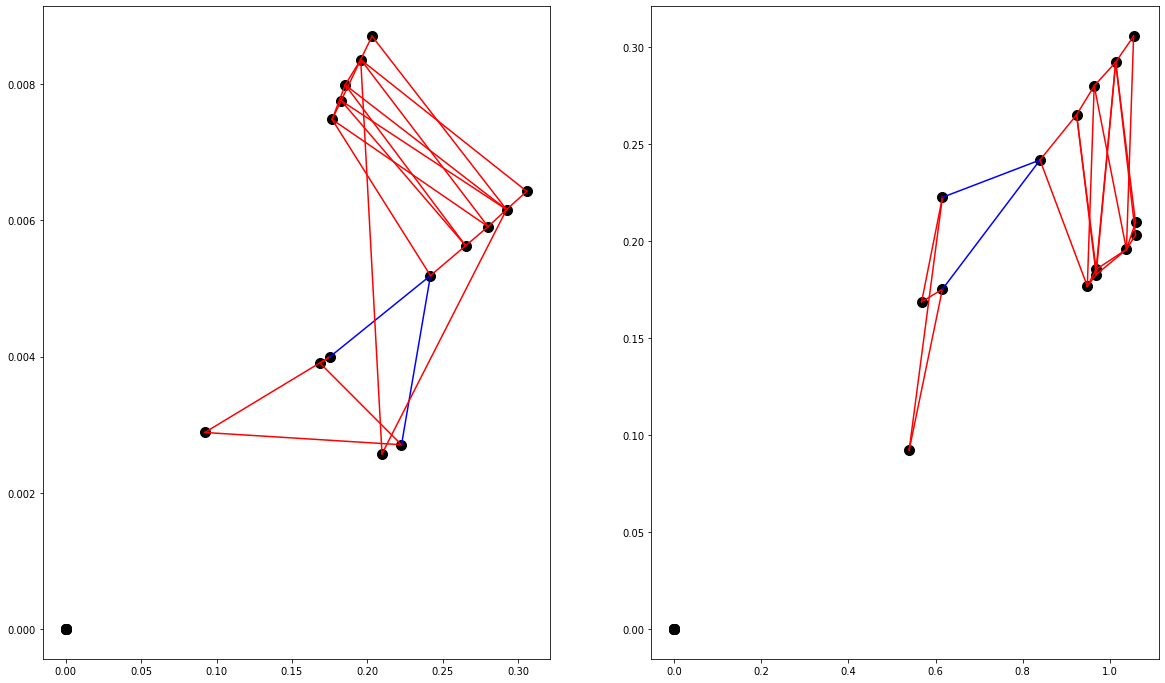

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.12765822 0.13775879 0.1209831  0.13066323 0.22482255 0.23964904
 0.33470097 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


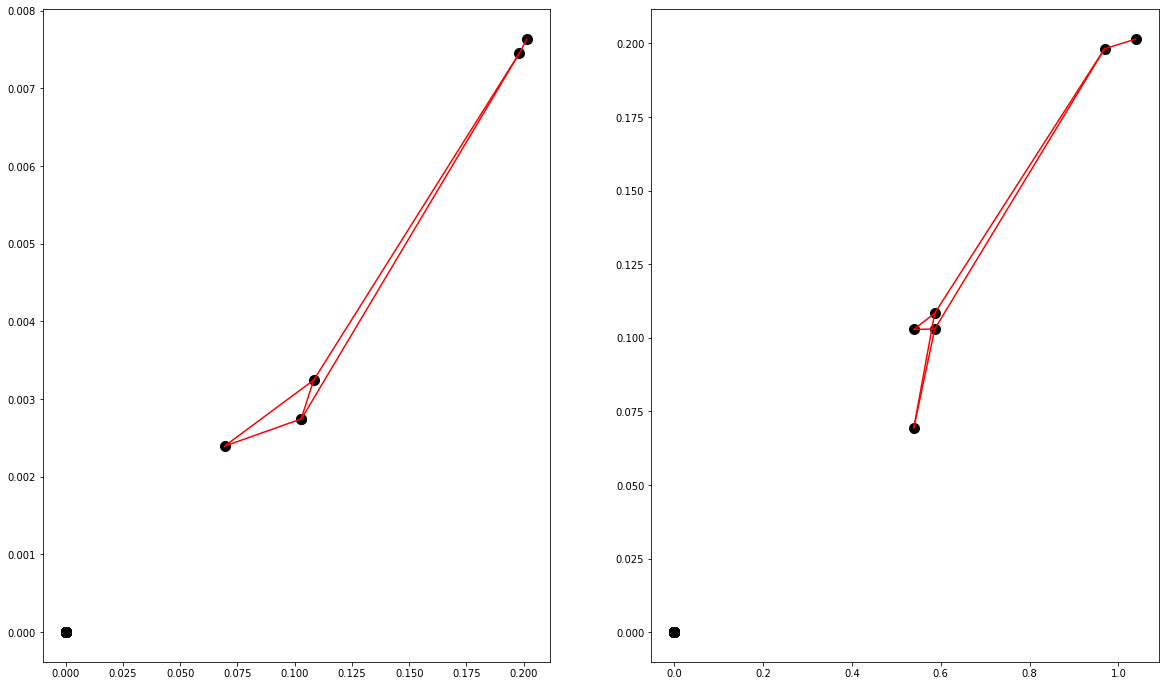

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.0006099  0.00062965 0.00012203 0.00011671 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


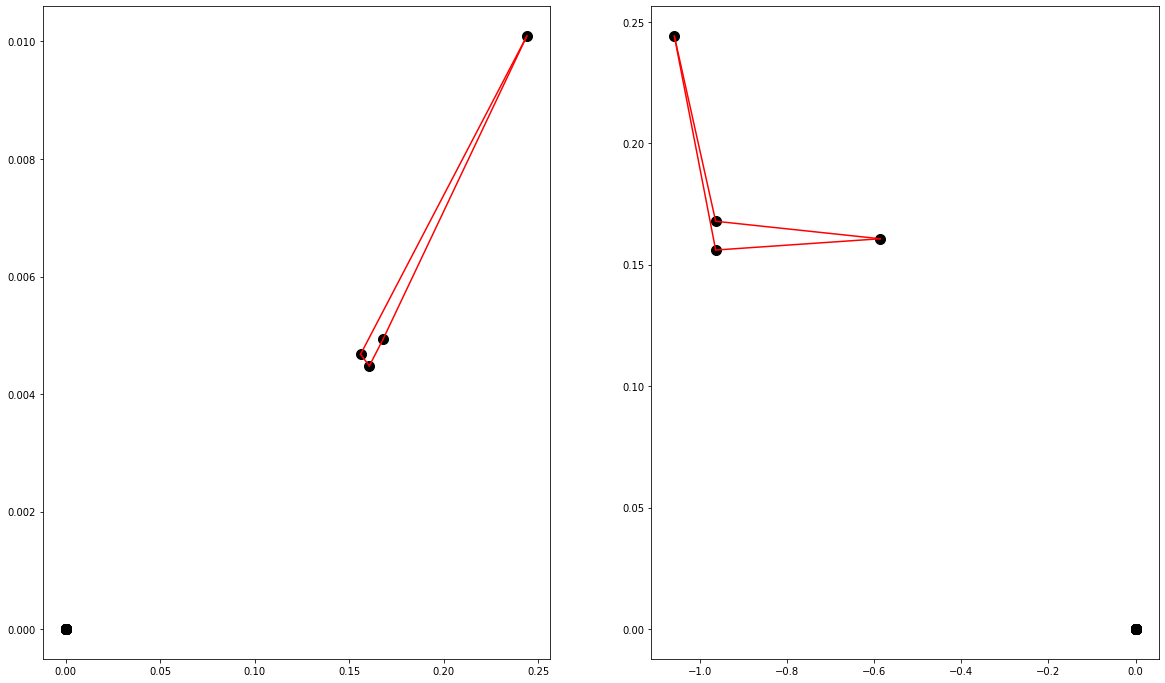

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.08133431 0.153755   0.09113849 0.13972427 0.20738281 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


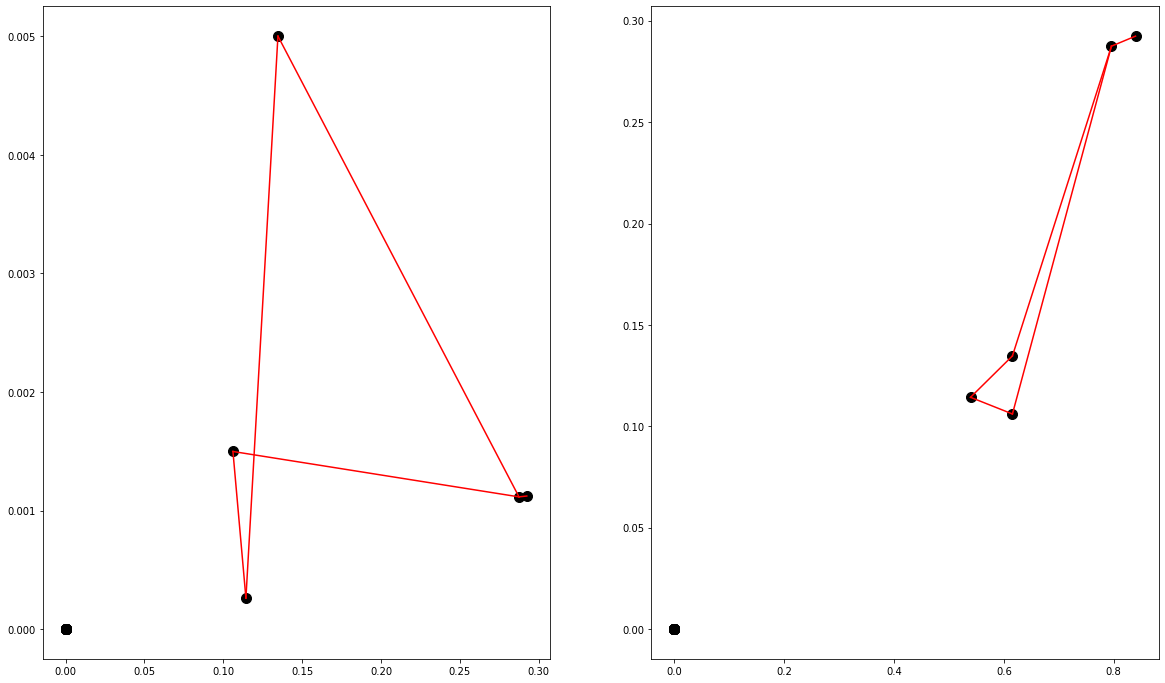

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.31756386 0.13103129 0.12065808 0.2595931  0.21630721 0.20765002
 0.30705425 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


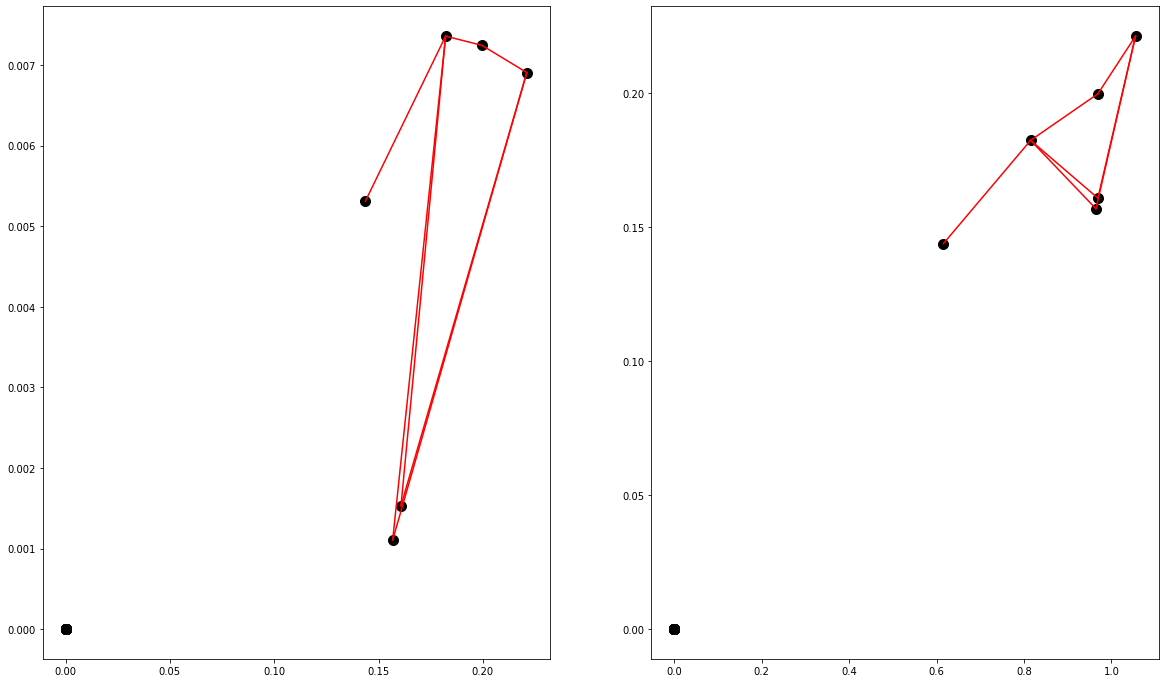

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00042896 0.00032174 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


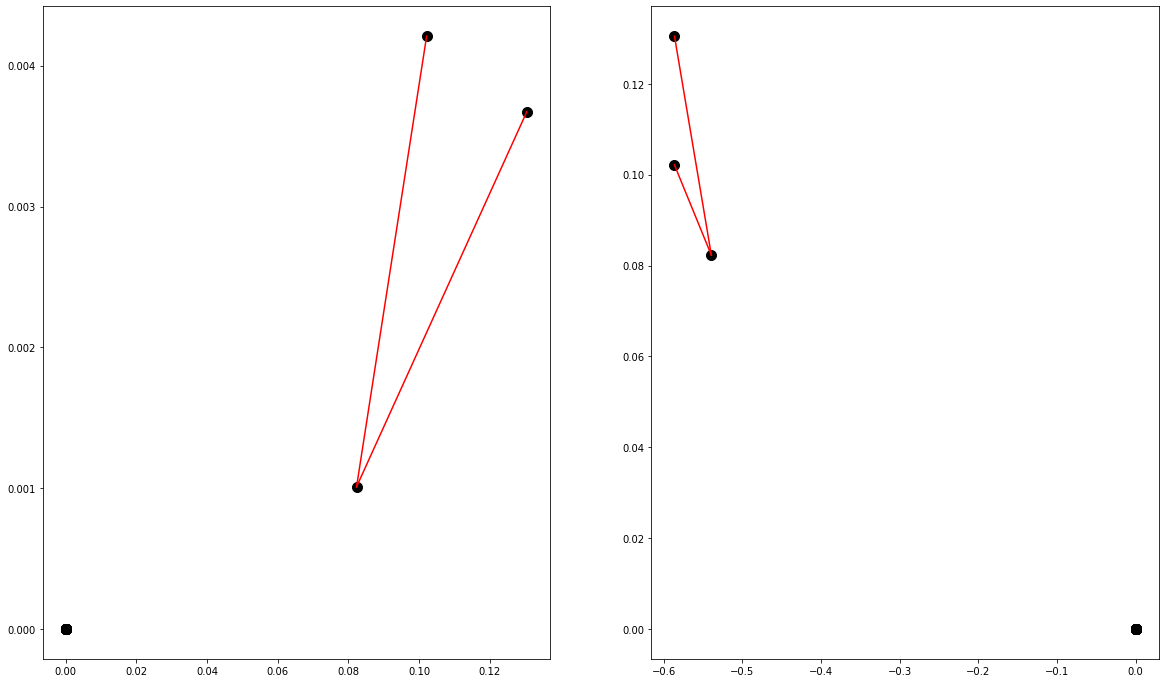

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00048229 0.00051375 0.00106621 0.00113116 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


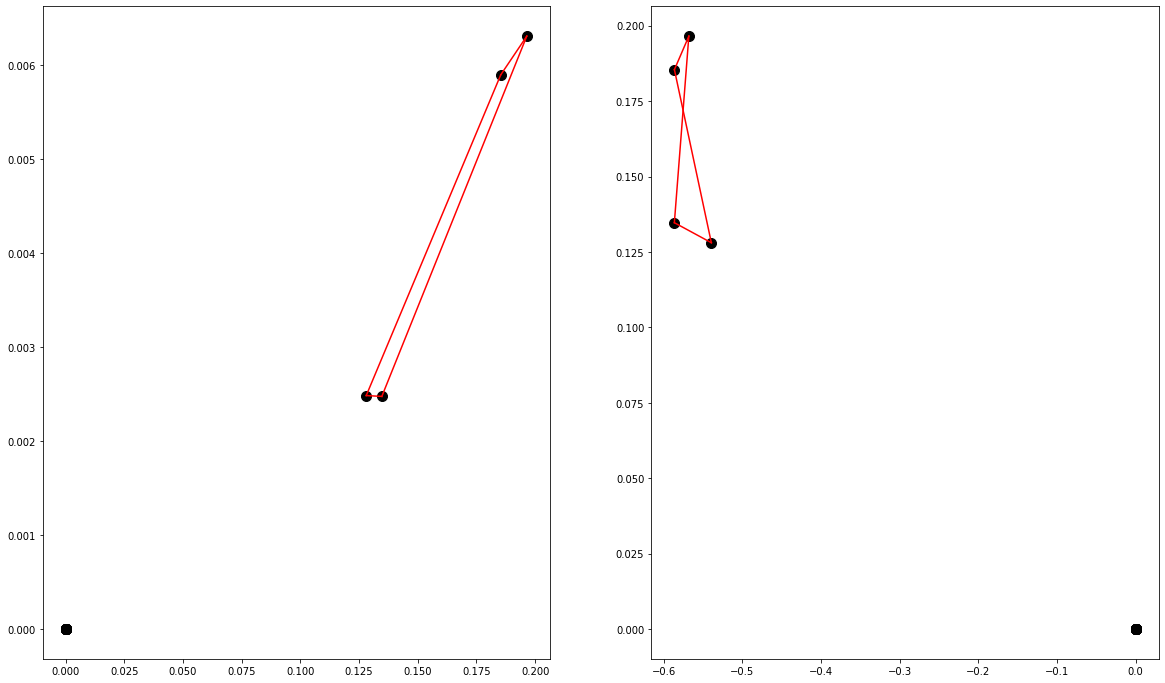

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00057643 0.00016714 0.00016806 0.0001486  0.00014847 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


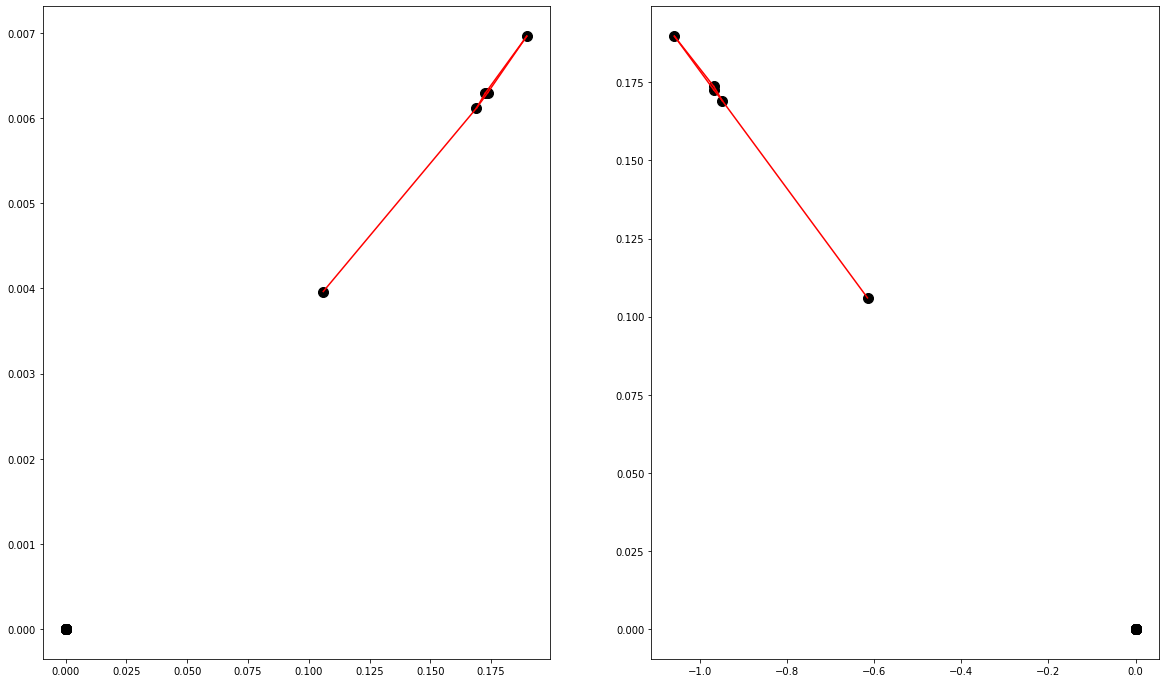

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.999446e-05 4.113579e-05 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03
 1.479895e-03 1.479895e-03 1.479895e-03 1.479895e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


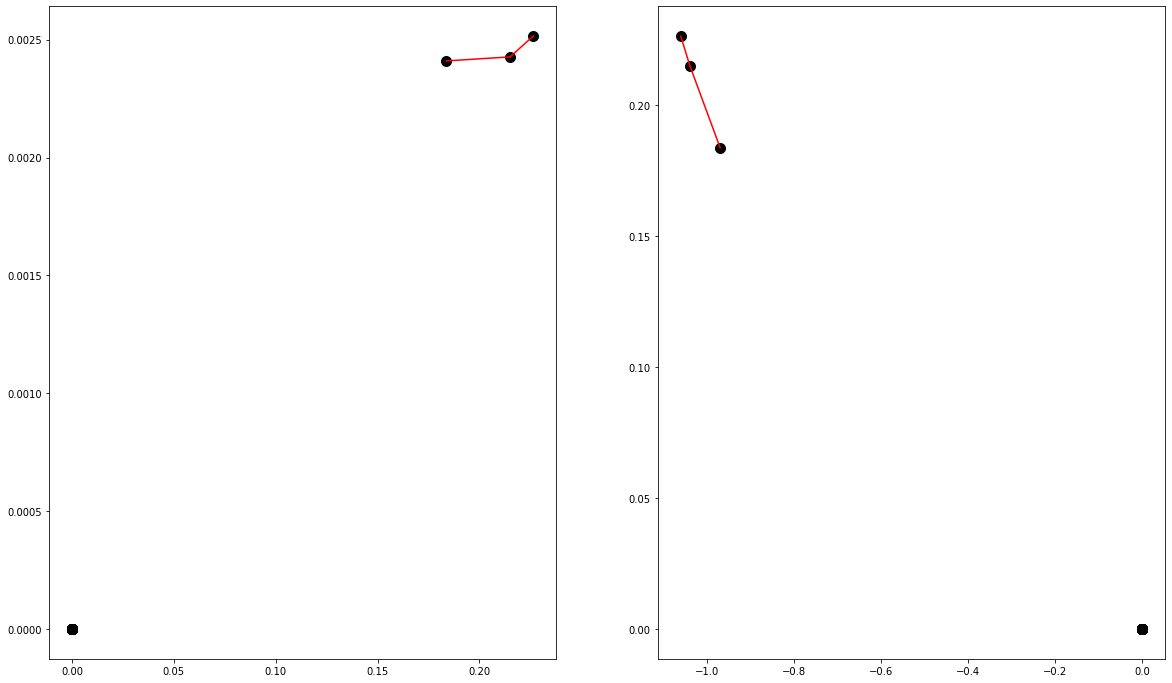

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00060099 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


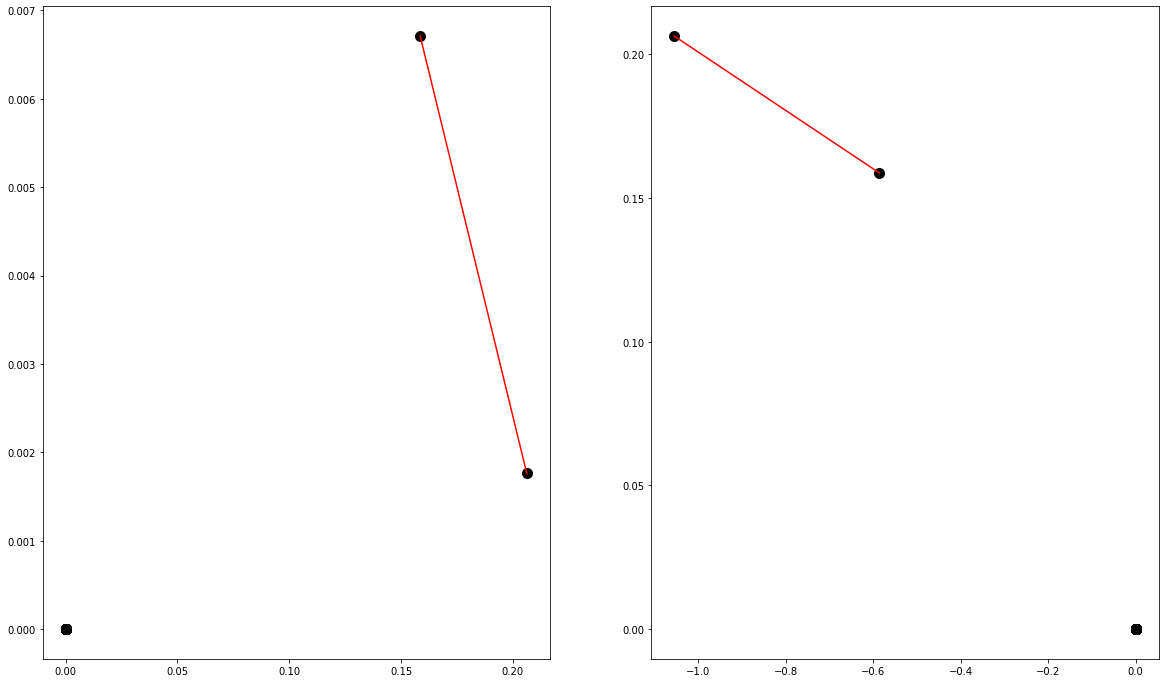

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.02806608 0.02907016 0.02586221 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


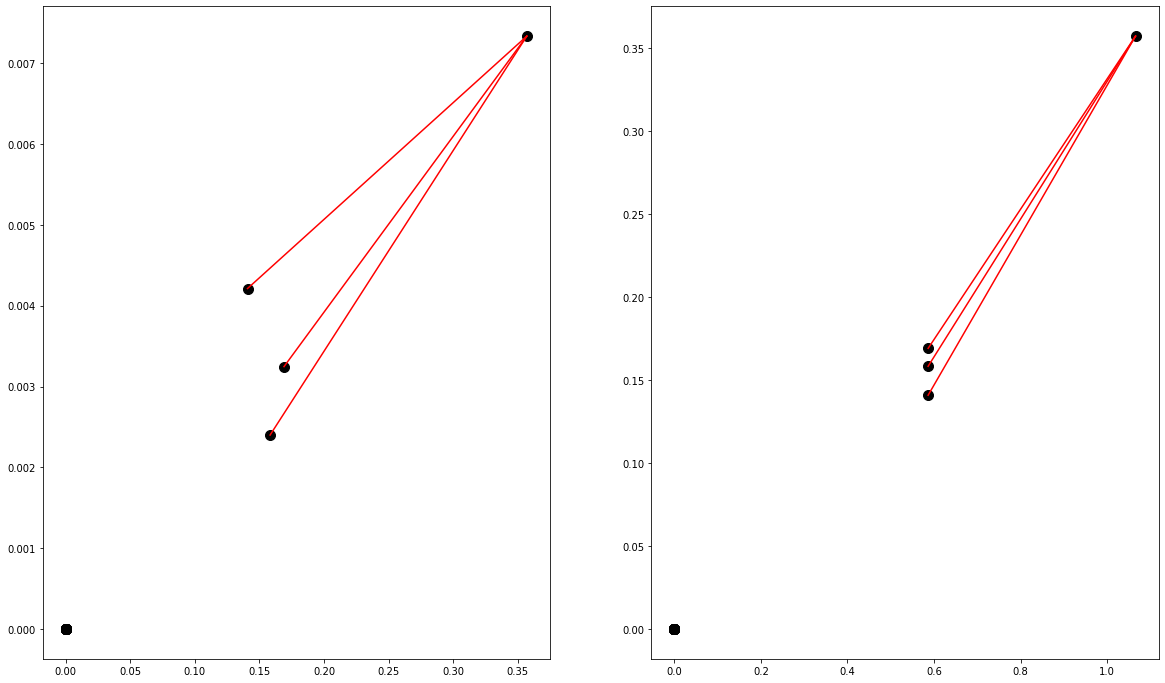

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00021716 0.0003488  0.00052189 0.00083821 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


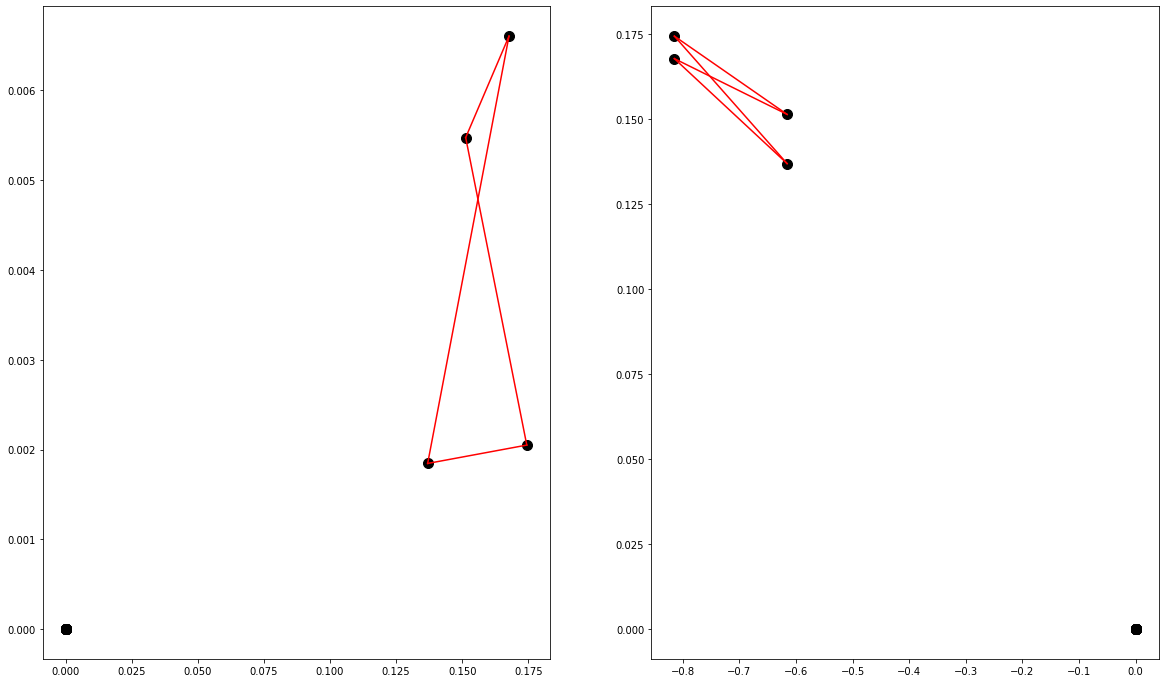

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00066134 0.00077699 0.00081679 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


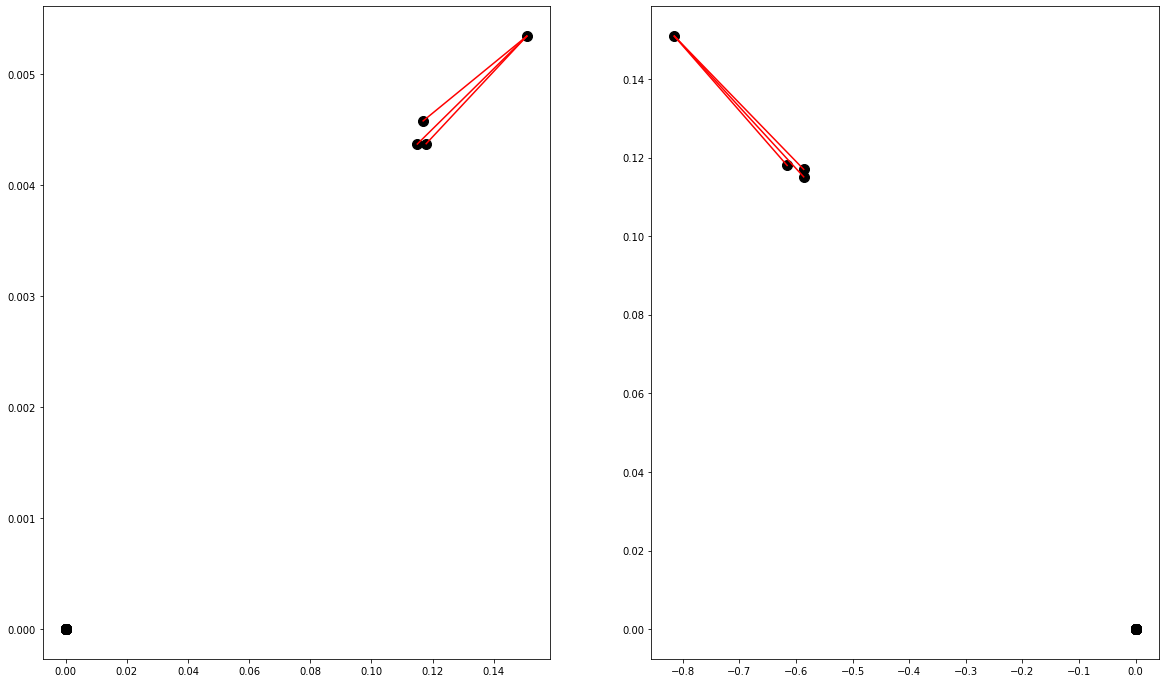

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04971541 0.04845585 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


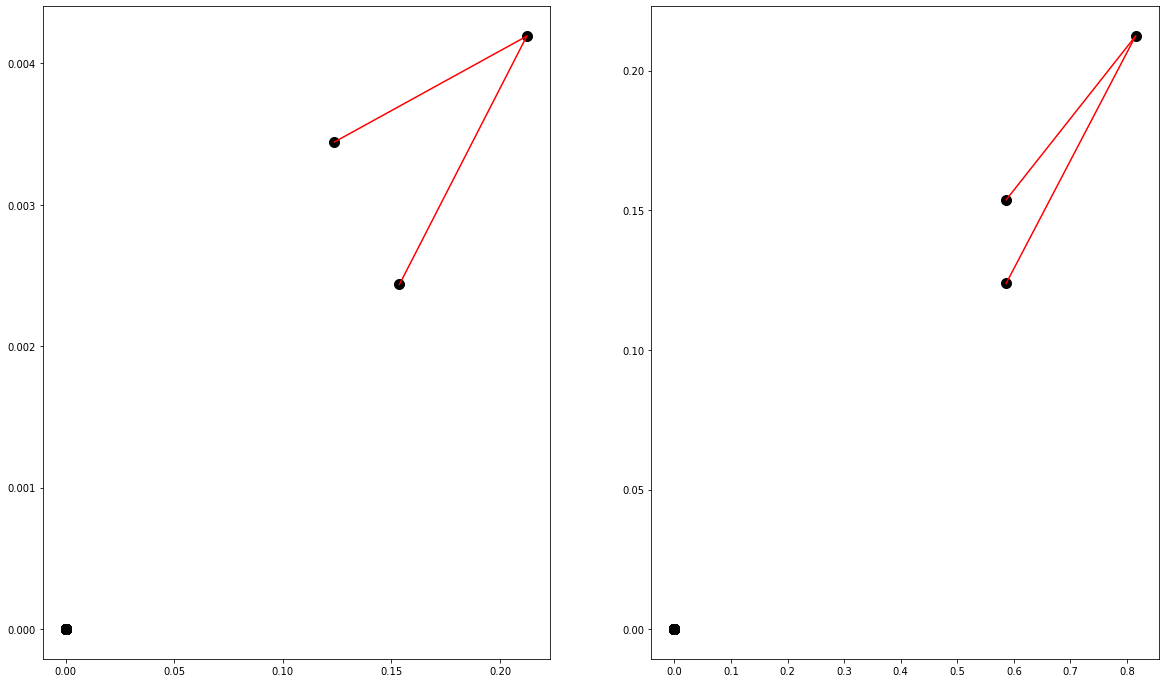

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [4.4222144e-04 1.3594635e-04 7.8193530e-05 8.7514512e-05 6.9354443e-05
 7.5286109e-05 4.3683474e-05 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


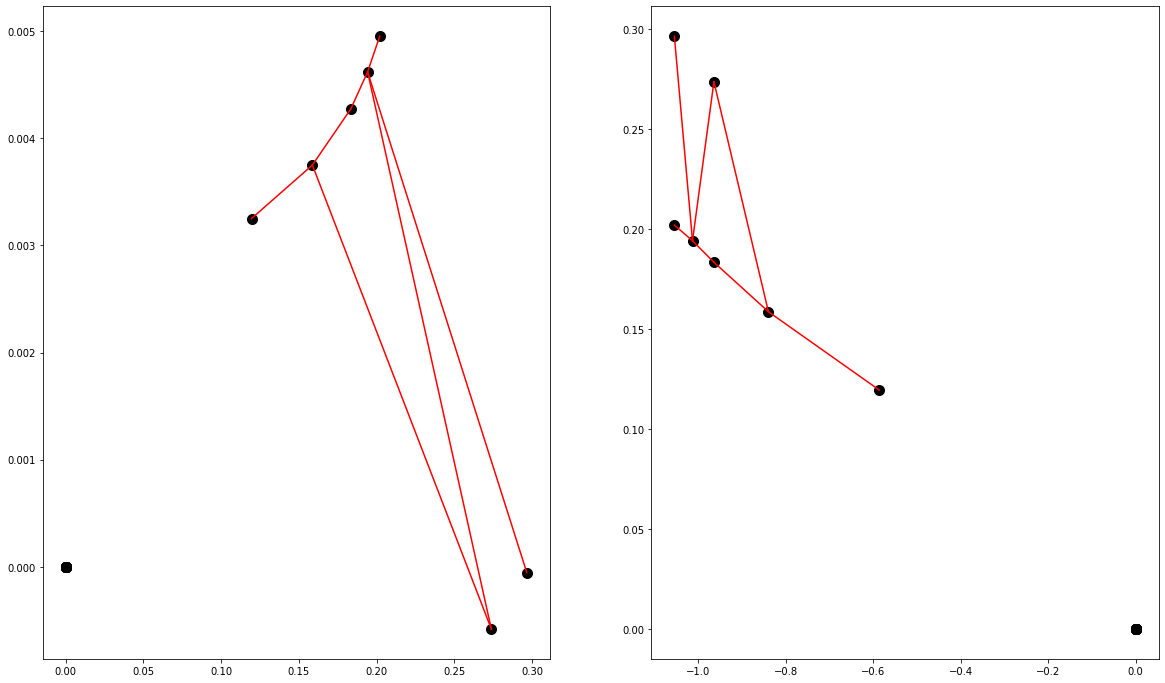

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00023319 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


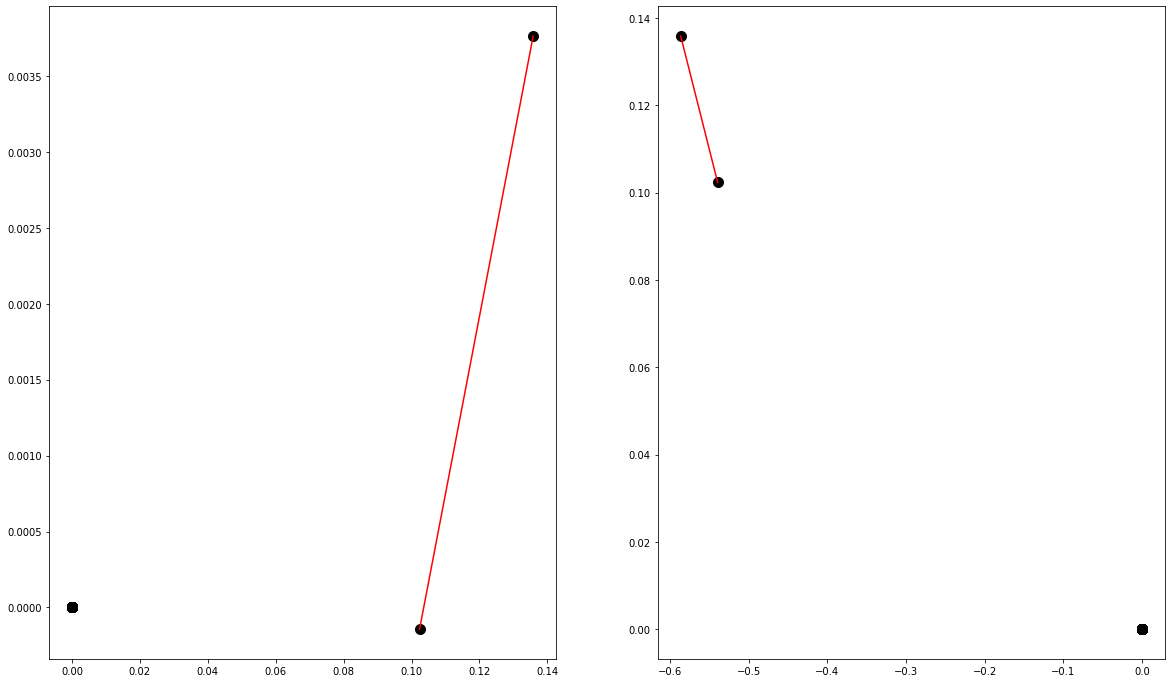

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1585678  0.22623287 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


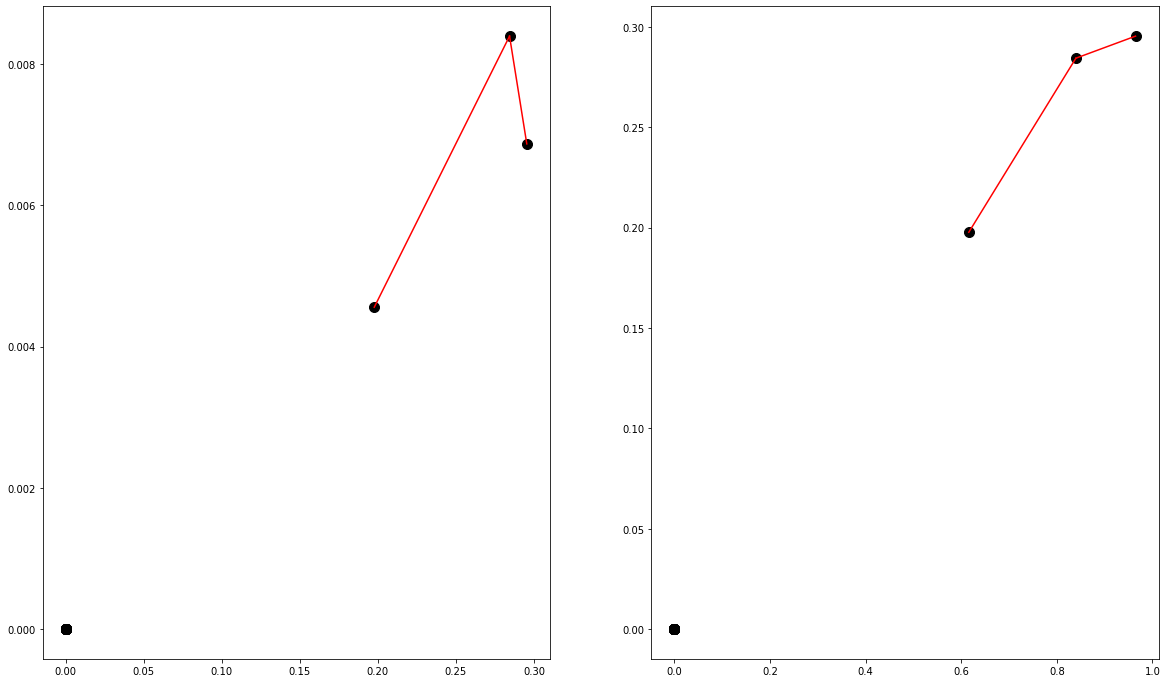

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.18503447 0.28591475 0.28964213 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


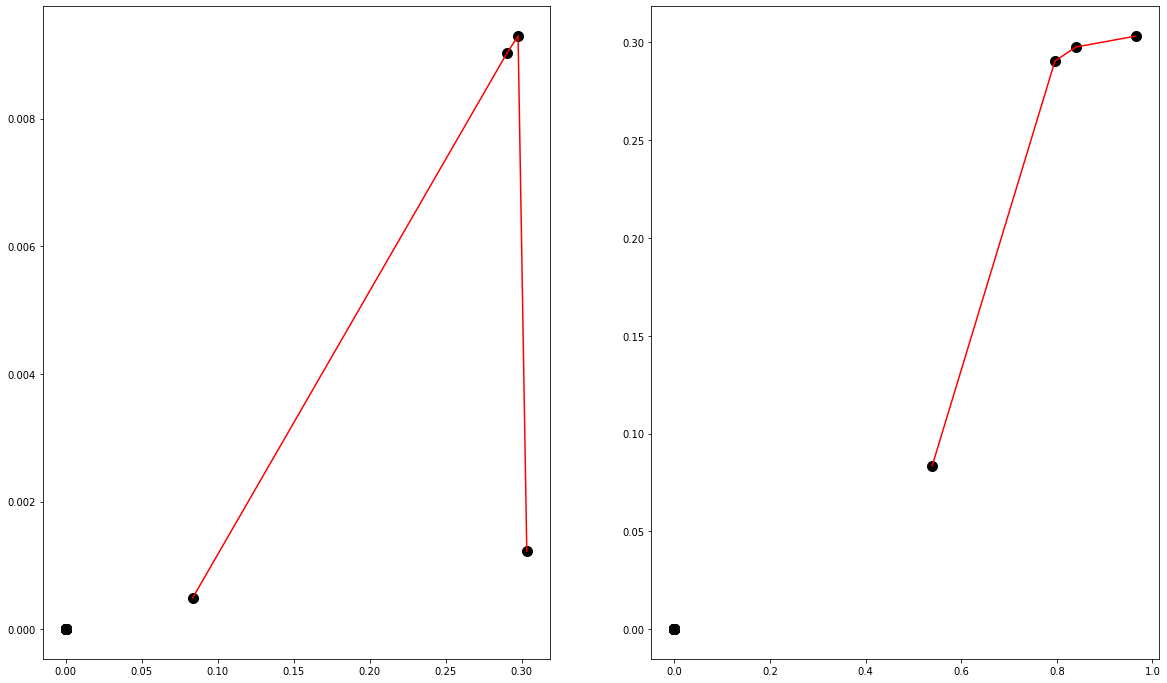

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.04736353 0.1207729  0.12679973 0.04036196 0.10364003 0.10887649
 0.09562505 0.15376098 0.1598151  0.30167332 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


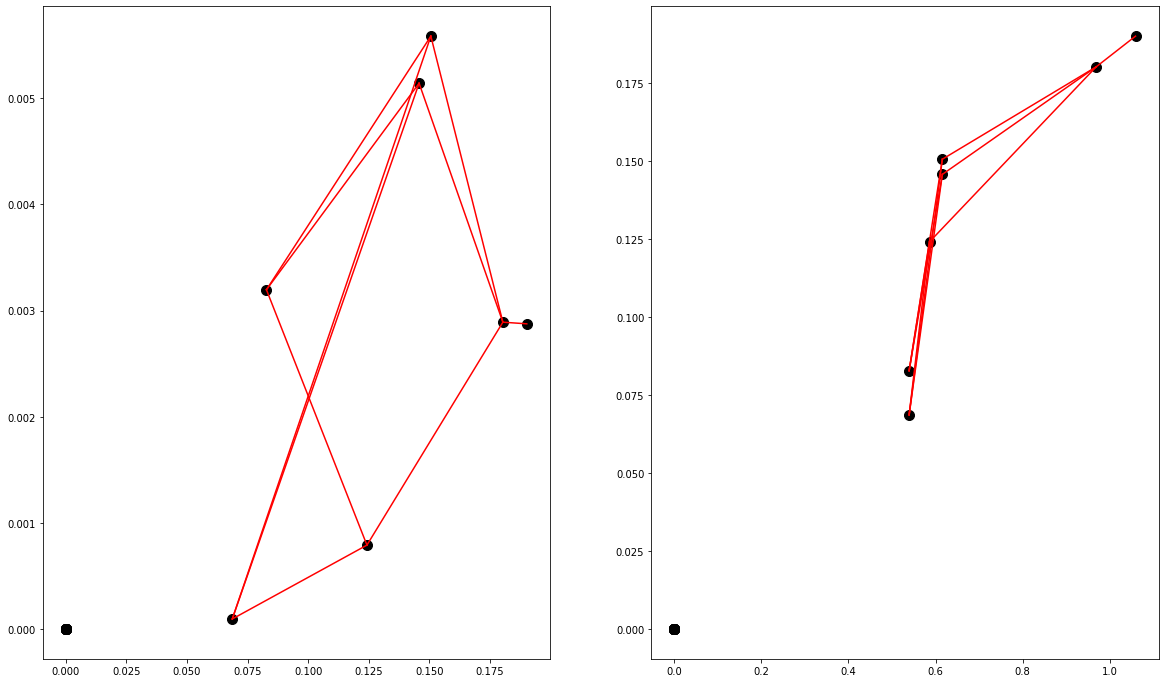

Y = [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.35208166 0.53385127 0.33038533 0.50621724 0.20399623 0.3147842
 0.24897078 0.36875284 0.5153365  0.5952294  0.40235493 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.878, precision 0.000, recall 0.000


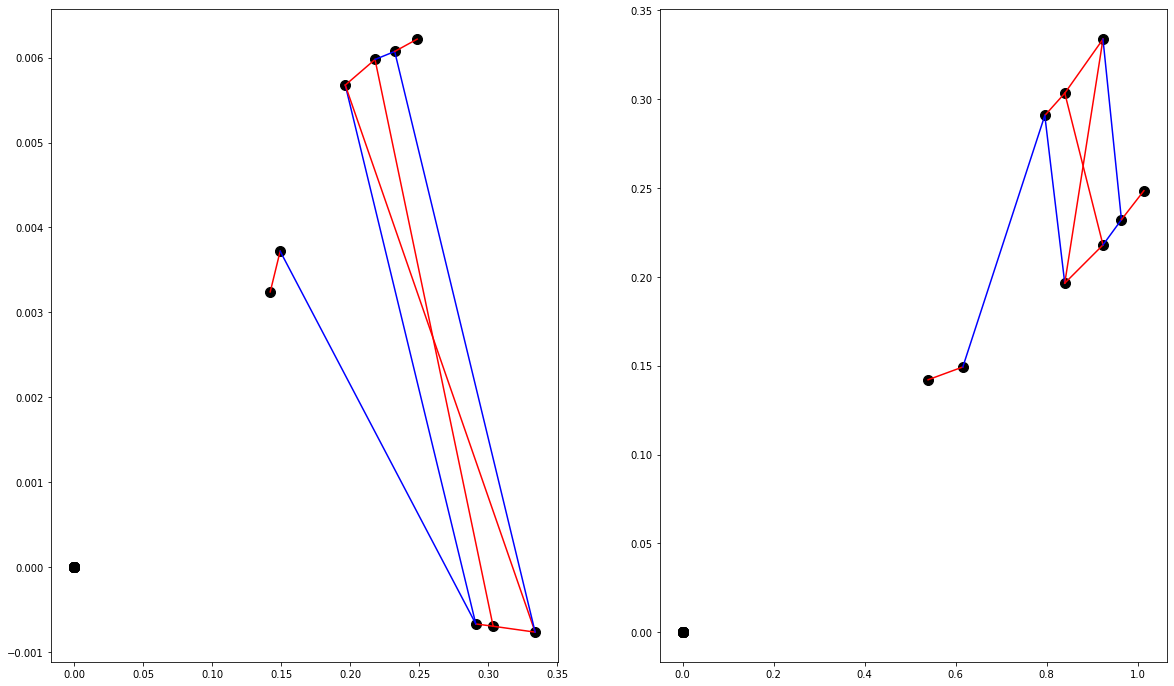

Y = [1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.19033396 0.24949224 0.1903571  0.24951991 0.39407966 0.44343543
 0.71316105 0.7073059  0.73532575 0.6440187  0.48442882 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.918, precision 1.000, recall 0.500


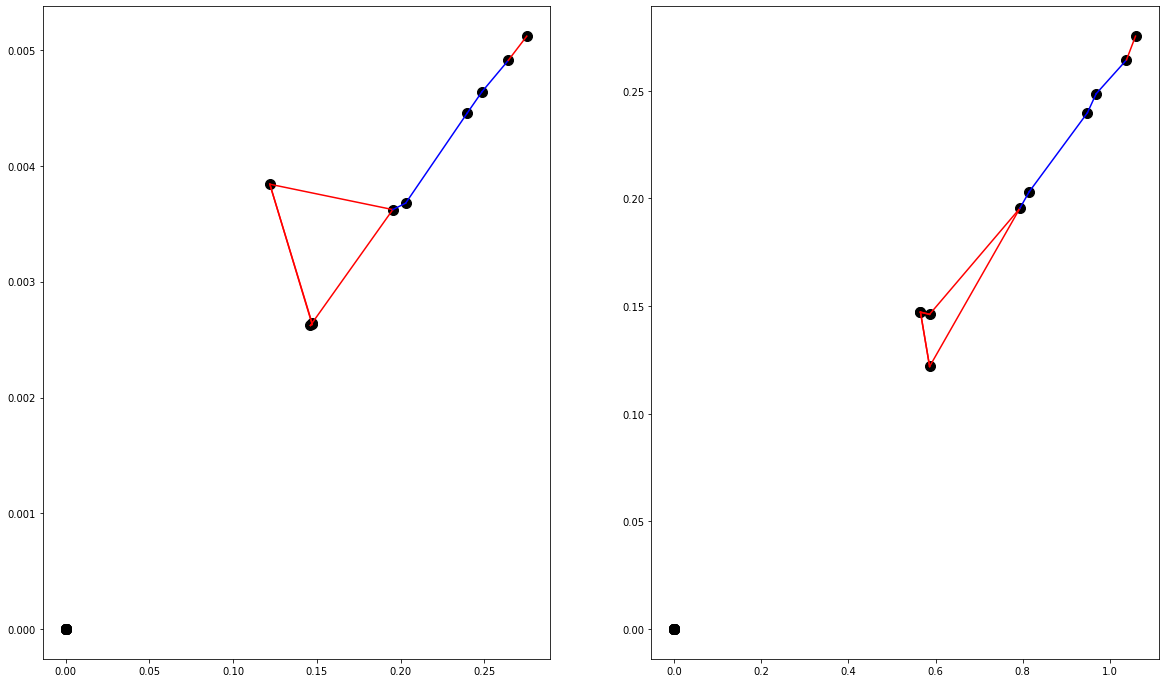

Y = [1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20618093 0.14202534 0.13930303 0.26716462 0.27735293 0.24247509
 0.24096094 0.29660547 0.70599526 0.6757314  0.74172324 0.37959424
 0.36840177 0.4454113  0.43184465 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.878, precision 1.000, recall 0.333


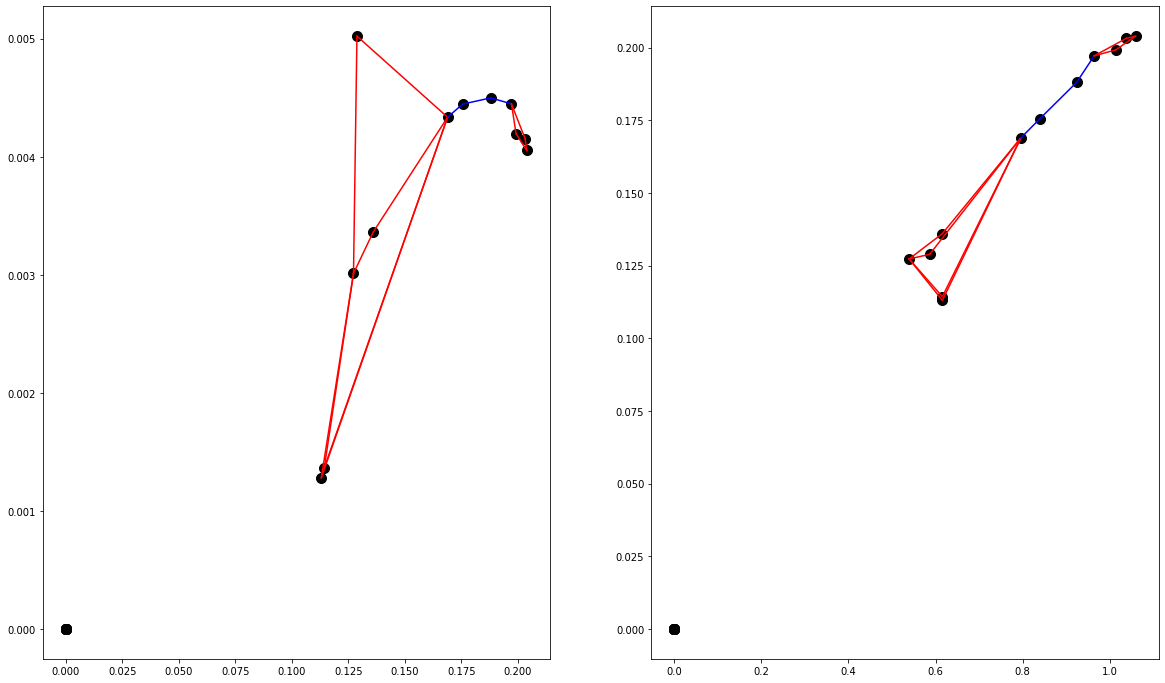

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00015575 0.00016073 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


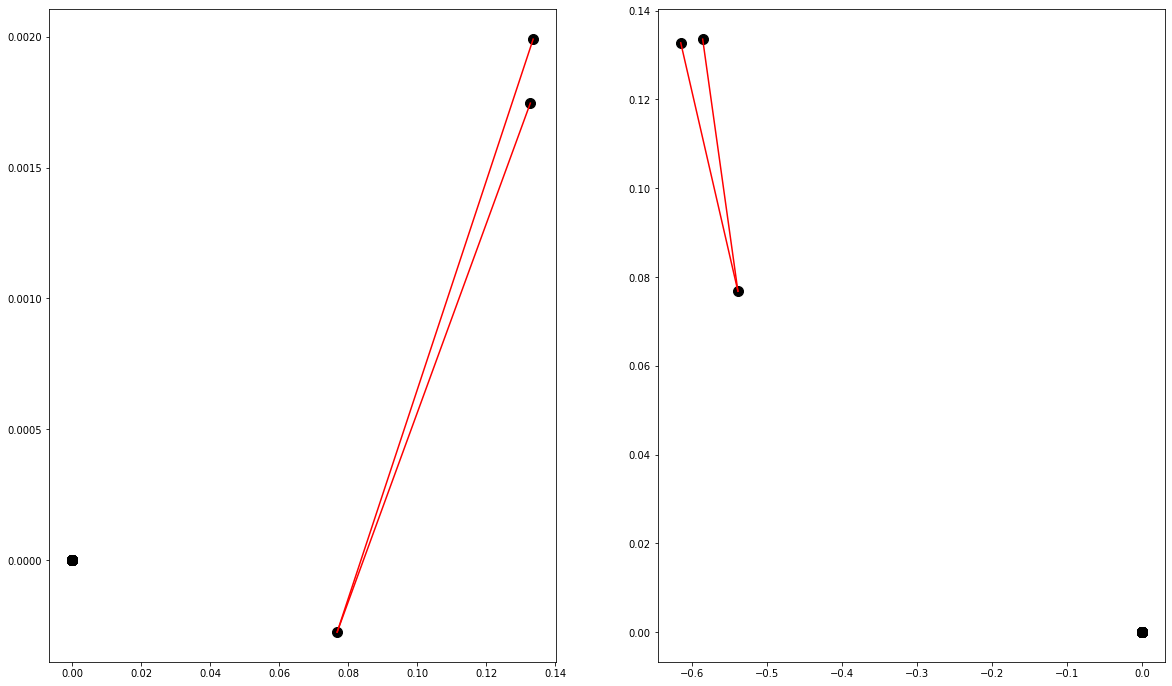

Y = [0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.27313513 0.2750686  0.3131343  0.70047694 0.47645557 0.366568
 0.1868273  0.17883855 0.12300208 0.1733933  0.16549034 0.11122666
 0.24068007 0.18160678 0.15980239 0.23168363 0.17378512 0.15253967
 0.18934934 0.13684136 0.11832155 0.50615525 0.38900286 0.49377632
 0.5082073  0.38670138 0.49546236 0.52197593 0.39895442 0.5091029
 0.364036   0.25546706 0.2604671  0.17457536 0.34705925 0.24144165
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.755, precision 0.400, recall 0.182


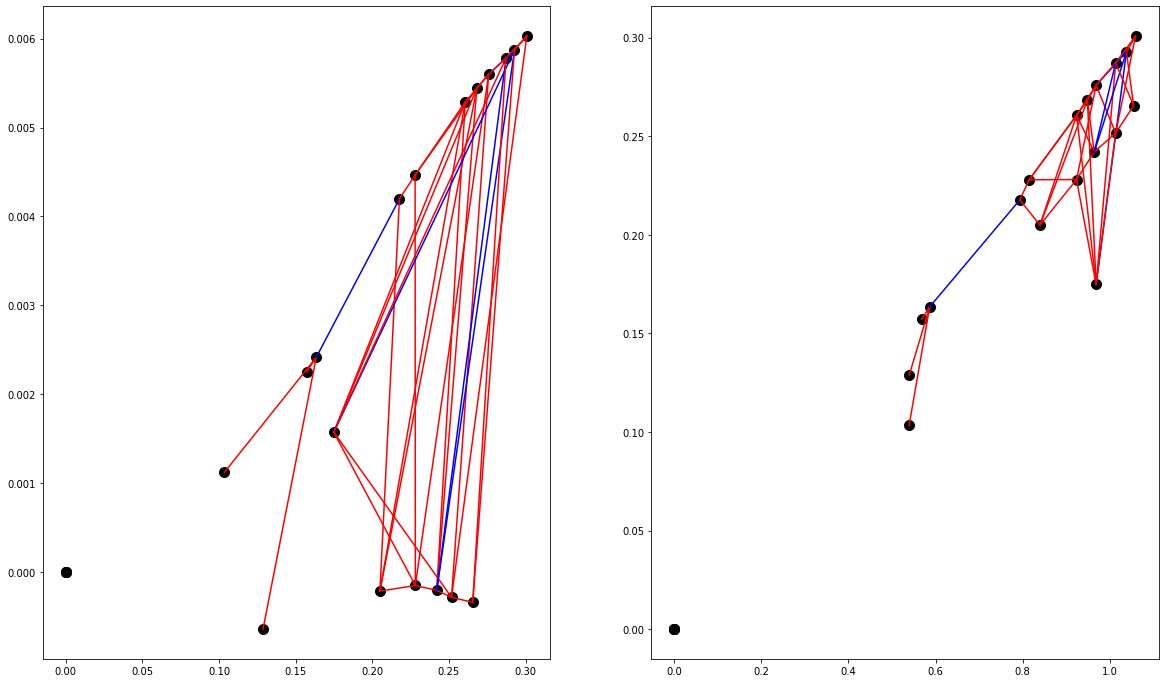

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.05368199 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


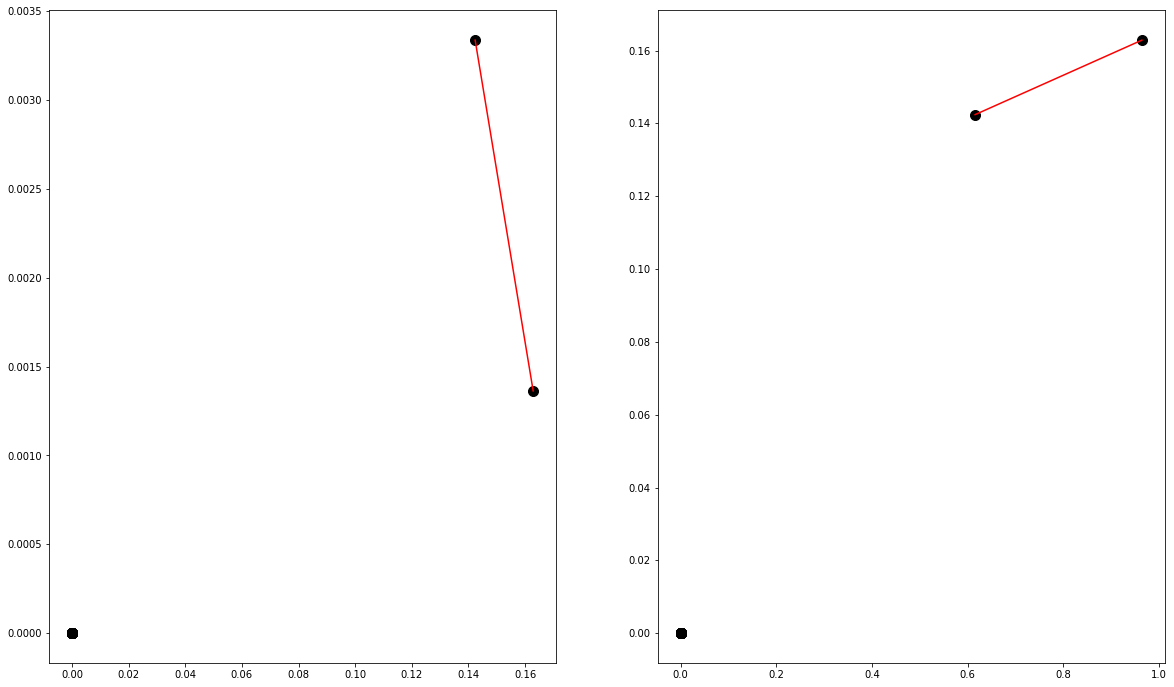

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [1.0549588e-03 7.6600339e-04 1.1155237e-03 8.0911070e-04 3.7004880e-04
 2.6900502e-04 3.7078917e-04 2.6954160e-04 4.3368028e-04 3.8505357e-04
 1.7752190e-04 2.4945624e-04 8.9396548e-05 2.2796831e-04 1.6832180e-04
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


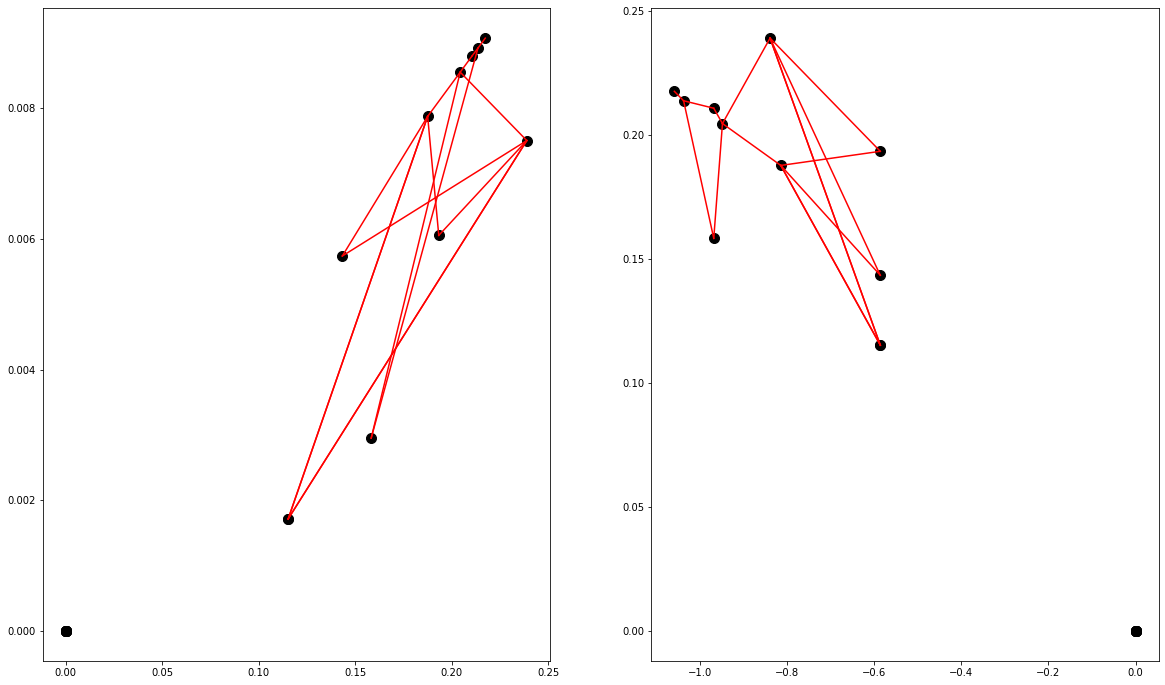

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.18284671 0.24198298 0.19150545 0.40092883 0.41193038 0.36921957
 0.72467726 0.38067463 0.4323447  0.23442702 0.43189114 0.43867296
 0.3156181  0.5076819  0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 0.000, recall 0.000


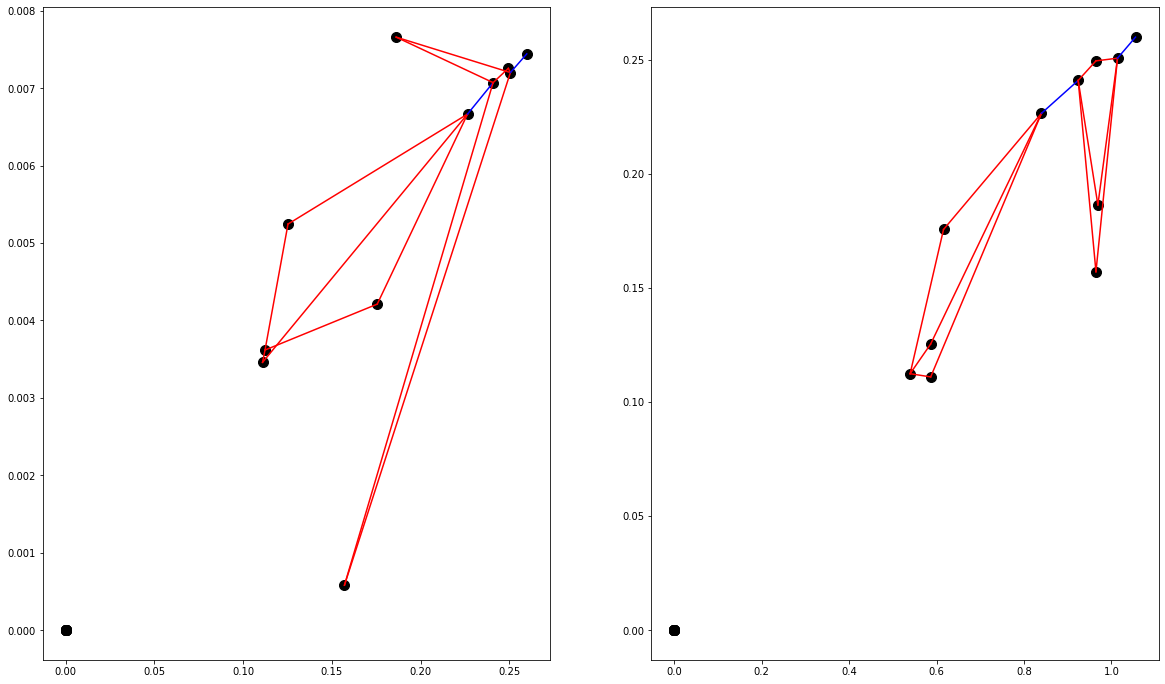

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.08110818 0.0369007  0.08578098 0.03905193 0.12737562 0.07493392
 0.09600761 0.05654685 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


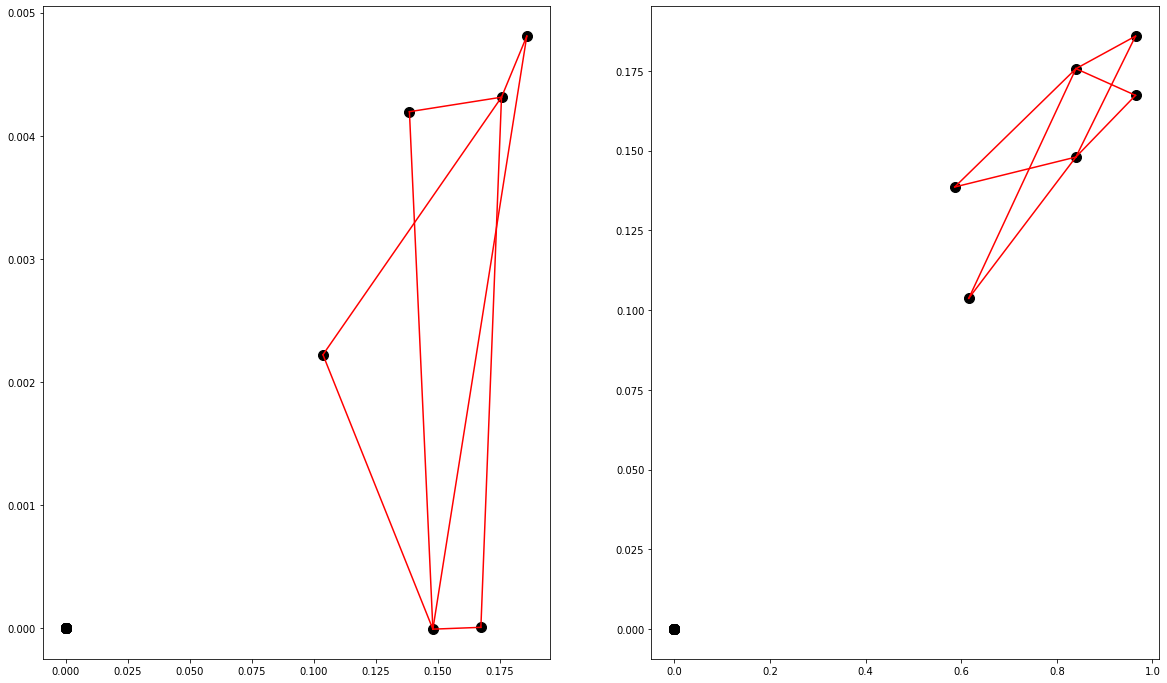

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00028446 0.00019751 0.00023697 0.00025486 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


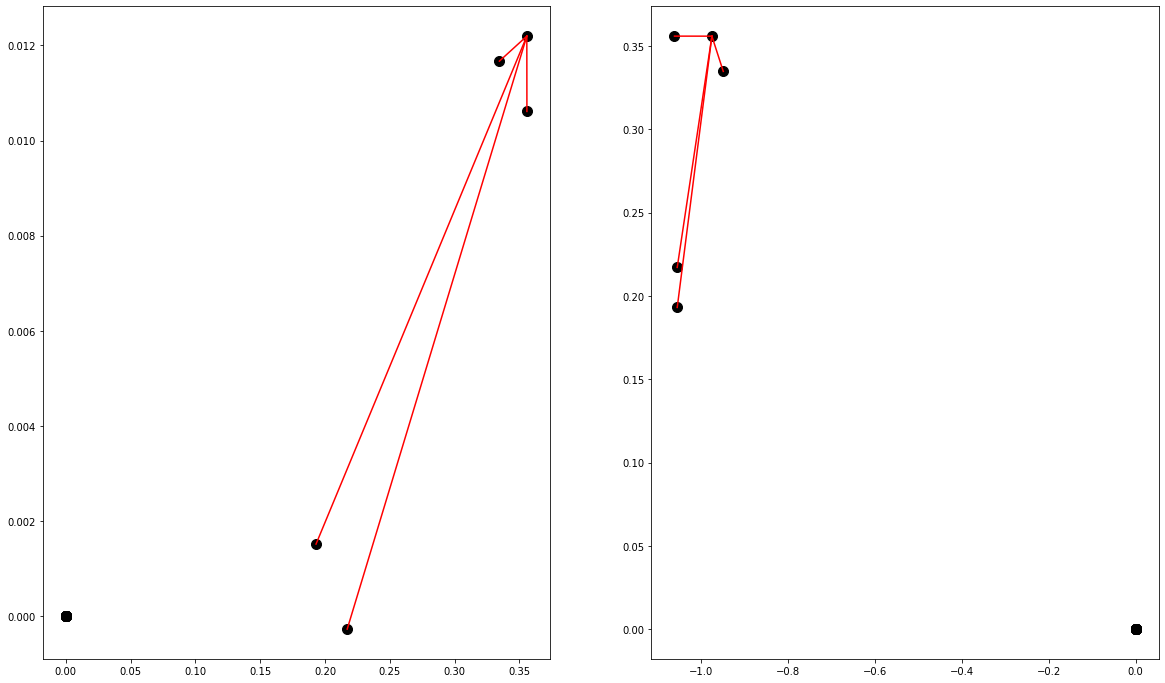

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.10054209 0.06242731 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


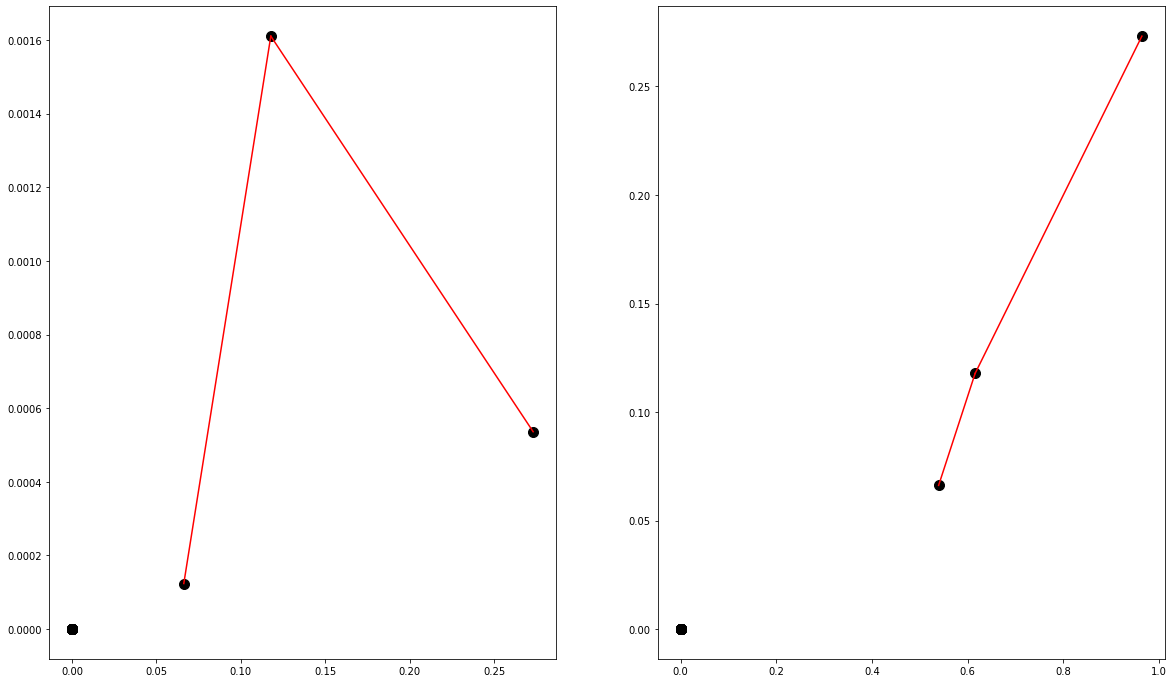

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.06079031 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


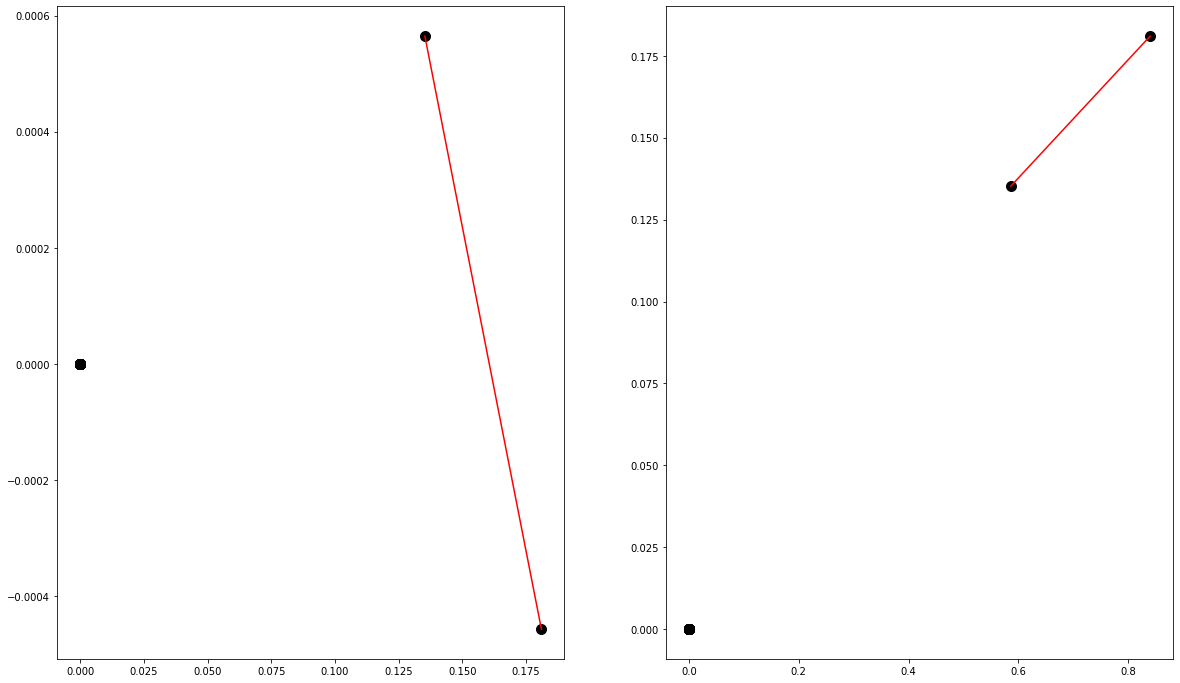

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [3.6758394e-04 3.6543200e-04 1.5754333e-04 1.5666579e-04 1.6354234e-04
 1.5866602e-04 1.5940696e-04 1.5465952e-04 1.0205549e-04 9.6760166e-05
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


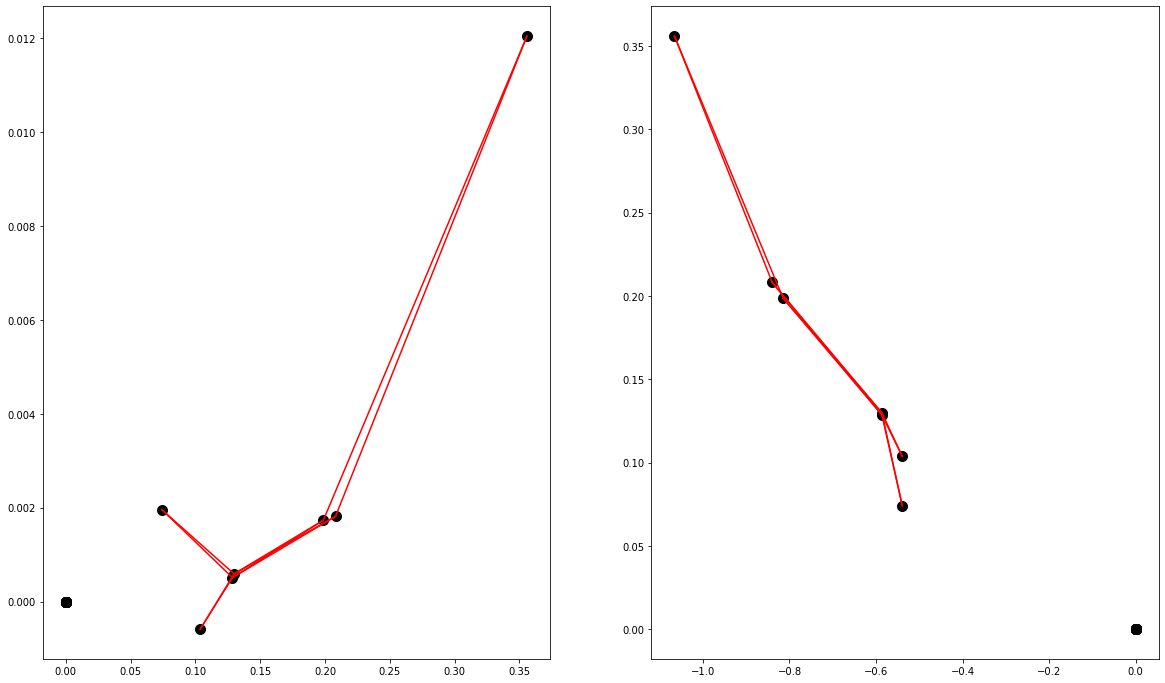

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.21519947 0.27660975 0.20951205 0.15033874 0.21924229 0.2437923
 0.19524482 0.17702647 0.670419   0.56067157 0.10378282 0.13759424
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.959, precision 0.000, recall 0.000


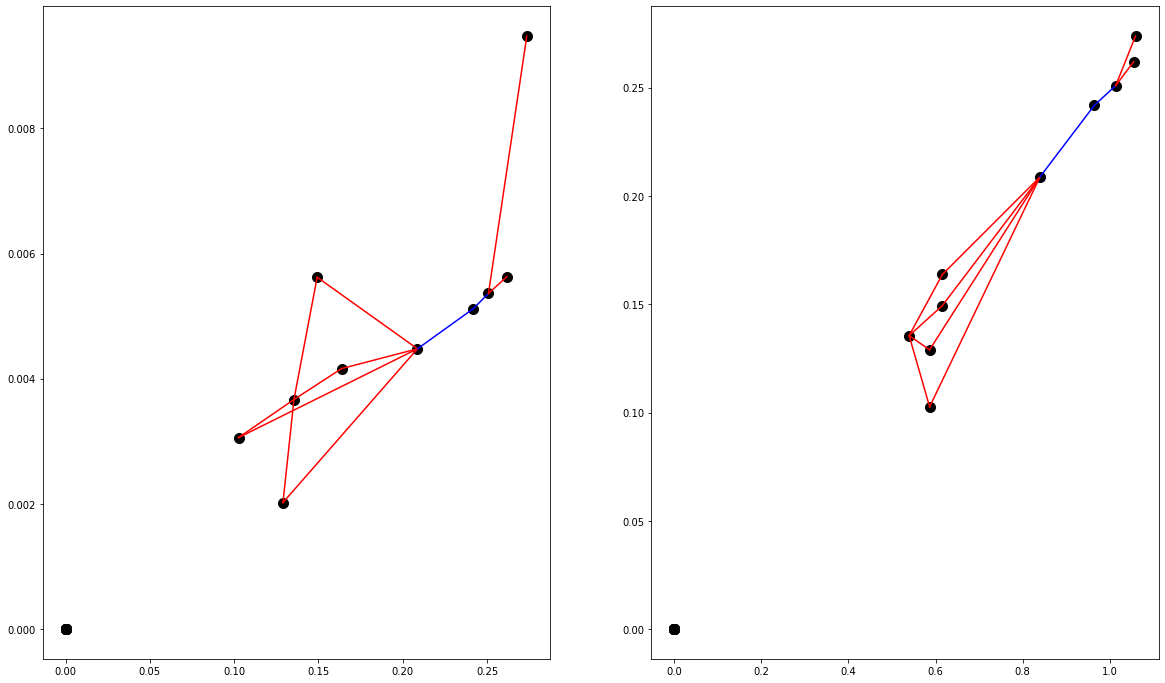

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.16215737 0.1546069  0.12529509 0.1255173  0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


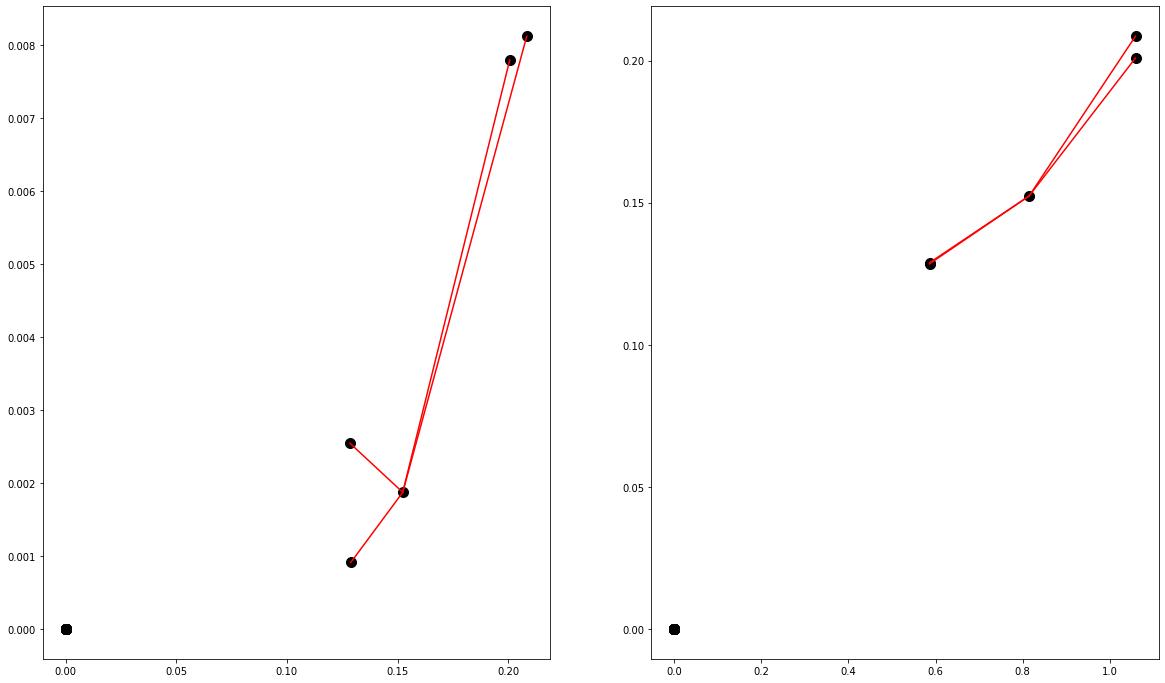

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00030216 0.00114602 0.0004904  0.00027914 0.00011444 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


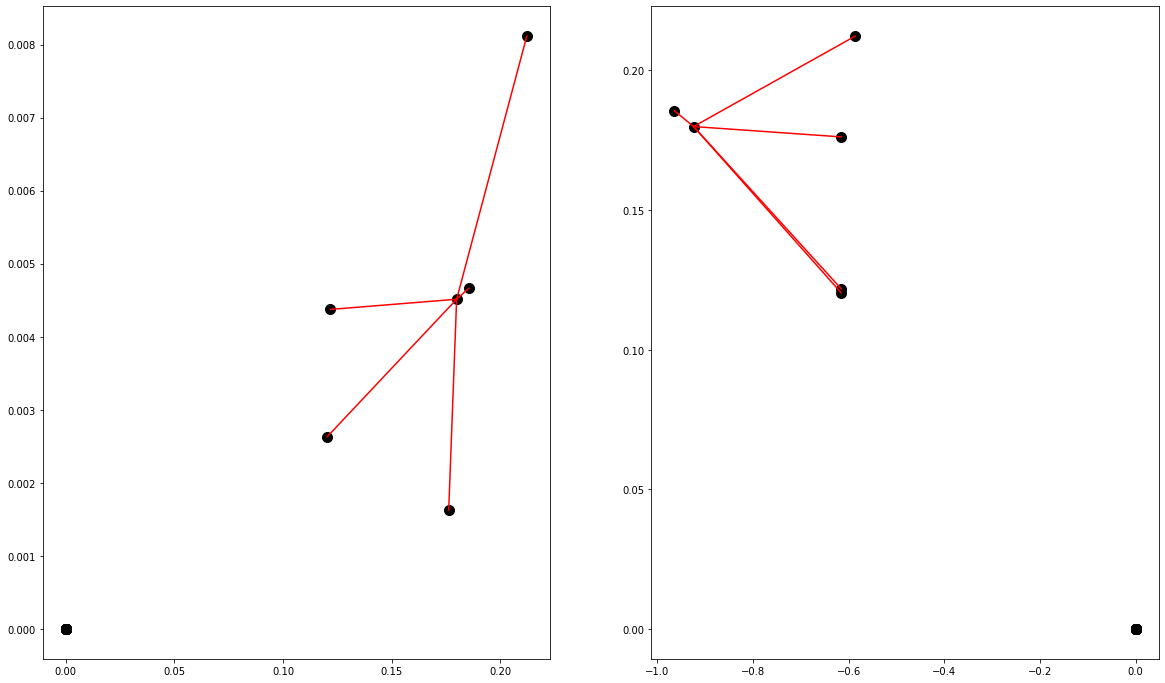

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00030713 0.00036237 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


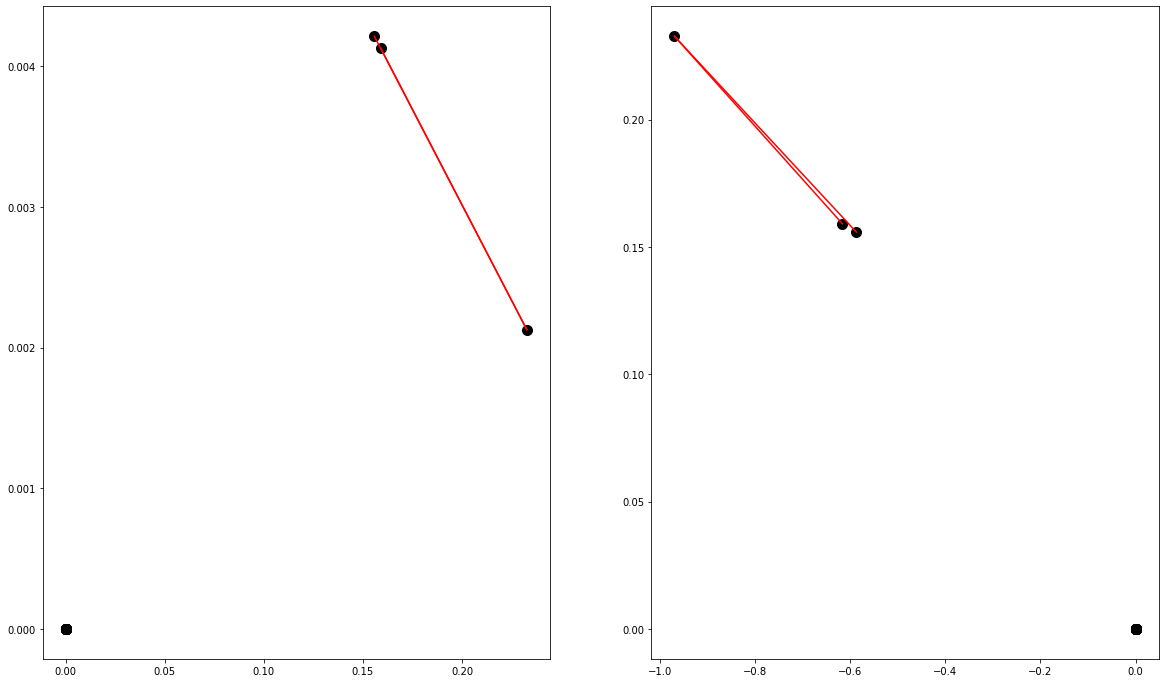

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00023537 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


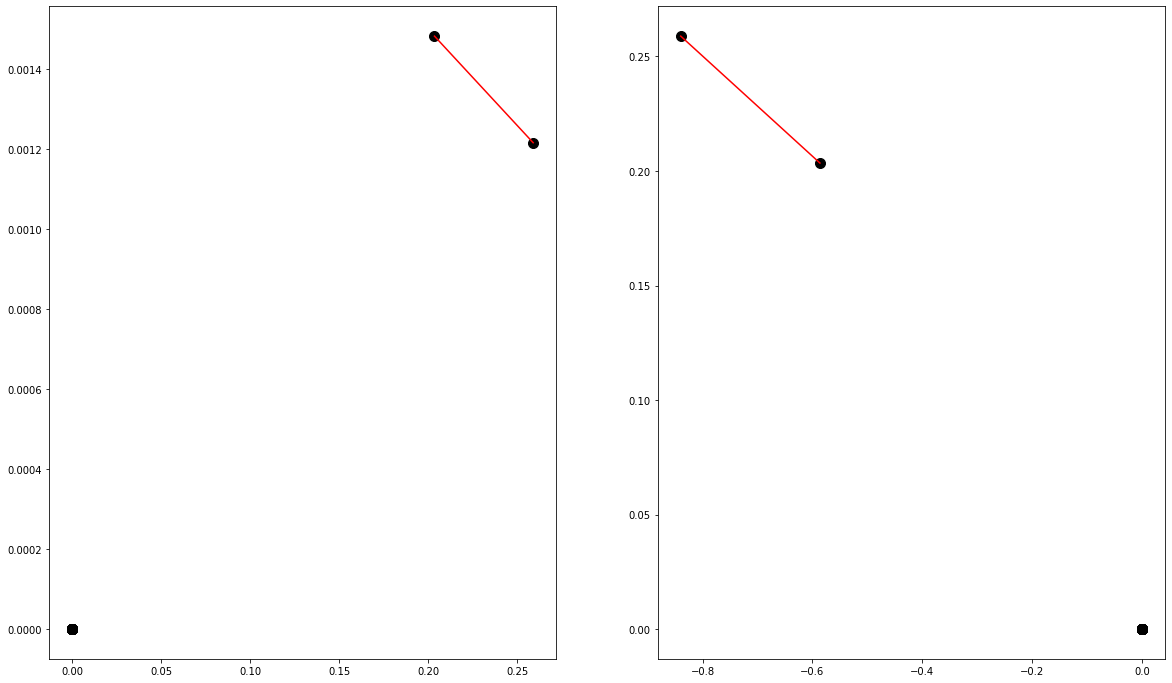

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00096145 0.0005791  0.00017888 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


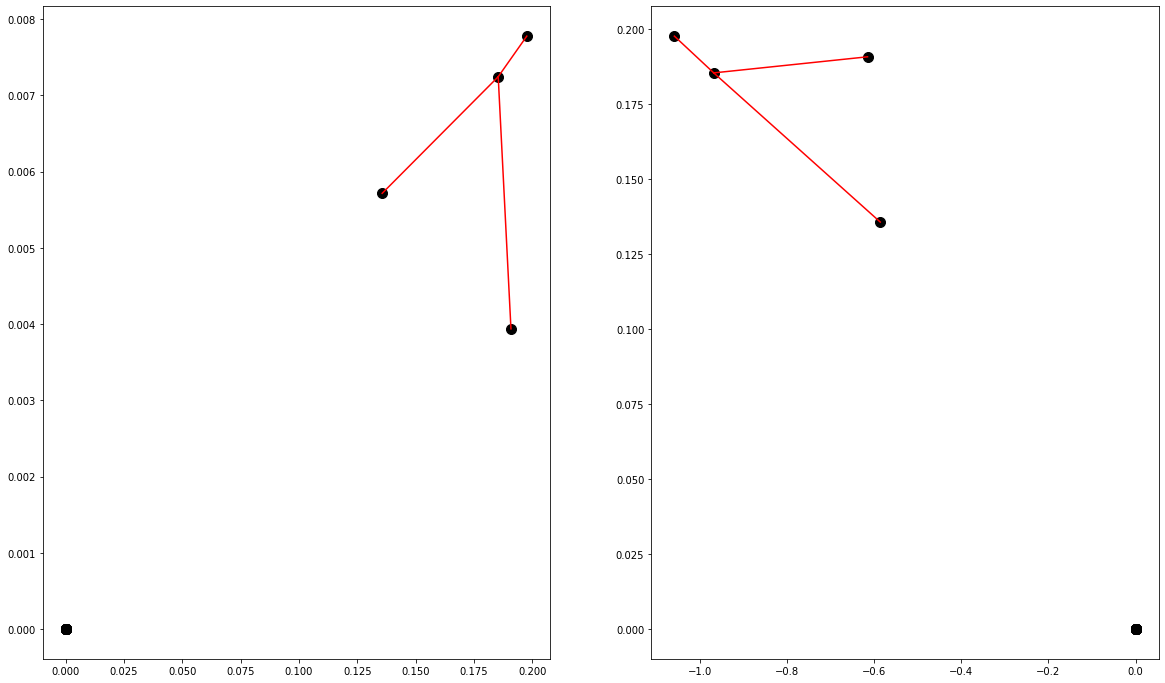

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00066167 0.00069367 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


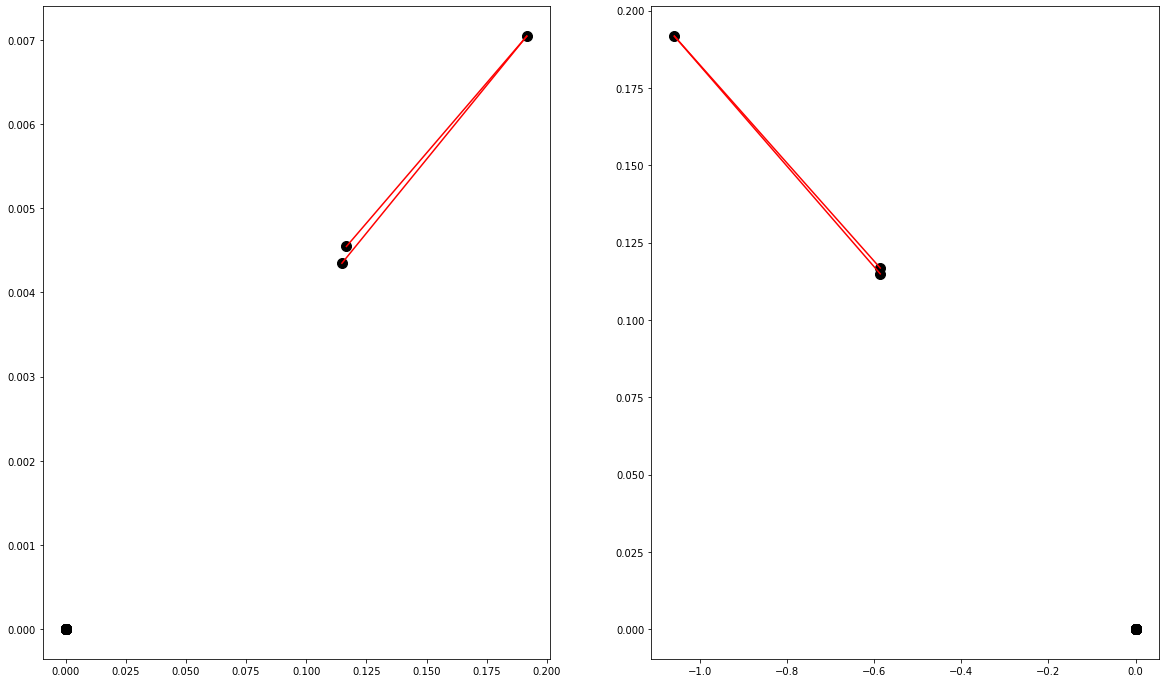

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.25433618 0.20479128 0.54080427 0.4949717  0.11278544 0.20238192
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 0.980, precision 0.000, recall 0.000


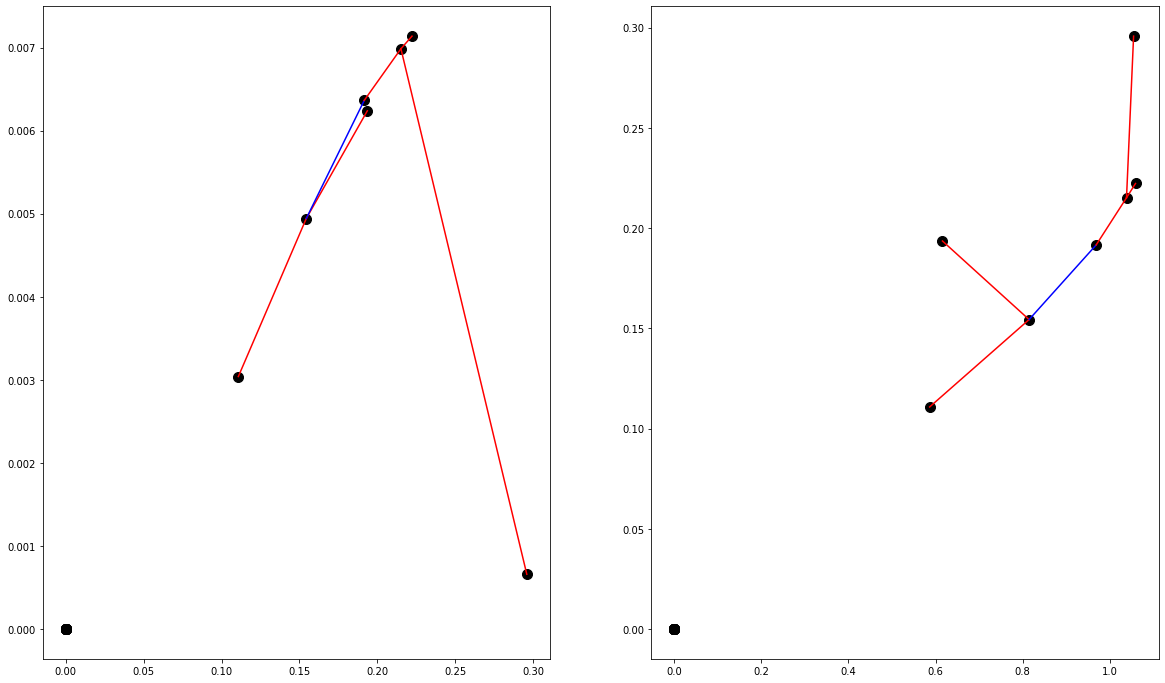

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.03586175 0.04125026 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


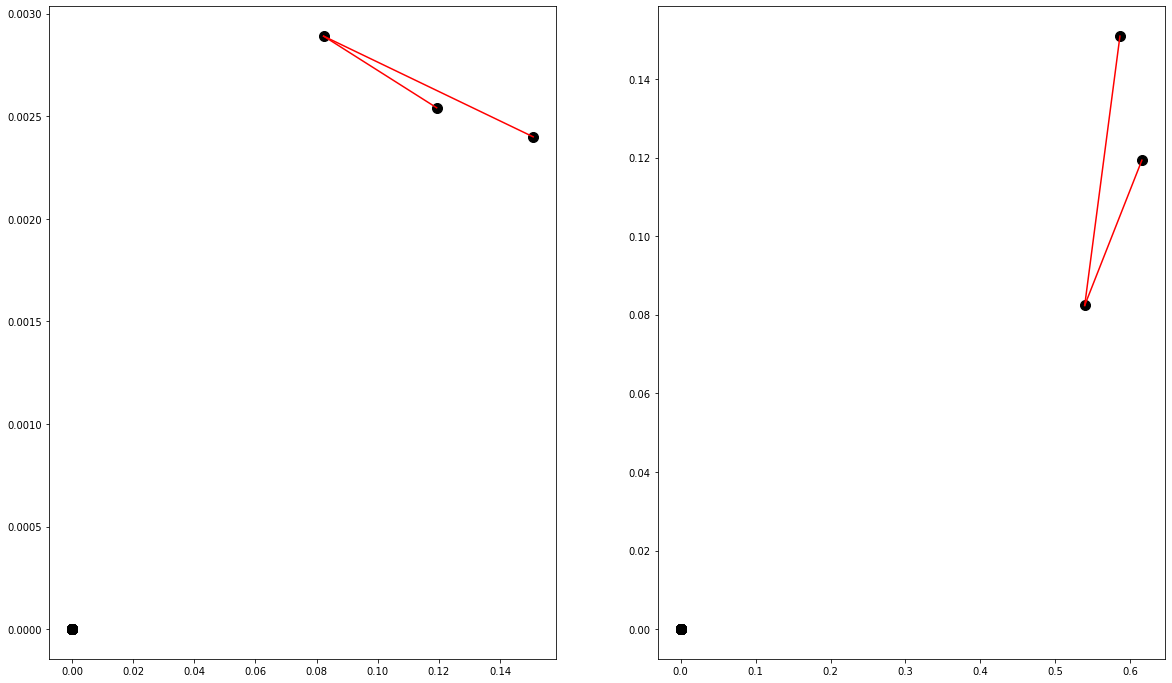

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.12942995 0.23335935 0.21643645 0.28667527 0.44209978 0.12784335
 0.18799073 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


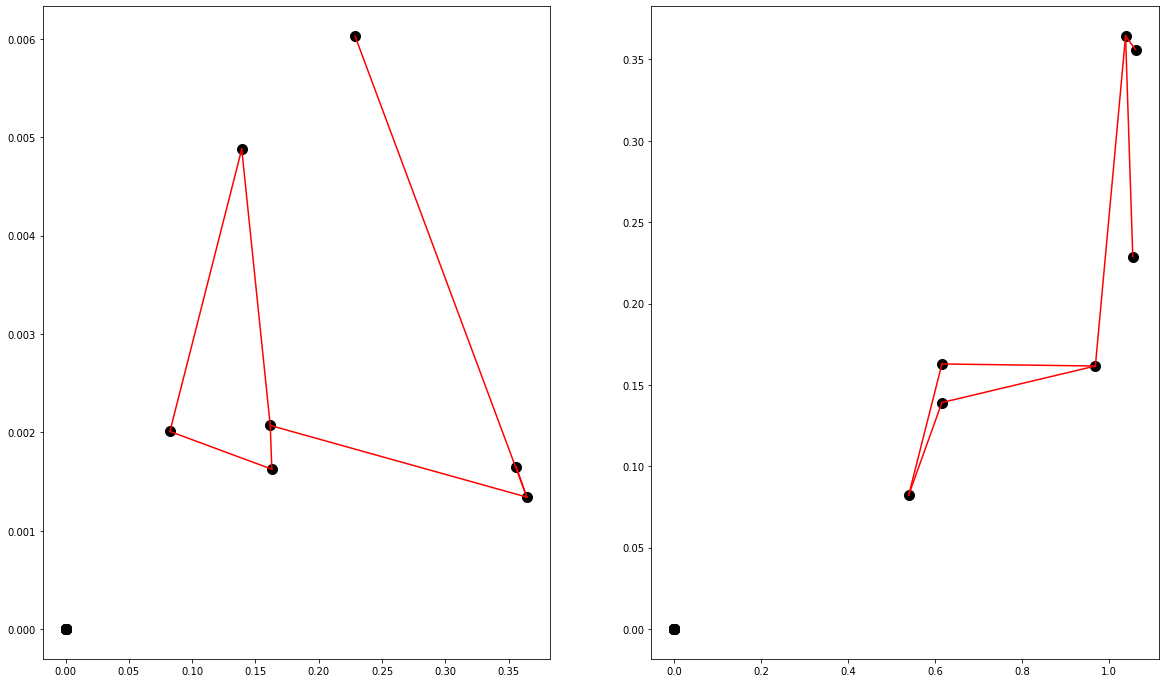

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.1340717  0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


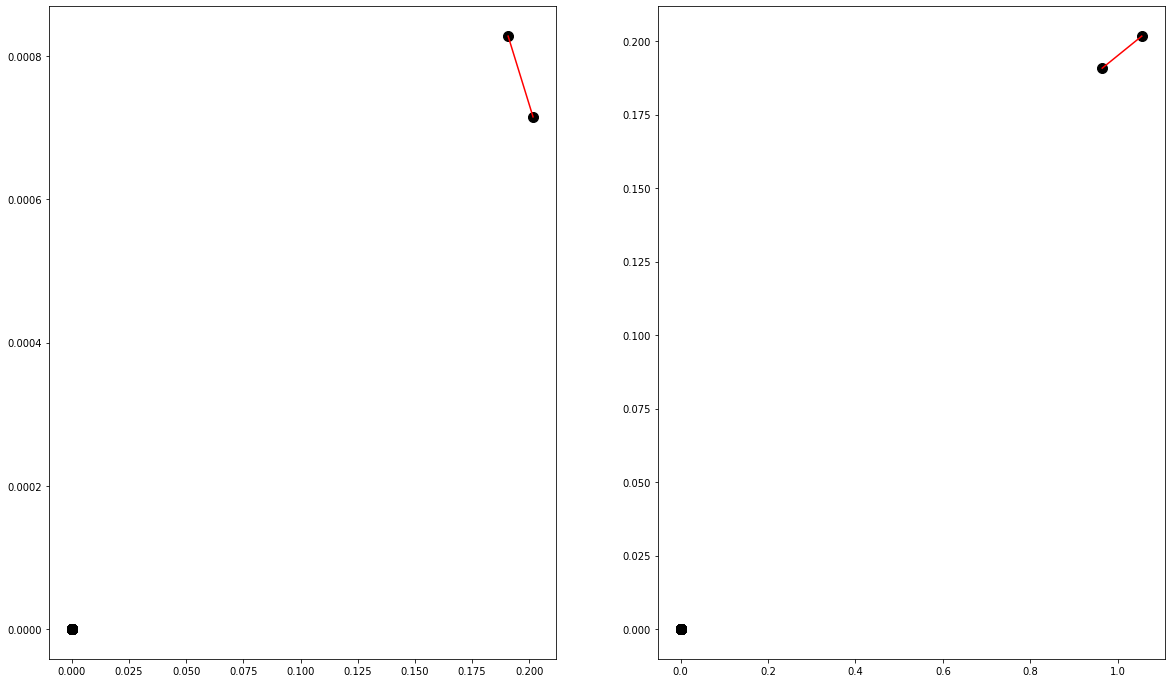

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.07820164 0.07656274 0.07747088 0.07585418 0.08957576 0.08796004
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


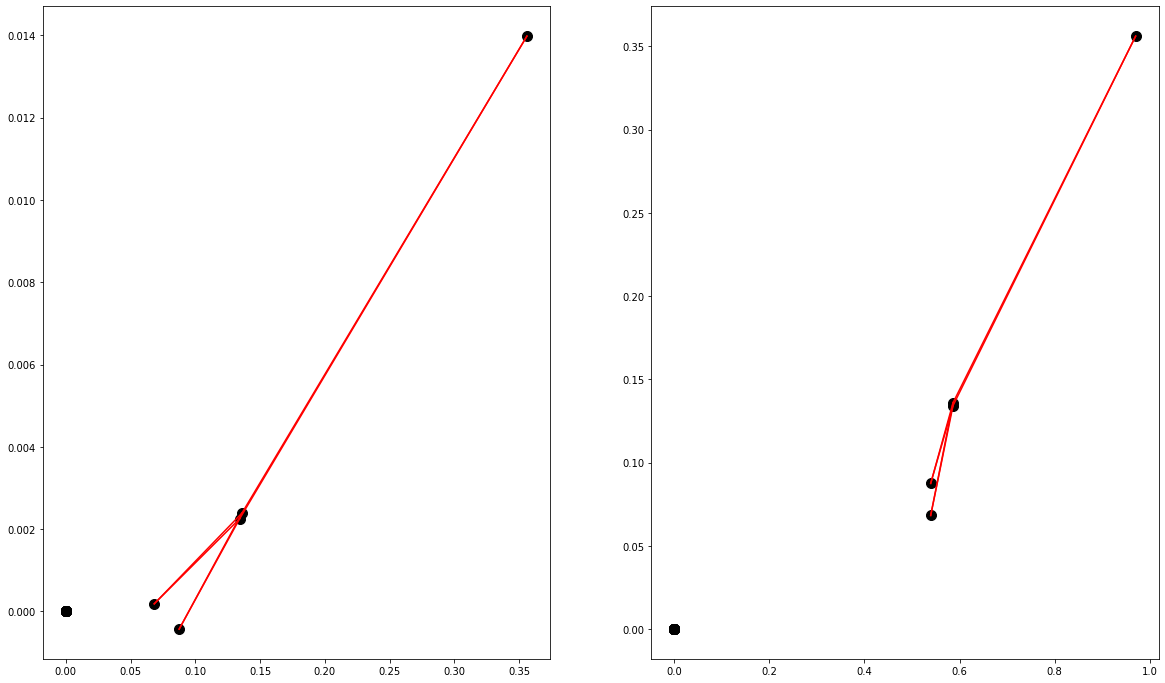

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.00051649 0.00045152 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


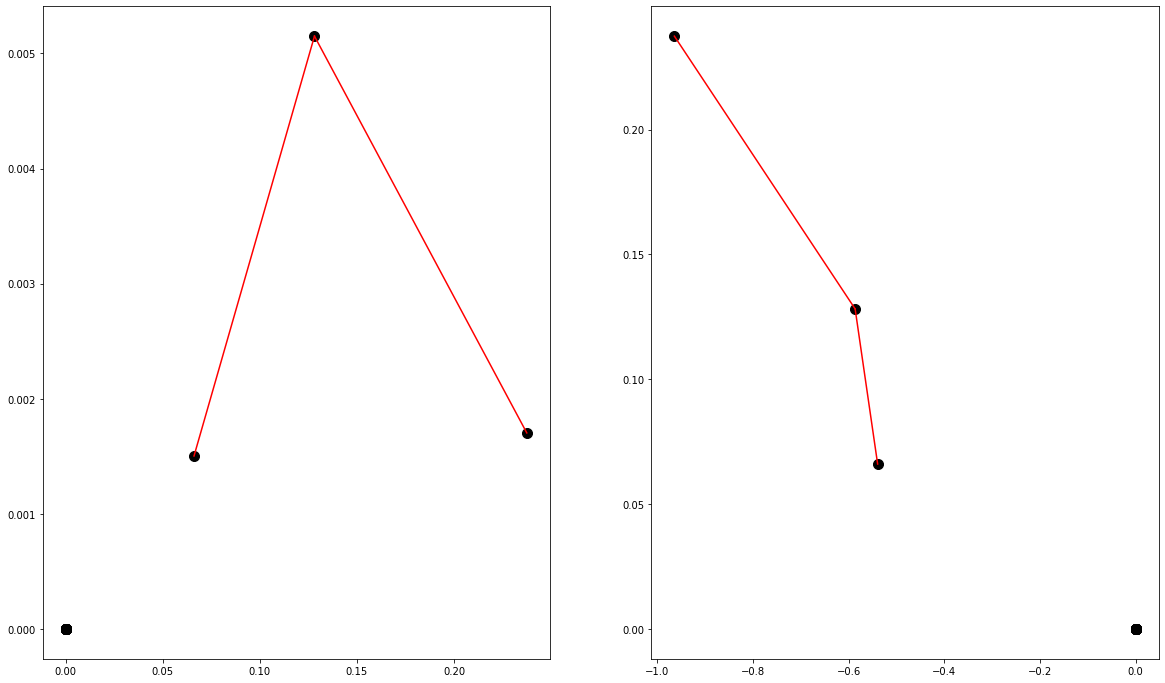

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [3.2248016e-04 1.9075132e-04 1.6447032e-04 1.6349199e-04 8.6906177e-05
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03
 1.4798950e-03 1.4798950e-03 1.4798950e-03 1.4798950e-03]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


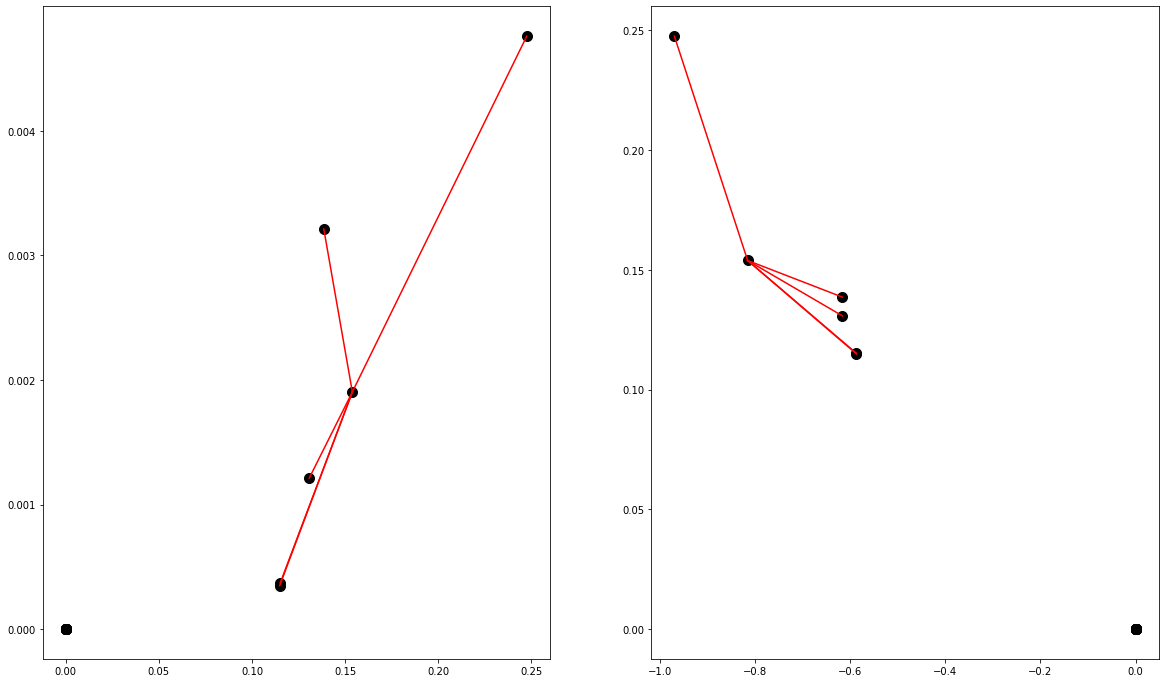

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
PRED = [0.20589271 0.21078621 0.10837261 0.28619856 0.20259348 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989 0.00147989
 0.00147989]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


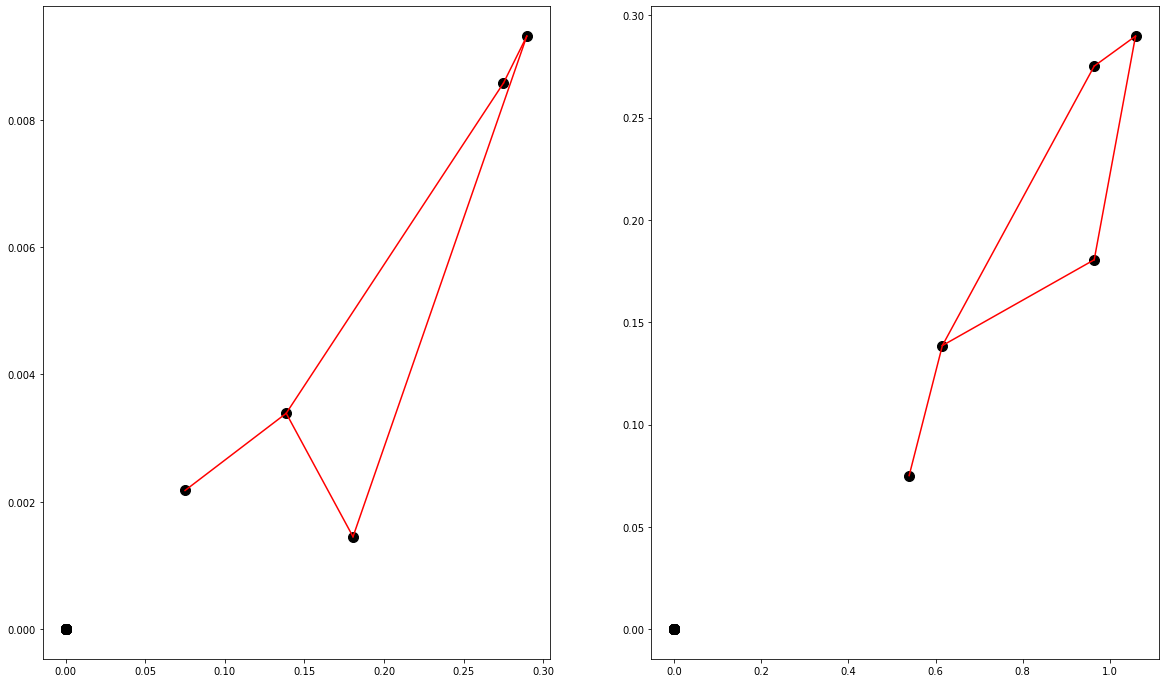

IndexError: ignored

In [12]:
def drawGraph(X, Ri, Ro, y, pred): 
    # Select the i/o node features for each segment    
    # Prepare the figure
 
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
#    cmap = plt.get_cmap('bwr_r')

    # HITS features 
    R=X[:,0]
    Phi=(np.pi/180.)*X[:,1]
    Z=X[:,2] # Don't save isMuon X[:,3] component in graph feature
    XX=R*np.cos(Phi)
    YY=R*np.sin(Phi)

    # Transform 0 and 1 labels into color list using the dictionary 
    colordic={1:'blue' , 0:'red'}
#    cl=[colordic.get(n) for n in X[:,3]] # use the hit target value for color

    # Plot the hits
    ax0.scatter(XX,YY, s=100., color='black' )
    ax1.scatter(Z,R, s=100., color='black' )
    
    # Get the hits indices from the SGMENTS arrays
    idx_i = find(np.rot90(Ri))[1]
    idx_o = find(np.rot90(Ro))[1]
  
    # Reverse to get correct hits order as in dh_hits 
    idx_i=idx_i[::-1]
    idx_o=idx_o[::-1]

    # Get SEGMENTS begin and end hits coordinates
    R_i=X[idx_i,0]
    Phi_i=(np.pi/180.)*X[idx_i,1]
    Z_i=X[idx_i,2]
    X_i=R_i*np.cos(Phi_i)
    Y_i=R_i*np.sin(Phi_i)
  
    R_o=X[idx_o,0]
    Phi_o=(np.pi/180.)*X[idx_o,1]
    Z_o=X[idx_o,2]
    X_o=R_o*np.cos(Phi_o)
    Y_o=R_o*np.sin(Phi_o)
  
    # Create a list of SEGMENTS colors 
#    cl=[colordic.get(n) for n in y]
    cl=[colordic.get(np.round((n-thresh+0.5),0)) for n in pred]

    # Plot segments

    for j in range(len(X_i)):
      ax0.plot([X_i[j], X_o[j]], [Y_i[j], Y_o[j]], '-', color=cl[j])
      ax1.plot([Z_i[j], Z_o[j]], [R_i[j], R_o[j]], '-', color=cl[j])


    # Show plots
    plt.show()


# Loop to draw one graph per event

for i in range(n_test):
    X = test_X[i,:,:] 
    Ri = test_Ri[i,:]
    Ro = test_Ro[i,:]
#    pred = test_pred[i].squeeze(0)
    pred = test_pred[i,:]
    y = test_y[i,:]

    print('Y =',y)
    print('PRED =',pred)
    print('--------------------------------------')

    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(y, pred>thresh),
        sklearn.metrics.precision_score(y, pred>thresh),
        sklearn.metrics.recall_score(y, pred>thresh)))
    drawGraph(X, Ri, Ro, y , pred);